In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
# import data
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
submission_df = pd.read_csv('../data/sample_submission.csv')

## Data Preparation for model training

In [ ]:
cols_to_drop = ['id', 'CustomerId', 'Surname', 'Exited']
X = train_df.drop(cols_to_drop, axis=1)
y = train_df['Exited']

### 1. One Hot Encoding Categorical Variables: 

In [ ]:
X = pd.get_dummies(X, columns=['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'])
X.head()

,CreditScore,Age,Tenure,Balance,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,HasCrCard_0.0,HasCrCard_1.0,IsActiveMember_0.0,IsActiveMember_1.0
0,668,33.0,3,0.00,181449.97,True,False,False,False,True,False,True,False,False,False,True,True,False
1,627,33.0,1,0.00,49503.50,True,False,False,False,True,False,True,False,False,False,True,False,True
2,678,40.0,10,0.00,184866.69,True,False,False,False,True,False,True,False,False,False,True,True,False
3,581,34.0,2,148882.54,84560.88,True,False,False,False,True,True,False,False,False,False,True,False,True
4,716,33.0,5,0.00,15068.83,False,False,True,False,True,False,True,False,False,False,True,False,True


In [ ]:
# Checking the ratio of the target variable
y.value_counts(normalize=True)

Exited
0    0.788401
1    0.211599
Name: proportion, dtype: float64

The distribution of target label (0 and 1) are highly imbalanced: almost 80% of the data is of label 0 (non-exited), label 1 only accounts for ~20%. 

In [ ]:
# Splitting Data into Train and Test:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=1, 
                                                    stratify=y)

In [ ]:
# Checking the ratio of the label after splitting into train and test: 
print(y_train.value_counts(normalize=True))

print(y_test.value_counts(normalize=True))

Exited
0    0.788398
1    0.211602
Name: proportion, dtype: float64
Exited
0    0.78841
1    0.21159
Name: proportion, dtype: float64


### 1. Model Training: 

In [ ]:
# Building base line model
xgb_1 = XGBClassifier(objective='binary:logistic', 
                      seed=1)
xgb_1.fit(X_train, y_train, verbose=True, 
            early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.87106
[1]	validation_0-auc:0.87661
[2]	validation_0-auc:0.87835
[3]	validation_0-auc:0.87987
[4]	validation_0-auc:0.88091
[5]	validation_0-auc:0.88141
[6]	validation_0-auc:0.88172
[7]	validation_0-auc:0.88222
[8]	validation_0-auc:0.88246
[9]	validation_0-auc:0.88251
[10]	validation_0-auc:0.88286
[11]	validation_0-auc:0.88294
[12]	validation_0-auc:0.88318
[13]	validation_0-auc:0.88340
[14]	validation_0-auc:0.88348
[15]	validation_0-auc:0.88362
[16]	validation_0-auc:0.88369
[17]	validation_0-auc:0.88374
[18]	validation_0-auc:0.88379
[19]	validation_0-auc:0.88377
[20]	validation_0-auc:0.88381
[21]	validation_0-auc:0.88385
[22]	validation_0-auc:0.88385
[23]	validation_0-auc:0.88382
[24]	validation_0-auc:0.88383
[25]	validation_0-auc:0.88386
[26]	validation_0-auc:0.88390
[27]	validation_0-auc:0.88393
[28]	validation_0-auc:0.88397
[29]	validation_0-auc:0.88389
[30]	validation_0-auc:0.88387
[31]	validation_0-auc:0.88385
[32]	validation_0-auc:0.88386
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Get all evaluation metrics on the test set
y_pred = xgb_1.predict(X_test)
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)


              precision    recall  f1-score   support

           0       0.89      0.94      0.92     32529
           1       0.73      0.55      0.63      8730

    accuracy                           0.86     41259
   macro avg       0.81      0.75      0.77     41259
weighted avg       0.85      0.86      0.85     41259



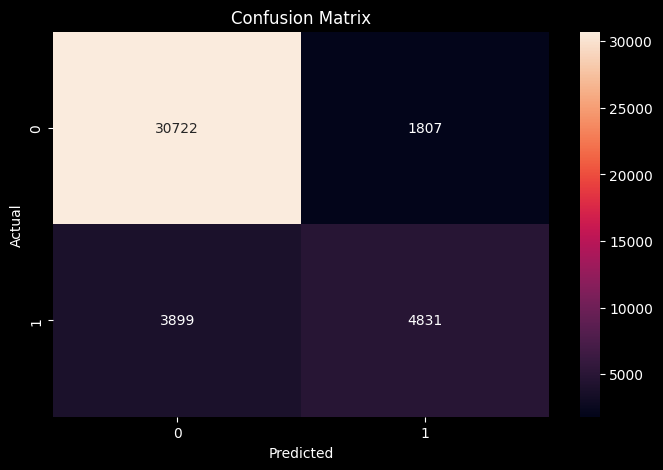

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

We can draw some initial conclusions for **the baseline model** (Note: we define 0 is negative and 1 is positive): 
- True Negative, or predicted 0 (non-exited) and actually 0: **30722** 
- True Positive, or predicted 1 (exited) and actually 1: **4831**
- False Negative, or predicted 0 (non-exited) but actually 1 (exited): **3899**
- False Positive, or predicted 1 (exited) but actually 0 (non-exited): **1807**

Next are some business-centric measures that is crucial in churn evaluation problem: 
- **False Negative (FN)** is an important measure for churn problem - the business does not want to under-value customers that would exit (1) by classifying them as non-exit (0) - because the cost of new customer acquisition is generally higher than the cost of keeping the customer. Ideally, the model should minimize the FN number. 
- **False Negative Rate, $FNR = \frac{{FN}}{P} = \frac{{FN}}{FN + TP}$** essentially means: out of all **actually exited customers**, what is the percentage of the customers does the model fail to capture. In this baseline model, $FNR = 44.66\%$. This is a very high rate and our goal is to drive that down. 
- The Precision, 
- The AUC-ROC 

### 2. Model Hyperparameter Tuning and Cross-Validation: 

- Since the dataset is imbalanced with more negative-label data than positive-label data, we could use `scale_pos_weight` to deal with the imbalance

In [ ]:
from sklearn.model_selection import GridSearchCV

xgb_param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'reg_lambda': [0.1, 0.5, 1.0, 10.0],
    'gamma': [0, 0.25, 1.0],
    'scale_pos_weight': [1, 3, 5]
}

opt_param = GridSearchCV(estimator=XGBClassifier(objective='binary:logistic',
                                                seed=1,
                                                subsample=0.9,
                                                colsample_bytree=0.5),
                        param_grid=xgb_param_grid,
                        scoring='roc_auc',
                        verbose=3,
                        n_jobs=10,
                        cv=3)
opt_param.fit(X_train, y_train, 
                early_stopping_rounds=10,
                eval_metric='auc',
                eval_set=[(X_test, y_test)],
                verbose=True) 

Fitting 3 folds for each of 324 candidates, totalling 972 fits


/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[0]	validation_0-auc:0.79922
[0]	validation_0-auc:0.80356
[0]	validation_0-auc:0.80389
[0]	validation_0-auc:0.79922
[0]	validation_0-auc:0.80389
[0]	validation_0-auc:0.80389
[1]	validation_0-auc:0.79616
[1]	validation_0-auc:0.79643
[0]	validation_0-auc:0.80389
[0]	validation_0-auc:0.80307
[1]	validation_0-auc:0.81433
[2]	validation_0-auc:0.83276
[1]	validation_0-auc:0.80758
[0]	validation_0-auc:0.80389
[1]	validation_0-auc:0.80032
[0]	validation_0-auc:0.80389
[2]	validation_0-auc:0.84900
[1]	validation_0-auc:0.79444
[2]	validation_0-auc:0.83441
[1]	validation_0-auc:0.81462
[1]	validation_0-auc:0.79871
[1]	validation_0-auc:0.80758
[3]	validation_0-auc:0.83943
[2]	validation_0-auc:0.83774
[2]	validation_0-auc:0.84964
[2]	validation_0-auc:0.83074
[2]	validation_0-auc:0.83782
[1]	validation_0-auc:0.80008
[3]	validation_0-auc:0.84129[2]	validation_0-auc:0.84960

[3]	validation_0-auc:0.85276
[3]	validation_0-auc:0.84391
[2]	validation_0-auc:0.84960
[3]	validation_0-auc:0.85376
[3]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[0]	validation_0-auc:0.79922
[1]	validation_0-auc:0.81462
[2]	validation_0-auc:0.84964
[0]	validation_0-auc:0.79922
[3]	validation_0-auc:0.85376
[4]	validation_0-auc:0.85582
[1]	validation_0-auc:0.81433
[2]	validation_0-auc:0.84900
[3]	validation_0-auc:0.85275
[4]	validation_0-auc:0.85582
[5]	validation_0-auc:0.85591
[0]	validation_0-auc:0.80389
[6]	validation_0-auc:0.85821
[5]	validation_0-auc:0.85590
[1]	validation_0-auc:0.80008
[2]	validation_0-auc:0.83856
[6]	validation_0-auc:0.85900
[3]	validation_0-auc:0.84439
[7]	validation_0-auc:0.85757
[0]	validation_0-auc:0.80389
[4]	validation_0-auc:0.85027
[0]	validation_0-auc:0.80389
[8]	validation_0-auc:0.86140
[7]	validation_0-auc:0.85804
[1]	validation_0-auc:0.79871
[1]	validation_0-auc:0.80032
[5]	validation_0-auc:0.85047
[9]	validation_0-auc:0.86175
[8]	validation_0-auc:0.86224
[2]	validation_0-auc:0.83774
[6]	validation_0-auc:0.85253[10]	validation_0-auc:0.86193

[9]	validation_0-auc:0.86284
[11]	validation_0-auc:0.86424
[10]	validat

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[0]	validation_0-auc:0.80307
[4]	validation_0-auc:0.85075
[15]	validation_0-auc:0.86422
[1]	validation_0-auc:0.79444
[13]	validation_0-auc:0.86391
[9]	validation_0-auc:0.85537
[5]	validation_0-auc:0.85115
[3]	validation_0-auc:0.84428
[16]	validation_0-auc:0.86505
[2]	validation_0-auc:0.83074
[14]	validation_0-auc:0.86390
[10]	validation_0-auc:0.85569
[3]	validation_0-auc:0.83734
[4]	validation_0-auc:0.85118
[15]	validation_0-auc:0.86471
[6]	validation_0-auc:0.85134
[17]	validation_0-auc:0.86582
[11]	validation_0-auc:0.85818
[5]	validation_0-auc:0.85337
[16]	validation_0-auc:0.86517
[0]	validation_0-auc:0.80356
[7]	validation_0-auc:0.85039
[4]	validation_0-auc:0.84725
[12]	validation_0-auc:0.85875
[18]	validation_0-auc:0.86798
[6]	validation_0-auc:0.85472
[8]	validation_0-auc:0.85352
[1]	validation_0-auc:0.79616
[13]	validation_0-auc:0.86142
[19]	validation_0-auc:0.86779
[17]	validation_0-auc:0.86627
[5]	validation_0-auc:0.84835
[7]	validation_0-auc:0.85312
[14]	validation_0-auc:0.86168

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[37]	validation_0-auc:0.86474
[41]	validation_0-auc:0.86371
[38]	validation_0-auc:0.86486
[CV 3/3] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=0.5, scale_pos_weight=3;, score=0.874 total time=   0.9s
[CV 1/3] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=0.5, scale_pos_weight=5;, score=0.870 total time=   0.9s
[41]	validation_0-auc:0.86726
[39]	validation_0-auc:0.86487
[36]	validation_0-auc:0.86841
[42]	validation_0-auc:0.86308
[42]	validation_0-auc:0.86729
[37]	validation_0-auc:0.86801
[40]	validation_0-auc:0.86474
[38]	validation_0-auc:0.86823
[39]	validation_0-auc:0.86851
[41]	validation_0-auc:0.86482
[40]	validation_0-auc:0.86813
[42]	validation_0-auc:0.86422
[41]	validation_0-auc:0.86797
[42]	validation_0-auc:0.86791
[CV 1/3] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=1;, score=0.874 total time=   0.9s
[CV 2/3] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=0.5, scale_pos_weight=5;, score=0.872 total time=   1.0

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[0]	validation_0-auc:0.80389
[1]	validation_0-auc:0.80008
[CV 2/3] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=1;, score=0.875 total time=   1.0s
[2]	validation_0-auc:0.83856
[3]	validation_0-auc:0.84438
[4]	validation_0-auc:0.85027
[5]	validation_0-auc:0.85047
[0]	validation_0-auc:0.80389
[0]	validation_0-auc:0.80389
[6]	validation_0-auc:0.85253
[4]	validation_0-auc:0.85582
[1]	validation_0-auc:0.79871
[1]	validation_0-auc:0.80032
[2]	validation_0-auc:0.83783
[7]	validation_0-auc:0.85111
[2]	validation_0-auc:0.83774
[8]	validation_0-auc:0.85376
[9]	validation_0-auc:0.85537
[5]	validation_0-auc:0.85590
[3]	validation_0-auc:0.84428
[3]	validation_0-auc:0.84392
[4]	validation_0-auc:0.85118
[4]	validation_0-auc:0.85075


/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80356
[6]	validation_0-auc:0.85901
[5]	validation_0-auc:0.85336
[5]	validation_0-auc:0.85115
[7]	validation_0-auc:0.85805
[6]	validation_0-auc:0.85134
[10]	validation_0-auc:0.85568
[1]	validation_0-auc:0.79616
[6]	validation_0-auc:0.85467
[7]	validation_0-auc:0.85309
[8]	validation_0-auc:0.86224
[8]	validation_0-auc:0.85514
[2]	validation_0-auc:0.83276
[11]	validation_0-auc:0.85818
[7]	validation_0-auc:0.85039
[9]	validation_0-auc:0.86284
[3]	validation_0-auc:0.83943
[12]	validation_0-auc:0.85873
[9]	validation_0-auc:0.85601
[8]	validation_0-auc:0.85351
[4]	validation_0-auc:0.84727
[10]	validation_0-auc:0.86255
[13]	validation_0-auc:0.86142
[9]	validation_0-auc:0.85435
[5]	validation_0-auc:0.84908
[0]	validation_0-auc:0.80389
[14]	validation_0-auc:0.86168
[0]	validation_0-auc:0.80307
[0]	validation_0-auc:0.80389
[11]	validation_0-auc:0.86429
[10]	validation_0-auc:0.85615
[1]	validation_0-auc:0.79643
[10]	validation_0-auc:0.85551
[6]	validation_0-auc:0.84709
[15]	

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[39]	validation_0-auc:0.86842
[40]	validation_0-auc:0.86837
[41]	validation_0-auc:0.86803
[42]	validation_0-auc:0.86789
[43]	validation_0-auc:0.86736
[44]	validation_0-auc:0.86715
[CV 1/3] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=5;, score=0.870 total time=   1.2s
[0]	validation_0-auc:0.80389
[CV 3/3] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=1;, score=0.876 total time=   1.0s
[1]	validation_0-auc:0.80008
[2]	validation_0-auc:0.83842
[3]	validation_0-auc:0.84416
[4]	validation_0-auc:0.85009
[5]	validation_0-auc:0.85029
[0]	validation_0-auc:0.80389
[6]	validation_0-auc:0.85229
[1]	validation_0-auc:0.80032
[2]	validation_0-auc:0.83805
[7]	validation_0-auc:0.85109
[3]	validation_0-auc:0.84391
[8]	validation_0-auc:0.85370
[4]	validation_0-auc:0.85076
[9]	validation_0-auc:0.85537
[0]	validation_0-auc:0.80389
[5]	validation_0-auc:0.85113
[10]	validation_0-auc:0.85560
[1]	validation_0-auc:0.79871
[2]	validation_0-auc:

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[0]	validation_0-auc:0.80307
[3]	validation_0-auc:0.84439
[7]	validation_0-auc:0.85042
[12]	validation_0-auc:0.85851
[4]	validation_0-auc:0.85049[1]	validation_0-auc:0.79444

[13]	validation_0-auc:0.86125
[8]	validation_0-auc:0.85348
[5]	validation_0-auc:0.85304
[2]	validation_0-auc:0.83079
[14]	validation_0-auc:0.86162
[9]	validation_0-auc:0.85388
[6]	validation_0-auc:0.85465
[3]	validation_0-auc:0.83732
[15]	validation_0-auc:0.86268
[10]	validation_0-auc:0.85518
[16]	validation_0-auc:0.86238
[0]	validation_0-auc:0.80356
[7]	validation_0-auc:0.85270
[4]	validation_0-auc:0.84718
[11]	validation_0-auc:0.85756
[8]	validation_0-auc:0.85498
[17]	validation_0-auc:0.86353
[1]	validation_0-auc:0.79616
[5]	validation_0-auc:0.84834
[18]	validation_0-auc:0.86450
[9]	validation_0-auc:0.85613
[2]	validation_0-auc:0.83280
[6]	validation_0-auc:0.84975
[10]	validation_0-auc:0.85578
[19]	validation_0-auc:0.86448
[12]	validation_0-auc:0.85821
[3]	validation_0-auc:0.83942
[13]	validation_0-auc:0.86013
[

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[1]	validation_0-auc:0.81903
[9]	validation_0-auc:0.85054
[26]	validation_0-auc:0.86496
[3]	validation_0-auc:0.84121
[2]	validation_0-auc:0.85365
[18]	validation_0-auc:0.86569
[14]	validation_0-auc:0.85944
[4]	validation_0-auc:0.84875
[21]	validation_0-auc:0.86499
[10]	validation_0-auc:0.85198
[27]	validation_0-auc:0.86573
[3]	validation_0-auc:0.86205
[19]	validation_0-auc:0.86605
[22]	validation_0-auc:0.86536
[4]	validation_0-auc:0.86477
[5]	validation_0-auc:0.84988
[20]	validation_0-auc:0.86642
[23]	validation_0-auc:0.86566
[11]	validation_0-auc:0.85498
[28]	validation_0-auc:0.86589
[5]	validation_0-auc:0.86532
[6]	validation_0-auc:0.85108
[21]	validation_0-auc:0.86570
[15]	validation_0-auc:0.86165
[12]	validation_0-auc:0.85603
[6]	validation_0-auc:0.86840
[7]	validation_0-auc:0.85053
[29]	validation_0-auc:0.86615
[24]	validation_0-auc:0.86558
[16]	validation_0-auc:0.86035
[13]	validation_0-auc:0.85783
[7]	validation_0-auc:0.86889
[22]	validation_0-auc:0.86599[25]	validation_0-auc:0.

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[26]	validation_0-auc:0.87287
[25]	validation_0-auc:0.87479
[23]	validation_0-auc:0.87424
[27]	validation_0-auc:0.87362
[26]	validation_0-auc:0.87453
[24]	validation_0-auc:0.87432
[28]	validation_0-auc:0.87359
[0]	validation_0-auc:0.81565
[27]	validation_0-auc:0.87474
[25]	validation_0-auc:0.87457
[42]	validation_0-auc:0.86410
[29]	validation_0-auc:0.87364
[1]	validation_0-auc:0.80511
[0]	validation_0-auc:0.81802
[30]	validation_0-auc:0.87286
[28]	validation_0-auc:0.87476
[2]	validation_0-auc:0.85141
[26]	validation_0-auc:0.87442
[1]	validation_0-auc:0.79960
[0]	validation_0-auc:0.81705
[43]	validation_0-auc:0.86355
[31]	validation_0-auc:0.87313
[27]	validation_0-auc:0.87461
[3]	validation_0-auc:0.85536
[1]	validation_0-auc:0.80517
[2]	validation_0-auc:0.84418
[32]	validation_0-auc:0.87351
[2]	validation_0-auc:0.84915
[3]	validation_0-auc:0.85095
[29]	validation_0-auc:0.87465
[28]	validation_0-auc:0.87479
[33]	validation_0-auc:0.87388
[4]	validation_0-auc:0.86030
[29]	validation_0-auc:

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[30]	validation_0-auc:0.87432
[7]	validation_0-auc:0.86540
[9]	validation_0-auc:0.86486
[CV 3/3] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=5;, score=0.872 total time=   1.1s
[31]	validation_0-auc:0.87445
[8]	validation_0-auc:0.86703
[8]	validation_0-auc:0.86619
[10]	validation_0-auc:0.86515
[39]	validation_0-auc:0.87285
[11]	validation_0-auc:0.86771
[9]	validation_0-auc:0.86711
[40]	validation_0-auc:0.87258
[12]	validation_0-auc:0.86801
[0]	validation_0-auc:0.81704
[10]	validation_0-auc:0.86761
[41]	validation_0-auc:0.87248
[13]	validation_0-auc:0.86958
[9]	validation_0-auc:0.86557
[32]	validation_0-auc:0.87496
[11]	validation_0-auc:0.86950
[1]	validation_0-auc:0.79734
[42]	validation_0-auc:0.87275
[14]	validation_0-auc:0.86974
[12]	validation_0-auc:0.86978
[33]	validation_0-auc:0.87510
[10]	validation_0-auc:0.86685
[13]	validation_0-auc:0.87081
[15]	validation_0-auc:0.87060
[0]	validation_0-auc:0.81705
[2]	validation_0-auc:0.84425[CV 3/3] END gamm

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[23]	validation_0-auc:0.87375
[24]	validation_0-auc:0.87234
[41]	validation_0-auc:0.87344
[8]	validation_0-auc:0.86475
[9]	validation_0-auc:0.86347
[24]	validation_0-auc:0.87382
[19]	validation_0-auc:0.87223
[42]	validation_0-auc:0.87350
[25]	validation_0-auc:0.87211
[10]	validation_0-auc:0.86369
[25]	validation_0-auc:0.87394
[11]	validation_0-auc:0.86692
[43]	validation_0-auc:0.87286
[20]	validation_0-auc:0.87328
[44]	validation_0-auc:0.87280
[26]	validation_0-auc:0.87174
[9]	validation_0-auc:0.86466
[27]	validation_0-auc:0.87254
[26]	validation_0-auc:0.87335
[27]	validation_0-auc:0.87402
[12]	validation_0-auc:0.86711
[21]	validation_0-auc:0.87315
[28]	validation_0-auc:0.87245
[28]	validation_0-auc:0.87406
[10]	validation_0-auc:0.86549
[29]	validation_0-auc:0.87245
[29]	validation_0-auc:0.87413
[30]	validation_0-auc:0.87180
[11]	validation_0-auc:0.86755
[13]	validation_0-auc:0.86863
[30]	validation_0-auc:0.87358
[31]	validation_0-auc:0.87202
[0]	validation_0-auc:0.81565
[14]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[18]	validation_0-auc:0.87456
[14]	validation_0-auc:0.87069
[9]	validation_0-auc:0.87055
[25]	validation_0-auc:0.87256
[15]	validation_0-auc:0.87148
[7]	validation_0-auc:0.86792
[10]	validation_0-auc:0.87090
[CV 2/3] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=0.1, scale_pos_weight=5;, score=0.878 total time=   0.9s
[16]	validation_0-auc:0.87225
[26]	validation_0-auc:0.87222
[19]	validation_0-auc:0.87402
[8]	validation_0-auc:0.86858
[11]	validation_0-auc:0.87164
[17]	validation_0-auc:0.87203
[12]	validation_0-auc:0.87131
[9]	validation_0-auc:0.86930
[27]	validation_0-auc:0.87290
[18]	validation_0-auc:0.87286
[10]	validation_0-auc:0.86986
[20]	validation_0-auc:0.87478
[13]	validation_0-auc:0.87158
[19]	validation_0-auc:0.87240
[28]	validation_0-auc:0.87280
[14]	validation_0-auc:0.87120
[21]	validation_0-auc:0.87448
[20]	validation_0-auc:0.87345
[22]	validation_0-auc:0.87438
[11]	validation_0-auc:0.87035
[15]	validation_0-auc:0.87203
[21]	validation_0-auc:0.87297
[29]	valida

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[28]	validation_0-auc:0.87406
[25]	validation_0-auc:0.87181
[24]	validation_0-auc:0.87234
[29]	validation_0-auc:0.87413
[25]	validation_0-auc:0.87210
[15]	validation_0-auc:0.87074
[26]	validation_0-auc:0.87140
[30]	validation_0-auc:0.87422[30]	validation_0-auc:0.87357

[27]	validation_0-auc:0.87215
[26]	validation_0-auc:0.87174
[31]	validation_0-auc:0.87339
[16]	validation_0-auc:0.87147
[4]	validation_0-auc:0.85706
[27]	validation_0-auc:0.87253
[32]	validation_0-auc:0.87398
[28]	validation_0-auc:0.87199
[17]	validation_0-auc:0.87165
[31]	validation_0-auc:0.87446
[5]	validation_0-auc:0.85947
[28]	validation_0-auc:0.87245
[29]	validation_0-auc:0.87203
[33]	validation_0-auc:0.87424
[32]	validation_0-auc:0.87496
[18]	validation_0-auc:0.87258
[33]	validation_0-auc:0.87512
[6]	validation_0-auc:0.86289
[34]	validation_0-auc:0.87417
[29]	validation_0-auc:0.87245
[CV 1/3] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=0.5, scale_pos_weight=1;, score=0.880 total time=   1.4s
[35]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[41]	validation_0-auc:0.87345
[0]	validation_0-auc:0.81565
[9]	validation_0-auc:0.86998
[13]	validation_0-auc:0.86959
[40]	validation_0-auc:0.87133
[24]	validation_0-auc:0.87324
[10]	validation_0-auc:0.87062
[14]	validation_0-auc:0.86989
[41]	validation_0-auc:0.87133
[1]	validation_0-auc:0.81636
[11]	validation_0-auc:0.87140
[25]	validation_0-auc:0.87318
[42]	validation_0-auc:0.87352
[12]	validation_0-auc:0.87093
[42]	validation_0-auc:0.87162
[2]	validation_0-auc:0.85186
[15]	validation_0-auc:0.87040
[13]	validation_0-auc:0.87102
[43]	validation_0-auc:0.87287
[CV 3/3] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=0.5, scale_pos_weight=3;, score=0.881 total time=   0.9s
[26]	validation_0-auc:0.87268
[16]	validation_0-auc:0.87114
[3]	validation_0-auc:0.86224
[14]	validation_0-auc:0.87115
[15]	validation_0-auc:0.87196
[27]	validation_0-auc:0.87313
[28]	validation_0-auc:0.87301
[16]	validation_0-auc:0.87347
[17]	validation_0-auc:0.87120
[29]	validation_0-auc:0.87293
[4]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[9]	validation_0-auc:0.86929
[24]	validation_0-auc:0.87276
[0]	validation_0-auc:0.81565
[6]	validation_0-auc:0.86899
[0]	validation_0-auc:0.81734
[27]	validation_0-auc:0.87471
[10]	validation_0-auc:0.86982
[25]	validation_0-auc:0.87255
[11]	validation_0-auc:0.87035
[1]	validation_0-auc:0.80511
[28]	validation_0-auc:0.87477
[1]	validation_0-auc:0.80266
[26]	validation_0-auc:0.87222
[2]	validation_0-auc:0.85134
[29]	validation_0-auc:0.87461
[7]	validation_0-auc:0.86968
[2]	validation_0-auc:0.84816
[12]	validation_0-auc:0.87015
[3]	validation_0-auc:0.85523
[27]	validation_0-auc:0.87289
[4]	validation_0-auc:0.86011
[28]	validation_0-auc:0.87280
[5]	validation_0-auc:0.86354
[3]	validation_0-auc:0.85317
[8]	validation_0-auc:0.87020
[13]	validation_0-auc:0.87053
[6]	validation_0-auc:0.86339
[4]	validation_0-auc:0.85800
[9]	validation_0-auc:0.87063
[7]	validation_0-auc:0.86448
[14]	validation_0-auc:0.87030
[CV 1/3] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[23]	validation_0-auc:0.87456
[26]	validation_0-auc:0.87293
[28]	validation_0-auc:0.87279
[29]	validation_0-auc:0.87200
[38]	validation_0-auc:0.87388
[21]	validation_0-auc:0.87361
[29]	validation_0-auc:0.87302
[37]	validation_0-auc:0.87126
[24]	validation_0-auc:0.87443[27]	validation_0-auc:0.87372

[38]	validation_0-auc:0.87355
[22]	validation_0-auc:0.87362
[25]	validation_0-auc:0.87465
[38]	validation_0-auc:0.87154
[30]	validation_0-auc:0.87243
[39]	validation_0-auc:0.87407
[28]	validation_0-auc:0.87367
[26]	validation_0-auc:0.87421
[29]	validation_0-auc:0.87378
[39]	validation_0-auc:0.87156
[27]	validation_0-auc:0.87455
[31]	validation_0-auc:0.87237
[39]	validation_0-auc:0.87379
[28]	validation_0-auc:0.87466
[30]	validation_0-auc:0.87290
[23]	validation_0-auc:0.87374
[40]	validation_0-auc:0.87133
[32]	validation_0-auc:0.87297
[29]	validation_0-auc:0.87452
[31]	validation_0-auc:0.87319
[41]	validation_0-auc:0.87133
[33]	validation_0-auc:0.87338
[CV 2/3] END gamma=0, learning_rate=0.01

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[40]	validation_0-auc:0.87190
[34]	validation_0-auc:0.87369
[28]	validation_0-auc:0.87406
[8]	validation_0-auc:0.86824
[9]	validation_0-auc:0.86878
[35]	validation_0-auc:0.87328
[41]	validation_0-auc:0.87181
[43]	validation_0-auc:0.87281
[29]	validation_0-auc:0.87412
[36]	validation_0-auc:0.87292
[42]	validation_0-auc:0.87190
[10]	validation_0-auc:0.86923
[37]	validation_0-auc:0.87242
[11]	validation_0-auc:0.87022
[30]	validation_0-auc:0.87357
[12]	validation_0-auc:0.86996
[31]	validation_0-auc:0.87338
[38]	validation_0-auc:0.87273
[13]	validation_0-auc:0.87018
[CV 2/3] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=1;, score=0.880 total time=   1.6s
[14]	validation_0-auc:0.87021
[15]	validation_0-auc:0.87109
[39]	validation_0-auc:0.87284
[CV 3/3] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=5;, score=0.880 total time=   1.1s
[32]	validation_0-auc:0.87395
[16]	validation_0-auc:0.87281
[33]	validation_0-auc:0.87423
[0]	va

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[0]	validation_0-auc:0.81536
[18]	validation_0-auc:0.87443
[2]	validation_0-auc:0.84773
[19]	validation_0-auc:0.87415
[1]	validation_0-auc:0.81769
[40]	validation_0-auc:0.87259
[3]	validation_0-auc:0.85258
[20]	validation_0-auc:0.87488
[4]	validation_0-auc:0.85759
[35]	validation_0-auc:0.87356
[21]	validation_0-auc:0.87449
[41]	validation_0-auc:0.87251
[5]	validation_0-auc:0.86064
[22]	validation_0-auc:0.87463
[CV 3/3] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=1;, score=0.882 total time=   1.7s
[42]	validation_0-auc:0.87277
[6]	validation_0-auc:0.86381
[0]	validation_0-auc:0.81565
[2]	validation_0-auc:0.85301
[36]	validation_0-auc:0.87319
[23]	validation_0-auc:0.87442
[43]	validation_0-auc:0.87238
[0]	validation_0-auc:0.81738
[7]	validation_0-auc:0.86468
[1]	validation_0-auc:0.80423
[37]	validation_0-auc:0.87265
[24]	validation_0-auc:0.87468
[1]	validation_0-auc:0.80377
[2]	validation_0-auc:0.85084
[3]	validation_0-auc:0.86122
[2]	validation_0-auc:0

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[6]	validation_0-auc:0.86311
[6]	validation_0-auc:0.86425
[30]	validation_0-auc:0.87424
[12]	validation_0-auc:0.86933
[7]	validation_0-auc:0.86410
[7]	validation_0-auc:0.86444
[13]	validation_0-auc:0.87070
[8]	validation_0-auc:0.86599
[CV 1/3] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=3;, score=0.878 total time=   1.8s
[8]	validation_0-auc:0.86605[14]	validation_0-auc:0.87058

[9]	validation_0-auc:0.86543
[9]	validation_0-auc:0.86676
[15]	validation_0-auc:0.87137
[0]	validation_0-auc:0.81704
[40]	validation_0-auc:0.87267
[16]	validation_0-auc:0.87227
[10]	validation_0-auc:0.86664
[10]	validation_0-auc:0.86683
[1]	validation_0-auc:0.79676
[6]	validation_0-auc:0.86830
[CV 2/3] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=1;, score=0.881 total time=   0.8s
[11]	validation_0-auc:0.86855
[17]	validation_0-auc:0.87209
[11]	validation_0-auc:0.86913
[12]	validation_0-auc:0.86880[41]	validation_0-auc:0.87264
[18]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81738
[35]	validation_0-auc:0.87279
[40]	validation_0-auc:0.87231
[18]	validation_0-auc:0.87432
[25]	validation_0-auc:0.87137
[7]	validation_0-auc:0.87270
[36]	validation_0-auc:0.87312
[19]	validation_0-auc:0.87400
[36]	validation_0-auc:0.87239
[8]	validation_0-auc:0.87348
[41]	validation_0-auc:0.87230
[26]	validation_0-auc:0.87101
[3]	validation_0-auc:0.84955
[37]	validation_0-auc:0.87260
[1]	validation_0-auc:0.80087
[37]	validation_0-auc:0.87179
[42]	validation_0-auc:0.87256
[27]	validation_0-auc:0.87176
[38]	validation_0-auc:0.87271
[9]	validation_0-auc:0.87361
[20]	validation_0-auc:0.87453
[38]	validation_0-auc:0.87221
[28]	validation_0-auc:0.87184
[4]	validation_0-auc:0.85547
[43]	validation_0-auc:0.87223
[39]	validation_0-auc:0.87288
[21]	validation_0-auc:0.87410
[2]	validation_0-auc:0.84551
[10]	validation_0-auc:0.87437
[39]	validation_0-auc:0.87235
[29]	validation_0-auc:0.87194
[40]	validation_0-auc:0.87258
[5]	validation_0-auc:0.85879
[11]	validation_0-a

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[39]	validation_0-auc:0.87148
[20]	validation_0-auc:0.87826
[9]	validation_0-auc:0.86457
[12]	validation_0-auc:0.86752
[40]	validation_0-auc:0.87105
[21]	validation_0-auc:0.87796
[28]	validation_0-auc:0.87457
[41]	validation_0-auc:0.87098
[22]	validation_0-auc:0.87776
[13]	validation_0-auc:0.86917
[29]	validation_0-auc:0.87454
[10]	validation_0-auc:0.86519
[42]	validation_0-auc:0.87117
[14]	validation_0-auc:0.86937
[23]	validation_0-auc:0.87799
[15]	validation_0-auc:0.87031
[24]	validation_0-auc:0.87834
[11]	validation_0-auc:0.86731
[2]	validation_0-auc:0.85761
[30]	validation_0-auc:0.87411
[25]	validation_0-auc:0.87841
[16]	validation_0-auc:0.87092
[26]	validation_0-auc:0.87797
[31]	validation_0-auc:0.87427
[12]	validation_0-auc:0.86800
[17]	validation_0-auc:0.87102
[3]	validation_0-auc:0.86565
[27]	validation_0-auc:0.87801
[CV 2/3] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=5;, score=0.878 total time=   1.0s
[13]	validation_0-auc:0.86941
[32]	vali

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-auc:0.87339
[7]	validation_0-auc:0.87075
[9]	validation_0-auc:0.87331
[3]	validation_0-auc:0.85746
[6]	validation_0-auc:0.86896
[38]	validation_0-auc:0.87128
[14]	validation_0-auc:0.87503
[34]	validation_0-auc:0.87316
[8]	validation_0-auc:0.87210
[4]	validation_0-auc:0.86299
[10]	validation_0-auc:0.87446
[35]	validation_0-auc:0.87271
[9]	validation_0-auc:0.87182
[9]	validation_0-auc:0.87193
[39]	validation_0-auc:0.87141
[5]	validation_0-auc:0.86547
[7]	validation_0-auc:0.87043
[10]	validation_0-auc:0.87244
[10]	validation_0-auc:0.87271
[36]	validation_0-auc:0.87234
[40]	validation_0-auc:0.87119
[6]	validation_0-auc:0.86758
[15]	validation_0-auc:0.87551
[11]	validation_0-auc:0.87427
[11]	validation_0-auc:0.87518
[11]	validation_0-auc:0.87438
[37]	validation_0-auc:0.87173
[12]	validation_0-auc:0.87434
[41]	validation_0-auc:0.87119
[7]	validation_0-auc:0.86929
[12]	validation_0-auc:0.87507
[16]	validation_0-auc:0.87662
[12]	validation_0-auc:0.87470
[8]	validation_0-auc:0

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[27]	validation_0-auc:0.87587
[31]	validation_0-auc:0.87628
[33]	validation_0-auc:0.87694
[15]	validation_0-auc:0.87414
[32]	validation_0-auc:0.87660
[20]	validation_0-auc:0.87658
[28]	validation_0-auc:0.87568
[34]	validation_0-auc:0.87677
[26]	validation_0-auc:0.87750
[33]	validation_0-auc:0.87687
[29]	validation_0-auc:0.87560
[29]	validation_0-auc:0.87717
[34]	validation_0-auc:0.87672
[30]	validation_0-auc:0.87500
[16]	validation_0-auc:0.87428
[0]	validation_0-auc:0.82470
[30]	validation_0-auc:0.87674
[31]	validation_0-auc:0.87522
[21]	validation_0-auc:0.87634
[27]	validation_0-auc:0.87773
[17]	validation_0-auc:0.87397
[1]	validation_0-auc:0.81606
[32]	validation_0-auc:0.87556
[18]	validation_0-auc:0.87502
[2]	validation_0-auc:0.85763
[22]	validation_0-auc:0.87605
[19]	validation_0-auc:0.87504
[28]	validation_0-auc:0.87760
[31]	validation_0-auc:0.87704
[33]	validation_0-auc:0.87584
[CV 3/3] END gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=0.1, scale_pos_weight=3;, score=0.884

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[31]	validation_0-auc:0.87725
[25]	validation_0-auc:0.87674
[8]	validation_0-auc:0.87308
[9]	validation_0-auc:0.87318
[25]	validation_0-auc:0.87599
[1]	validation_0-auc:0.81703
[10]	validation_0-auc:0.87410
[26]	validation_0-auc:0.87545
[26]	validation_0-auc:0.87625
[0]	validation_0-auc:0.82472
[27]	validation_0-auc:0.87589
[CV 1/3] END gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=0.1, scale_pos_weight=5;, score=0.880 total time=   1.3s
[11]	validation_0-auc:0.87522
[2]	validation_0-auc:0.85801
[32]	validation_0-auc:0.87748
[12]	validation_0-auc:0.87478
[27]	validation_0-auc:0.87675
[3]	validation_0-auc:0.86585
[1]	validation_0-auc:0.80389
[28]	validation_0-auc:0.87574
[13]	validation_0-auc:0.87504
[33]	validation_0-auc:0.87768
[14]	validation_0-auc:0.87495
[2]	validation_0-auc:0.85319
[4]	validation_0-auc:0.86867
[28]	validation_0-auc:0.87668
[29]	validation_0-auc:0.87577
[34]	validation_0-auc:0.87768
[15]	validation_0-auc:0.87548
[CV 1/3] END gamma=0, learning_rate=0.01, max_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[20]	validation_0-auc:0.87786
[5]	validation_0-auc:0.86554
[21]	validation_0-auc:0.87755
[9]	validation_0-auc:0.87362
[6]	validation_0-auc:0.86768
[33]	validation_0-auc:0.87669
[22]	validation_0-auc:0.87741
[7]	validation_0-auc:0.86892
[23]	validation_0-auc:0.87788
[0]	validation_0-auc:0.82477
[CV 2/3] END gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=0.1, scale_pos_weight=5;, score=0.882 total time=   0.9s
[8]	validation_0-auc:0.87068
[1]	validation_0-auc:0.80870
[10]	validation_0-auc:0.87439
[24]	validation_0-auc:0.87814
[2]	validation_0-auc:0.85487
[CV 3/3] END gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=0.1, scale_pos_weight=1;, score=0.885 total time=   1.9s
[9]	validation_0-auc:0.87032
[25]	validation_0-auc:0.87793
[11]	validation_0-auc:0.87499
[3]	validation_0-auc:0.86125
[4]	validation_0-auc:0.86484
[26]	validation_0-auc:0.87742
[10]	validation_0-auc:0.87078
[12]	validation_0-auc:0.87510
[5]	validation_0-auc:0.86714
[27]	validation_0-auc:0.87772
[11]	validation_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[15]	validation_0-auc:0.87445
[12]	validation_0-auc:0.87418
[7]	validation_0-auc:0.87091
[4]	validation_0-auc:0.86821
[8]	validation_0-auc:0.87212
[13]	validation_0-auc:0.87490
[18]	validation_0-auc:0.87740
[9]	validation_0-auc:0.87191
[14]	validation_0-auc:0.87483
[5]	validation_0-auc:0.86895
[10]	validation_0-auc:0.87266
[19]	validation_0-auc:0.87770
[15]	validation_0-auc:0.87507
[16]	validation_0-auc:0.87450
[16]	validation_0-auc:0.87543
[11]	validation_0-auc:0.87434
[20]	validation_0-auc:0.87828
[CV 1/3] END gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=0.5, scale_pos_weight=1;, score=0.883 total time=   0.9s
[12]	validation_0-auc:0.87466
[17]	validation_0-auc:0.87517
[6]	validation_0-auc:0.87140
[0]	validation_0-auc:0.82471
[17]	validation_0-auc:0.87409
[13]	validation_0-auc:0.87526
[21]	validation_0-auc:0.87798
[18]	validation_0-auc:0.87616
[1]	validation_0-auc:0.80928
[0]	validation_0-auc:0.82477
[14]	validation_0-auc:0.87515
[18]	validation_0-auc:0.87504
[15]	validation_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[9]	validation_0-auc:0.87313
[27]	validation_0-auc:0.87776
[26]	validation_0-auc:0.87510
[6]	validation_0-auc:0.86769
[33]	validation_0-auc:0.87623
[17]	validation_0-auc:0.87522
[10]	validation_0-auc:0.87408
[CV 2/3] END gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=0.5, scale_pos_weight=3;, score=0.883 total time=   0.8s
[11]	validation_0-auc:0.87518
[27]	validation_0-auc:0.87587
[8]	validation_0-auc:0.86975
[7]	validation_0-auc:0.86895
[18]	validation_0-auc:0.87609
[9]	validation_0-auc:0.86953
[28]	validation_0-auc:0.87766
[8]	validation_0-auc:0.87066
[12]	validation_0-auc:0.87474
[13]	validation_0-auc:0.87500
[28]	validation_0-auc:0.87567
[34]	validation_0-auc:0.87592
[19]	validation_0-auc:0.87636
[10]	validation_0-auc:0.87017
[9]	validation_0-auc:0.87032
[29]	validation_0-auc:0.87559
[10]	validation_0-auc:0.87078
[29]	validation_0-auc:0.87744
[11]	validation_0-auc:0.87227
[30]	validation_0-auc:0.87499
[14]	validation_0-auc:0.87491
[20]	validation_0-auc:0.87684
[11]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[3]	validation_0-auc:0.86129
[27]	validation_0-auc:0.87606
[9]	validation_0-auc:0.87360
[30]	validation_0-auc:0.87611
[22]	validation_0-auc:0.87508
[4]	validation_0-auc:0.86484
[28]	validation_0-auc:0.87599
[10]	validation_0-auc:0.87435
[29]	validation_0-auc:0.87717
[5]	validation_0-auc:0.86713
[29]	validation_0-auc:0.87589
[11]	validation_0-auc:0.87493
[31]	validation_0-auc:0.87630
[6]	validation_0-auc:0.86898
[23]	validation_0-auc:0.87555
[12]	validation_0-auc:0.87500
[30]	validation_0-auc:0.87673
[30]	validation_0-auc:0.87525
[7]	validation_0-auc:0.87045
[13]	validation_0-auc:0.87516
[31]	validation_0-auc:0.87705
[31]	validation_0-auc:0.87544
[24]	validation_0-auc:0.87590
[8]	validation_0-auc:0.87190
[14]	validation_0-auc:0.87523
[32]	validation_0-auc:0.87661
[CV 3/3] END gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=0.1, scale_pos_weight=5;, score=0.883 total time=   1.7s
[9]	validation_0-auc:0.87133
[0]	validation_0-auc:0.82470[32]	validation_0-auc:0.87588

[25]	validation_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[40]	validation_0-auc:0.87485
[0]	validation_0-auc:0.82471
[24]	validation_0-auc:0.87834[18]	validation_0-auc:0.87615

[1]	validation_0-auc:0.80928
[5]	validation_0-auc:0.86893
[41]	validation_0-auc:0.87457
[19]	validation_0-auc:0.87615
[2]	validation_0-auc:0.85572
[30]	validation_0-auc:0.87517
[25]	validation_0-auc:0.87841
[20]	validation_0-auc:0.87655
[6]	validation_0-auc:0.87142
[42]	validation_0-auc:0.87458
[3]	validation_0-auc:0.86158
[21]	validation_0-auc:0.87631
[26]	validation_0-auc:0.87795
[4]	validation_0-auc:0.86565
[31]	validation_0-auc:0.87536
[22]	validation_0-auc:0.87599
[27]	validation_0-auc:0.87801[CV 3/3] END gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=0.5, scale_pos_weight=3;, score=0.884 total time=   1.4s

[32]	validation_0-auc:0.87572
[5]	validation_0-auc:0.86777
[28]	validation_0-auc:0.87794
[7]	validation_0-auc:0.87242
[23]	validation_0-auc:0.87642
[6]	validation_0-auc:0.86944
[33]	validation_0-auc:0.87596
[29]	validation_0-auc:0.87785
[24]	validation_0

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[2]	validation_0-auc:0.85639
[11]	validation_0-auc:0.87435
[7]	validation_0-auc:0.86924
[21]	validation_0-auc:0.87764
[10]	validation_0-auc:0.87014
[26]	validation_0-auc:0.87643
[12]	validation_0-auc:0.87469
[3]	validation_0-auc:0.86475
[11]	validation_0-auc:0.87224
[27]	validation_0-auc:0.87685
[22]	validation_0-auc:0.87755
[8]	validation_0-auc:0.87035
[4]	validation_0-auc:0.86676
[0]	validation_0-auc:0.82471
[13]	validation_0-auc:0.87527
[12]	validation_0-auc:0.87275
[28]	validation_0-auc:0.87683
[9]	validation_0-auc:0.87014
[23]	validation_0-auc:0.87779
[5]	validation_0-auc:0.86792
[13]	validation_0-auc:0.87357
[29]	validation_0-auc:0.87671
[10]	validation_0-auc:0.87014
[6]	validation_0-auc:0.87065
[1]	validation_0-auc:0.80406
[14]	validation_0-auc:0.87518
[24]	validation_0-auc:0.87808
[14]	validation_0-auc:0.87387
[7]	validation_0-auc:0.87156
[15]	validation_0-auc:0.87570
[15]	validation_0-auc:0.87410
[30]	validation_0-auc:0.87616
[2]	validation_0-auc:0.85323
[25]	validation_0-auc:

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[32]	validation_0-auc:0.87694
[18]	validation_0-auc:0.87578
[23]	validation_0-auc:0.87733
[1]	validation_0-auc:0.80936
[20]	validation_0-auc:0.87599
[33]	validation_0-auc:0.87712
[13]	validation_0-auc:0.87464
[19]	validation_0-auc:0.87587
[CV 2/3] END gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=5;, score=0.882 total time=   0.8s
[24]	validation_0-auc:0.87760
[29]	validation_0-auc:0.87672
[25]	validation_0-auc:0.87569
[21]	validation_0-auc:0.87545
[20]	validation_0-auc:0.87638
[2]	validation_0-auc:0.85495
[25]	validation_0-auc:0.87746
[14]	validation_0-auc:0.87469
[30]	validation_0-auc:0.87619
[26]	validation_0-auc:0.87510
[22]	validation_0-auc:0.87520
[21]	validation_0-auc:0.87603
[26]	validation_0-auc:0.87701
[3]	validation_0-auc:0.86072
[31]	validation_0-auc:0.87655
[22]	validation_0-auc:0.87579
[27]	validation_0-auc:0.87586
[23]	validation_0-auc:0.87621
[32]	validation_0-auc:0.87673
[4]	validation_0-auc:0.86480
[28]	validation_0-auc:0.87569
[27]	valida

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[27]	validation_0-auc:0.87657
[25]	validation_0-auc:0.87602
[29]	validation_0-auc:0.87560
[34]	validation_0-auc:0.87679
[28]	validation_0-auc:0.87641
[35]	validation_0-auc:0.87650
[10]	validation_0-auc:0.87227
[18]	validation_0-auc:0.87711
[CV 3/3] END gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=10.0, scale_pos_weight=1;, score=0.885 total time=   0.8s
[11]	validation_0-auc:0.87406
[29]	validation_0-auc:0.87629
[19]	validation_0-auc:0.87737
[26]	validation_0-auc:0.87554
[12]	validation_0-auc:0.87444
[20]	validation_0-auc:0.87802
[30]	validation_0-auc:0.87574
[30]	validation_0-auc:0.87499
[13]	validation_0-auc:0.87499
[21]	validation_0-auc:0.87774
[27]	validation_0-auc:0.87608
[14]	validation_0-auc:0.87489
[31]	validation_0-auc:0.87521
[31]	validation_0-auc:0.87590
[22]	validation_0-auc:0.87753
[28]	validation_0-auc:0.87601
[32]	validation_0-auc:0.87620
[32]	validation_0-auc:0.87555
[23]	validation_0-auc:0.87775
[29]	validation_0-auc:0.87592
[15]	validation_0-auc:0.87535
[24]	v

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[39]	validation_0-auc:0.87527
[3]	validation_0-auc:0.86013
[32]	validation_0-auc:0.87658
[13]	validation_0-auc:0.87356
[6]	validation_0-auc:0.86721
[14]	validation_0-auc:0.87366
[7]	validation_0-auc:0.86843
[15]	validation_0-auc:0.87379
[11]	validation_0-auc:0.87188
[4]	validation_0-auc:0.86453[33]	validation_0-auc:0.87679

[12]	validation_0-auc:0.87234
[34]	validation_0-auc:0.87662
[8]	validation_0-auc:0.87015
[13]	validation_0-auc:0.87320
[16]	validation_0-auc:0.87379
[40]	validation_0-auc:0.87486
[14]	validation_0-auc:0.87359
[35]	validation_0-auc:0.87637
[9]	validation_0-auc:0.87002
[17]	validation_0-auc:0.87355
[5]	validation_0-auc:0.86645
[15]	validation_0-auc:0.87374
[41]	validation_0-auc:0.87459
[18]	validation_0-auc:0.87457
[10]	validation_0-auc:0.87043
[11]	validation_0-auc:0.87271
[6]	validation_0-auc:0.86858
[19]	validation_0-auc:0.87474
[16]	validation_0-auc:0.87393
[42]	validation_0-auc:0.87460
[12]	validation_0-auc:0.87285
[7]	validation_0-auc:0.86999
[17]	validation_0-a

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[32]	validation_0-auc:0.87563
[30]	validation_0-auc:0.87499
[10]	validation_0-auc:0.85983
[14]	validation_0-auc:0.86652
[35]	validation_0-auc:0.87512
[31]	validation_0-auc:0.87523
[0]	validation_0-auc:0.79922
[33]	validation_0-auc:0.87584
[11]	validation_0-auc:0.86286
[9]	validation_0-auc:0.86343
[36]	validation_0-auc:0.87470
[34]	validation_0-auc:0.87556
[32]	validation_0-auc:0.87559
[12]	validation_0-auc:0.86337
[10]	validation_0-auc:0.86418
[37]	validation_0-auc:0.87404
[13]	validation_0-auc:0.86501
[15]	validation_0-auc:0.86780
[18]	validation_0-auc:0.87585
[33]	validation_0-auc:0.87600
[38]	validation_0-auc:0.87437
[1]	validation_0-auc:0.81433
[14]	validation_0-auc:0.86507
[34]	validation_0-auc:0.87565
[11]	validation_0-auc:0.86559
[15]	validation_0-auc:0.86667
[39]	validation_0-auc:0.87485
[35]	validation_0-auc:0.87532
[16]	validation_0-auc:0.86660
[40]	validation_0-auc:0.87441
[16]	validation_0-auc:0.86887
[36]	validation_0-auc:0.87489
[17]	validation_0-auc:0.86730
[CV 2/3] END 

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[6]	validation_0-auc:0.85539
[16]	validation_0-auc:0.86989
[22]	validation_0-auc:0.87197
[7]	validation_0-auc:0.85970
[7]	validation_0-auc:0.85563
[23]	validation_0-auc:0.87180
[26]	validation_0-auc:0.87141
[23]	validation_0-auc:0.87643
[8]	validation_0-auc:0.85783
[24]	validation_0-auc:0.87222
[27]	validation_0-auc:0.87207
[8]	validation_0-auc:0.86347
[28]	validation_0-auc:0.87247
[25]	validation_0-auc:0.87289
[9]	validation_0-auc:0.85944
[9]	validation_0-auc:0.86375
[29]	validation_0-auc:0.87293
[10]	validation_0-auc:0.85961
[17]	validation_0-auc:0.87063
[30]	validation_0-auc:0.87276
[24]	validation_0-auc:0.87677
[10]	validation_0-auc:0.86460
[26]	validation_0-auc:0.87293
[18]	validation_0-auc:0.87161
[31]	validation_0-auc:0.87316
[19]	validation_0-auc:0.87165
[CV 3/3] END gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=10.0, scale_pos_weight=5;, score=0.883 total time=   1.0s
[11]	validation_0-auc:0.86608
[32]	validation_0-auc:0.87365
[20]	validation_0-auc:0.87259
[25]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-auc:0.85386
[38]	validation_0-auc:0.87523
[18]	validation_0-auc:0.86658
[55]	validation_0-auc:0.87687
[42]	validation_0-auc:0.87527
[12]	validation_0-auc:0.86264
[13]	validation_0-auc:0.86354
[29]	validation_0-auc:0.87334
[27]	validation_0-auc:0.87224
[39]	validation_0-auc:0.87576
[56]	validation_0-auc:0.87685
[7]	validation_0-auc:0.85239
[14]	validation_0-auc:0.86384
[30]	validation_0-auc:0.87325
[40]	validation_0-auc:0.87577
[13]	validation_0-auc:0.86479
[43]	validation_0-auc:0.87515
[57]	validation_0-auc:0.87697
[19]	validation_0-auc:0.86718
[28]	validation_0-auc:0.87262
[15]	validation_0-auc:0.86520
[31]	validation_0-auc:0.87360
[20]	validation_0-auc:0.86827
[58]	validation_0-auc:0.87711
[8]	validation_0-auc:0.85569
[16]	validation_0-auc:0.86552
[14]	validation_0-auc:0.86515
[41]	validation_0-auc:0.87593
[29]	validation_0-auc:0.87307
[21]	validation_0-auc:0.86813
[59]	validation_0-auc:0.87721
[9]	validation_0-auc:0.85752
[17]	validation_0-auc:0.86652
[44]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[67]	validation_0-auc:0.87779
[47]	validation_0-auc:0.87540
[61]	validation_0-auc:0.87812
[73]	validation_0-auc:0.87832
[80]	validation_0-auc:0.88002[63]	validation_0-auc:0.87761

[68]	validation_0-auc:0.87781
[59]	validation_0-auc:0.87677
[62]	validation_0-auc:0.87810
[76]	validation_0-auc:0.87963
[74]	validation_0-auc:0.87851
[48]	validation_0-auc:0.87557
[81]	validation_0-auc:0.88001
[69]	validation_0-auc:0.87788
[64]	validation_0-auc:0.87768
[21]	validation_0-auc:0.87243
[49]	validation_0-auc:0.87581
[77]	validation_0-auc:0.87984
[63]	validation_0-auc:0.87810
[70]	validation_0-auc:0.87808
[60]	validation_0-auc:0.87687
[75]	validation_0-auc:0.87858
[22]	validation_0-auc:0.87243
[65]	validation_0-auc:0.87782
[82]	validation_0-auc:0.88003
[76]	validation_0-auc:0.87893
[61]	validation_0-auc:0.87707
[71]	validation_0-auc:0.87863
[66]	validation_0-auc:0.87794
[64]	validation_0-auc:0.87818
[50]	validation_0-auc:0.87600
[77]	validation_0-auc:0.87907
[78]	validation_0-auc:0.87990
[62]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[28]	validation_0-auc:0.87354
[95]	validation_0-auc:0.88032
[90]	validation_0-auc:0.88056
[45]	validation_0-auc:0.87635
[29]	validation_0-auc:0.87396
[78]	validation_0-auc:0.87944
[30]	validation_0-auc:0.87393
[96]	validation_0-auc:0.88035
[46]	validation_0-auc:0.87648
[91]	validation_0-auc:0.88059
[31]	validation_0-auc:0.87423
[47]	validation_0-auc:0.87673
[79]	validation_0-auc:0.87945
[32]	validation_0-auc:0.87460
[92]	validation_0-auc:0.88058
[97]	validation_0-auc:0.88041
[33]	validation_0-auc:0.87470
[48]	validation_0-auc:0.87687
[CV 3/3] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=0.1, scale_pos_weight=5;, score=0.887 total time=   1.6s
[93]	validation_0-auc:0.88062
[80]	validation_0-auc:0.87959
[CV 2/3] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=0.1, scale_pos_weight=1;, score=0.886 total time=   2.5s
[98]	validation_0-auc:0.88045
[34]	validation_0-auc:0.87508
[49]	validation_0-auc:0.87706
[94]	validation_0-auc:0.88078
[81]	validation_0-auc:0.87959
[50]

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[10]	validation_0-auc:0.86459
[90]	validation_0-auc:0.88035
[0]	validation_0-auc:0.80389
[48]	validation_0-auc:0.87683
[11]	validation_0-auc:0.86607
[1]	validation_0-auc:0.80076
[61]	validation_0-auc:0.87821
[49]	validation_0-auc:0.87688
[91]	validation_0-auc:0.88039
[CV 3/3] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=0.1, scale_pos_weight=1;, score=0.888 total time=   2.5s
[2]	validation_0-auc:0.83938
[12]	validation_0-auc:0.86600
[50]	validation_0-auc:0.87707
[62]	validation_0-auc:0.87826
[3]	validation_0-auc:0.84578
[13]	validation_0-auc:0.86653
[92]	validation_0-auc:0.88037
[51]	validation_0-auc:0.87724
[4]	validation_0-auc:0.85172
[14]	validation_0-auc:0.86675
[52]	validation_0-auc:0.87740
[63]	validation_0-auc:0.87824
[5]	validation_0-auc:0.85452
[93]	validation_0-auc:0.88040
[15]	validation_0-auc:0.86816
[53]	validation_0-auc:0.87744
[64]	validation_0-auc:0.87831
[6]	validation_0-auc:0.85656
[16]	validation_0-auc:0.86814
[54]	validation_0-auc:0.87748
[94]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[80]	validation_0-auc:0.88003
[2]	validation_0-auc:0.83910
[35]	validation_0-auc:0.87399
[12]	validation_0-auc:0.86382
[81]	validation_0-auc:0.88006
[3]	validation_0-auc:0.84529
[36]	validation_0-auc:0.87397
[13]	validation_0-auc:0.86524
[0]	validation_0-auc:0.80307
[38]	validation_0-auc:0.87487
[81]	validation_0-auc:0.88003
[82]	validation_0-auc:0.88006
[14]	validation_0-auc:0.86499
[1]	validation_0-auc:0.79498
[37]	validation_0-auc:0.87387
[4]	validation_0-auc:0.85181
[82]	validation_0-auc:0.88005
[39]	validation_0-auc:0.87526
[83]	validation_0-auc:0.88007
[38]	validation_0-auc:0.87402
[15]	validation_0-auc:0.86641
[0]	validation_0-auc:0.80356
[5]	validation_0-auc:0.85358
[2]	validation_0-auc:0.83215
[39]	validation_0-auc:0.87424
[83]	validation_0-auc:0.88006
[0]	validation_0-auc:0.80389
[1]	validation_0-auc:0.79616
[16]	validation_0-auc:0.86705
[1]	validation_0-auc:0.79660
[2]	validation_0-auc:0.83496
[84]	validation_0-auc:0.88006
[40]	validation_0-auc:0.87423
[17]	validation_0-auc:

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[46]	validation_0-auc:0.87490
[85]	validation_0-auc:0.87974
[18]	validation_0-auc:0.87161
[64]	validation_0-auc:0.87768
[48]	validation_0-auc:0.87559
[37]	validation_0-auc:0.87336
[86]	validation_0-auc:0.87997
[67]	validation_0-auc:0.87834
[47]	validation_0-auc:0.87515
[65]	validation_0-auc:0.87782
[49]	validation_0-auc:0.87587
[30]	validation_0-auc:0.87164
[87]	validation_0-auc:0.88014
[48]	validation_0-auc:0.87526
[50]	validation_0-auc:0.87606
[66]	validation_0-auc:0.87794
[88]	validation_0-auc:0.88019
[49]	validation_0-auc:0.87557
[51]	validation_0-auc:0.87622
[67]	validation_0-auc:0.87786
[19]	validation_0-auc:0.87164
[31]	validation_0-auc:0.87219
[89]	validation_0-auc:0.88026
[50]	validation_0-auc:0.87583
[52]	validation_0-auc:0.87626
[68]	validation_0-auc:0.87795
[51]	validation_0-auc:0.87592
[90]	validation_0-auc:0.88029
[32]	validation_0-auc:0.87234
[53]	validation_0-auc:0.87644
[38]	validation_0-auc:0.87349
[52]	validation_0-auc:0.87606
[69]	validation_0-auc:0.87805
[68]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[49]	validation_0-auc:0.87581
[89]	validation_0-auc:0.88022
[41]	validation_0-auc:0.87347
[70]	validation_0-auc:0.87782
[70]	validation_0-auc:0.87808
[82]	validation_0-auc:0.88007
[30]	validation_0-auc:0.87391
[71]	validation_0-auc:0.87835
[90]	validation_0-auc:0.88026
[50]	validation_0-auc:0.87600
[1]	validation_0-auc:0.81433
[72]	validation_0-auc:0.87838
[91]	validation_0-auc:0.88029
[7]	validation_0-auc:0.85885
[71]	validation_0-auc:0.87862
[42]	validation_0-auc:0.87342
[92]	validation_0-auc:0.88026
[73]	validation_0-auc:0.87840
[31]	validation_0-auc:0.87426
[93]	validation_0-auc:0.88027
[72]	validation_0-auc:0.87869
[8]	validation_0-auc:0.86269
[94]	validation_0-auc:0.88027
[74]	validation_0-auc:0.87869
[32]	validation_0-auc:0.87509
[73]	validation_0-auc:0.87873
[83]	validation_0-auc:0.88009
[9]	validation_0-auc:0.86311
[75]	validation_0-auc:0.87872
[33]	validation_0-auc:0.87525
[51]	validation_0-auc:0.87630
[74]	validation_0-auc:0.87898
[76]	validation_0-auc:0.87875
[95]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[58]	validation_0-auc:0.87664
[99]	validation_0-auc:0.88039
[25]	validation_0-auc:0.87288
[68]	validation_0-auc:0.87770
[18]	validation_0-auc:0.86940
[48]	validation_0-auc:0.87684
[17]	validation_0-auc:0.86915
[59]	validation_0-auc:0.87671
[89]	validation_0-auc:0.88007
[69]	validation_0-auc:0.87786
[97]	validation_0-auc:0.88089
[26]	validation_0-auc:0.87293
[60]	validation_0-auc:0.87683
[18]	validation_0-auc:0.87048
[49]	validation_0-auc:0.87700
[90]	validation_0-auc:0.88012
[19]	validation_0-auc:0.87013
[27]	validation_0-auc:0.87321
[98]	validation_0-auc:0.88093
[70]	validation_0-auc:0.87802
[61]	validation_0-auc:0.87708
[50]	validation_0-auc:0.87714
[19]	validation_0-auc:0.87126
[28]	validation_0-auc:0.87353
[91]	validation_0-auc:0.88013
[71]	validation_0-auc:0.87845
[20]	validation_0-auc:0.87190
[51]	validation_0-auc:0.87733
[99]	validation_0-auc:0.88100
[20]	validation_0-auc:0.87074
[62]	validation_0-auc:0.87715
[CV 3/3] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=0.5,

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[31]	validation_0-auc:0.87359
[37]	validation_0-auc:0.87487
[11]	validation_0-auc:0.86351
[72]	validation_0-auc:0.87828
[80]	validation_0-auc:0.87958
[CV 2/3] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=0.5, scale_pos_weight=5;, score=0.886 total time=   1.9s
[38]	validation_0-auc:0.87492
[12]	validation_0-auc:0.86382
[61]	validation_0-auc:0.87827
[73]	validation_0-auc:0.87835
[81]	validation_0-auc:0.87959
[31]	validation_0-auc:0.87315
[13]	validation_0-auc:0.86524
[32]	validation_0-auc:0.87419
[32]	validation_0-auc:0.87364
[62]	validation_0-auc:0.87829
[14]	validation_0-auc:0.86499
[33]	validation_0-auc:0.87472
[82]	validation_0-auc:0.87964
[33]	validation_0-auc:0.87357
[74]	validation_0-auc:0.87863
[15]	validation_0-auc:0.86641
[39]	validation_0-auc:0.87519
[63]	validation_0-auc:0.87830
[83]	validation_0-auc:0.87970
[34]	validation_0-auc:0.87398
[34]	validation_0-auc:0.87509
[40]	validation_0-auc:0.87502
[35]	validation_0-auc:0.87399
[64]	validation_0-auc:0.87833
[16]	va

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-auc:0.87731
[30]	validation_0-auc:0.87161
[19]	validation_0-auc:0.86712
[78]	validation_0-auc:0.87954
[63]	validation_0-auc:0.87810
[41]	validation_0-auc:0.87399
[69]	validation_0-auc:0.87844
[31]	validation_0-auc:0.87224
[61]	validation_0-auc:0.87746
[79]	validation_0-auc:0.87959
[64]	validation_0-auc:0.87816
[70]	validation_0-auc:0.87848
[20]	validation_0-auc:0.86814
[94]	validation_0-auc:0.88069
[62]	validation_0-auc:0.87749
[32]	validation_0-auc:0.87277
[42]	validation_0-auc:0.87398
[65]	validation_0-auc:0.87821
[95]	validation_0-auc:0.88074
[80]	validation_0-auc:0.87963
[33]	validation_0-auc:0.87268
[63]	validation_0-auc:0.87760
[43]	validation_0-auc:0.87388
[96]	validation_0-auc:0.88076
[34]	validation_0-auc:0.87285
[81]	validation_0-auc:0.87967
[71]	validation_0-auc:0.87901
[64]	validation_0-auc:0.87767
[44]	validation_0-auc:0.87455
[66]	validation_0-auc:0.87831
[72]	validation_0-auc:0.87902
[82]	validation_0-auc:0.87972
[97]	validation_0-auc:0.88082
[45]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[55]	validation_0-auc:0.87673
[92]	validation_0-auc:0.88037
[1]	validation_0-auc:0.79660
[46]	validation_0-auc:0.87499
[72]	validation_0-auc:0.87904
[75]	validation_0-auc:0.87912
[27]	validation_0-auc:0.87075
[2]	validation_0-auc:0.83548
[93]	validation_0-auc:0.88040
[73]	validation_0-auc:0.87902
[78]	validation_0-auc:0.87984
[76]	validation_0-auc:0.87933
[56]	validation_0-auc:0.87672
[3]	validation_0-auc:0.84390
[94]	validation_0-auc:0.88040
[47]	validation_0-auc:0.87537
[57]	validation_0-auc:0.87665
[77]	validation_0-auc:0.87954
[79]	validation_0-auc:0.87984
[48]	validation_0-auc:0.87558
[CV 1/3] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=1.0, scale_pos_weight=1;, score=0.886 total time=   2.7s
[78]	validation_0-auc:0.87960
[58]	validation_0-auc:0.87680
[28]	validation_0-auc:0.87116
[95]	validation_0-auc:0.88046
[4]	validation_0-auc:0.84981
[49]	validation_0-auc:0.87587
[74]	validation_0-auc:0.87934
[29]	validation_0-auc:0.87171
[80]	validation_0-auc:0.87996
[75]	valida

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[73]	validation_0-auc:0.87873
[22]	validation_0-auc:0.86874
[48]	validation_0-auc:0.87531
[98]	validation_0-auc:0.88074
[10]	validation_0-auc:0.86407
[0]	validation_0-auc:0.80389
[74]	validation_0-auc:0.87898
[CV 2/3] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=1.0, scale_pos_weight=3;, score=0.886 total time=   1.5s
[49]	validation_0-auc:0.87560
[99]	validation_0-auc:0.88076
[85]	validation_0-auc:0.87982
[11]	validation_0-auc:0.86592
[1]	validation_0-auc:0.80656
[93]	validation_0-auc:0.88063
[75]	validation_0-auc:0.87903
[9]	validation_0-auc:0.86315
[23]	validation_0-auc:0.86891
[86]	validation_0-auc:0.88002
[50]	validation_0-auc:0.87578
[2]	validation_0-auc:0.84951
[94]	validation_0-auc:0.88078
[12]	validation_0-auc:0.86605
[76]	validation_0-auc:0.87905
[3]	validation_0-auc:0.85477
[87]	validation_0-auc:0.88016
[51]	validation_0-auc:0.87586
[13]	validation_0-auc:0.86634
[95]	validation_0-auc:0.88080
[24]	validation_0-auc:0.86905
[77]	validation_0-auc:0.87926
[10]	validat

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[98]	validation_0-auc:0.88054
[16]	validation_0-auc:0.86887
[87]	validation_0-auc:0.87999
[24]	validation_0-auc:0.87197
[57]	validation_0-auc:0.87645
[99]	validation_0-auc:0.88056
[17]	validation_0-auc:0.86966
[14]	validation_0-auc:0.86611
[25]	validation_0-auc:0.87272
[88]	validation_0-auc:0.88002
[18]	validation_0-auc:0.87080
[26]	validation_0-auc:0.87273
[89]	validation_0-auc:0.88007
[58]	validation_0-auc:0.87664
[19]	validation_0-auc:0.87080
[90]	validation_0-auc:0.88011
[20]	validation_0-auc:0.87174
[27]	validation_0-auc:0.87306
[59]	validation_0-auc:0.87670
[15]	validation_0-auc:0.86703
[91]	validation_0-auc:0.88013
[28]	validation_0-auc:0.87348
[92]	validation_0-auc:0.88014
[16]	validation_0-auc:0.86812
[93]	validation_0-auc:0.88015
[21]	validation_0-auc:0.87156
[60]	validation_0-auc:0.87682
[CV 3/3] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=1.0, scale_pos_weight=3;, score=0.888 total time=   1.6s
[29]	validation_0-auc:0.87125
[17]	validation_0-auc:0.86929
[94]	va

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[20]	validation_0-auc:0.87169
[96]	validation_0-auc:0.88024
[62]	validation_0-auc:0.87715
[30]	validation_0-auc:0.87374
[97]	validation_0-auc:0.88027
[21]	validation_0-auc:0.87149
[31]	validation_0-auc:0.87417
[98]	validation_0-auc:0.88027
[32]	validation_0-auc:0.87233[0]	validation_0-auc:0.80389

[63]	validation_0-auc:0.87721
[23]	validation_0-auc:0.87129
[1]	validation_0-auc:0.80061
[32]	validation_0-auc:0.87461
[99]	validation_0-auc:0.88030
[64]	validation_0-auc:0.87733
[22]	validation_0-auc:0.87136[24]	validation_0-auc:0.87152

[33]	validation_0-auc:0.87257
[2]	validation_0-auc:0.83931
[25]	validation_0-auc:0.87227
[23]	validation_0-auc:0.87156
[33]	validation_0-auc:0.87492
[65]	validation_0-auc:0.87736
[3]	validation_0-auc:0.84567
[26]	validation_0-auc:0.87199
[34]	validation_0-auc:0.87287
[24]	validation_0-auc:0.87178
[34]	validation_0-auc:0.87522
[27]	validation_0-auc:0.87258
[66]	validation_0-auc:0.87737
[4]	validation_0-auc:0.85174
[25]	validation_0-auc:0.87203
[35]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[91]	validation_0-auc:0.88051
[73]	validation_0-auc:0.87855
[63]	validation_0-auc:0.87722
[65]	validation_0-auc:0.87735
[70]	validation_0-auc:0.87814
[92]	validation_0-auc:0.88050
[45]	validation_0-auc:0.87435
[74]	validation_0-auc:0.87888
[81]	validation_0-auc:0.87984
[71]	validation_0-auc:0.87868
[64]	validation_0-auc:0.87732
[66]	validation_0-auc:0.87750
[85]	validation_0-auc:0.88005
[75]	validation_0-auc:0.87896
[72]	validation_0-auc:0.87871
[86]	validation_0-auc:0.88021
[93]	validation_0-auc:0.88051
[46]	validation_0-auc:0.87466
[67]	validation_0-auc:0.87750
[82]	validation_0-auc:0.87986
[65]	validation_0-auc:0.87738
[76]	validation_0-auc:0.87926
[73]	validation_0-auc:0.87877
[68]	validation_0-auc:0.87754
[83]	validation_0-auc:0.87987
[77]	validation_0-auc:0.87937
[66]	validation_0-auc:0.87743
[74]	validation_0-auc:0.87900
[47]	validation_0-auc:0.87501
[69]	validation_0-auc:0.87760
[84]	validation_0-auc:0.87986
[78]	validation_0-auc:0.87941
[87]	validation_0-auc:0.88034
[75]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[92]	validation_0-auc:0.88035
[75]	validation_0-auc:0.87872
[54]	validation_0-auc:0.87606
[94]	validation_0-auc:0.88056
[2]	validation_0-auc:0.83548
[96]	validation_0-auc:0.88074
[76]	validation_0-auc:0.87905
[55]	validation_0-auc:0.87613
[88]	validation_0-auc:0.88017
[81]	validation_0-auc:0.87935
[89]	validation_0-auc:0.88023
[89]	validation_0-auc:0.88020
[97]	validation_0-auc:0.88078
[82]	validation_0-auc:0.87933
[90]	validation_0-auc:0.88031
[98]	validation_0-auc:0.88081
[95]	validation_0-auc:0.88065
[83]	validation_0-auc:0.87936
[3]	validation_0-auc:0.84382
[91]	validation_0-auc:0.88033
[96]	validation_0-auc:0.88075
[93]	validation_0-auc:0.88038
[90]	validation_0-auc:0.88026
[92]	validation_0-auc:0.88033
[84]	validation_0-auc:0.87941
[56]	validation_0-auc:0.87613
[93]	validation_0-auc:0.88035
[85]	validation_0-auc:0.87946
[77]	validation_0-auc:0.87918
[91]	validation_0-auc:0.88031
[4]	validation_0-auc:0.84970
[86]	validation_0-auc:0.87969
[92]	validation_0-auc:0.88031
[94]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[8]	validation_0-auc:0.87171
[28]	validation_0-auc:0.87069
[99]	validation_0-auc:0.88031
[9]	validation_0-auc:0.87186
[80]	validation_0-auc:0.87939
[29]	validation_0-auc:0.87107
[81]	validation_0-auc:0.87941
[10]	validation_0-auc:0.87304
[30]	validation_0-auc:0.87110
[11]	validation_0-auc:0.87393
[82]	validation_0-auc:0.87945
[31]	validation_0-auc:0.87172
[12]	validation_0-auc:0.87398
[32]	validation_0-auc:0.87231
[83]	validation_0-auc:0.87949
[13]	validation_0-auc:0.87413
[84]	validation_0-auc:0.87953
[14]	validation_0-auc:0.87390
[33]	validation_0-auc:0.87237
[85]	validation_0-auc:0.87955
[15]	validation_0-auc:0.87481
[CV 1/3] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=10.0, scale_pos_weight=3;, score=0.885 total time=   2.3s
[34]	validation_0-auc:0.87255
[0]	validation_0-auc:0.81735
[0]	validation_0-auc:0.81565
[16]	validation_0-auc:0.87624
[35]	validation_0-auc:0.87267
[1]	validation_0-auc:0.80322
[1]	validation_0-auc:0.80595
[86]	validation_0-auc:0.87974
[0]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[7]	validation_0-auc:0.86657
[4]	validation_0-auc:0.86516
[7]	validation_0-auc:0.86745
[8]	validation_0-auc:0.86807
[42]	validation_0-auc:0.87348
[6]	validation_0-auc:0.86994
[9]	validation_0-auc:0.86861
[5]	validation_0-auc:0.86595
[93]	validation_0-auc:0.88014
[9]	validation_0-auc:0.86877
[43]	validation_0-auc:0.87353
[10]	validation_0-auc:0.86920
[7]	validation_0-auc:0.87079
[8]	validation_0-auc:0.86877
[6]	validation_0-auc:0.86983
[44]	validation_0-auc:0.87413
[94]	validation_0-auc:0.88013
[10]	validation_0-auc:0.86965
[45]	validation_0-auc:0.87441
[11]	validation_0-auc:0.87144
[9]	validation_0-auc:0.86996
[7]	validation_0-auc:0.87083
[11]	validation_0-auc:0.87133
[8]	validation_0-auc:0.87206
[12]	validation_0-auc:0.87168
[46]	validation_0-auc:0.87474
[95]	validation_0-auc:0.88020
[9]	validation_0-auc:0.87194
[8]	validation_0-auc:0.87169
[10]	validation_0-auc:0.86973
[13]	validation_0-auc:0.87261
[47]	validation_0-auc:0.87496
[12]	validation_0-auc:0.87173
[11]	validation_0-auc:0.87

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-auc:0.87622
[9]	validation_0-auc:0.86839
[3]	validation_0-auc:0.85203
[56]	validation_0-auc:0.87624
[21]	validation_0-auc:0.87690
[23]	validation_0-auc:0.87672
[20]	validation_0-auc:0.87810
[29]	validation_0-auc:0.87879
[27]	validation_0-auc:0.87732
[57]	validation_0-auc:0.87618
[10]	validation_0-auc:0.86832
[4]	validation_0-auc:0.85707
[24]	validation_0-auc:0.87713
[22]	validation_0-auc:0.87706
[28]	validation_0-auc:0.87739
[11]	validation_0-auc:0.87039
[58]	validation_0-auc:0.87641
[30]	validation_0-auc:0.87843
[25]	validation_0-auc:0.87779
[21]	validation_0-auc:0.87803
[29]	validation_0-auc:0.87754
[5]	validation_0-auc:0.85984
[59]	validation_0-auc:0.87655
[23]	validation_0-auc:0.87714
[30]	validation_0-auc:0.87727
[6]	validation_0-auc:0.86274
[22]	validation_0-auc:0.87793
[31]	validation_0-auc:0.87881
[60]	validation_0-auc:0.87671
[12]	validation_0-auc:0.87081
[26]	validation_0-auc:0.87758
[24]	validation_0-auc:0.87727
[31]	validation_0-auc:0.87787
[23]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[59]	validation_0-auc:0.88051
[75]	validation_0-auc:0.88200
[54]	validation_0-auc:0.88067
[65]	validation_0-auc:0.88147
[78]	validation_0-auc:0.88236
[74]	validation_0-auc:0.88199
[40]	validation_0-auc:0.87815
[94]	validation_0-auc:0.88270
[73]	validation_0-auc:0.88185
[76]	validation_0-auc:0.88213
[55]	validation_0-auc:0.88057
[66]	validation_0-auc:0.88152
[60]	validation_0-auc:0.88060
[95]	validation_0-auc:0.88274
[41]	validation_0-auc:0.87818
[79]	validation_0-auc:0.88240
[56]	validation_0-auc:0.88064
[77]	validation_0-auc:0.88218
[74]	validation_0-auc:0.88199
[96]	validation_0-auc:0.88278
[61]	validation_0-auc:0.88081
[67]	validation_0-auc:0.88152
[75]	validation_0-auc:0.88197
[42]	validation_0-auc:0.87857
[80]	validation_0-auc:0.88250
[75]	validation_0-auc:0.88198
[62]	validation_0-auc:0.88079
[57]	validation_0-auc:0.88070
[97]	validation_0-auc:0.88283
[68]	validation_0-auc:0.88153
[78]	validation_0-auc:0.88225
[43]	validation_0-auc:0.87844
[76]	validation_0-auc:0.88213
[81]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[81]	validation_0-auc:0.88229
[96]	validation_0-auc:0.88278
[15]	validation_0-auc:0.87487
[94]	validation_0-auc:0.88273
[75]	validation_0-auc:0.88195
[88]	validation_0-auc:0.88259
[99]	validation_0-auc:0.88306
[61]	validation_0-auc:0.88074
[87]	validation_0-auc:0.88271
[82]	validation_0-auc:0.88227
[16]	validation_0-auc:0.87625
[89]	validation_0-auc:0.88266
[76]	validation_0-auc:0.88208
[97]	validation_0-auc:0.88280
[95]	validation_0-auc:0.88277
[88]	validation_0-auc:0.88276
[17]	validation_0-auc:0.87636
[83]	validation_0-auc:0.88227
[90]	validation_0-auc:0.88272
[62]	validation_0-auc:0.88076
[89]	validation_0-auc:0.88277
[96]	validation_0-auc:0.88282
[77]	validation_0-auc:0.88216
[0]	validation_0-auc:0.81565
[84]	validation_0-auc:0.88226
[18]	validation_0-auc:0.87751
[91]	validation_0-auc:0.88271
[1]	validation_0-auc:0.81637
[63]	validation_0-auc:0.88075
[90]	validation_0-auc:0.88280
[97]	validation_0-auc:0.88287
[98]	validation_0-auc:0.88287
[2]	validation_0-auc:0.85276
[78]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[94]	validation_0-auc:0.88266[37]	validation_0-auc:0.87875
[CV 2/3] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=0.1, scale_pos_weight=1;, score=0.889 total time=   2.4s

[27]	validation_0-auc:0.87912
[38]	validation_0-auc:0.87914
[99]	validation_0-auc:0.88292
[79]	validation_0-auc:0.88211
[95]	validation_0-auc:0.88271
[39]	validation_0-auc:0.87955
[28]	validation_0-auc:0.87923
[40]	validation_0-auc:0.87935
[CV 3/3] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=0.1, scale_pos_weight=1;, score=0.890 total time=   2.4s
[80]	validation_0-auc:0.88221
[29]	validation_0-auc:0.87928
[41]	validation_0-auc:0.87937
[96]	validation_0-auc:0.88276
[30]	validation_0-auc:0.87901
[81]	validation_0-auc:0.88222
[97]	validation_0-auc:0.88278
[42]	validation_0-auc:0.87960
[31]	validation_0-auc:0.87939
[43]	validation_0-auc:0.87944
[82]	validation_0-auc:0.88224
[32]	validation_0-auc:0.87960
[98]	validation_0-auc:0.88284
[0]	validation_0-auc:0.81564
[83]	validation_0-auc:0.88224
[33]	

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[6]	validation_0-auc:0.86995
[38]	validation_0-auc:0.87947
[49]	validation_0-auc:0.88053
[7]	validation_0-auc:0.87076
[86]	validation_0-auc:0.88236
[50]	validation_0-auc:0.88081
[39]	validation_0-auc:0.87975
[8]	validation_0-auc:0.87206
[87]	validation_0-auc:0.88245
[51]	validation_0-auc:0.88085
[40]	validation_0-auc:0.87957
[9]	validation_0-auc:0.87193
[52]	validation_0-auc:0.88100
[41]	validation_0-auc:0.87960
[10]	validation_0-auc:0.87273
[53]	validation_0-auc:0.88091
[11]	validation_0-auc:0.87314
[88]	validation_0-auc:0.88250
[54]	validation_0-auc:0.88104
[42]	validation_0-auc:0.87982
[0]	validation_0-auc:0.81565
[CV 2/3] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=0.1, scale_pos_weight=5;, score=0.888 total time=   2.2s
[12]	validation_0-auc:0.87331
[55]	validation_0-auc:0.88099
[43]	validation_0-auc:0.87964
[89]	validation_0-auc:0.88255
[13]	validation_0-auc:0.87372
[44]	validation_0-auc:0.87980
[56]	validation_0-auc:0.88100
[90]	validation_0-auc:0.88260
[14]	validat

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-auc:0.86877
[2]	validation_0-auc:0.85104
[96]	validation_0-auc:0.88275
[52]	validation_0-auc:0.88116
[63]	validation_0-auc:0.88140
[21]	validation_0-auc:0.87802
[53]	validation_0-auc:0.88110
[97]	validation_0-auc:0.88281
[4]	validation_0-auc:0.86059
[3]	validation_0-auc:0.85542
[64]	validation_0-auc:0.88143
[22]	validation_0-auc:0.87794
[9]	validation_0-auc:0.86995
[98]	validation_0-auc:0.88285
[4]	validation_0-auc:0.86061
[54]	validation_0-auc:0.88122
[23]	validation_0-auc:0.87795
[5]	validation_0-auc:0.86359
[65]	validation_0-auc:0.88149
[24]	validation_0-auc:0.87855
[0]	validation_0-auc:0.81802
[5]	validation_0-auc:0.86347
[66]	validation_0-auc:0.88152
[55]	validation_0-auc:0.88119
[6]	validation_0-auc:0.86515
[99]	validation_0-auc:0.88289
[25]	validation_0-auc:0.87888
[10]	validation_0-auc:0.86972
[67]	validation_0-auc:0.88155
[56]	validation_0-auc:0.88118
[1]	validation_0-auc:0.80023
[7]	validation_0-auc:0.86572
[26]	validation_0-auc:0.87882
[11]	validation_0-auc:

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[93]	validation_0-auc:0.88277
[84]	validation_0-auc:0.88248
[12]	validation_0-auc:0.87045
[53]	validation_0-auc:0.88080
[94]	validation_0-auc:0.88285
[27]	validation_0-auc:0.87785
[19]	validation_0-auc:0.87507
[10]	validation_0-auc:0.86762
[85]	validation_0-auc:0.88253
[54]	validation_0-auc:0.88089
[25]	validation_0-auc:0.87782
[23]	validation_0-auc:0.87650
[13]	validation_0-auc:0.87145
[11]	validation_0-auc:0.86907
[95]	validation_0-auc:0.88290
[20]	validation_0-auc:0.87573
[28]	validation_0-auc:0.87800
[55]	validation_0-auc:0.88083
[86]	validation_0-auc:0.88267
[26]	validation_0-auc:0.87760
[96]	validation_0-auc:0.88293
[56]	validation_0-auc:0.88085
[24]	validation_0-auc:0.87699
[87]	validation_0-auc:0.88275
[21]	validation_0-auc:0.87546
[12]	validation_0-auc:0.86997
[29]	validation_0-auc:0.87812
[97]	validation_0-auc:0.88296
[27]	validation_0-auc:0.87794
[57]	validation_0-auc:0.88085
[88]	validation_0-auc:0.88280
[25]	validation_0-auc:0.87728
[98]	validation_0-auc:0.88301
[58]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[80]	validation_0-auc:0.88236
[10]	validation_0-auc:0.87306
[25]	validation_0-auc:0.87671
[1]	validation_0-auc:0.81636
[43]	validation_0-auc:0.87880
[81]	validation_0-auc:0.88237
[45]	validation_0-auc:0.87927
[45]	validation_0-auc:0.87932
[28]	validation_0-auc:0.87684
[38]	validation_0-auc:0.87796
[2]	validation_0-auc:0.85277
[26]	validation_0-auc:0.87647
[11]	validation_0-auc:0.87396
[82]	validation_0-auc:0.88237
[46]	validation_0-auc:0.87957
[3]	validation_0-auc:0.86282
[29]	validation_0-auc:0.87700
[44]	validation_0-auc:0.87895
[39]	validation_0-auc:0.87836
[46]	validation_0-auc:0.87938
[27]	validation_0-auc:0.87710
[12]	validation_0-auc:0.87395
[83]	validation_0-auc:0.88236
[4]	validation_0-auc:0.86513
[45]	validation_0-auc:0.87929
[30]	validation_0-auc:0.87674
[47]	validation_0-auc:0.87986
[13]	validation_0-auc:0.87411
[84]	validation_0-auc:0.88235
[5]	validation_0-auc:0.86594
[47]	validation_0-auc:0.87967
[40]	validation_0-auc:0.87825
[31]	validation_0-auc:0.87735
[85]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[55]	validation_0-auc:0.88030
[47]	validation_0-auc:0.87926
[66]	validation_0-auc:0.88107
[20]	validation_0-auc:0.87789
[32]	validation_0-auc:0.87961
[44]	validation_0-auc:0.87873
[67]	validation_0-auc:0.88109
[21]	validation_0-auc:0.87786
[60]	validation_0-auc:0.88091
[64]	validation_0-auc:0.88119
[68]	validation_0-auc:0.88109
[33]	validation_0-auc:0.87965
[32]	validation_0-auc:0.87911
[56]	validation_0-auc:0.88033
[65]	validation_0-auc:0.88124
[22]	validation_0-auc:0.87774
[69]	validation_0-auc:0.88112
[34]	validation_0-auc:0.87978
[33]	validation_0-auc:0.87912
[23]	validation_0-auc:0.87779
[70]	validation_0-auc:0.88133
[45]	validation_0-auc:0.87899
[24]	validation_0-auc:0.87843
[35]	validation_0-auc:0.87961
[34]	validation_0-auc:0.87939
[71]	validation_0-auc:0.88161
[61]	validation_0-auc:0.88109
[25]	validation_0-auc:0.87882
[36]	validation_0-auc:0.87940
[57]	validation_0-auc:0.88035
[48]	validation_0-auc:0.87947
[72]	validation_0-auc:0.88160
[37]	validation_0-auc:0.87914
[26]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[88]	validation_0-auc:0.88264
[83]	validation_0-auc:0.88237
[79]	validation_0-auc:0.88241
[67]	validation_0-auc:0.88136
[30]	validation_0-auc:0.87763
[82]	validation_0-auc:0.88223
[84]	validation_0-auc:0.88235
[70]	validation_0-auc:0.88122
[31]	validation_0-auc:0.87814
[68]	validation_0-auc:0.88127
[80]	validation_0-auc:0.88252
[83]	validation_0-auc:0.88224
[68]	validation_0-auc:0.88137
[64]	validation_0-auc:0.88143
[85]	validation_0-auc:0.88237
[89]	validation_0-auc:0.88267
[84]	validation_0-auc:0.88224
[69]	validation_0-auc:0.88142
[81]	validation_0-auc:0.88251
[32]	validation_0-auc:0.87843
[71]	validation_0-auc:0.88150
[65]	validation_0-auc:0.88149
[69]	validation_0-auc:0.88131
[85]	validation_0-auc:0.88227
[70]	validation_0-auc:0.88151
[82]	validation_0-auc:0.88253
[90]	validation_0-auc:0.88270
[33]	validation_0-auc:0.87861
[86]	validation_0-auc:0.88249
[66]	validation_0-auc:0.88151
[83]	validation_0-auc:0.88251
[72]	validation_0-auc:0.88150
[71]	validation_0-auc:0.88178
[34]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[37]	validation_0-auc:0.87818
[2]	validation_0-auc:0.85103
[72]	validation_0-auc:0.88179
[91]	validation_0-auc:0.88280
[99]	validation_0-auc:0.88285
[3]	validation_0-auc:0.85542
[38]	validation_0-auc:0.87864
[73]	validation_0-auc:0.88185
[92]	validation_0-auc:0.88278
[4]	validation_0-auc:0.86061
[39]	validation_0-auc:0.87898
[93]	validation_0-auc:0.88278
[5]	validation_0-auc:0.86345
[40]	validation_0-auc:0.87880
[74]	validation_0-auc:0.88203
[94]	validation_0-auc:0.88285
[6]	validation_0-auc:0.86526
[7]	validation_0-auc:0.86659
[75]	validation_0-auc:0.88203
[95]	validation_0-auc:0.88289
[41]	validation_0-auc:0.87877
[8]	validation_0-auc:0.86814
[76]	validation_0-auc:0.88217
[42]	validation_0-auc:0.87906
[9]	validation_0-auc:0.86889
[96]	validation_0-auc:0.88293
[77]	validation_0-auc:0.88221
[43]	validation_0-auc:0.87894
[97]	validation_0-auc:0.88296
[10]	validation_0-auc:0.86966
[44]	validation_0-auc:0.87909
[78]	validation_0-auc:0.88227
[98]	validation_0-auc:0.88302
[CV 2/3] END gamma

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[17]	validation_0-auc:0.87498
[CV 3/3] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=0.5, scale_pos_weight=5;, score=0.890 total time=   3.0s
[51]	validation_0-auc:0.88055
[85]	validation_0-auc:0.88237
[0]	validation_0-auc:0.81802
[18]	validation_0-auc:0.87578
[0]	validation_0-auc:0.81704
[1]	validation_0-auc:0.80029
[86]	validation_0-auc:0.88248
[52]	validation_0-auc:0.88071
[53]	validation_0-auc:0.88066
[19]	validation_0-auc:0.87621
[87]	validation_0-auc:0.88257
[2]	validation_0-auc:0.84482
[20]	validation_0-auc:0.87656
[54]	validation_0-auc:0.88078
[88]	validation_0-auc:0.88262
[21]	validation_0-auc:0.87634
[89]	validation_0-auc:0.88266
[55]	validation_0-auc:0.88070
[22]	validation_0-auc:0.87649
[56]	validation_0-auc:0.88074
[0]	validation_0-auc:0.81514
[23]	validation_0-auc:0.87650
[90]	validation_0-auc:0.88268
[1]	validation_0-auc:0.79760
[1]	validation_0-auc:0.81722
[57]	validation_0-auc:0.88074
[24]	validation_0-auc:0.87699
[2]	validation_0-auc:0.85414
[2]	validation_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[1]	validation_0-auc:0.81585
[7]	validation_0-auc:0.87040
[96]	validation_0-auc:0.88281
[30]	validation_0-auc:0.87738
[2]	validation_0-auc:0.85265
[64]	validation_0-auc:0.88119
[8]	validation_0-auc:0.87143
[97]	validation_0-auc:0.88286
[31]	validation_0-auc:0.87787
[3]	validation_0-auc:0.86260
[9]	validation_0-auc:0.87178
[7]	validation_0-auc:0.86519
[98]	validation_0-auc:0.88291
[65]	validation_0-auc:0.88124
[4]	validation_0-auc:0.86497
[32]	validation_0-auc:0.87814
[0]	validation_0-auc:0.81705
[10]	validation_0-auc:0.87281
[5]	validation_0-auc:0.86588
[66]	validation_0-auc:0.88128
[8]	validation_0-auc:0.86750
[99]	validation_0-auc:0.88294
[33]	validation_0-auc:0.87828
[0]	validation_0-auc:0.81536
[67]	validation_0-auc:0.88130
[11]	validation_0-auc:0.87367
[6]	validation_0-auc:0.86273
[1]	validation_0-auc:0.81823
[12]	validation_0-auc:0.87381
[68]	validation_0-auc:0.88131
[6]	validation_0-auc:0.86839
[1]	validation_0-auc:0.80338
[13]	validation_0-auc:0.87387
[2]	validation_0-auc:0.853

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[74]	validation_0-auc:0.88199
[42]	validation_0-auc:0.87889
[20]	validation_0-auc:0.87779
[14]	validation_0-auc:0.87318
[43]	validation_0-auc:0.87876
[10]	validation_0-auc:0.87258
[15]	validation_0-auc:0.87395
[21]	validation_0-auc:0.87766
[75]	validation_0-auc:0.88199
[11]	validation_0-auc:0.87308
[44]	validation_0-auc:0.87900
[76]	validation_0-auc:0.88213
[22]	validation_0-auc:0.87761
[16]	validation_0-auc:0.87569
[12]	validation_0-auc:0.87308
[17]	validation_0-auc:0.87582
[13]	validation_0-auc:0.87320
[77]	validation_0-auc:0.88219
[45]	validation_0-auc:0.87926
[23]	validation_0-auc:0.87768
[15]	validation_0-auc:0.87252
[18]	validation_0-auc:0.87673
[7]	validation_0-auc:0.86346
[46]	validation_0-auc:0.87937
[78]	validation_0-auc:0.88225
[13]	validation_0-auc:0.87145
[24]	validation_0-auc:0.87811
[19]	validation_0-auc:0.87744
[14]	validation_0-auc:0.87368
[25]	validation_0-auc:0.87855
[15]	validation_0-auc:0.87416
[20]	validation_0-auc:0.87803
[14]	validation_0-auc:0.87165
[79]	valida

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[40]	validation_0-auc:0.87815
[75]	validation_0-auc:0.88206
[2]	validation_0-auc:0.84986
[33]	validation_0-auc:0.87818
[64]	validation_0-auc:0.88118
[76]	validation_0-auc:0.88220
[3]	validation_0-auc:0.85454
[40]	validation_0-auc:0.87834
[27]	validation_0-auc:0.87775
[34]	validation_0-auc:0.87835
[51]	validation_0-auc:0.88022
[79]	validation_0-auc:0.88216
[77]	validation_0-auc:0.88223
[65]	validation_0-auc:0.88123
[4]	validation_0-auc:0.86005
[28]	validation_0-auc:0.87788
[41]	validation_0-auc:0.87816
[80]	validation_0-auc:0.88231
[52]	validation_0-auc:0.88036
[78]	validation_0-auc:0.88231
[29]	validation_0-auc:0.87799
[41]	validation_0-auc:0.87829
[5]	validation_0-auc:0.86311
[66]	validation_0-auc:0.88127
[53]	validation_0-auc:0.88024
[42]	validation_0-auc:0.87853
[79]	validation_0-auc:0.88233
[6]	validation_0-auc:0.86499
[35]	validation_0-auc:0.87824
[42]	validation_0-auc:0.87864
[67]	validation_0-auc:0.88132
[81]	validation_0-auc:0.88231
[30]	validation_0-auc:0.87769
[54]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[49]	validation_0-auc:0.87983
[60]	validation_0-auc:0.88085
[67]	validation_0-auc:0.88096
[42]	validation_0-auc:0.87844
[50]	validation_0-auc:0.88008
[CV 3/3] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=1.0, scale_pos_weight=3;, score=0.890 total time=   2.3s
[67]	validation_0-auc:0.88124
[51]	validation_0-auc:0.88015
[61]	validation_0-auc:0.88099
[52]	validation_0-auc:0.88036
[57]	validation_0-auc:0.88068
[43]	validation_0-auc:0.87832
[68]	validation_0-auc:0.88124
[62]	validation_0-auc:0.88100
[68]	validation_0-auc:0.88101
[53]	validation_0-auc:0.88030
[69]	validation_0-auc:0.88127
[79]	validation_0-auc:0.88217
[63]	validation_0-auc:0.88100
[54]	validation_0-auc:0.88042
[44]	validation_0-auc:0.87855
[55]	validation_0-auc:0.88034
[64]	validation_0-auc:0.88107
[70]	validation_0-auc:0.88149
[56]	validation_0-auc:0.88039
[45]	validation_0-auc:0.87881
[57]	validation_0-auc:0.88041
[65]	validation_0-auc:0.88112
[46]	validation_0-auc:0.87905
[80]	validation_0-auc:0.88226
[58]	va

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[66]	validation_0-auc:0.88089
[54]	validation_0-auc:0.88037
[4]	validation_0-auc:0.85726
[75]	validation_0-auc:0.88193
[73]	validation_0-auc:0.88157
[69]	validation_0-auc:0.88125
[64]	validation_0-auc:0.88113
[67]	validation_0-auc:0.88092
[55]	validation_0-auc:0.88026
[68]	validation_0-auc:0.88094
[74]	validation_0-auc:0.88171
[86]	validation_0-auc:0.88241
[65]	validation_0-auc:0.88119
[76]	validation_0-auc:0.88205
[56]	validation_0-auc:0.88033
[70]	validation_0-auc:0.88148
[69]	validation_0-auc:0.88098
[5]	validation_0-auc:0.86025
[87]	validation_0-auc:0.88252
[75]	validation_0-auc:0.88173
[6]	validation_0-auc:0.86292
[70]	validation_0-auc:0.88116
[71]	validation_0-auc:0.88174
[57]	validation_0-auc:0.88034
[77]	validation_0-auc:0.88213
[0]	validation_0-auc:0.81738
[71]	validation_0-auc:0.88145
[88]	validation_0-auc:0.88255
[58]	validation_0-auc:0.88055
[7]	validation_0-auc:0.86378
[76]	validation_0-auc:0.88190
[1]	validation_0-auc:0.80163
[72]	validation_0-auc:0.88144
[72]	validation_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[26]	validation_0-auc:0.88010
[41]	validation_0-auc:0.87830
[37]	validation_0-auc:0.87733
[93]	validation_0-auc:0.88260
[27]	validation_0-auc:0.88025
[42]	validation_0-auc:0.87861
[94]	validation_0-auc:0.88260
[28]	validation_0-auc:0.88019
[38]	validation_0-auc:0.87783
[43]	validation_0-auc:0.87848
[29]	validation_0-auc:0.88008
[95]	validation_0-auc:0.88264
[39]	validation_0-auc:0.87816
[44]	validation_0-auc:0.87865
[0]	validation_0-auc:0.82469
[1]	validation_0-auc:0.81779
[96]	validation_0-auc:0.88269
[40]	validation_0-auc:0.87808
[30]	validation_0-auc:0.87978
[45]	validation_0-auc:0.87893
[2]	validation_0-auc:0.85886
[41]	validation_0-auc:0.87806[3]	validation_0-auc:0.86613

[CV 1/3] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=3;, score=0.887 total time=   3.4s
[31]	validation_0-auc:0.88007
[97]	validation_0-auc:0.88271
[46]	validation_0-auc:0.87914
[4]	validation_0-auc:0.86950


/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[42]	validation_0-auc:0.87844
[98]	validation_0-auc:0.88279
[0]	validation_0-auc:0.82431
[47]	validation_0-auc:0.87944
[32]	validation_0-auc:0.88035
[5]	validation_0-auc:0.87005
[43]	validation_0-auc:0.87836
[1]	validation_0-auc:0.81731
[44]	validation_0-auc:0.87854
[48]	validation_0-auc:0.87966
[99]	validation_0-auc:0.88282
[6]	validation_0-auc:0.87267
[33]	validation_0-auc:0.88045
[2]	validation_0-auc:0.85858
[7]	validation_0-auc:0.87392
[3]	validation_0-auc:0.86625
[49]	validation_0-auc:0.87990
[45]	validation_0-auc:0.87883
[34]	validation_0-auc:0.88060
[8]	validation_0-auc:0.87505
[0]	validation_0-auc:0.82477
[4]	validation_0-auc:0.87041
[46]	validation_0-auc:0.87898
[9]	validation_0-auc:0.87520
[50]	validation_0-auc:0.88014
[1]	validation_0-auc:0.80955
[35]	validation_0-auc:0.88045
[10]	validation_0-auc:0.87626
[5]	validation_0-auc:0.87072
[2]	validation_0-auc:0.85654
[11]	validation_0-auc:0.87687
[36]	validation_0-auc:0.88023
[3]	validation_0-auc:0.86251
[47]	validation_0-auc:0.8

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[36]	validation_0-auc:0.88032
[59]	validation_0-auc:0.88044
[1]	validation_0-auc:0.80507
[29]	validation_0-auc:0.87962
[4]	validation_0-auc:0.86636
[63]	validation_0-auc:0.88091
[37]	validation_0-auc:0.88002
[6]	validation_0-auc:0.87109
[49]	validation_0-auc:0.88168
[30]	validation_0-auc:0.87927
[2]	validation_0-auc:0.85401
[38]	validation_0-auc:0.88041
[60]	validation_0-auc:0.88055
[64]	validation_0-auc:0.88102
[5]	validation_0-auc:0.86883
[7]	validation_0-auc:0.87253
[31]	validation_0-auc:0.87963
[50]	validation_0-auc:0.88197
[39]	validation_0-auc:0.88079
[61]	validation_0-auc:0.88068
[3]	validation_0-auc:0.85915
[65]	validation_0-auc:0.88109
[32]	validation_0-auc:0.87993
[6]	validation_0-auc:0.87132
[8]	validation_0-auc:0.87379
[40]	validation_0-auc:0.88058
[51]	validation_0-auc:0.88205
[62]	validation_0-auc:0.88070
[33]	validation_0-auc:0.88002
[41]	validation_0-auc:0.88055
[66]	validation_0-auc:0.88113
[4]	validation_0-auc:0.86432
[34]	validation_0-auc:0.88013
[42]	validation_0-au

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[64]	validation_0-auc:0.88235
[54]	validation_0-auc:0.88183
[59]	validation_0-auc:0.88207
[58]	validation_0-auc:0.88211
[65]	validation_0-auc:0.88240
[45]	validation_0-auc:0.88034
[55]	validation_0-auc:0.88174
[59]	validation_0-auc:0.88205
[46]	validation_0-auc:0.88053
[60]	validation_0-auc:0.88220
[66]	validation_0-auc:0.88242
[56]	validation_0-auc:0.88181
[60]	validation_0-auc:0.88222
[61]	validation_0-auc:0.88234
[67]	validation_0-auc:0.88243
[47]	validation_0-auc:0.88081
[61]	validation_0-auc:0.88232
[62]	validation_0-auc:0.88232
[57]	validation_0-auc:0.88185
[CV 1/3] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=0.1, scale_pos_weight=1;, score=0.888 total time=   3.4s
[68]	validation_0-auc:0.88243
[48]	validation_0-auc:0.88104
[CV 3/3] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=0.1, scale_pos_weight=1;, score=0.891 total time=   2.1s
[CV 1/3] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=0.1, scale_pos_weight=3;, score=0.888 total time=   2.0s
[

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[6]	validation_0-auc:0.86950
[60]	validation_0-auc:0.88205
[67]	validation_0-auc:0.88248
[72]	validation_0-auc:0.88280
[11]	validation_0-auc:0.87688
[7]	validation_0-auc:0.87125
[61]	validation_0-auc:0.88219
[73]	validation_0-auc:0.88285
[77]	validation_0-auc:0.88301[12]	validation_0-auc:0.87675

[73]	validation_0-auc:0.88277
[68]	validation_0-auc:0.88251
[62]	validation_0-auc:0.88217
[74]	validation_0-auc:0.88296
[78]	validation_0-auc:0.88306
[13]	validation_0-auc:0.87697
[63]	validation_0-auc:0.88213
[8]	validation_0-auc:0.87244
[75]	validation_0-auc:0.88295
[74]	validation_0-auc:0.88288
[14]	validation_0-auc:0.87696
[64]	validation_0-auc:0.88223
[76]	validation_0-auc:0.88307
[79]	validation_0-auc:0.88305
[75]	validation_0-auc:0.88287
[69]	validation_0-auc:0.88252
[15]	validation_0-auc:0.87726
[65]	validation_0-auc:0.88231
[77]	validation_0-auc:0.88312
[9]	validation_0-auc:0.87255
[16]	validation_0-auc:0.87828
[66]	validation_0-auc:0.88233
[78]	validation_0-auc:0.88315
[76]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[61]	validation_0-auc:0.88263
[28]	validation_0-auc:0.87956
[39]	validation_0-auc:0.88084
[37]	validation_0-auc:0.87950
[39]	validation_0-auc:0.88092
[62]	validation_0-auc:0.88256
[40]	validation_0-auc:0.88063
[38]	validation_0-auc:0.87997
[40]	validation_0-auc:0.88075
[96]	validation_0-auc:0.88375
[63]	validation_0-auc:0.88252
[95]	validation_0-auc:0.88360
[41]	validation_0-auc:0.88059
[39]	validation_0-auc:0.88052
[29]	validation_0-auc:0.87958
[41]	validation_0-auc:0.88073
[64]	validation_0-auc:0.88258
[40]	validation_0-auc:0.88035
[42]	validation_0-auc:0.88076
[42]	validation_0-auc:0.88088
[97]	validation_0-auc:0.88381
[65]	validation_0-auc:0.88263
[96]	validation_0-auc:0.88366
[43]	validation_0-auc:0.88072
[43]	validation_0-auc:0.88058
[41]	validation_0-auc:0.88028
[44]	validation_0-auc:0.88083
[30]	validation_0-auc:0.87927
[42]	validation_0-auc:0.88048
[44]	validation_0-auc:0.88075
[66]	validation_0-auc:0.88264
[45]	validation_0-auc:0.88102
[43]	validation_0-auc:0.88034
[45]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[40]	validation_0-auc:0.88019
[85]	validation_0-auc:0.88348
[17]	validation_0-auc:0.87788
[63]	validation_0-auc:0.88222
[63]	validation_0-auc:0.88227
[61]	validation_0-auc:0.88242
[7]	validation_0-auc:0.87252
[86]	validation_0-auc:0.88358
[41]	validation_0-auc:0.88012
[64]	validation_0-auc:0.88227
[18]	validation_0-auc:0.87877
[62]	validation_0-auc:0.88238
[64]	validation_0-auc:0.88234
[19]	validation_0-auc:0.87922
[65]	validation_0-auc:0.88230
[87]	validation_0-auc:0.88364
[63]	validation_0-auc:0.88234
[20]	validation_0-auc:0.87943
[65]	validation_0-auc:0.88240
[66]	validation_0-auc:0.88232
[42]	validation_0-auc:0.88029
[21]	validation_0-auc:0.87924
[88]	validation_0-auc:0.88372
[66]	validation_0-auc:0.88242
[64]	validation_0-auc:0.88243
[67]	validation_0-auc:0.88236
[8]	validation_0-auc:0.87377
[89]	validation_0-auc:0.88376
[65]	validation_0-auc:0.88249
[67]	validation_0-auc:0.88244
[22]	validation_0-auc:0.87918
[68]	validation_0-auc:0.88237
[66]	validation_0-auc:0.88249
[90]	validat

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-auc:0.87998
[75]	validation_0-auc:0.88285
[73]	validation_0-auc:0.88280
[76]	validation_0-auc:0.88298
[74]	validation_0-auc:0.88291
[28]	validation_0-auc:0.87998
[96]	validation_0-auc:0.88388
[77]	validation_0-auc:0.88306
[44]	validation_0-auc:0.88024
[75]	validation_0-auc:0.88289
[29]	validation_0-auc:0.88002
[71]	validation_0-auc:0.88292
[76]	validation_0-auc:0.88299
[78]	validation_0-auc:0.88308
[45]	validation_0-auc:0.88048
[97]	validation_0-auc:0.88394
[72]	validation_0-auc:0.88289
[11]	validation_0-auc:0.87579
[77]	validation_0-auc:0.88303
[46]	validation_0-auc:0.88064
[79]	validation_0-auc:0.88304
[30]	validation_0-auc:0.87971
[73]	validation_0-auc:0.88296
[31]	validation_0-auc:0.88000
[12]	validation_0-auc:0.87616
[47]	validation_0-auc:0.88092
[98]	validation_0-auc:0.88398
[80]	validation_0-auc:0.88316
[32]	validation_0-auc:0.88022
[78]	validation_0-auc:0.88308
[99]	validation_0-auc:0.88404
[74]	validation_0-auc:0.88309
[33]	validation_0-auc:0.88034
[79]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-auc:0.86944
[56]	validation_0-auc:0.88186
[96]	validation_0-auc:0.88356
[90]	validation_0-auc:0.88366
[22]	validation_0-auc:0.87906
[50]	validation_0-auc:0.88170
[95]	validation_0-auc:0.88354
[1]	validation_0-auc:0.80532
[7]	validation_0-auc:0.87089
[97]	validation_0-auc:0.88362
[91]	validation_0-auc:0.88366
[51]	validation_0-auc:0.88180
[96]	validation_0-auc:0.88360
[98]	validation_0-auc:0.88365
[57]	validation_0-auc:0.88188
[92]	validation_0-auc:0.88365
[52]	validation_0-auc:0.88190
[8]	validation_0-auc:0.87217
[0]	validation_0-auc:0.82471
[2]	validation_0-auc:0.85393
[99]	validation_0-auc:0.88370
[23]	validation_0-auc:0.87927
[97]	validation_0-auc:0.88362
[1]	validation_0-auc:0.80544
[53]	validation_0-auc:0.88181
[98]	validation_0-auc:0.88368
[24]	validation_0-auc:0.87967
[93]	validation_0-auc:0.88366
[58]	validation_0-auc:0.88208
[54]	validation_0-auc:0.88193
[9]	validation_0-auc:0.87227
[99]	validation_0-auc:0.88372
[59]	validation_0-auc:0.88202
[25]	validation_0-

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[72]	validation_0-auc:0.88272
[33]	validation_0-auc:0.88035
[67]	validation_0-auc:0.88242
[11]	validation_0-auc:0.87483
[10]	validation_0-auc:0.87279
[16]	validation_0-auc:0.87677
[5]	validation_0-auc:0.86976
[73]	validation_0-auc:0.88277
[34]	validation_0-auc:0.88044
[11]	validation_0-auc:0.87449
[12]	validation_0-auc:0.87523
[74]	validation_0-auc:0.88288
[68]	validation_0-auc:0.88240
[6]	validation_0-auc:0.87235
[17]	validation_0-auc:0.87659
[75]	validation_0-auc:0.88286
[12]	validation_0-auc:0.87504
[35]	validation_0-auc:0.88027
[69]	validation_0-auc:0.88243
[76]	validation_0-auc:0.88296
[13]	validation_0-auc:0.87620
[18]	validation_0-auc:0.87761
[13]	validation_0-auc:0.87576
[7]	validation_0-auc:0.87390
[77]	validation_0-auc:0.88300
[36]	validation_0-auc:0.88006
[70]	validation_0-auc:0.88261
[8]	validation_0-auc:0.87496
[14]	validation_0-auc:0.87643
[19]	validation_0-auc:0.87814
[78]	validation_0-auc:0.88307
[14]	validation_0-auc:0.87590
[37]	validation_0-auc:0.87976
[79]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-auc:0.87876
[28]	validation_0-auc:0.88041
[28]	validation_0-auc:0.88012
[29]	validation_0-auc:0.88030
[24]	validation_0-auc:0.87924
[34]	validation_0-auc:0.88007
[92]	validation_0-auc:0.88346
[36]	validation_0-auc:0.87962
[30]	validation_0-auc:0.88003
[37]	validation_0-auc:0.87932
[52]	validation_0-auc:0.88191
[12]	validation_0-auc:0.87716
[25]	validation_0-auc:0.87960
[31]	validation_0-auc:0.88032
[26]	validation_0-auc:0.87936
[32]	validation_0-auc:0.88052
[33]	validation_0-auc:0.88060
[27]	validation_0-auc:0.87967
[29]	validation_0-auc:0.88003
[28]	validation_0-auc:0.87961
[93]	validation_0-auc:0.88346
[53]	validation_0-auc:0.88184
[29]	validation_0-auc:0.87961
[34]	validation_0-auc:0.88079
[13]	validation_0-auc:0.87740
[30]	validation_0-auc:0.87925
[0]	validation_0-auc:0.82423
[30]	validation_0-auc:0.87973
[54]	validation_0-auc:0.88195
[31]	validation_0-auc:0.87962
[1]	validation_0-auc:0.81022
[35]	validation_0-auc:0.88062
[37]	validation_0-auc:0.87934
[32]	validat

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[71]	validation_0-auc:0.88280
[36]	validation_0-auc:0.88009
[55]	validation_0-auc:0.88174
[55]	validation_0-auc:0.88170
[68]	validation_0-auc:0.88236
[35]	validation_0-auc:0.88066
[63]	validation_0-auc:0.88234
[37]	validation_0-auc:0.87982
[51]	validation_0-auc:0.88172
[69]	validation_0-auc:0.88238
[72]	validation_0-auc:0.88279
[49]	validation_0-auc:0.88163
[38]	validation_0-auc:0.88024
[56]	validation_0-auc:0.88182
[64]	validation_0-auc:0.88243
[70]	validation_0-auc:0.88254
[56]	validation_0-auc:0.88175
[52]	validation_0-auc:0.88187
[50]	validation_0-auc:0.88192
[39]	validation_0-auc:0.88065
[65]	validation_0-auc:0.88248
[71]	validation_0-auc:0.88274
[57]	validation_0-auc:0.88180
[53]	validation_0-auc:0.88179
[36]	validation_0-auc:0.88044
[73]	validation_0-auc:0.88284
[57]	validation_0-auc:0.88186
[40]	validation_0-auc:0.88045
[66]	validation_0-auc:0.88249
[58]	validation_0-auc:0.88196
[72]	validation_0-auc:0.88271
[54]	validation_0-auc:0.88191
[51]	validation_0-auc:0.88201
[37]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[89]	validation_0-auc:0.88344
[83]	validation_0-auc:0.88332
[82]	validation_0-auc:0.88315
[62]	validation_0-auc:0.88235
[90]	validation_0-auc:0.88348
[84]	validation_0-auc:0.88330
[83]	validation_0-auc:0.88317
[19]	validation_0-auc:0.87899
[63]	validation_0-auc:0.88231
[83]	validation_0-auc:0.88314
[77]	validation_0-auc:0.88329
[91]	validation_0-auc:0.88349
[84]	validation_0-auc:0.88316
[64]	validation_0-auc:0.88237
[85]	validation_0-auc:0.88337
[20]	validation_0-auc:0.87936
[92]	validation_0-auc:0.88348
[78]	validation_0-auc:0.88333
[65]	validation_0-auc:0.88243
[84]	validation_0-auc:0.88313
[93]	validation_0-auc:0.88348
[85]	validation_0-auc:0.88323
[21]	validation_0-auc:0.87918
[86]	validation_0-auc:0.88347
[85]	validation_0-auc:0.88321
[0]	validation_0-auc:0.82471
[94]	validation_0-auc:0.88354
[79]	validation_0-auc:0.88335
[66]	validation_0-auc:0.88245
[86]	validation_0-auc:0.88333
[22]	validation_0-auc:0.87906
[1]	validation_0-auc:0.80493
[95]	validation_0-auc:0.88359
[86]	validat

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[6]	validation_0-auc:0.86944
[29]	validation_0-auc:0.88000
[92]	validation_0-auc:0.88351
[11]	validation_0-auc:0.87477
[72]	validation_0-auc:0.88274
[92]	validation_0-auc:0.88363
[7]	validation_0-auc:0.87076
[12]	validation_0-auc:0.87522
[30]	validation_0-auc:0.87967
[92]	validation_0-auc:0.88347
[73]	validation_0-auc:0.88278
[93]	validation_0-auc:0.88351
[8]	validation_0-auc:0.87181
[93]	validation_0-auc:0.88365
[13]	validation_0-auc:0.87588
[86]	validation_0-auc:0.88356
[74]	validation_0-auc:0.88288
[9]	validation_0-auc:0.87194
[CV 2/3] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=3;, score=0.889 total time=   2.4s
[93]	validation_0-auc:0.88348
[31]	validation_0-auc:0.87999
[14]	validation_0-auc:0.87588
[10]	validation_0-auc:0.87277
[94]	validation_0-auc:0.88357
[94]	validation_0-auc:0.88370
[87]	validation_0-auc:0.88361
[15]	validation_0-auc:0.87610
[32]	validation_0-auc:0.88024
[94]	validation_0-auc:0.88355
[11]	validation_0-auc:0.87448
[16]	valida

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[6]	validation_0-auc:0.87209
[34]	validation_0-auc:0.87993
[4]	validation_0-auc:0.86456
[37]	validation_0-auc:0.87929
[7]	validation_0-auc:0.87344
[45]	validation_0-auc:0.88075
[35]	validation_0-auc:0.87979
[84]	validation_0-auc:0.88309
[38]	validation_0-auc:0.87981
[8]	validation_0-auc:0.87462
[5]	validation_0-auc:0.86716
[36]	validation_0-auc:0.87962
[46]	validation_0-auc:0.88089
[39]	validation_0-auc:0.88032
[85]	validation_0-auc:0.88314
[9]	validation_0-auc:0.87487
[37]	validation_0-auc:0.87935
[6]	validation_0-auc:0.86945
[40]	validation_0-auc:0.88018
[10]	validation_0-auc:0.87563
[86]	validation_0-auc:0.88326
[47]	validation_0-auc:0.88113
[7]	validation_0-auc:0.87118
[38]	validation_0-auc:0.87979
[11]	validation_0-auc:0.87651
[41]	validation_0-auc:0.88011
[48]	validation_0-auc:0.88130
[87]	validation_0-auc:0.88331
[39]	validation_0-auc:0.88025
[12]	validation_0-auc:0.87645
[42]	validation_0-auc:0.88028
[8]	validation_0-auc:0.87243
[49]	validation_0-auc:0.88142
[40]	validation_0-a

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[65]	validation_0-auc:0.88233
[67]	validation_0-auc:0.88248
[41]	validation_0-auc:0.88048
[8]	validation_0-auc:0.87493
[68]	validation_0-auc:0.88246
[68]	validation_0-auc:0.88252
[42]	validation_0-auc:0.88063
[66]	validation_0-auc:0.88235
[10]	validation_0-auc:0.87559
[1]	validation_0-auc:0.80821
[43]	validation_0-auc:0.88049
[11]	validation_0-auc:0.87632
[69]	validation_0-auc:0.88252
[67]	validation_0-auc:0.88239
[26]	validation_0-auc:0.87917
[2]	validation_0-auc:0.85571
[9]	validation_0-auc:0.87504
[12]	validation_0-auc:0.87645
[CV 2/3] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=1;, score=0.889 total time=   4.2s
[68]	validation_0-auc:0.88239
[70]	validation_0-auc:0.88269
[44]	validation_0-auc:0.88059
[3]	validation_0-auc:0.86184
[69]	validation_0-auc:0.88251
[27]	validation_0-auc:0.87952
[69]	validation_0-auc:0.88241
[4]	validation_0-auc:0.86590
[10]	validation_0-auc:0.87597
[13]	validation_0-auc:0.87682
[45]	validation_0-auc:0.88085
[71]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-auc:0.87854
[78]	validation_0-auc:0.88309
[33]	validation_0-auc:0.88000
[19]	validation_0-auc:0.87952
[10]	validation_0-auc:0.87327
[79]	validation_0-auc:0.88321
[55]	validation_0-auc:0.88208
[79]	validation_0-auc:0.88308
[56]	validation_0-auc:0.88210
[80]	validation_0-auc:0.88330
[34]	validation_0-auc:0.88008
[75]	validation_0-auc:0.88296
[57]	validation_0-auc:0.88213
[80]	validation_0-auc:0.88318
[81]	validation_0-auc:0.88330
[17]	validation_0-auc:0.87851
[81]	validation_0-auc:0.88316
[82]	validation_0-auc:0.88330
[76]	validation_0-auc:0.88308
[0]	validation_0-auc:0.82455
[82]	validation_0-auc:0.88317
[83]	validation_0-auc:0.88330
[58]	validation_0-auc:0.88230
[20]	validation_0-auc:0.87978
[11]	validation_0-auc:0.87502
[83]	validation_0-auc:0.88316
[84]	validation_0-auc:0.88327
[59]	validation_0-auc:0.88226
[85]	validation_0-auc:0.88335
[84]	validation_0-auc:0.88315
[60]	validation_0-auc:0.88243
[18]	validation_0-auc:0.87932
[85]	validation_0-auc:0.88324
[35]	valida

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[38]	validation_0-auc:0.88060
[54]	validation_0-auc:0.88191
[7]	validation_0-auc:0.87208
[88]	validation_0-auc:0.88363
[30]	validation_0-auc:0.87913
[41]	validation_0-auc:0.88041
[16]	validation_0-auc:0.87772
[89]	validation_0-auc:0.88366
[42]	validation_0-auc:0.88057
[39]	validation_0-auc:0.88097
[31]	validation_0-auc:0.87952
[92]	validation_0-auc:0.88350
[17]	validation_0-auc:0.87764
[8]	validation_0-auc:0.87343
[43]	validation_0-auc:0.88040
[32]	validation_0-auc:0.87980
[93]	validation_0-auc:0.88351
[55]	validation_0-auc:0.88181
[90]	validation_0-auc:0.88367
[18]	validation_0-auc:0.87858
[40]	validation_0-auc:0.88080
[9]	validation_0-auc:0.87351
[44]	validation_0-auc:0.88052
[33]	validation_0-auc:0.87987
[56]	validation_0-auc:0.88186
[91]	validation_0-auc:0.88366
[19]	validation_0-auc:0.87910
[45]	validation_0-auc:0.88072
[34]	validation_0-auc:0.88000
[10]	validation_0-auc:0.87424
[94]	validation_0-auc:0.88358
[46]	validation_0-auc:0.88086
[41]	validation_0-auc:0.88077
[92]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[22]	validation_0-auc:0.87799
[11]	validation_0-auc:0.87436
[72]	validation_0-auc:0.88261
[52]	validation_0-auc:0.88178
[75]	validation_0-auc:0.88295
[23]	validation_0-auc:0.87825
[59]	validation_0-auc:0.88218
[29]	validation_0-auc:0.87976
[12]	validation_0-auc:0.87489
[73]	validation_0-auc:0.88263
[24]	validation_0-auc:0.87866
[60]	validation_0-auc:0.88231
[37]	validation_0-auc:0.87981
[30]	validation_0-auc:0.87944
[53]	validation_0-auc:0.88169
[76]	validation_0-auc:0.88306
[13]	validation_0-auc:0.87567
[25]	validation_0-auc:0.87907
[74]	validation_0-auc:0.88276
[14]	validation_0-auc:0.87581
[26]	validation_0-auc:0.87890
[61]	validation_0-auc:0.88240
[31]	validation_0-auc:0.87974
[38]	validation_0-auc:0.88026[75]	validation_0-auc:0.88275

[54]	validation_0-auc:0.88181
[77]	validation_0-auc:0.88310
[15]	validation_0-auc:0.87606
[27]	validation_0-auc:0.87931
[76]	validation_0-auc:0.88290
[32]	validation_0-auc:0.87996
[78]	validation_0-auc:0.88312
[62]	validation_0-auc:0.88237
[16]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[63]	validation_0-auc:0.88226
[82]	validation_0-auc:0.88328
[22]	validation_0-auc:0.87726
[61]	validation_0-auc:0.88237
[50]	validation_0-auc:0.88154
[87]	validation_0-auc:0.88337
[64]	validation_0-auc:0.88236
[30]	validation_0-auc:0.87922
[62]	validation_0-auc:0.88234
[23]	validation_0-auc:0.87699
[51]	validation_0-auc:0.88166
[58]	validation_0-auc:0.88201
[83]	validation_0-auc:0.88327
[65]	validation_0-auc:0.88243
[52]	validation_0-auc:0.88177
[88]	validation_0-auc:0.88342
[63]	validation_0-auc:0.88230
[31]	validation_0-auc:0.87958
[66]	validation_0-auc:0.88245
[59]	validation_0-auc:0.88196
[53]	validation_0-auc:0.88166
[CV 3/3] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=5;, score=0.891 total time=   2.8s
[24]	validation_0-auc:0.87693
[67]	validation_0-auc:0.88249
[32]	validation_0-auc:0.87979
[84]	validation_0-auc:0.88325
[60]	validation_0-auc:0.88211
[89]	validation_0-auc:0.88345
[64]	validation_0-auc:0.88238
[25]	validation_0-auc:0.87741
[68]	va

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[90]	validation_0-auc:0.88350
[96]	validation_0-auc:0.88364
[53]	validation_0-auc:0.88125
[26]	validation_0-auc:0.87809
[99]	validation_0-auc:0.88381
[63]	validation_0-auc:0.88219
[31]	validation_0-auc:0.87903
[91]	validation_0-auc:0.88349
[97]	validation_0-auc:0.88366
[27]	validation_0-auc:0.87821
[32]	validation_0-auc:0.87937
[92]	validation_0-auc:0.88348
[54]	validation_0-auc:0.88137
[64]	validation_0-auc:0.88227
[28]	validation_0-auc:0.87858
[98]	validation_0-auc:0.88372
[55]	validation_0-auc:0.88143
[33]	validation_0-auc:0.87961
[65]	validation_0-auc:0.88232
[29]	validation_0-auc:0.87878
[99]	validation_0-auc:0.88376
[93]	validation_0-auc:0.88349
[34]	validation_0-auc:0.87967
[56]	validation_0-auc:0.88141
[66]	validation_0-auc:0.88233
[30]	validation_0-auc:0.87876
[35]	validation_0-auc:0.87958
[94]	validation_0-auc:0.88356
[0]	validation_0-auc:0.80389
[CV 2/3] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=5;, score=0.889 total time=   1.9s
[36]	va

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[5]	validation_0-auc:0.85994
[1]	validation_0-auc:0.80194
[37]	validation_0-auc:0.87947
[CV 2/3] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=3;, score=0.889 total time=   3.0s
[73]	validation_0-auc:0.88278
[64]	validation_0-auc:0.88192
[6]	validation_0-auc:0.86069
[2]	validation_0-auc:0.84940
[44]	validation_0-auc:0.88079
[7]	validation_0-auc:0.86196
[7]	validation_0-auc:0.85996
[74]	validation_0-auc:0.88292
[38]	validation_0-auc:0.87957
[8]	validation_0-auc:0.86395
[65]	validation_0-auc:0.88194
[8]	validation_0-auc:0.86208
[3]	validation_0-auc:0.85368
[9]	validation_0-auc:0.86507
[45]	validation_0-auc:0.88098
[39]	validation_0-auc:0.87973
[66]	validation_0-auc:0.88196
[9]	validation_0-auc:0.86437
[75]	validation_0-auc:0.88291
[10]	validation_0-auc:0.86564
[4]	validation_0-auc:0.85722
[46]	validation_0-auc:0.88112
[10]	validation_0-auc:0.86460
[67]	validation_0-auc:0.88198
[76]	validation_0-auc:0.88302
[11]	validation_0-auc:0.86710
[5]	validation_0-a

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-auc:0.85069
[54]	validation_0-auc:0.88170
[82]	validation_0-auc:0.88318
[16]	validation_0-auc:0.87211
[22]	validation_0-auc:0.87535
[13]	validation_0-auc:0.86865
[48]	validation_0-auc:0.88116
[83]	validation_0-auc:0.88317
[5]	validation_0-auc:0.85336
[17]	validation_0-auc:0.87243
[23]	validation_0-auc:0.87516
[55]	validation_0-auc:0.88178
[73]	validation_0-auc:0.88270
[49]	validation_0-auc:0.88124
[14]	validation_0-auc:0.86850
[6]	validation_0-auc:0.85475
[24]	validation_0-auc:0.87569
[56]	validation_0-auc:0.88173
[18]	validation_0-auc:0.87355
[7]	validation_0-auc:0.85700
[84]	validation_0-auc:0.88315
[74]	validation_0-auc:0.88280
[50]	validation_0-auc:0.88139
[25]	validation_0-auc:0.87638
[15]	validation_0-auc:0.86988
[19]	validation_0-auc:0.87450
[8]	validation_0-auc:0.86038
[26]	validation_0-auc:0.87687
[57]	validation_0-auc:0.88173
[85]	validation_0-auc:0.88323
[51]	validation_0-auc:0.88142
[16]	validation_0-auc:0.87193
[75]	validation_0-auc:0.88284
[9]	validation_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[78]	validation_0-auc:0.88228
[34]	validation_0-auc:0.87832
[60]	validation_0-auc:0.88173
[62]	validation_0-auc:0.88166
[31]	validation_0-auc:0.87779
[79]	validation_0-auc:0.88230
[99]	validation_0-auc:0.88359
[54]	validation_0-auc:0.88143
[93]	validation_0-auc:0.88346
[63]	validation_0-auc:0.88169
[61]	validation_0-auc:0.88172
[32]	validation_0-auc:0.87817
[80]	validation_0-auc:0.88255
[55]	validation_0-auc:0.88150
[35]	validation_0-auc:0.87840
[64]	validation_0-auc:0.88174
[81]	validation_0-auc:0.88256
[62]	validation_0-auc:0.88175
[56]	validation_0-auc:0.88158
[94]	validation_0-auc:0.88354
[33]	validation_0-auc:0.87836
[65]	validation_0-auc:0.88175
[36]	validation_0-auc:0.87854
[82]	validation_0-auc:0.88257
[34]	validation_0-auc:0.87844
[66]	validation_0-auc:0.88180
[63]	validation_0-auc:0.88178
[83]	validation_0-auc:0.88259
[57]	validation_0-auc:0.88157
[67]	validation_0-auc:0.88183
[84]	validation_0-auc:0.88260
[95]	validation_0-auc:0.88358
[64]	validation_0-auc:0.88184
[37]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[95]	validation_0-auc:0.88344
[11]	validation_0-auc:0.87056
[57]	validation_0-auc:0.88141
[96]	validation_0-auc:0.88344
[84]	validation_0-auc:0.88336
[57]	validation_0-auc:0.88083
[78]	validation_0-auc:0.88307
[97]	validation_0-auc:0.88354
[0]	validation_0-auc:0.79922
[12]	validation_0-auc:0.87039
[79]	validation_0-auc:0.88309
[98]	validation_0-auc:0.88357
[85]	validation_0-auc:0.88337
[1]	validation_0-auc:0.81462
[58]	validation_0-auc:0.88150
[99]	validation_0-auc:0.88358
[80]	validation_0-auc:0.88315
[86]	validation_0-auc:0.88347
[13]	validation_0-auc:0.87080
[58]	validation_0-auc:0.88120
[59]	validation_0-auc:0.88156
[2]	validation_0-auc:0.85040
[59]	validation_0-auc:0.88125
[14]	validation_0-auc:0.87102
[87]	validation_0-auc:0.88355
[81]	validation_0-auc:0.88318
[0]	validation_0-auc:0.79922
[3]	validation_0-auc:0.85792
[60]	validation_0-auc:0.88159
[15]	validation_0-auc:0.87219
[82]	validation_0-auc:0.88324
[88]	validation_0-auc:0.88357
[CV 1/3] END gamma=0, learning_rate=0.1, max_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[63]	validation_0-auc:0.88191
[7]	validation_0-auc:0.86431
[6]	validation_0-auc:0.86069
[63]	validation_0-auc:0.88137
[8]	validation_0-auc:0.86616
[86]	validation_0-auc:0.88336
[92]	validation_0-auc:0.88363
[64]	validation_0-auc:0.88194
[7]	validation_0-auc:0.86220
[9]	validation_0-auc:0.86660
[6]	validation_0-auc:0.86653
[8]	validation_0-auc:0.86339
[65]	validation_0-auc:0.88195
[64]	validation_0-auc:0.88140
[7]	validation_0-auc:0.86876
[9]	validation_0-auc:0.86461
[4]	validation_0-auc:0.85246
[21]	validation_0-auc:0.87723
[93]	validation_0-auc:0.88365
[10]	validation_0-auc:0.86587
[66]	validation_0-auc:0.88204
[5]	validation_0-auc:0.85661
[10]	validation_0-auc:0.86805
[11]	validation_0-auc:0.86761
[87]	validation_0-auc:0.88339
[67]	validation_0-auc:0.88207
[65]	validation_0-auc:0.88140
[22]	validation_0-auc:0.87725
[8]	validation_0-auc:0.86909
[94]	validation_0-auc:0.88366
[12]	validation_0-auc:0.86810
[11]	validation_0-auc:0.86835
[88]	validation_0-auc:0.88340
[9]	validation_0-auc:0

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[32]	validation_0-auc:0.87939
[26]	validation_0-auc:0.87711
[36]	validation_0-auc:0.87894
[10]	validation_0-auc:0.86564
[83]	validation_0-auc:0.88259
[87]	validation_0-auc:0.88339
[27]	validation_0-auc:0.87739
[37]	validation_0-auc:0.87896
[28]	validation_0-auc:0.87858
[43]	validation_0-auc:0.87991
[11]	validation_0-auc:0.86710
[84]	validation_0-auc:0.88259
[38]	validation_0-auc:0.87911
[88]	validation_0-auc:0.88340
[33]	validation_0-auc:0.87954
[44]	validation_0-auc:0.88039
[29]	validation_0-auc:0.87877
[12]	validation_0-auc:0.86796
[39]	validation_0-auc:0.87924
[45]	validation_0-auc:0.88054
[89]	validation_0-auc:0.88342
[34]	validation_0-auc:0.87956
[85]	validation_0-auc:0.88263
[28]	validation_0-auc:0.87784
[40]	validation_0-auc:0.87924
[13]	validation_0-auc:0.86906
[90]	validation_0-auc:0.88344
[86]	validation_0-auc:0.88267
[29]	validation_0-auc:0.87818
[41]	validation_0-auc:0.87940
[30]	validation_0-auc:0.87875
[46]	validation_0-auc:0.88059
[35]	validation_0-auc:0.87957
[91]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[54]	validation_0-auc:0.88161
[10]	validation_0-auc:0.86219
[47]	validation_0-auc:0.88079
[48]	validation_0-auc:0.88115
[31]	validation_0-auc:0.87829
[66]	validation_0-auc:0.88211
[12]	validation_0-auc:0.86617
[62]	validation_0-auc:0.88184
[11]	validation_0-auc:0.86480
[55]	validation_0-auc:0.88169
[48]	validation_0-auc:0.88089
[32]	validation_0-auc:0.87869
[49]	validation_0-auc:0.88123
[67]	validation_0-auc:0.88214
[63]	validation_0-auc:0.88186
[13]	validation_0-auc:0.86719
[12]	validation_0-auc:0.86565
[49]	validation_0-auc:0.88095
[50]	validation_0-auc:0.88138
[68]	validation_0-auc:0.88213
[64]	validation_0-auc:0.88190[56]	validation_0-auc:0.88167

[14]	validation_0-auc:0.86739
[13]	validation_0-auc:0.86705
[33]	validation_0-auc:0.87870
[69]	validation_0-auc:0.88218
[50]	validation_0-auc:0.88120
[14]	validation_0-auc:0.86685
[CV 3/3] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=0.1, scale_pos_weight=5;, score=0.891 total time=   2.2s
[15]	validation_0-auc:0.86838
[70]	val

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[75]	validation_0-auc:0.88277
[4]	validation_0-auc:0.85085
[66]	validation_0-auc:0.88232
[62]	validation_0-auc:0.88174
[61]	validation_0-auc:0.88208
[83]	validation_0-auc:0.88326
[43]	validation_0-auc:0.87961
[26]	validation_0-auc:0.87621
[27]	validation_0-auc:0.87678
[63]	validation_0-auc:0.88178
[44]	validation_0-auc:0.88004
[84]	validation_0-auc:0.88329
[5]	validation_0-auc:0.85499
[27]	validation_0-auc:0.87641
[28]	validation_0-auc:0.87714
[62]	validation_0-auc:0.88210
[85]	validation_0-auc:0.88329
[45]	validation_0-auc:0.88030
[64]	validation_0-auc:0.88183
[67]	validation_0-auc:0.88231
[76]	validation_0-auc:0.88291
[6]	validation_0-auc:0.85585
[28]	validation_0-auc:0.87676
[63]	validation_0-auc:0.88212
[86]	validation_0-auc:0.88336
[29]	validation_0-auc:0.87768
[68]	validation_0-auc:0.88231
[46]	validation_0-auc:0.88043
[7]	validation_0-auc:0.85849
[29]	validation_0-auc:0.87729
[87]	validation_0-auc:0.88339
[69]	validation_0-auc:0.88235
[77]	validation_0-auc:0.88294
[47]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[75]	validation_0-auc:0.88273
[0]	validation_0-auc:0.79922
[33]	validation_0-auc:0.87953
[45]	validation_0-auc:0.87995
[70]	validation_0-auc:0.88212
[CV 1/3] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=0.5, scale_pos_weight=3;, score=0.888 total time=   2.1s
[86]	validation_0-auc:0.88296
[1]	validation_0-auc:0.81462
[76]	validation_0-auc:0.88293
[34]	validation_0-auc:0.87948
[71]	validation_0-auc:0.88247
[2]	validation_0-auc:0.85040
[46]	validation_0-auc:0.88006
[77]	validation_0-auc:0.88296
[87]	validation_0-auc:0.88300
[3]	validation_0-auc:0.85792
[35]	validation_0-auc:0.87945
[72]	validation_0-auc:0.88249
[78]	validation_0-auc:0.88299
[88]	validation_0-auc:0.88304
[4]	validation_0-auc:0.85987
[47]	validation_0-auc:0.88016
[36]	validation_0-auc:0.87945
[79]	validation_0-auc:0.88301
[73]	validation_0-auc:0.88250
[5]	validation_0-auc:0.86032
[48]	validation_0-auc:0.88032
[6]	validation_0-auc:0.86275
[37]	validation_0-auc:0.87944
[74]	validation_0-auc:0.88265
[7]	validation_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[14]	validation_0-auc:0.86866
[43]	validation_0-auc:0.87994
[54]	validation_0-auc:0.88070
[82]	validation_0-auc:0.88323
[15]	validation_0-auc:0.87016
[95]	validation_0-auc:0.88330
[86]	validation_0-auc:0.88333
[3]	validation_0-auc:0.85750
[83]	validation_0-auc:0.88326
[44]	validation_0-auc:0.88046
[16]	validation_0-auc:0.87299
[84]	validation_0-auc:0.88328
[17]	validation_0-auc:0.87370
[85]	validation_0-auc:0.88330
[18]	validation_0-auc:0.87442
[86]	validation_0-auc:0.88336
[19]	validation_0-auc:0.87571
[55]	validation_0-auc:0.88079
[96]	validation_0-auc:0.88331
[87]	validation_0-auc:0.88340
[20]	validation_0-auc:0.87672
[4]	validation_0-auc:0.85983
[45]	validation_0-auc:0.88059
[87]	validation_0-auc:0.88342
[88]	validation_0-auc:0.88341
[97]	validation_0-auc:0.88339
[56]	validation_0-auc:0.88079
[21]	validation_0-auc:0.87662
[88]	validation_0-auc:0.88342
[89]	validation_0-auc:0.88342
[5]	validation_0-auc:0.86033
[22]	validation_0-auc:0.87667
[46]	validation_0-auc:0.88065
[89]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[13]	validation_0-auc:0.86906
[47]	validation_0-auc:0.88119
[12]	validation_0-auc:0.86810
[74]	validation_0-auc:0.88213
[14]	validation_0-auc:0.86889
[65]	validation_0-auc:0.88170
[14]	validation_0-auc:0.86821
[24]	validation_0-auc:0.87736
[13]	validation_0-auc:0.86866
[15]	validation_0-auc:0.86978
[75]	validation_0-auc:0.88215
[25]	validation_0-auc:0.87769
[48]	validation_0-auc:0.88124
[16]	validation_0-auc:0.87198
[66]	validation_0-auc:0.88175
[15]	validation_0-auc:0.86959
[49]	validation_0-auc:0.88131
[14]	validation_0-auc:0.86849
[17]	validation_0-auc:0.87272
[26]	validation_0-auc:0.87765
[67]	validation_0-auc:0.88176
[76]	validation_0-auc:0.88218
[50]	validation_0-auc:0.88149
[16]	validation_0-auc:0.87210
[51]	validation_0-auc:0.88152
[18]	validation_0-auc:0.87360
[68]	validation_0-auc:0.88184
[27]	validation_0-auc:0.87794
[15]	validation_0-auc:0.86987
[17]	validation_0-auc:0.87243
[52]	validation_0-auc:0.88157
[19]	validation_0-auc:0.87446
[69]	validation_0-auc:0.88193
[77]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[42]	validation_0-auc:0.87974
[28]	validation_0-auc:0.87714
[52]	validation_0-auc:0.88118
[24]	validation_0-auc:0.87560
[54]	validation_0-auc:0.88084
[53]	validation_0-auc:0.88122
[43]	validation_0-auc:0.87976
[62]	validation_0-auc:0.88193
[53]	validation_0-auc:0.88118
[29]	validation_0-auc:0.87768
[55]	validation_0-auc:0.88088
[25]	validation_0-auc:0.87628
[54]	validation_0-auc:0.88133
[56]	validation_0-auc:0.88094
[30]	validation_0-auc:0.87759
[55]	validation_0-auc:0.88140
[44]	validation_0-auc:0.88037
[54]	validation_0-auc:0.88120
[63]	validation_0-auc:0.88195
[57]	validation_0-auc:0.88098
[CV 1/3] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=1;, score=0.888 total time=   2.0s
[56]	validation_0-auc:0.88137
[45]	validation_0-auc:0.88051
[55]	validation_0-auc:0.88123
[64]	validation_0-auc:0.88204
[26]	validation_0-auc:0.87650
[31]	validation_0-auc:0.87815
[CV 2/3] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=1;, score=0

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-auc:0.87686
[58]	validation_0-auc:0.88150
[30]	validation_0-auc:0.87854
[76]	validation_0-auc:0.88257
[93]	validation_0-auc:0.88354
[92]	validation_0-auc:0.88352
[34]	validation_0-auc:0.87952
[31]	validation_0-auc:0.87884
[23]	validation_0-auc:0.87662
[87]	validation_0-auc:0.88330
[77]	validation_0-auc:0.88259
[86]	validation_0-auc:0.88296
[94]	validation_0-auc:0.88354
[35]	validation_0-auc:0.87949
[32]	validation_0-auc:0.87916
[88]	validation_0-auc:0.88332
[93]	validation_0-auc:0.88353
[87]	validation_0-auc:0.88300
[59]	validation_0-auc:0.88156
[95]	validation_0-auc:0.88353
[36]	validation_0-auc:0.87950
[33]	validation_0-auc:0.87920
[78]	validation_0-auc:0.88263
[94]	validation_0-auc:0.88354
[24]	validation_0-auc:0.87665
[89]	validation_0-auc:0.88333
[96]	validation_0-auc:0.88356
[37]	validation_0-auc:0.87945
[79]	validation_0-auc:0.88264
[88]	validation_0-auc:0.88304
[34]	validation_0-auc:0.87935
[95]	validation_0-auc:0.88357
[60]	validation_0-auc:0.88159
[97]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa


[49]	validation_0-auc:0.88104
[6]	validation_0-auc:0.85815
[68]	validation_0-auc:0.88182
[92]	validation_0-auc:0.88313
[50]	validation_0-auc:0.88120
[48]	validation_0-auc:0.88072
[96]	validation_0-auc:0.88330
[36]	validation_0-auc:0.87940
[51]	validation_0-auc:0.88127
[7]	validation_0-auc:0.85981
[93]	validation_0-auc:0.88312
[98]	validation_0-auc:0.88354
[49]	validation_0-auc:0.88078
[52]	validation_0-auc:0.88134
[69]	validation_0-auc:0.88185
[8]	validation_0-auc:0.86190
[97]	validation_0-auc:0.88337
[53]	validation_0-auc:0.88139
[50]	validation_0-auc:0.88087
[37]	validation_0-auc:0.87931
[9]	validation_0-auc:0.86421
[70]	validation_0-auc:0.88226
[98]	validation_0-auc:0.88338
[94]	validation_0-auc:0.88324
[54]	validation_0-auc:0.88145
[51]	validation_0-auc:0.88091
[71]	validation_0-auc:0.88263
[10]	validation_0-auc:0.86449
[99]	validation_0-auc:0.88357
[95]	validation_0-auc:0.88326
[99]	validation_0-auc:0.88339
[55]	validation_0-auc:0.88149
[52]	validation_0-auc:0.88100
[11]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[80]	validation_0-auc:0.88310
[72]	validation_0-auc:0.88226
[72]	validation_0-auc:0.88247
[25]	validation_0-auc:0.87653
[46]	validation_0-auc:0.88062
[3]	validation_0-auc:0.85397
[73]	validation_0-auc:0.88250
[5]	validation_0-auc:0.85964
[73]	validation_0-auc:0.88227
[26]	validation_0-auc:0.87671
[47]	validation_0-auc:0.88070
[4]	validation_0-auc:0.85700
[81]	validation_0-auc:0.88312
[74]	validation_0-auc:0.88251
[27]	validation_0-auc:0.87686
[48]	validation_0-auc:0.88082
[74]	validation_0-auc:0.88229
[5]	validation_0-auc:0.85993
[6]	validation_0-auc:0.86060
[75]	validation_0-auc:0.88252
[75]	validation_0-auc:0.88230
[28]	validation_0-auc:0.87723
[6]	validation_0-auc:0.86065
[82]	validation_0-auc:0.88315
[49]	validation_0-auc:0.88088
[76]	validation_0-auc:0.88259
[29]	validation_0-auc:0.87772
[7]	validation_0-auc:0.86178
[7]	validation_0-auc:0.86212
[76]	validation_0-auc:0.88260
[83]	validation_0-auc:0.88316
[77]	validation_0-auc:0.88266
[8]	validation_0-auc:0.86369
[30]	validation_0-a

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[44]	validation_0-auc:0.88005
[18]	validation_0-auc:0.87289
[79]	validation_0-auc:0.88265
[56]	validation_0-auc:0.88091
[45]	validation_0-auc:0.88019
[14]	validation_0-auc:0.86761
[36]	validation_0-auc:0.87888
[80]	validation_0-auc:0.88292
[57]	validation_0-auc:0.88091
[19]	validation_0-auc:0.87382
[0]	validation_0-auc:0.81565
[46]	validation_0-auc:0.88038
[81]	validation_0-auc:0.88291
[1]	validation_0-auc:0.82040
[58]	validation_0-auc:0.88128
[82]	validation_0-auc:0.88293
[47]	validation_0-auc:0.88047
[2]	validation_0-auc:0.85556
[59]	validation_0-auc:0.88134
[37]	validation_0-auc:0.87888
[48]	validation_0-auc:0.88056
[3]	validation_0-auc:0.86401
[60]	validation_0-auc:0.88133
[83]	validation_0-auc:0.88295
[77]	validation_0-auc:0.88284
[49]	validation_0-auc:0.88061
[78]	validation_0-auc:0.88285
[84]	validation_0-auc:0.88295
[38]	validation_0-auc:0.87896
[61]	validation_0-auc:0.88136
[4]	validation_0-auc:0.86780
[15]	validation_0-auc:0.86832
[20]	validation_0-auc:0.87414
[79]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[44]	validation_0-auc:0.88014
[71]	validation_0-auc:0.88206
[13]	validation_0-auc:0.87637
[9]	validation_0-auc:0.87416
[59]	validation_0-auc:0.88144
[94]	validation_0-auc:0.88334
[72]	validation_0-auc:0.88206
[14]	validation_0-auc:0.87609
[84]	validation_0-auc:0.88314
[10]	validation_0-auc:0.87513
[24]	validation_0-auc:0.87495
[60]	validation_0-auc:0.88148
[95]	validation_0-auc:0.88337
[22]	validation_0-auc:0.87520
[15]	validation_0-auc:0.87702
[45]	validation_0-auc:0.88035
[11]	validation_0-auc:0.87601
[73]	validation_0-auc:0.88210
[61]	validation_0-auc:0.88148
[96]	validation_0-auc:0.88339
[12]	validation_0-auc:0.87570
[74]	validation_0-auc:0.88212
[62]	validation_0-auc:0.88152
[16]	validation_0-auc:0.87831
[46]	validation_0-auc:0.88043
[97]	validation_0-auc:0.88346
[13]	validation_0-auc:0.87593
[25]	validation_0-auc:0.87590
[63]	validation_0-auc:0.88155
[17]	validation_0-auc:0.87862
[75]	validation_0-auc:0.88216
[85]	validation_0-auc:0.88321
[23]	validation_0-auc:0.87513
[98]	valida

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-auc:0.85924
[27]	validation_0-auc:0.88113
[53]	validation_0-auc:0.88097
[89]	validation_0-auc:0.88282
[33]	validation_0-auc:0.88193
[77]	validation_0-auc:0.88294
[94]	validation_0-auc:0.88346
[28]	validation_0-auc:0.88123
[31]	validation_0-auc:0.87802
[90]	validation_0-auc:0.88286
[78]	validation_0-auc:0.88297
[34]	validation_0-auc:0.88213
[29]	validation_0-auc:0.88126
[91]	validation_0-auc:0.88287
[3]	validation_0-auc:0.86498
[79]	validation_0-auc:0.88301
[95]	validation_0-auc:0.88349
[54]	validation_0-auc:0.88100
[35]	validation_0-auc:0.88207
[30]	validation_0-auc:0.88118
[92]	validation_0-auc:0.88288
[34]	validation_0-auc:0.87826
[80]	validation_0-auc:0.88312
[55]	validation_0-auc:0.88103
[36]	validation_0-auc:0.88199
[32]	validation_0-auc:0.87833
[31]	validation_0-auc:0.88150
[93]	validation_0-auc:0.88288
[96]	validation_0-auc:0.88351
[81]	validation_0-auc:0.88315
[37]	validation_0-auc:0.88195
[32]	validation_0-auc:0.88173
[35]	validation_0-auc:0.87831
[82]	validat

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[73]	validation_0-auc:0.88236
[26]	validation_0-auc:0.88067
[65]	validation_0-auc:0.88370
[59]	validation_0-auc:0.88360
[22]	validation_0-auc:0.87992
[27]	validation_0-auc:0.88080
[66]	validation_0-auc:0.88373
[60]	validation_0-auc:0.88368
[23]	validation_0-auc:0.87997
[55]	validation_0-auc:0.88111
[74]	validation_0-auc:0.88254
[28]	validation_0-auc:0.88095
[49]	validation_0-auc:0.88043
[67]	validation_0-auc:0.88372
[61]	validation_0-auc:0.88368
[29]	validation_0-auc:0.88103
[24]	validation_0-auc:0.88031
[68]	validation_0-auc:0.88376
[62]	validation_0-auc:0.88369
[0]	validation_0-auc:0.81565
[50]	validation_0-auc:0.88063
[30]	validation_0-auc:0.88090
[56]	validation_0-auc:0.88118
[25]	validation_0-auc:0.88080
[69]	validation_0-auc:0.88384
[75]	validation_0-auc:0.88256
[51]	validation_0-auc:0.88067
[1]	validation_0-auc:0.80727
[31]	validation_0-auc:0.88116
[26]	validation_0-auc:0.88075
[63]	validation_0-auc:0.88369
[70]	validation_0-auc:0.88393
[2]	validation_0-auc:0.85254
[57]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[85]	validation_0-auc:0.88290
[57]	validation_0-auc:0.88354
[47]	validation_0-auc:0.88283
[83]	validation_0-auc:0.88440
[86]	validation_0-auc:0.88420
[88]	validation_0-auc:0.88334
[29]	validation_0-auc:0.88097
[58]	validation_0-auc:0.88361
[48]	validation_0-auc:0.88288
[86]	validation_0-auc:0.88294
[87]	validation_0-auc:0.88421
[84]	validation_0-auc:0.88440
[89]	validation_0-auc:0.88335
[49]	validation_0-auc:0.88290
[59]	validation_0-auc:0.88364
[87]	validation_0-auc:0.88298
[88]	validation_0-auc:0.88422
[85]	validation_0-auc:0.88445
[30]	validation_0-auc:0.88092
[60]	validation_0-auc:0.88371
[89]	validation_0-auc:0.88425
[90]	validation_0-auc:0.88336
[50]	validation_0-auc:0.88300
[88]	validation_0-auc:0.88300
[61]	validation_0-auc:0.88366
[86]	validation_0-auc:0.88452
[31]	validation_0-auc:0.88125
[91]	validation_0-auc:0.88339
[51]	validation_0-auc:0.88301
[62]	validation_0-auc:0.88367
[90]	validation_0-auc:0.88426
[89]	validation_0-auc:0.88305
[32]	validation_0-auc:0.88144
[87]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[84]	validation_0-auc:0.88440
[72]	validation_0-auc:0.88398
[1]	validation_0-auc:0.80390
[4]	validation_0-auc:0.85962
[0]	validation_0-auc:0.81565
[CV 2/3] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=5;, score=0.889 total time=   2.7s
[45]	validation_0-auc:0.88254
[85]	validation_0-auc:0.88443
[2]	validation_0-auc:0.84978
[73]	validation_0-auc:0.88402
[1]	validation_0-auc:0.82041
[5]	validation_0-auc:0.86327
[86]	validation_0-auc:0.88448
[2]	validation_0-auc:0.85559
[46]	validation_0-auc:0.88266
[74]	validation_0-auc:0.88402
[6]	validation_0-auc:0.86578
[87]	validation_0-auc:0.88448
[3]	validation_0-auc:0.85502
[3]	validation_0-auc:0.86402
[47]	validation_0-auc:0.88273
[CV 3/3] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=5;, score=0.891 total time=   2.6s
[75]	validation_0-auc:0.88404
[88]	validation_0-auc:0.88450
[4]	validation_0-auc:0.86777
[48]	validation_0-auc:0.88276
[76]	validation_0-auc:0.88411
[89]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[6]	validation_0-auc:0.87233
[18]	validation_0-auc:0.87947
[15]	validation_0-auc:0.87584
[55]	validation_0-auc:0.88312
[12]	validation_0-auc:0.87431
[89]	validation_0-auc:0.88448
[19]	validation_0-auc:0.88011
[7]	validation_0-auc:0.87285
[56]	validation_0-auc:0.88311
[90]	validation_0-auc:0.88448
[13]	validation_0-auc:0.87512
[20]	validation_0-auc:0.88049
[8]	validation_0-auc:0.87371
[0]	validation_0-auc:0.81564
[57]	validation_0-auc:0.88313
[91]	validation_0-auc:0.88448
[16]	validation_0-auc:0.87713
[14]	validation_0-auc:0.87521
[1]	validation_0-auc:0.82071
[21]	validation_0-auc:0.88053
[9]	validation_0-auc:0.87416
[92]	validation_0-auc:0.88449
[2]	validation_0-auc:0.85924
[22]	validation_0-auc:0.88036
[17]	validation_0-auc:0.87740
[93]	validation_0-auc:0.88450
[CV 2/3] END gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=0.1, scale_pos_weight=3;, score=0.890 total time=   1.7s
[15]	validation_0-auc:0.87583
[58]	validation_0-auc:0.88326
[10]	validation_0-auc:0.87513
[3]	validation_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-auc:0.87653
[9]	validation_0-auc:0.87294
[10]	validation_0-auc:0.87268
[35]	validation_0-auc:0.88191
[32]	validation_0-auc:0.88151
[76]	validation_0-auc:0.88399
[38]	validation_0-auc:0.88207
[35]	validation_0-auc:0.88178
[48]	validation_0-auc:0.88300
[16]	validation_0-auc:0.87790
[10]	validation_0-auc:0.87365
[33]	validation_0-auc:0.88161
[36]	validation_0-auc:0.88190
[49]	validation_0-auc:0.88309
[11]	validation_0-auc:0.87386
[39]	validation_0-auc:0.88228
[36]	validation_0-auc:0.88172
[17]	validation_0-auc:0.87813
[77]	validation_0-auc:0.88402
[11]	validation_0-auc:0.87502
[50]	validation_0-auc:0.88328
[12]	validation_0-auc:0.87395
[40]	validation_0-auc:0.88225
[34]	validation_0-auc:0.88186
[12]	validation_0-auc:0.87494
[37]	validation_0-auc:0.88164
[78]	validation_0-auc:0.88403
[41]	validation_0-auc:0.88231
[18]	validation_0-auc:0.87932
[13]	validation_0-auc:0.87487
[38]	validation_0-auc:0.88195
[51]	validation_0-auc:0.88334
[37]	validation_0-auc:0.88182
[35]	valida

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[62]	validation_0-auc:0.88361
[76]	validation_0-auc:0.88402
[73]	validation_0-auc:0.88395
[49]	validation_0-auc:0.88289
[96]	validation_0-auc:0.88459
[97]	validation_0-auc:0.88459
[70]	validation_0-auc:0.88377
[73]	validation_0-auc:0.88412
[77]	validation_0-auc:0.88407
[50]	validation_0-auc:0.88299
[63]	validation_0-auc:0.88364
[71]	validation_0-auc:0.88396
[74]	validation_0-auc:0.88412
[97]	validation_0-auc:0.88462
[98]	validation_0-auc:0.88459
[51]	validation_0-auc:0.88301
[72]	validation_0-auc:0.88395
[74]	validation_0-auc:0.88399
[78]	validation_0-auc:0.88413
[75]	validation_0-auc:0.88415
[52]	validation_0-auc:0.88303
[73]	validation_0-auc:0.88399
[98]	validation_0-auc:0.88464
[64]	validation_0-auc:0.88367
[79]	validation_0-auc:0.88415
[75]	validation_0-auc:0.88401
[76]	validation_0-auc:0.88415
[53]	validation_0-auc:0.88308
[99]	validation_0-auc:0.88460
[74]	validation_0-auc:0.88406
[65]	validation_0-auc:0.88369
[99]	validation_0-auc:0.88465
[77]	validation_0-auc:0.88418
[54]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[97]	validation_0-auc:0.88450
[11]	validation_0-auc:0.87347
[21]	validation_0-auc:0.87962
[84]	validation_0-auc:0.88454
[98]	validation_0-auc:0.88453
[22]	validation_0-auc:0.87970
[73]	validation_0-auc:0.88395
[97]	validation_0-auc:0.88448
[99]	validation_0-auc:0.88452
[85]	validation_0-auc:0.88455
[74]	validation_0-auc:0.88403
[23]	validation_0-auc:0.87985
[12]	validation_0-auc:0.87389
[98]	validation_0-auc:0.88449
[86]	validation_0-auc:0.88456
[13]	validation_0-auc:0.87480
[CV 3/3] END gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=0.5, scale_pos_weight=3;, score=0.892 total time=   1.8s
[24]	validation_0-auc:0.88014
[75]	validation_0-auc:0.88404
[87]	validation_0-auc:0.88458
[99]	validation_0-auc:0.88451
[CV 1/3] END gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=0.5, scale_pos_weight=3;, score=0.889 total time=   2.0s
[14]	validation_0-auc:0.87496
[25]	validation_0-auc:0.88051
[76]	validation_0-auc:0.88410
[88]	validation_0-auc:0.88459
[26]	validation_0-auc:0.88047
[15]	v

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[8]	validation_0-auc:0.87405
[36]	validation_0-auc:0.88182
[96]	validation_0-auc:0.88475
[86]	validation_0-auc:0.88442
[7]	validation_0-auc:0.87286
[9]	validation_0-auc:0.87451
[37]	validation_0-auc:0.88173
[87]	validation_0-auc:0.88446
[8]	validation_0-auc:0.87371
[23]	validation_0-auc:0.87990
[38]	validation_0-auc:0.88181
[10]	validation_0-auc:0.87566
[97]	validation_0-auc:0.88476
[88]	validation_0-auc:0.88446
[11]	validation_0-auc:0.87632
[24]	validation_0-auc:0.88013
[9]	validation_0-auc:0.87416
[89]	validation_0-auc:0.88448
[98]	validation_0-auc:0.88476
[12]	validation_0-auc:0.87619
[99]	validation_0-auc:0.88480
[39]	validation_0-auc:0.88198
[25]	validation_0-auc:0.88058
[90]	validation_0-auc:0.88448
[13]	validation_0-auc:0.87630
[10]	validation_0-auc:0.87513
[40]	validation_0-auc:0.88196
[91]	validation_0-auc:0.88447
[14]	validation_0-auc:0.87607
[0]	validation_0-auc:0.81564
[41]	validation_0-auc:0.88202
[15]	validation_0-auc:0.87696
[92]	validation_0-auc:0.88449
[1]	validation_0

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[3]	validation_0-auc:0.85853
[24]	validation_0-auc:0.88081
[11]	validation_0-auc:0.87695
[17]	validation_0-auc:0.87872
[31]	validation_0-auc:0.88140
[25]	validation_0-auc:0.88107
[51]	validation_0-auc:0.88301
[4]	validation_0-auc:0.86267
[12]	validation_0-auc:0.87662
[5]	validation_0-auc:0.86589
[52]	validation_0-auc:0.88305
[26]	validation_0-auc:0.88095
[13]	validation_0-auc:0.87684
[18]	validation_0-auc:0.87950
[6]	validation_0-auc:0.87001
[32]	validation_0-auc:0.88157
[14]	validation_0-auc:0.87663
[53]	validation_0-auc:0.88310
[27]	validation_0-auc:0.88116
[7]	validation_0-auc:0.87046
[19]	validation_0-auc:0.88004
[15]	validation_0-auc:0.87728
[8]	validation_0-auc:0.87201
[54]	validation_0-auc:0.88312
[CV 1/3] END gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=0.5, scale_pos_weight=5;, score=0.889 total time=   2.0s
[28]	validation_0-auc:0.88130
[16]	validation_0-auc:0.87861
[33]	validation_0-auc:0.88169
[9]	validation_0-auc:0.87296
[55]	validation_0-auc:0.88317
[17]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[32]	validation_0-auc:0.88178
[0]	validation_0-auc:0.81704
[51]	validation_0-auc:0.88333
[37]	validation_0-auc:0.88171
[79]	validation_0-auc:0.88409
[43]	validation_0-auc:0.88225
[1]	validation_0-auc:0.79809
[17]	validation_0-auc:0.87733
[33]	validation_0-auc:0.88186
[22]	validation_0-auc:0.88030
[80]	validation_0-auc:0.88409
[52]	validation_0-auc:0.88335
[38]	validation_0-auc:0.88183
[2]	validation_0-auc:0.84687
[47]	validation_0-auc:0.88290
[18]	validation_0-auc:0.87864
[81]	validation_0-auc:0.88408
[53]	validation_0-auc:0.88337
[23]	validation_0-auc:0.88026
[34]	validation_0-auc:0.88209
[48]	validation_0-auc:0.88293[19]	validation_0-auc:0.87947

[3]	validation_0-auc:0.85464
[44]	validation_0-auc:0.88244
[39]	validation_0-auc:0.88192
[24]	validation_0-auc:0.88057
[82]	validation_0-auc:0.88411
[4]	validation_0-auc:0.85962
[20]	validation_0-auc:0.87975
[40]	validation_0-auc:0.88188
[49]	validation_0-auc:0.88297
[35]	validation_0-auc:0.88203
[54]	validation_0-auc:0.88350
[21]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-auc:0.87780
[34]	validation_0-auc:0.88192
[54]	validation_0-auc:0.88343
[48]	validation_0-auc:0.88283
[68]	validation_0-auc:0.88367
[74]	validation_0-auc:0.88404
[67]	validation_0-auc:0.88370
[82]	validation_0-auc:0.88451
[52]	validation_0-auc:0.88338
[49]	validation_0-auc:0.88288
[18]	validation_0-auc:0.87897
[75]	validation_0-auc:0.88405
[35]	validation_0-auc:0.88193
[83]	validation_0-auc:0.88452
[69]	validation_0-auc:0.88372
[55]	validation_0-auc:0.88348
[53]	validation_0-auc:0.88341
[76]	validation_0-auc:0.88407
[68]	validation_0-auc:0.88374
[36]	validation_0-auc:0.88192
[70]	validation_0-auc:0.88375
[50]	validation_0-auc:0.88292
[56]	validation_0-auc:0.88351
[77]	validation_0-auc:0.88407
[84]	validation_0-auc:0.88452
[19]	validation_0-auc:0.87978
[51]	validation_0-auc:0.88294
[69]	validation_0-auc:0.88376
[71]	validation_0-auc:0.88391
[57]	validation_0-auc:0.88352
[37]	validation_0-auc:0.88184
[85]	validation_0-auc:0.88456
[54]	validation_0-auc:0.88349
[52]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[96]	validation_0-auc:0.88457
[84]	validation_0-auc:0.88440
[36]	validation_0-auc:0.88196
[77]	validation_0-auc:0.88413
[83]	validation_0-auc:0.88450
[85]	validation_0-auc:0.88446
[97]	validation_0-auc:0.88461
[71]	validation_0-auc:0.88412
[64]	validation_0-auc:0.88371
[78]	validation_0-auc:0.88417
[84]	validation_0-auc:0.88451
[18]	validation_0-auc:0.87855
[79]	validation_0-auc:0.88420
[65]	validation_0-auc:0.88374
[85]	validation_0-auc:0.88454
[37]	validation_0-auc:0.88189
[19]	validation_0-auc:0.87929
[98]	validation_0-auc:0.88465
[CV 3/3] END gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=1;, score=0.892 total time=   1.8s
[72]	validation_0-auc:0.88411
[86]	validation_0-auc:0.88448
[80]	validation_0-auc:0.88431
[86]	validation_0-auc:0.88454
[66]	validation_0-auc:0.88380
[99]	validation_0-auc:0.88464
[20]	validation_0-auc:0.87969
[38]	validation_0-auc:0.88195
[87]	validation_0-auc:0.88454
[21]	validation_0-auc:0.87964
[81]	validation_0-auc:0.88431
[67]	val

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[20]	validation_0-auc:0.88041
[56]	validation_0-auc:0.88322
[92]	validation_0-auc:0.88463
[47]	validation_0-auc:0.88284
[9]	validation_0-auc:0.87420
[86]	validation_0-auc:0.88445
[21]	validation_0-auc:0.88034
[57]	validation_0-auc:0.88327
[10]	validation_0-auc:0.87492
[48]	validation_0-auc:0.88289
[93]	validation_0-auc:0.88464
[22]	validation_0-auc:0.88025
[49]	validation_0-auc:0.88291
[87]	validation_0-auc:0.88446
[11]	validation_0-auc:0.87588
[58]	validation_0-auc:0.88337
[23]	validation_0-auc:0.88032
[94]	validation_0-auc:0.88461
[12]	validation_0-auc:0.87555
[59]	validation_0-auc:0.88341
[88]	validation_0-auc:0.88452
[50]	validation_0-auc:0.88299
[95]	validation_0-auc:0.88460
[24]	validation_0-auc:0.88069
[CV 2/3] END gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=0.5, scale_pos_weight=5;, score=0.890 total time=   2.8s
[13]	validation_0-auc:0.87567
[96]	validation_0-auc:0.88462
[51]	validation_0-auc:0.88301
[25]	validation_0-auc:0.88095
[14]	validation_0-auc:0.87549
[60]	vali

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[3]	validation_0-auc:0.85811
[5]	validation_0-auc:0.86945
[62]	validation_0-auc:0.88338
[36]	validation_0-auc:0.88174
[4]	validation_0-auc:0.86242
[25]	validation_0-auc:0.88108
[63]	validation_0-auc:0.88339
[66]	validation_0-auc:0.88351
[94]	validation_0-auc:0.88465
[37]	validation_0-auc:0.88166
[5]	validation_0-auc:0.86545
[64]	validation_0-auc:0.88341
[0]	validation_0-auc:0.81565
[6]	validation_0-auc:0.87126
[26]	validation_0-auc:0.88099
[38]	validation_0-auc:0.88179
[6]	validation_0-auc:0.86970
[1]	validation_0-auc:0.80600
[65]	validation_0-auc:0.88341
[95]	validation_0-auc:0.88466
[67]	validation_0-auc:0.88351
[27]	validation_0-auc:0.88116
[39]	validation_0-auc:0.88193
[2]	validation_0-auc:0.85236
[7]	validation_0-auc:0.87039
[96]	validation_0-auc:0.88468
[40]	validation_0-auc:0.88192
[28]	validation_0-auc:0.88129
[97]	validation_0-auc:0.88468
[68]	validation_0-auc:0.88350
[8]	validation_0-auc:0.87133
[66]	validation_0-auc:0.88345
[41]	validation_0-auc:0.88196
[29]	validation_0-auc

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-auc:0.88000
[49]	validation_0-auc:0.88306
[7]	validation_0-auc:0.86907
[80]	validation_0-auc:0.88426
[29]	validation_0-auc:0.88126
[88]	validation_0-auc:0.88421
[10]	validation_0-auc:0.87303
[8]	validation_0-auc:0.87004
[81]	validation_0-auc:0.88427
[65]	validation_0-auc:0.88357
[89]	validation_0-auc:0.88421
[26]	validation_0-auc:0.88091
[50]	validation_0-auc:0.88322
[30]	validation_0-auc:0.88114
[9]	validation_0-auc:0.87143
[82]	validation_0-auc:0.88428
[20]	validation_0-auc:0.88026
[66]	validation_0-auc:0.88358
[27]	validation_0-auc:0.88117
[90]	validation_0-auc:0.88425
[31]	validation_0-auc:0.88142
[51]	validation_0-auc:0.88323
[21]	validation_0-auc:0.88027
[11]	validation_0-auc:0.87470
[91]	validation_0-auc:0.88426[12]	validation_0-auc:0.87509
[32]	validation_0-auc:0.88164
[28]	validation_0-auc:0.88130

[67]	validation_0-auc:0.88360
[13]	validation_0-auc:0.87560
[83]	validation_0-auc:0.88429
[52]	validation_0-auc:0.88327
[10]	validation_0-auc:0.87236
[33]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[97]	validation_0-auc:0.88447
[98]	validation_0-auc:0.88467
[61]	validation_0-auc:0.88351
[36]	validation_0-auc:0.88159
[44]	validation_0-auc:0.88251
[64]	validation_0-auc:0.88366
[29]	validation_0-auc:0.88091
[82]	validation_0-auc:0.88432
[98]	validation_0-auc:0.88449
[0]	validation_0-auc:0.81738
[45]	validation_0-auc:0.88263
[65]	validation_0-auc:0.88367
[30]	validation_0-auc:0.88084
[62]	validation_0-auc:0.88351
[99]	validation_0-auc:0.88450
[1]	validation_0-auc:0.80232
[83]	validation_0-auc:0.88434
[46]	validation_0-auc:0.88267
[66]	validation_0-auc:0.88370
[63]	validation_0-auc:0.88352
[12]	validation_0-auc:0.87364
[37]	validation_0-auc:0.88150
[99]	validation_0-auc:0.88466
[84]	validation_0-auc:0.88435
[2]	validation_0-auc:0.84862
[47]	validation_0-auc:0.88274
[13]	validation_0-auc:0.87461
[67]	validation_0-auc:0.88371
[85]	validation_0-auc:0.88438
[3]	validation_0-auc:0.85443
[31]	validation_0-auc:0.88113
[48]	validation_0-auc:0.88279
[68]	validation_0-auc:0.88370
[64]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[95]	validation_0-auc:0.88454
[59]	validation_0-auc:0.88343
[78]	validation_0-auc:0.88423
[16]	validation_0-auc:0.87674
[47]	validation_0-auc:0.88263
[40]	validation_0-auc:0.88174
[79]	validation_0-auc:0.88425
[96]	validation_0-auc:0.88455
[76]	validation_0-auc:0.88402
[60]	validation_0-auc:0.88346
[17]	validation_0-auc:0.87695
[22]	validation_0-auc:0.87966
[48]	validation_0-auc:0.88269
[41]	validation_0-auc:0.88181
[97]	validation_0-auc:0.88456
[80]	validation_0-auc:0.88437
[77]	validation_0-auc:0.88406
[61]	validation_0-auc:0.88346
[98]	validation_0-auc:0.88456
[81]	validation_0-auc:0.88439
[78]	validation_0-auc:0.88410
[49]	validation_0-auc:0.88277
[18]	validation_0-auc:0.87816
[62]	validation_0-auc:0.88347
[42]	validation_0-auc:0.88204
[82]	validation_0-auc:0.88440
[99]	validation_0-auc:0.88457
[50]	validation_0-auc:0.88280
[79]	validation_0-auc:0.88413
[83]	validation_0-auc:0.88440
[19]	validation_0-auc:0.87909
[43]	validation_0-auc:0.88203
[63]	validation_0-auc:0.88348
[23]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[65]	validation_0-auc:0.88334
[56]	validation_0-auc:0.88307
[36]	validation_0-auc:0.88189
[3]	validation_0-auc:0.86721
[87]	validation_0-auc:0.88447
[17]	validation_0-auc:0.88033
[44]	validation_0-auc:0.88248
[96]	validation_0-auc:0.88448
[57]	validation_0-auc:0.88306
[88]	validation_0-auc:0.88447
[66]	validation_0-auc:0.88337
[45]	validation_0-auc:0.88261
[18]	validation_0-auc:0.88105
[97]	validation_0-auc:0.88449
[58]	validation_0-auc:0.88318
[37]	validation_0-auc:0.88180
[89]	validation_0-auc:0.88448
[46]	validation_0-auc:0.88267
[98]	validation_0-auc:0.88451
[19]	validation_0-auc:0.88141
[4]	validation_0-auc:0.87244
[67]	validation_0-auc:0.88339
[47]	validation_0-auc:0.88271
[20]	validation_0-auc:0.88174
[5]	validation_0-auc:0.87270
[99]	validation_0-auc:0.88453
[68]	validation_0-auc:0.88343
[90]	validation_0-auc:0.88449
[38]	validation_0-auc:0.88184
[59]	validation_0-auc:0.88322
[48]	validation_0-auc:0.88275
[6]	validation_0-auc:0.87506
[91]	validation_0-auc:0.88450
[0]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[12]	validation_0-auc:0.87879
[47]	validation_0-auc:0.88283
[31]	validation_0-auc:0.88251
[67]	validation_0-auc:0.88343
[61]	validation_0-auc:0.88345
[13]	validation_0-auc:0.87890
[13]	validation_0-auc:0.87904
[62]	validation_0-auc:0.88347
[68]	validation_0-auc:0.88348
[32]	validation_0-auc:0.88272
[76]	validation_0-auc:0.88374
[CV 1/3] END gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=10.0, scale_pos_weight=5;, score=0.889 total time=   1.9s
[63]	validation_0-auc:0.88346
[33]	validation_0-auc:0.88273
[14]	validation_0-auc:0.87892
[48]	validation_0-auc:0.88289
[14]	validation_0-auc:0.87886
[64]	validation_0-auc:0.88350
[34]	validation_0-auc:0.88292
[77]	validation_0-auc:0.88377
[15]	validation_0-auc:0.87931
[69]	validation_0-auc:0.88357
[65]	validation_0-auc:0.88351
[35]	validation_0-auc:0.88289
[49]	validation_0-auc:0.88294
[78]	validation_0-auc:0.88381
[16]	validation_0-auc:0.88020
[66]	validation_0-auc:0.88355
[15]	validation_0-auc:0.87935
[0]	validation_0-auc:0.82477
[36]	val

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[47]	validation_0-auc:0.88364
[78]	validation_0-auc:0.88403
[22]	validation_0-auc:0.88181
[80]	validation_0-auc:0.88414
[85]	validation_0-auc:0.88403
[28]	validation_0-auc:0.88215
[8]	validation_0-auc:0.87552
[48]	validation_0-auc:0.88369
[79]	validation_0-auc:0.88404
[60]	validation_0-auc:0.88350
[29]	validation_0-auc:0.88221
[23]	validation_0-auc:0.88177
[49]	validation_0-auc:0.88377
[80]	validation_0-auc:0.88412
[0]	validation_0-auc:0.82424
[30]	validation_0-auc:0.88209
[81]	validation_0-auc:0.88414
[61]	validation_0-auc:0.88348
[50]	validation_0-auc:0.88389
[81]	validation_0-auc:0.88410
[24]	validation_0-auc:0.88206
[1]	validation_0-auc:0.81100
[31]	validation_0-auc:0.88236
[62]	validation_0-auc:0.88348
[82]	validation_0-auc:0.88412
[9]	validation_0-auc:0.87579
[2]	validation_0-auc:0.85754
[86]	validation_0-auc:0.88403
[51]	validation_0-auc:0.88392
[32]	validation_0-auc:0.88256
[82]	validation_0-auc:0.88417
[83]	validation_0-auc:0.88412
[3]	validation_0-auc:0.86453
[63]	validation_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[75]	validation_0-auc:0.88449
[86]	validation_0-auc:0.88433
[20]	validation_0-auc:0.88140
[28]	validation_0-auc:0.88220
[76]	validation_0-auc:0.88452
[21]	validation_0-auc:0.88123
[29]	validation_0-auc:0.88228
[56]	validation_0-auc:0.88399
[77]	validation_0-auc:0.88454
[87]	validation_0-auc:0.88435
[22]	validation_0-auc:0.88125
[37]	validation_0-auc:0.88286
[23]	validation_0-auc:0.88133
[88]	validation_0-auc:0.88437
[95]	validation_0-auc:0.88446
[57]	validation_0-auc:0.88397
[30]	validation_0-auc:0.88221
[78]	validation_0-auc:0.88461
[58]	validation_0-auc:0.88404
[21]	validation_0-auc:0.88143
[31]	validation_0-auc:0.88246
[89]	validation_0-auc:0.88437
[96]	validation_0-auc:0.88446
[59]	validation_0-auc:0.88405
[24]	validation_0-auc:0.88164
[79]	validation_0-auc:0.88461
[90]	validation_0-auc:0.88438
[32]	validation_0-auc:0.88265
[60]	validation_0-auc:0.88403
[22]	validation_0-auc:0.88133
[91]	validation_0-auc:0.88443
[97]	validation_0-auc:0.88450
[25]	validation_0-auc:0.88187
[80]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[41]	validation_0-auc:0.88302
[48]	validation_0-auc:0.88379
[9]	validation_0-auc:0.87438
[76]	validation_0-auc:0.88431
[96]	validation_0-auc:0.88477
[35]	validation_0-auc:0.88305
[49]	validation_0-auc:0.88385
[51]	validation_0-auc:0.88410
[10]	validation_0-auc:0.87523
[77]	validation_0-auc:0.88436
[42]	validation_0-auc:0.88317
[97]	validation_0-auc:0.88479
[36]	validation_0-auc:0.88298
[11]	validation_0-auc:0.87672
[78]	validation_0-auc:0.88440
[50]	validation_0-auc:0.88395
[43]	validation_0-auc:0.88314
[98]	validation_0-auc:0.88480
[79]	validation_0-auc:0.88441
[12]	validation_0-auc:0.87702
[44]	validation_0-auc:0.88326
[52]	validation_0-auc:0.88415[99]	validation_0-auc:0.88480

[51]	validation_0-auc:0.88398
[37]	validation_0-auc:0.88289
[52]	validation_0-auc:0.88410
[80]	validation_0-auc:0.88449
[45]	validation_0-auc:0.88336
[13]	validation_0-auc:0.87770
[53]	validation_0-auc:0.88409
[38]	validation_0-auc:0.88309
[53]	validation_0-auc:0.88414
[46]	validation_0-auc:0.88344
[81]	valida

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[3]	validation_0-auc:0.86689
[2]	validation_0-auc:0.85545
[5]	validation_0-auc:0.86954
[48]	validation_0-auc:0.88390
[35]	validation_0-auc:0.88297
[66]	validation_0-auc:0.88410
[76]	validation_0-auc:0.88461
[3]	validation_0-auc:0.86141
[36]	validation_0-auc:0.88294
[4]	validation_0-auc:0.87158
[77]	validation_0-auc:0.88462
[6]	validation_0-auc:0.87225
[67]	validation_0-auc:0.88417
[49]	validation_0-auc:0.88396
[37]	validation_0-auc:0.88287
[5]	validation_0-auc:0.87246
[CV 3/3] END gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=0.1, scale_pos_weight=1;, score=0.892 total time=   1.8s
[63]	validation_0-auc:0.88433
[78]	validation_0-auc:0.88463
[68]	validation_0-auc:0.88422
[38]	validation_0-auc:0.88297
[4]	validation_0-auc:0.86685
[79]	validation_0-auc:0.88461
[69]	validation_0-auc:0.88418
[64]	validation_0-auc:0.88434
[0]	validation_0-auc:0.82433
[50]	validation_0-auc:0.88397
[39]	validation_0-auc:0.88315
[5]	validation_0-auc:0.86910
[7]	validation_0-auc:0.87393
[6]	validation_0-au

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[32]	validation_0-auc:0.88282
[90]	validation_0-auc:0.88483
[24]	validation_0-auc:0.88176
[35]	validation_0-auc:0.88273
[80]	validation_0-auc:0.88481
[42]	validation_0-auc:0.88345
[29]	validation_0-auc:0.88215
[25]	validation_0-auc:0.88198
[0]	validation_0-auc:0.82477
[81]	validation_0-auc:0.88483
[43]	validation_0-auc:0.88342
[78]	validation_0-auc:0.88488
[33]	validation_0-auc:0.88284
[26]	validation_0-auc:0.88182
[1]	validation_0-auc:0.81063
[82]	validation_0-auc:0.88484
[44]	validation_0-auc:0.88354
[36]	validation_0-auc:0.88271
[30]	validation_0-auc:0.88205
[27]	validation_0-auc:0.88203
[83]	validation_0-auc:0.88485
[45]	validation_0-auc:0.88367
[2]	validation_0-auc:0.85755
[79]	validation_0-auc:0.88487
[34]	validation_0-auc:0.88304
[28]	validation_0-auc:0.88212
[84]	validation_0-auc:0.88485
[46]	validation_0-auc:0.88372
[80]	validation_0-auc:0.88494
[91]	validation_0-auc:0.88486
[37]	validation_0-auc:0.88264
[31]	validation_0-auc:0.88229
[29]	validation_0-auc:0.88217
[47]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[23]	validation_0-auc:0.88147
[18]	validation_0-auc:0.88087
[57]	validation_0-auc:0.88388
[75]	validation_0-auc:0.88459
[53]	validation_0-auc:0.88411
[19]	validation_0-auc:0.88134
[58]	validation_0-auc:0.88395
[24]	validation_0-auc:0.88184
[76]	validation_0-auc:0.88463
[53]	validation_0-auc:0.88379
[57]	validation_0-auc:0.88392
[59]	validation_0-auc:0.88395
[20]	validation_0-auc:0.88146
[77]	validation_0-auc:0.88467
[54]	validation_0-auc:0.88419
[60]	validation_0-auc:0.88396
[21]	validation_0-auc:0.88146
[54]	validation_0-auc:0.88382
[78]	validation_0-auc:0.88468
[58]	validation_0-auc:0.88399
[79]	validation_0-auc:0.88470
[22]	validation_0-auc:0.88143
[25]	validation_0-auc:0.88216
[61]	validation_0-auc:0.88400
[55]	validation_0-auc:0.88417
[55]	validation_0-auc:0.88387
[23]	validation_0-auc:0.88149
[80]	validation_0-auc:0.88474
[59]	validation_0-auc:0.88399
[62]	validation_0-auc:0.88401
[81]	validation_0-auc:0.88476
[26]	validation_0-auc:0.88211
[56]	validation_0-auc:0.88418
[63]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[81]	validation_0-auc:0.88450
[39]	validation_0-auc:0.88308
[14]	validation_0-auc:0.87825
[63]	validation_0-auc:0.88397
[82]	validation_0-auc:0.88453
[40]	validation_0-auc:0.88304
[15]	validation_0-auc:0.87865
[83]	validation_0-auc:0.88453
[41]	validation_0-auc:0.88306
[16]	validation_0-auc:0.87965
[84]	validation_0-auc:0.88453
[66]	validation_0-auc:0.88413
[42]	validation_0-auc:0.88324
[67]	validation_0-auc:0.88415
[64]	validation_0-auc:0.88428
[34]	validation_0-auc:0.88302
[64]	validation_0-auc:0.88403
[17]	validation_0-auc:0.87964
[85]	validation_0-auc:0.88453
[43]	validation_0-auc:0.88320
[18]	validation_0-auc:0.88046
[86]	validation_0-auc:0.88456
[44]	validation_0-auc:0.88335
[19]	validation_0-auc:0.88099
[68]	validation_0-auc:0.88417
[87]	validation_0-auc:0.88455
[65]	validation_0-auc:0.88429
[45]	validation_0-auc:0.88348
[65]	validation_0-auc:0.88405
[88]	validation_0-auc:0.88457
[20]	validation_0-auc:0.88127
[35]	validation_0-auc:0.88301
[CV 2/3] END gamma=0, learning_rate=0.1,

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[48]	validation_0-auc:0.88374
[37]	validation_0-auc:0.88285
[91]	validation_0-auc:0.88457
[49]	validation_0-auc:0.88379
[23]	validation_0-auc:0.88131
[68]	validation_0-auc:0.88416
[1]	validation_0-auc:0.80598
[38]	validation_0-auc:0.88306
[68]	validation_0-auc:0.88434
[71]	validation_0-auc:0.88435
[92]	validation_0-auc:0.88458
[50]	validation_0-auc:0.88389
[24]	validation_0-auc:0.88162
[93]	validation_0-auc:0.88456
[51]	validation_0-auc:0.88391
[39]	validation_0-auc:0.88322
[69]	validation_0-auc:0.88417
[25]	validation_0-auc:0.88185
[2]	validation_0-auc:0.85565
[72]	validation_0-auc:0.88435
[69]	validation_0-auc:0.88441
[52]	validation_0-auc:0.88402
[26]	validation_0-auc:0.88177
[94]	validation_0-auc:0.88457
[70]	validation_0-auc:0.88419
[40]	validation_0-auc:0.88322
[53]	validation_0-auc:0.88398
[73]	validation_0-auc:0.88432
[3]	validation_0-auc:0.86130
[27]	validation_0-auc:0.88194
[95]	validation_0-auc:0.88461
[70]	validation_0-auc:0.88447
[54]	validation_0-auc:0.88404
[96]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[88]	validation_0-auc:0.88495
[12]	validation_0-auc:0.87767
[91]	validation_0-auc:0.88459
[90]	validation_0-auc:0.88457
[1]	validation_0-auc:0.81743
[19]	validation_0-auc:0.88069
[57]	validation_0-auc:0.88422
[79]	validation_0-auc:0.88454
[53]	validation_0-auc:0.88375
[13]	validation_0-auc:0.87807
[2]	validation_0-auc:0.85972
[20]	validation_0-auc:0.88101
[23]	validation_0-auc:0.88116
[89]	validation_0-auc:0.88495
[58]	validation_0-auc:0.88430
[80]	validation_0-auc:0.88456
[54]	validation_0-auc:0.88384
[3]	validation_0-auc:0.86679
[91]	validation_0-auc:0.88457
[21]	validation_0-auc:0.88099
[92]	validation_0-auc:0.88459
[55]	validation_0-auc:0.88386
[81]	validation_0-auc:0.88456
[24]	validation_0-auc:0.88158
[4]	validation_0-auc:0.87145
[14]	validation_0-auc:0.87803
[90]	validation_0-auc:0.88496
[22]	validation_0-auc:0.88104
[56]	validation_0-auc:0.88389
[92]	validation_0-auc:0.88456
[5]	validation_0-auc:0.87237
[82]	validation_0-auc:0.88456
[93]	validation_0-auc:0.88460
[59]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[44]	validation_0-auc:0.88359
[87]	validation_0-auc:0.88464
[36]	validation_0-auc:0.88283
[51]	validation_0-auc:0.88356
[80]	validation_0-auc:0.88492
[88]	validation_0-auc:0.88467
[52]	validation_0-auc:0.88363
[81]	validation_0-auc:0.88492
[45]	validation_0-auc:0.88371
[37]	validation_0-auc:0.88275
[89]	validation_0-auc:0.88465
[34]	validation_0-auc:0.88273
[53]	validation_0-auc:0.88367
[38]	validation_0-auc:0.88298
[82]	validation_0-auc:0.88492
[46]	validation_0-auc:0.88376
[90]	validation_0-auc:0.88466
[39]	validation_0-auc:0.88322
[54]	validation_0-auc:0.88370
[83]	validation_0-auc:0.88493
[91]	validation_0-auc:0.88465
[40]	validation_0-auc:0.88320
[55]	validation_0-auc:0.88374
[47]	validation_0-auc:0.88384
[92]	validation_0-auc:0.88466
[35]	validation_0-auc:0.88272
[41]	validation_0-auc:0.88321
[93]	validation_0-auc:0.88466
[48]	validation_0-auc:0.88385
[84]	validation_0-auc:0.88493
[56]	validation_0-auc:0.88378
[42]	validation_0-auc:0.88334
[94]	validation_0-auc:0.88470
[36]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[66]	validation_0-auc:0.88401
[6]	validation_0-auc:0.87483
[52]	validation_0-auc:0.88399
[54]	validation_0-auc:0.88403
[2]	validation_0-auc:0.85971
[67]	validation_0-auc:0.88408
[7]	validation_0-auc:0.87662
[42]	validation_0-auc:0.88311
[89]	validation_0-auc:0.88510
[53]	validation_0-auc:0.88400
[3]	validation_0-auc:0.86725
[55]	validation_0-auc:0.88400
[68]	validation_0-auc:0.88411
[8]	validation_0-auc:0.87740
[54]	validation_0-auc:0.88408
[43]	validation_0-auc:0.88307
[69]	validation_0-auc:0.88413
[9]	validation_0-auc:0.87730
[CV 3/3] END gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=0.5, scale_pos_weight=3;, score=0.892 total time=   2.0s
[55]	validation_0-auc:0.88408
[90]	validation_0-auc:0.88508
[10]	validation_0-auc:0.87833
[4]	validation_0-auc:0.87237
[56]	validation_0-auc:0.88406
[70]	validation_0-auc:0.88421
[56]	validation_0-auc:0.88398
[11]	validation_0-auc:0.87883
[44]	validation_0-auc:0.88324
[57]	validation_0-auc:0.88408
[57]	validation_0-auc:0.88400
[71]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[19]	validation_0-auc:0.88130
[32]	validation_0-auc:0.88274
[29]	validation_0-auc:0.88249
[72]	validation_0-auc:0.88443
[58]	validation_0-auc:0.88401
[31]	validation_0-auc:0.88237
[73]	validation_0-auc:0.88443
[59]	validation_0-auc:0.88403
[32]	validation_0-auc:0.88253
[33]	validation_0-auc:0.88278
[74]	validation_0-auc:0.88446
[33]	validation_0-auc:0.88260
[84]	validation_0-auc:0.88481
[60]	validation_0-auc:0.88406
[75]	validation_0-auc:0.88447
[34]	validation_0-auc:0.88281
[61]	validation_0-auc:0.88408
[76]	validation_0-auc:0.88449
[34]	validation_0-auc:0.88294
[35]	validation_0-auc:0.88278
[20]	validation_0-auc:0.88151
[62]	validation_0-auc:0.88409
[30]	validation_0-auc:0.88237
[36]	validation_0-auc:0.88273
[77]	validation_0-auc:0.88448
[63]	validation_0-auc:0.88408
[31]	validation_0-auc:0.88260
[37]	validation_0-auc:0.88265
[0]	validation_0-auc:0.82471
[64]	validation_0-auc:0.88412
[78]	validation_0-auc:0.88449
[85]	validation_0-auc:0.88487
[1]	validation_0-auc:0.80594
[38]	validat

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[36]	validation_0-auc:0.88293
[72]	validation_0-auc:0.88433
[46]	validation_0-auc:0.88346
[26]	validation_0-auc:0.88193
[5]	validation_0-auc:0.86922
[86]	validation_0-auc:0.88455
[90]	validation_0-auc:0.88490
[7]	validation_0-auc:0.87376
[47]	validation_0-auc:0.88356
[0]	validation_0-auc:0.82471
[73]	validation_0-auc:0.88434
[37]	validation_0-auc:0.88285
[48]	validation_0-auc:0.88363
[8]	validation_0-auc:0.87467
[87]	validation_0-auc:0.88458
[40]	validation_0-auc:0.88312
[1]	validation_0-auc:0.80657
[6]	validation_0-auc:0.87189
[74]	validation_0-auc:0.88437
[38]	validation_0-auc:0.88306
[88]	validation_0-auc:0.88455
[9]	validation_0-auc:0.87525
[91]	validation_0-auc:0.88489
[2]	validation_0-auc:0.85544
[75]	validation_0-auc:0.88438
[39]	validation_0-auc:0.88318
[89]	validation_0-auc:0.88456
[49]	validation_0-auc:0.88369
[10]	validation_0-auc:0.87596
[27]	validation_0-auc:0.88212
[3]	validation_0-auc:0.86139
[90]	validation_0-auc:0.88455
[7]	validation_0-auc:0.87318
[50]	validation_0-au

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[47]	validation_0-auc:0.88341
[54]	validation_0-auc:0.88396
[1]	validation_0-auc:0.81551
[86]	validation_0-auc:0.88463
[61]	validation_0-auc:0.88422
[40]	validation_0-auc:0.88291
[48]	validation_0-auc:0.88346
[2]	validation_0-auc:0.85853
[55]	validation_0-auc:0.88398
[29]	validation_0-auc:0.88235
[62]	validation_0-auc:0.88425
[41]	validation_0-auc:0.88294
[87]	validation_0-auc:0.88465
[3]	validation_0-auc:0.86609
[49]	validation_0-auc:0.88352
[62]	validation_0-auc:0.88422
[63]	validation_0-auc:0.88424
[56]	validation_0-auc:0.88397
[4]	validation_0-auc:0.87082
[88]	validation_0-auc:0.88467
[30]	validation_0-auc:0.88226
[42]	validation_0-auc:0.88309
[64]	validation_0-auc:0.88426
[50]	validation_0-auc:0.88364
[5]	validation_0-auc:0.87177
[57]	validation_0-auc:0.88395
[89]	validation_0-auc:0.88466
[63]	validation_0-auc:0.88421
[31]	validation_0-auc:0.88250
[6]	validation_0-auc:0.87382
[51]	validation_0-auc:0.88366
[58]	validation_0-auc:0.88400
[43]	validation_0-auc:0.88306
[90]	validation_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[70]	validation_0-auc:0.88441
[61]	validation_0-auc:0.88398
[17]	validation_0-auc:0.88031
[55]	validation_0-auc:0.88396
[62]	validation_0-auc:0.88399
[71]	validation_0-auc:0.88448
[38]	validation_0-auc:0.88294
[18]	validation_0-auc:0.88104
[0]	validation_0-auc:0.82383[56]	validation_0-auc:0.88396

[70]	validation_0-auc:0.88431
[72]	validation_0-auc:0.88448
[71]	validation_0-auc:0.88454
[63]	validation_0-auc:0.88404
[1]	validation_0-auc:0.81734
[19]	validation_0-auc:0.88144
[72]	validation_0-auc:0.88452
[73]	validation_0-auc:0.88450
[57]	validation_0-auc:0.88394
[64]	validation_0-auc:0.88407
[20]	validation_0-auc:0.88173
[74]	validation_0-auc:0.88453
[58]	validation_0-auc:0.88401
[71]	validation_0-auc:0.88444
[2]	validation_0-auc:0.85905
[65]	validation_0-auc:0.88408
[39]	validation_0-auc:0.88311
[75]	validation_0-auc:0.88454
[21]	validation_0-auc:0.88175
[73]	validation_0-auc:0.88452
[CV 3/3] END gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=1.0, scale_pos_weight=3;, score=0.892 

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-auc:0.87644
[85]	validation_0-auc:0.88461
[75]	validation_0-auc:0.88435
[69]	validation_0-auc:0.88428
[80]	validation_0-auc:0.88475
[32]	validation_0-auc:0.88270
[79]	validation_0-auc:0.88468
[81]	validation_0-auc:0.88477
[10]	validation_0-auc:0.87773
[86]	validation_0-auc:0.88459
[8]	validation_0-auc:0.87722
[76]	validation_0-auc:0.88437
[47]	validation_0-auc:0.88377
[70]	validation_0-auc:0.88437
[33]	validation_0-auc:0.88272
[87]	validation_0-auc:0.88459
[80]	validation_0-auc:0.88474
[9]	validation_0-auc:0.87719
[71]	validation_0-auc:0.88445
[48]	validation_0-auc:0.88379[34]	validation_0-auc:0.88291

[77]	validation_0-auc:0.88438
[88]	validation_0-auc:0.88458
[81]	validation_0-auc:0.88476
[82]	validation_0-auc:0.88475
[11]	validation_0-auc:0.87838
[72]	validation_0-auc:0.88443
[10]	validation_0-auc:0.87809
[89]	validation_0-auc:0.88457
[78]	validation_0-auc:0.88442
[49]	validation_0-auc:0.88383
[12]	validation_0-auc:0.87858
[73]	validation_0-auc:0.88444
[35]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[26]	validation_0-auc:0.88206
[40]	validation_0-auc:0.88296
[66]	validation_0-auc:0.88429
[41]	validation_0-auc:0.88299
[27]	validation_0-auc:0.88226
[65]	validation_0-auc:0.88422
[67]	validation_0-auc:0.88430
[30]	validation_0-auc:0.88232
[42]	validation_0-auc:0.88314
[68]	validation_0-auc:0.88432
[66]	validation_0-auc:0.88424
[28]	validation_0-auc:0.88234
[69]	validation_0-auc:0.88434
[43]	validation_0-auc:0.88310
[CV 3/3] END gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=1.0, scale_pos_weight=5;, score=0.892 total time=   1.9s
[67]	validation_0-auc:0.88426
[29]	validation_0-auc:0.88240
[31]	validation_0-auc:0.88257
[68]	validation_0-auc:0.88426
[44]	validation_0-auc:0.88328
[30]	validation_0-auc:0.88228
[70]	validation_0-auc:0.88446
[69]	validation_0-auc:0.88431[45]	validation_0-auc:0.88339
[31]	validation_0-auc:0.88252

[71]	validation_0-auc:0.88458
[32]	validation_0-auc:0.88271
[46]	validation_0-auc:0.88342
[32]	validation_0-auc:0.88276
[72]	validation_0-auc:0.88459
[47]	val

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[11]	validation_0-auc:0.87805
[83]	validation_0-auc:0.88490
[67]	validation_0-auc:0.88420
[7]	validation_0-auc:0.87300
[50]	validation_0-auc:0.88392
[45]	validation_0-auc:0.88351
[91]	validation_0-auc:0.88496
[13]	validation_0-auc:0.87821
[84]	validation_0-auc:0.88490
[51]	validation_0-auc:0.88393
[68]	validation_0-auc:0.88424
[8]	validation_0-auc:0.87393
[46]	validation_0-auc:0.88356
[14]	validation_0-auc:0.87820
[92]	validation_0-auc:0.88497
[52]	validation_0-auc:0.88399
[69]	validation_0-auc:0.88424
[12]	validation_0-auc:0.87826
[9]	validation_0-auc:0.87438
[47]	validation_0-auc:0.88363
[93]	validation_0-auc:0.88496
[15]	validation_0-auc:0.87860
[53]	validation_0-auc:0.88402
[70]	validation_0-auc:0.88426
[48]	validation_0-auc:0.88373
[85]	validation_0-auc:0.88492
[10]	validation_0-auc:0.87509
[16]	validation_0-auc:0.87959
[54]	validation_0-auc:0.88407
[71]	validation_0-auc:0.88439
[13]	validation_0-auc:0.87861
[94]	validation_0-auc:0.88499
[17]	validation_0-auc:0.87959
[86]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-auc:0.87792
[14]	validation_0-auc:0.87790
[96]	validation_0-auc:0.88468
[30]	validation_0-auc:0.88226
[42]	validation_0-auc:0.88318
[34]	validation_0-auc:0.88284
[81]	validation_0-auc:0.88474
[35]	validation_0-auc:0.88284
[97]	validation_0-auc:0.88469
[63]	validation_0-auc:0.88421
[14]	validation_0-auc:0.87791
[15]	validation_0-auc:0.87837
[43]	validation_0-auc:0.88315
[31]	validation_0-auc:0.88252
[82]	validation_0-auc:0.88476
[98]	validation_0-auc:0.88470
[64]	validation_0-auc:0.88425
[15]	validation_0-auc:0.87838
[44]	validation_0-auc:0.88332
[36]	validation_0-auc:0.88281
[99]	validation_0-auc:0.88470
[83]	validation_0-auc:0.88477
[32]	validation_0-auc:0.88269
[37]	validation_0-auc:0.88275
[0]	validation_0-auc:0.80389
[45]	validation_0-auc:0.88341
[84]	validation_0-auc:0.88477
[16]	validation_0-auc:0.87925
[33]	validation_0-auc:0.88278
[65]	validation_0-auc:0.88427
[16]	validation_0-auc:0.87933
[38]	validation_0-auc:0.88286
[85]	validation_0-auc:0.88480
[1]	validat

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[15]	validation_0-auc:0.86469
[49]	validation_0-auc:0.88372
[23]	validation_0-auc:0.88113
[71]	validation_0-auc:0.88450
[38]	validation_0-auc:0.88301
[96]	validation_0-auc:0.88491
[16]	validation_0-auc:0.86511
[57]	validation_0-auc:0.88400
[24]	validation_0-auc:0.88142
[50]	validation_0-auc:0.88388
[39]	validation_0-auc:0.88311
[58]	validation_0-auc:0.88409
[97]	validation_0-auc:0.88493
[17]	validation_0-auc:0.86645
[51]	validation_0-auc:0.88392
[25]	validation_0-auc:0.88173
[18]	validation_0-auc:0.86738
[72]	validation_0-auc:0.88451
[24]	validation_0-auc:0.88143
[98]	validation_0-auc:0.88497
[52]	validation_0-auc:0.88397
[59]	validation_0-auc:0.88409
[19]	validation_0-auc:0.86752
[26]	validation_0-auc:0.88170
[73]	validation_0-auc:0.88453
[99]	validation_0-auc:0.88500
[53]	validation_0-auc:0.88399
[20]	validation_0-auc:0.86774
[40]	validation_0-auc:0.88308
[60]	validation_0-auc:0.88411
[74]	validation_0-auc:0.88457
[54]	validation_0-auc:0.88399
[25]	validation_0-auc:0.88175
[21]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[1]	validation_0-auc:0.80008
[85]	validation_0-auc:0.88470
[39]	validation_0-auc:0.88295
[78]	validation_0-auc:0.88476
[8]	validation_0-auc:0.86224
[5]	validation_0-auc:0.85591
[55]	validation_0-auc:0.88409
[86]	validation_0-auc:0.88472
[43]	validation_0-auc:0.88321
[2]	validation_0-auc:0.83855
[91]	validation_0-auc:0.88481
[79]	validation_0-auc:0.88477
[6]	validation_0-auc:0.85821
[3]	validation_0-auc:0.84439
[87]	validation_0-auc:0.88474
[9]	validation_0-auc:0.86287
[56]	validation_0-auc:0.88409
[40]	validation_0-auc:0.88292
[80]	validation_0-auc:0.88482
[7]	validation_0-auc:0.85757
[92]	validation_0-auc:0.88481
[10]	validation_0-auc:0.86260
[8]	validation_0-auc:0.86141
[81]	validation_0-auc:0.88485
[4]	validation_0-auc:0.85027
[88]	validation_0-auc:0.88477
[93]	validation_0-auc:0.88484
[44]	validation_0-auc:0.88338
[9]	validation_0-auc:0.86175
[57]	validation_0-auc:0.88407
[5]	validation_0-auc:0.85047
[82]	validation_0-auc:0.88488
[41]	validation_0-auc:0.88294
[94]	validation_0-auc:

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[35]	validation_0-auc:0.86910
[34]	validation_0-auc:0.86941
[77]	validation_0-auc:0.88463
[17]	validation_0-auc:0.86329
[63]	validation_0-auc:0.88426
[60]	validation_0-auc:0.88404
[36]	validation_0-auc:0.86843
[64]	validation_0-auc:0.88430
[18]	validation_0-auc:0.86586
[78]	validation_0-auc:0.88465
[35]	validation_0-auc:0.86931
[37]	validation_0-auc:0.86806
[19]	validation_0-auc:0.86597
[61]	validation_0-auc:0.88405
[65]	validation_0-auc:0.88431
[38]	validation_0-auc:0.86831
[36]	validation_0-auc:0.86899
[CV 1/3] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=0.1, scale_pos_weight=3;, score=0.872 total time=   0.9s
[79]	validation_0-auc:0.88464
[20]	validation_0-auc:0.86657
[62]	validation_0-auc:0.88405
[37]	validation_0-auc:0.86832
[0]	validation_0-auc:0.80389
[39]	validation_0-auc:0.86858
[21]	validation_0-auc:0.86578
[1]	validation_0-auc:0.79871
[66]	validation_0-auc:0.88435
[80]	validation_0-auc:0.88467
[40]	validation_0-auc:0.86810
[2]	validation_0-auc:0.83782
[22]	va

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[87]	validation_0-auc:0.88472
[14]	validation_0-auc:0.86202
[69]	validation_0-auc:0.88431
[72]	validation_0-auc:0.88456
[0]	validation_0-auc:0.80307
[15]	validation_0-auc:0.86332
[30]	validation_0-auc:0.86695
[88]	validation_0-auc:0.88474
[70]	validation_0-auc:0.88430
[16]	validation_0-auc:0.86298
[CV 3/3] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=0.1, scale_pos_weight=1;, score=0.876 total time=   1.2s
[1]	validation_0-auc:0.79444
[17]	validation_0-auc:0.86382
[CV 2/3] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=0.1, scale_pos_weight=1;, score=0.875 total time=   1.3s
[73]	validation_0-auc:0.88459
[89]	validation_0-auc:0.88474
[31]	validation_0-auc:0.86703
[71]	validation_0-auc:0.88439
[18]	validation_0-auc:0.86589
[90]	validation_0-auc:0.88475
[74]	validation_0-auc:0.88461
[32]	validation_0-auc:0.86749
[91]	validation_0-auc:0.88478
[72]	validation_0-auc:0.88439
[2]	validation_0-auc:0.83074
[19]	validation_0-auc:0.86603
[75]	validation_0-auc:0.88462
[

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[23]	validation_0-auc:0.86584
[92]	validation_0-auc:0.88477
[34]	validation_0-auc:0.86733
[73]	validation_0-auc:0.88439
[24]	validation_0-auc:0.86582
[76]	validation_0-auc:0.88463
[5]	validation_0-auc:0.84835
[93]	validation_0-auc:0.88478
[25]	validation_0-auc:0.86576
[35]	validation_0-auc:0.86700
[74]	validation_0-auc:0.88443
[94]	validation_0-auc:0.88477
[77]	validation_0-auc:0.88464
[6]	validation_0-auc:0.84978
[26]	validation_0-auc:0.86591
[0]	validation_0-auc:0.80389
[7]	validation_0-auc:0.85016
[95]	validation_0-auc:0.88478
[36]	validation_0-auc:0.86633
[75]	validation_0-auc:0.88444
[1]	validation_0-auc:0.79643
[27]	validation_0-auc:0.86637
[78]	validation_0-auc:0.88465
[28]	validation_0-auc:0.86702
[0]	validation_0-auc:0.80356
[96]	validation_0-auc:0.88481
[76]	validation_0-auc:0.88446
[37]	validation_0-auc:0.86600
[2]	validation_0-auc:0.83441
[29]	validation_0-auc:0.86707
[8]	validation_0-auc:0.85189
[79]	validation_0-auc:0.88466
[97]	validation_0-auc:0.88481
[3]	validation_0-a

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[96]	validation_0-auc:0.88495
[29]	validation_0-auc:0.86487
[7]	validation_0-auc:0.85757
[93]	validation_0-auc:0.88464
[20]	validation_0-auc:0.86395
[8]	validation_0-auc:0.86212
[23]	validation_0-auc:0.86341
[0]	validation_0-auc:0.79922
[97]	validation_0-auc:0.88497
[8]	validation_0-auc:0.86140
[21]	validation_0-auc:0.86306
[1]	validation_0-auc:0.81433
[94]	validation_0-auc:0.88465
[30]	validation_0-auc:0.86450
[9]	validation_0-auc:0.86280
[24]	validation_0-auc:0.86340
[9]	validation_0-auc:0.86175
[2]	validation_0-auc:0.84900
[22]	validation_0-auc:0.86348
[10]	validation_0-auc:0.86248
[98]	validation_0-auc:0.88499
[3]	validation_0-auc:0.85275
[95]	validation_0-auc:0.88467
[25]	validation_0-auc:0.86363
[11]	validation_0-auc:0.86426
[31]	validation_0-auc:0.86475
[4]	validation_0-auc:0.85582
[99]	validation_0-auc:0.88497
[10]	validation_0-auc:0.86193
[5]	validation_0-auc:0.85590
[32]	validation_0-auc:0.86509
[96]	validation_0-auc:0.88470
[23]	validation_0-auc:0.86396
[26]	validation_0-auc

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[36]	validation_0-auc:0.86898
[31]	validation_0-auc:0.86875
[18]	validation_0-auc:0.86586
[33]	validation_0-auc:0.86830
[15]	validation_0-auc:0.86274
[37]	validation_0-auc:0.86831
[32]	validation_0-auc:0.86932
[34]	validation_0-auc:0.86816
[16]	validation_0-auc:0.86250
[38]	validation_0-auc:0.86870
[CV 3/3] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=0.1, scale_pos_weight=5;, score=0.872 total time=   1.2s
[39]	validation_0-auc:0.86855
[17]	validation_0-auc:0.86357
[40]	validation_0-auc:0.86859
[41]	validation_0-auc:0.86838
[19]	validation_0-auc:0.86597
[42]	validation_0-auc:0.86806
[CV 2/3] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=0.1, scale_pos_weight=5;, score=0.872 total time=   1.3s
[33]	validation_0-auc:0.86896
[20]	validation_0-auc:0.86657
[35]	validation_0-auc:0.86803
[18]	validation_0-auc:0.86456
[34]	validation_0-auc:0.86948
[21]	validation_0-auc:0.86577
[36]	validation_0-auc:0.86758
[19]	validation_0-auc:0.86464
[35]	validation_0-auc:0.8690

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[41]	validation_0-auc:0.86807
[27]	validation_0-auc:0.86709
[25]	validation_0-auc:0.86517
[42]	validation_0-auc:0.86730
[42]	validation_0-auc:0.86790
[3]	validation_0-auc:0.84428
[43]	validation_0-auc:0.86712
[28]	validation_0-auc:0.86728
[4]	validation_0-auc:0.85118
[26]	validation_0-auc:0.86503
[29]	validation_0-auc:0.86748
[30]	validation_0-auc:0.86695
[43]	validation_0-auc:0.86744
[5]	validation_0-auc:0.85337
[31]	validation_0-auc:0.86702
[27]	validation_0-auc:0.86587
[6]	validation_0-auc:0.85472
[0]	validation_0-auc:0.80307
[32]	validation_0-auc:0.86749
[CV 1/3] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=0.5, scale_pos_weight=1;, score=0.874 total time=   1.3s
[28]	validation_0-auc:0.86604
[1]	validation_0-auc:0.79444


/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[7]	validation_0-auc:0.85312
[33]	validation_0-auc:0.86741
[29]	validation_0-auc:0.86629
[2]	validation_0-auc:0.83074
[8]	validation_0-auc:0.85515
[34]	validation_0-auc:0.86733
[30]	validation_0-auc:0.86577
[9]	validation_0-auc:0.85605
[3]	validation_0-auc:0.83732
[0]	validation_0-auc:0.80356
[35]	validation_0-auc:0.86700
[10]	validation_0-auc:0.85615
[31]	validation_0-auc:0.86598
[4]	validation_0-auc:0.84723
[1]	validation_0-auc:0.79616
[36]	validation_0-auc:0.86632
[5]	validation_0-auc:0.84834
[2]	validation_0-auc:0.83276
[11]	validation_0-auc:0.85889
[0]	validation_0-auc:0.80389
[32]	validation_0-auc:0.86653
[6]	validation_0-auc:0.84975
[12]	validation_0-auc:0.85981
[3]	validation_0-auc:0.83943
[37]	validation_0-auc:0.86599
[1]	validation_0-auc:0.79643
[38]	validation_0-auc:0.86598
[13]	validation_0-auc:0.86205
[33]	validation_0-auc:0.86737
[7]	validation_0-auc:0.85015
[4]	validation_0-auc:0.84728
[2]	validation_0-auc:0.83441
[14]	validation_0-auc:0.86201
[CV 2/3] END gamma=0.25, le

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-auc:0.85376
[8]	validation_0-auc:0.85232
[20]	validation_0-auc:0.86641
[39]	validation_0-auc:0.86635
[3]	validation_0-auc:0.85391
[4]	validation_0-auc:0.85582
[11]	validation_0-auc:0.85488
[21]	validation_0-auc:0.86562
[CV 2/3] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=0.5, scale_pos_weight=3;, score=0.873 total time=   1.1s
[5]	validation_0-auc:0.85591
[9]	validation_0-auc:0.85297
[40]	validation_0-auc:0.86633
[13]	validation_0-auc:0.85886
[22]	validation_0-auc:0.86591
[12]	validation_0-auc:0.85603
[14]	validation_0-auc:0.85981
[6]	validation_0-auc:0.85822
[4]	validation_0-auc:0.85670
[41]	validation_0-auc:0.86658
[23]	validation_0-auc:0.86583
[10]	validation_0-auc:0.85363
[5]	validation_0-auc:0.85727
[42]	validation_0-auc:0.86624
[24]	validation_0-auc:0.86581
[7]	validation_0-auc:0.85755
[13]	validation_0-auc:0.85766
[15]	validation_0-auc:0.86184
[6]	validation_0-auc:0.85923
[25]	validation_0-auc:0.86575
[14]	validation_0-auc:0.85818
[16]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[17]	validation_0-auc:0.86089
[CV 1/3] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=0.5, scale_pos_weight=3;, score=0.872 total time=   1.3s
[21]	validation_0-auc:0.86819
[23]	validation_0-auc:0.86351
[32]	validation_0-auc:0.86745
[22]	validation_0-auc:0.86767
[21]	validation_0-auc:0.86306
[24]	validation_0-auc:0.86343
[14]	validation_0-auc:0.86379
[4]	validation_0-auc:0.85582
[23]	validation_0-auc:0.86707
[0]	validation_0-auc:0.80389
[25]	validation_0-auc:0.86362
[18]	validation_0-auc:0.86318
[33]	validation_0-auc:0.86706
[22]	validation_0-auc:0.86348
[15]	validation_0-auc:0.86463
[24]	validation_0-auc:0.86707
[34]	validation_0-auc:0.86739
[19]	validation_0-auc:0.86297
[26]	validation_0-auc:0.86329
[23]	validation_0-auc:0.86396
[25]	validation_0-auc:0.86725
[24]	validation_0-auc:0.86377
[5]	validation_0-auc:0.85590
[16]	validation_0-auc:0.86511
[26]	validation_0-auc:0.86695
[1]	validation_0-auc:0.80008
[6]	validation_0-auc:0.85901
[17]	validation_0-auc:0.86644
[27]	vali

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[23]	validation_0-auc:0.86494
[7]	validation_0-auc:0.85309
[9]	validation_0-auc:0.85435
[30]	validation_0-auc:0.86841
[41]	validation_0-auc:0.86726
[CV 2/3] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=0.5, scale_pos_weight=5;, score=0.872 total time=   1.3s
[40]	validation_0-auc:0.86474
[31]	validation_0-auc:0.86820
[10]	validation_0-auc:0.85551
[24]	validation_0-auc:0.86479
[8]	validation_0-auc:0.85514
[42]	validation_0-auc:0.86729
[32]	validation_0-auc:0.86923
[11]	validation_0-auc:0.85810
[41]	validation_0-auc:0.86483
[25]	validation_0-auc:0.86517
[9]	validation_0-auc:0.85601
[33]	validation_0-auc:0.86906
[12]	validation_0-auc:0.85869
[42]	validation_0-auc:0.86422
[34]	validation_0-auc:0.86921
[13]	validation_0-auc:0.86071
[10]	validation_0-auc:0.85615
[26]	validation_0-auc:0.86503
[35]	validation_0-auc:0.86896
[14]	validation_0-auc:0.86108
[27]	validation_0-auc:0.86587
[11]	validation_0-auc:0.85889
[36]	validation_0-auc:0.86879
[15]	validation_0-auc:0.86288
[28]	val

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[2]	validation_0-auc:0.83276
[14]	validation_0-auc:0.86201
[CV 3/3] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=1;, score=0.876 total time=   1.0s
[21]	validation_0-auc:0.86577
[3]	validation_0-auc:0.83943
[31]	validation_0-auc:0.86594
[4]	validation_0-auc:0.84727
[0]	validation_0-auc:0.80307
[22]	validation_0-auc:0.86595
[15]	validation_0-auc:0.86332
[32]	validation_0-auc:0.86654
[5]	validation_0-auc:0.84908
[23]	validation_0-auc:0.86599
[1]	validation_0-auc:0.79444
[6]	validation_0-auc:0.84709
[33]	validation_0-auc:0.86740
[16]	validation_0-auc:0.86295
[7]	validation_0-auc:0.84886
[2]	validation_0-auc:0.83074
[24]	validation_0-auc:0.86588
[34]	validation_0-auc:0.86664
[8]	validation_0-auc:0.85107
[17]	validation_0-auc:0.86381
[3]	validation_0-auc:0.83732
[9]	validation_0-auc:0.85081
[35]	validation_0-auc:0.86651
[18]	validation_0-auc:0.86589
[25]	validation_0-auc:0.86642
[10]	validation_0-auc:0.85226
[4]	validation_0-auc:0.84723
[36]	validation_0

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[8]	validation_0-auc:0.85189
[3]	validation_0-auc:0.85331
[20]	validation_0-auc:0.86394
[31]	validation_0-auc:0.86703
[9]	validation_0-auc:0.85240
[21]	validation_0-auc:0.86306
[4]	validation_0-auc:0.85602
[42]	validation_0-auc:0.86627
[25]	validation_0-auc:0.86575
[22]	validation_0-auc:0.86348
[43]	validation_0-auc:0.86571
[5]	validation_0-auc:0.85712
[32]	validation_0-auc:0.86749
[23]	validation_0-auc:0.86395
[6]	validation_0-auc:0.85908
[26]	validation_0-auc:0.86591
[33]	validation_0-auc:0.86741
[24]	validation_0-auc:0.86376
[7]	validation_0-auc:0.85758
[0]	validation_0-auc:0.79922
[34]	validation_0-auc:0.86733
[25]	validation_0-auc:0.86374
[8]	validation_0-auc:0.86173
[1]	validation_0-auc:0.81406
[35]	validation_0-auc:0.86701
[26]	validation_0-auc:0.86303
[27]	validation_0-auc:0.86636
[9]	validation_0-auc:0.86243
[2]	validation_0-auc:0.85031
[27]	validation_0-auc:0.86479
[36]	validation_0-auc:0.86632
[10]	validation_0-auc:0.86213
[3]	validation_0-auc:0.85344
[10]	validation_0-auc:0

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[1]	validation_0-auc:0.80008
[38]	validation_0-auc:0.86443
[12]	validation_0-auc:0.86377
[23]	validation_0-auc:0.86687
[2]	validation_0-auc:0.83842
[39]	validation_0-auc:0.86450
[14]	validation_0-auc:0.86431
[18]	validation_0-auc:0.86248
[6]	validation_0-auc:0.85111
[13]	validation_0-auc:0.86397
[24]	validation_0-auc:0.86656
[34]	validation_0-auc:0.86739
[15]	validation_0-auc:0.86489
[40]	validation_0-auc:0.86405
[14]	validation_0-auc:0.86374
[3]	validation_0-auc:0.84416
[35]	validation_0-auc:0.86735
[25]	validation_0-auc:0.86631
[16]	validation_0-auc:0.86567
[19]	validation_0-auc:0.86263
[15]	validation_0-auc:0.86478
[7]	validation_0-auc:0.85056
[41]	validation_0-auc:0.86370
[36]	validation_0-auc:0.86686
[4]	validation_0-auc:0.85009
[26]	validation_0-auc:0.86602
[20]	validation_0-auc:0.86364
[17]	validation_0-auc:0.86638
[8]	validation_0-auc:0.85232
[42]	validation_0-auc:0.86307
[27]	validation_0-auc:0.86675
[5]	validation_0-auc:0.85029
[37]	validation_0-auc:0.86630
[16]	validation_0-

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[32]	validation_0-auc:0.86643
[5]	validation_0-auc:0.85113
[3]	validation_0-auc:0.83732
[43]	validation_0-auc:0.86736
[5]	validation_0-auc:0.85304
[4]	validation_0-auc:0.84709
[44]	validation_0-auc:0.86714
[33]	validation_0-auc:0.86735
[4]	validation_0-auc:0.84718
[6]	validation_0-auc:0.85465
[5]	validation_0-auc:0.84834
[6]	validation_0-auc:0.85117
[34]	validation_0-auc:0.86658
[6]	validation_0-auc:0.84975
[5]	validation_0-auc:0.84905
[35]	validation_0-auc:0.86641
[7]	validation_0-auc:0.85270
[6]	validation_0-auc:0.84685
[36]	validation_0-auc:0.86644
[8]	validation_0-auc:0.85498
[7]	validation_0-auc:0.84846
[37]	validation_0-auc:0.86609
[9]	validation_0-auc:0.85613
[29]	validation_0-auc:0.86516
[37]	validation_0-auc:0.86425
[CV 3/3] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=1;, score=0.876 total time=   0.9s
[8]	validation_0-auc:0.85096
[7]	validation_0-auc:0.85042
[7]	validation_0-auc:0.85015
[38]	validation_0-auc:0.86641
[10]	validation_0-auc

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[11]	validation_0-auc:0.85498
[11]	validation_0-auc:0.85562
[9]	validation_0-auc:0.85388
[14]	validation_0-auc:0.86259
[31]	validation_0-auc:0.86518
[12]	validation_0-auc:0.85603
[42]	validation_0-auc:0.86609
[12]	validation_0-auc:0.85671
[15]	validation_0-auc:0.86356
[43]	validation_0-auc:0.86554
[13]	validation_0-auc:0.85783
[40]	validation_0-auc:0.86434
[32]	validation_0-auc:0.86570
[10]	validation_0-auc:0.85518
[13]	validation_0-auc:0.85861
[16]	validation_0-auc:0.86332
[14]	validation_0-auc:0.85803
[17]	validation_0-auc:0.86411
[14]	validation_0-auc:0.85944
[15]	validation_0-auc:0.86057
[41]	validation_0-auc:0.86457
[18]	validation_0-auc:0.86569
[15]	validation_0-auc:0.86165
[11]	validation_0-auc:0.85756
[33]	validation_0-auc:0.86568
[16]	validation_0-auc:0.85946
[16]	validation_0-auc:0.86035
[19]	validation_0-auc:0.86605
[42]	validation_0-auc:0.86429
[17]	validation_0-auc:0.85952
[17]	validation_0-auc:0.86132
[20]	validation_0-auc:0.86642
[CV 1/3] END gamma=0.25, learning_rate=0.

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[1]	validation_0-auc:0.81903
[6]	validation_0-auc:0.86882
[CV 3/3] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=3;, score=0.874 total time=   0.9s
[12]	validation_0-auc:0.87018
[40]	validation_0-auc:0.86376
[29]	validation_0-auc:0.86689
[14]	validation_0-auc:0.85872
[7]	validation_0-auc:0.86945
[13]	validation_0-auc:0.87043
[2]	validation_0-auc:0.85365
[14]	validation_0-auc:0.87036
[41]	validation_0-auc:0.86349
[30]	validation_0-auc:0.86645
[15]	validation_0-auc:0.86095
[3]	validation_0-auc:0.86205
[15]	validation_0-auc:0.87115
[31]	validation_0-auc:0.86646
[8]	validation_0-auc:0.87024
[42]	validation_0-auc:0.86288
[CV 1/3] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=5;, score=0.869 total time=   0.9s
[16]	validation_0-auc:0.87298
[32]	validation_0-auc:0.86686
[16]	validation_0-auc:0.86005
[9]	validation_0-auc:0.87058
[43]	validation_0-auc:0.86266
[17]	validation_0-auc:0.87349
[17]	validation_0-auc:0.86093
[10

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[21]	validation_0-auc:0.87454
[9]	validation_0-auc:0.86999
[30]	validation_0-auc:0.87422
[25]	validation_0-auc:0.86356
[22]	validation_0-auc:0.87432
[10]	validation_0-auc:0.87061
[31]	validation_0-auc:0.87445
[23]	validation_0-auc:0.87424
[11]	validation_0-auc:0.87138
[26]	validation_0-auc:0.86356
[24]	validation_0-auc:0.87432
[12]	validation_0-auc:0.87090
[CV 2/3] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=3;, score=0.873 total time=   1.3s
[32]	validation_0-auc:0.87496
[25]	validation_0-auc:0.87457
[13]	validation_0-auc:0.87100
[27]	validation_0-auc:0.86444
[26]	validation_0-auc:0.87442
[0]	validation_0-auc:0.81735
[14]	validation_0-auc:0.87117
[33]	validation_0-auc:0.87510
[27]	validation_0-auc:0.87460
[0]	validation_0-auc:0.81705
[28]	validation_0-auc:0.86452[15]	validation_0-auc:0.87196

[34]	validation_0-auc:0.87513
[1]	validation_0-auc:0.80517
[16]	validation_0-auc:0.87347
[2]	validation_0-auc:0.84915
[35]	validation_0-auc:0.87465
[1]	vali

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[23]	validation_0-auc:0.87449
[9]	validation_0-auc:0.86711
[41]	validation_0-auc:0.87344
[34]	validation_0-auc:0.86492
[10]	validation_0-auc:0.86761
[4]	validation_0-auc:0.85802
[24]	validation_0-auc:0.87447
[3]	validation_0-auc:0.85536
[35]	validation_0-auc:0.86500
[42]	validation_0-auc:0.87350
[25]	validation_0-auc:0.87467
[11]	validation_0-auc:0.86950
[43]	validation_0-auc:0.87286
[36]	validation_0-auc:0.86475
[5]	validation_0-auc:0.86106
[26]	validation_0-auc:0.87428
[44]	validation_0-auc:0.87280
[6]	validation_0-auc:0.86423
[4]	validation_0-auc:0.86030
[12]	validation_0-auc:0.86978
[37]	validation_0-auc:0.86436
[7]	validation_0-auc:0.86413
[0]	validation_0-auc:0.81802
[5]	validation_0-auc:0.86366
[27]	validation_0-auc:0.87471
[13]	validation_0-auc:0.87081
[6]	validation_0-auc:0.86336
[38]	validation_0-auc:0.86461
[14]	validation_0-auc:0.87099
[7]	validation_0-auc:0.86452
[1]	validation_0-auc:0.79960
[28]	validation_0-auc:0.87474
[8]	validation_0-auc:0.86652
[15]	validation_0-auc:0

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[24]	validation_0-auc:0.87382
[14]	validation_0-auc:0.87070
[2]	validation_0-auc:0.84426
[13]	validation_0-auc:0.86968
[7]	validation_0-auc:0.86292
[25]	validation_0-auc:0.87394
[6]	validation_0-auc:0.86329
[0]	validation_0-auc:0.81565
[26]	validation_0-auc:0.87335
[8]	validation_0-auc:0.86474
[1]	validation_0-auc:0.81901
[3]	validation_0-auc:0.85045
[14]	validation_0-auc:0.87020
[15]	validation_0-auc:0.87149
[7]	validation_0-auc:0.86329
[9]	validation_0-auc:0.86466
[27]	validation_0-auc:0.87402
[2]	validation_0-auc:0.85366
[4]	validation_0-auc:0.85548
[10]	validation_0-auc:0.86549
[16]	validation_0-auc:0.87226
[28]	validation_0-auc:0.87406
[8]	validation_0-auc:0.86582
[3]	validation_0-auc:0.86205
[15]	validation_0-auc:0.87076
[11]	validation_0-auc:0.86754
[29]	validation_0-auc:0.87413
[4]	validation_0-auc:0.86475
[12]	validation_0-auc:0.86834
[9]	validation_0-auc:0.86485
[30]	validation_0-auc:0.87358
[5]	validation_0-auc:0.85862
[16]	validation_0-auc:0.87145
[17]	validation_0-auc:0.87

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[16]	validation_0-auc:0.87131
[17]	validation_0-auc:0.87394
[22]	validation_0-auc:0.87319
[6]	validation_0-auc:0.86730
[24]	validation_0-auc:0.87278
[41]	validation_0-auc:0.87265
[24]	validation_0-auc:0.87362
[13]	validation_0-auc:0.86863
[17]	validation_0-auc:0.87125
[7]	validation_0-auc:0.86792
[25]	validation_0-auc:0.87256
[25]	validation_0-auc:0.87349
[18]	validation_0-auc:0.87456
[42]	validation_0-auc:0.87274
[8]	validation_0-auc:0.86858
[26]	validation_0-auc:0.87221
[26]	validation_0-auc:0.87287
[18]	validation_0-auc:0.87183
[19]	validation_0-auc:0.87402
[14]	validation_0-auc:0.86897
[23]	validation_0-auc:0.87313
[27]	validation_0-auc:0.87289
[9]	validation_0-auc:0.86930
[19]	validation_0-auc:0.87127
[20]	validation_0-auc:0.87478
[27]	validation_0-auc:0.87362
[15]	validation_0-auc:0.86968
[10]	validation_0-auc:0.86986
[28]	validation_0-auc:0.87280
[20]	validation_0-auc:0.87237
[21]	validation_0-auc:0.87448
[11]	validation_0-auc:0.87035
[22]	validation_0-auc:0.87438
[24]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[39]	validation_0-auc:0.87404
[27]	validation_0-auc:0.87456
[6]	validation_0-auc:0.86341
[10]	validation_0-auc:0.86635
[40]	validation_0-auc:0.87358
[40]	validation_0-auc:0.87134
[7]	validation_0-auc:0.86452
[CV 1/3] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=0.1, scale_pos_weight=3;, score=0.878 total time=   1.4s
[28]	validation_0-auc:0.87476
[41]	validation_0-auc:0.87345
[41]	validation_0-auc:0.87134
[29]	validation_0-auc:0.87467
[42]	validation_0-auc:0.87352
[11]	validation_0-auc:0.86882
[8]	validation_0-auc:0.86617
[42]	validation_0-auc:0.87163
[43]	validation_0-auc:0.87287
[9]	validation_0-auc:0.86553
[30]	validation_0-auc:0.87422
[12]	validation_0-auc:0.86938
[10]	validation_0-auc:0.86687
[31]	validation_0-auc:0.87439
[11]	validation_0-auc:0.86872
[13]	validation_0-auc:0.87070
[32]	validation_0-auc:0.87463
[14]	validation_0-auc:0.87069
[12]	validation_0-auc:0.86894
[33]	validation_0-auc:0.87489
[13]	validation_0-auc:0.86966
[34]	validation_0-auc:0.87503
[14]	val

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[15]	validation_0-auc:0.87074
[36]	validation_0-auc:0.87401
[0]	validation_0-auc:0.81802
[16]	validation_0-auc:0.87225
[16]	validation_0-auc:0.87147
[37]	validation_0-auc:0.87343
[1]	validation_0-auc:0.79960
[2]	validation_0-auc:0.84418
[17]	validation_0-auc:0.87165
[38]	validation_0-auc:0.87357
[17]	validation_0-auc:0.87203
[39]	validation_0-auc:0.87381
[18]	validation_0-auc:0.87258
[3]	validation_0-auc:0.85095
[18]	validation_0-auc:0.87287
[40]	validation_0-auc:0.87325
[4]	validation_0-auc:0.85660
[41]	validation_0-auc:0.87310
[19]	validation_0-auc:0.87241
[19]	validation_0-auc:0.87224
[CV 1/3] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=0.1, scale_pos_weight=5;, score=0.877 total time=   1.3s
[42]	validation_0-auc:0.87329
[20]	validation_0-auc:0.87345
[5]	validation_0-auc:0.86003
[43]	validation_0-auc:0.87282
[21]	validation_0-auc:0.87298
[0]	validation_0-auc:0.81705
[20]	validation_0-auc:0.87328
[6]	validation_0-auc:0.86329
[44]	validation_0-auc:0.87294
[22]	validat

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[4]	validation_0-auc:0.85547
[14]	validation_0-auc:0.86974
[28]	validation_0-auc:0.87301
[8]	validation_0-auc:0.86702
[29]	validation_0-auc:0.87364
[5]	validation_0-auc:0.85862
[15]	validation_0-auc:0.87059
[29]	validation_0-auc:0.87293
[9]	validation_0-auc:0.86711
[6]	validation_0-auc:0.86050
[30]	validation_0-auc:0.87285
[16]	validation_0-auc:0.87131
[10]	validation_0-auc:0.86760
[7]	validation_0-auc:0.86128
[30]	validation_0-auc:0.87244
[31]	validation_0-auc:0.87313
[17]	validation_0-auc:0.87125
[11]	validation_0-auc:0.86947
[8]	validation_0-auc:0.86353
[9]	validation_0-auc:0.86347
[18]	validation_0-auc:0.87182
[32]	validation_0-auc:0.87350
[12]	validation_0-auc:0.86977
[10]	validation_0-auc:0.86369
[13]	validation_0-auc:0.87083
[19]	validation_0-auc:0.87126
[11]	validation_0-auc:0.86690
[33]	validation_0-auc:0.87388
[14]	validation_0-auc:0.87100
[12]	validation_0-auc:0.86712
[20]	validation_0-auc:0.87237
[34]	validation_0-auc:0.87365
[CV 2/3] END gamma=0.25, learning_rate=0.01, max

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[5]	validation_0-auc:0.85948
[21]	validation_0-auc:0.87362
[21]	validation_0-auc:0.87159
[28]	validation_0-auc:0.87245
[41]	validation_0-auc:0.87247
[0]	validation_0-auc:0.81564
[22]	validation_0-auc:0.87160
[6]	validation_0-auc:0.86289
[22]	validation_0-auc:0.87362
[23]	validation_0-auc:0.87193
[42]	validation_0-auc:0.87275
[29]	validation_0-auc:0.87245
[7]	validation_0-auc:0.86292
[23]	validation_0-auc:0.87376
[1]	validation_0-auc:0.81909
[30]	validation_0-auc:0.87180[8]	validation_0-auc:0.86474

[24]	validation_0-auc:0.87384
[24]	validation_0-auc:0.87213
[9]	validation_0-auc:0.86466
[2]	validation_0-auc:0.85365
[25]	validation_0-auc:0.87181
[25]	validation_0-auc:0.87393
[31]	validation_0-auc:0.87202
[26]	validation_0-auc:0.87140
[10]	validation_0-auc:0.86548
[27]	validation_0-auc:0.87215
[11]	validation_0-auc:0.86754
[3]	validation_0-auc:0.86204
[26]	validation_0-auc:0.87335
[28]	validation_0-auc:0.87199
[12]	validation_0-auc:0.86834
[32]	validation_0-auc:0.87248
[4]	validation_0-au

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[14]	validation_0-auc:0.87030
[21]	validation_0-auc:0.87448
[27]	validation_0-auc:0.87459
[18]	validation_0-auc:0.87259
[39]	validation_0-auc:0.87216
[22]	validation_0-auc:0.87438
[15]	validation_0-auc:0.87108
[19]	validation_0-auc:0.87225
[40]	validation_0-auc:0.87189
[12]	validation_0-auc:0.86938[28]	validation_0-auc:0.87480
[20]	validation_0-auc:0.87328

[29]	validation_0-auc:0.87467
[41]	validation_0-auc:0.87180
[21]	validation_0-auc:0.87318
[23]	validation_0-auc:0.87449
[13]	validation_0-auc:0.87067
[16]	validation_0-auc:0.87297
[30]	validation_0-auc:0.87424
[42]	validation_0-auc:0.87190
[22]	validation_0-auc:0.87320
[CV 3/3] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=0.5, scale_pos_weight=3;, score=0.881 total time=   1.2s
[31]	validation_0-auc:0.87442
[14]	validation_0-auc:0.87069[17]	validation_0-auc:0.87346

[24]	validation_0-auc:0.87447
[32]	validation_0-auc:0.87464
[18]	validation_0-auc:0.87440
[23]	validation_0-auc:0.87314
[25]	validation_0-auc:0.87467
[15]

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[25]	validation_0-auc:0.87480
[40]	validation_0-auc:0.87324
[2]	validation_0-auc:0.84392
[1]	validation_0-auc:0.80547
[19]	validation_0-auc:0.87241
[26]	validation_0-auc:0.87452
[41]	validation_0-auc:0.87310
[2]	validation_0-auc:0.84925
[3]	validation_0-auc:0.85095
[30]	validation_0-auc:0.87420
[27]	validation_0-auc:0.87476
[42]	validation_0-auc:0.87328
[3]	validation_0-auc:0.85398
[20]	validation_0-auc:0.87346
[28]	validation_0-auc:0.87484
[4]	validation_0-auc:0.85661
[43]	validation_0-auc:0.87281
[4]	validation_0-auc:0.85954
[29]	validation_0-auc:0.87467
[21]	validation_0-auc:0.87300
[5]	validation_0-auc:0.86270
[5]	validation_0-auc:0.86004
[30]	validation_0-auc:0.87421
[6]	validation_0-auc:0.86548
[22]	validation_0-auc:0.87305
[CV 2/3] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=3;, score=0.879 total time=   0.6s
[31]	validation_0-auc:0.87450
[6]	validation_0-auc:0.86328
[7]	validation_0-auc:0.86537
[32]	validation_0-auc:0.87494
[23]	validation_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[41]	validation_0-auc:0.87348
[10]	validation_0-auc:0.86513
[42]	validation_0-auc:0.87360
[43]	validation_0-auc:0.87290
[11]	validation_0-auc:0.86768
[16]	validation_0-auc:0.87211
[12]	validation_0-auc:0.86798
[28]	validation_0-auc:0.87367
[17]	validation_0-auc:0.87232
[29]	validation_0-auc:0.87378
[13]	validation_0-auc:0.86959
[18]	validation_0-auc:0.87307
[30]	validation_0-auc:0.87290
[3]	validation_0-auc:0.85067
[44]	validation_0-auc:0.87284
[19]	validation_0-auc:0.87294
[31]	validation_0-auc:0.87319
[14]	validation_0-auc:0.86975
[4]	validation_0-auc:0.85572
[15]	validation_0-auc:0.87060
[20]	validation_0-auc:0.87390
[32]	validation_0-auc:0.87350
[5]	validation_0-auc:0.85894
[21]	validation_0-auc:0.87361
[33]	validation_0-auc:0.87388
[16]	validation_0-auc:0.87131
[0]	validation_0-auc:0.81705
[CV 2/3] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=1;, score=0.880 total time=   1.1s
[22]	validation_0-auc:0.87362
[6]	validation_0-auc:0.86073
[1]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-auc:0.86824
[12]	validation_0-auc:0.86933
[22]	validation_0-auc:0.87441
[CV 1/3] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=3;, score=0.878 total time=   1.3s
[34]	validation_0-auc:0.87417
[15]	validation_0-auc:0.87041
[0]	validation_0-auc:0.81565
[13]	validation_0-auc:0.87070
[9]	validation_0-auc:0.86878
[23]	validation_0-auc:0.87456
[8]	validation_0-auc:0.87009
[1]	validation_0-auc:0.80423
[29]	validation_0-auc:0.87246
[14]	validation_0-auc:0.87058
[35]	validation_0-auc:0.87356
[18]	validation_0-auc:0.87109
[16]	validation_0-auc:0.87116
[10]	validation_0-auc:0.86923
[24]	validation_0-auc:0.87442
[2]	validation_0-auc:0.85084
[15]	validation_0-auc:0.87137
[19]	validation_0-auc:0.87062
[9]	validation_0-auc:0.87032
[25]	validation_0-auc:0.87463
[36]	validation_0-auc:0.87319
[3]	validation_0-auc:0.85437
[11]	validation_0-auc:0.87022
[30]	validation_0-auc:0.87180
[16]	validation_0-auc:0.87227
[17]	validation_0-auc:0.87122
[20]	validat

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[28]	validation_0-auc:0.87348
[38]	validation_0-auc:0.87154
[17]	validation_0-auc:0.87143
[18]	validation_0-auc:0.87432
[29]	validation_0-auc:0.87356
[25]	validation_0-auc:0.87254
[20]	validation_0-auc:0.87488
[18]	validation_0-auc:0.87247
[28]	validation_0-auc:0.87196
[30]	validation_0-auc:0.87285
[19]	validation_0-auc:0.87209
[19]	validation_0-auc:0.87400
[26]	validation_0-auc:0.87222
[20]	validation_0-auc:0.87311
[29]	validation_0-auc:0.87200
[31]	validation_0-auc:0.87305
[39]	validation_0-auc:0.87156
[21]	validation_0-auc:0.87449
[20]	validation_0-auc:0.87453
[21]	validation_0-auc:0.87302
[32]	validation_0-auc:0.87349
[27]	validation_0-auc:0.87292
[22]	validation_0-auc:0.87304
[33]	validation_0-auc:0.87392
[22]	validation_0-auc:0.87463
[40]	validation_0-auc:0.87133
[21]	validation_0-auc:0.87410
[34]	validation_0-auc:0.87349
[23]	validation_0-auc:0.87302
[28]	validation_0-auc:0.87279
[22]	validation_0-auc:0.87404
[41]	validation_0-auc:0.87133
[35]	validation_0-auc:0.87311
[24]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[4]	validation_0-auc:0.85547
[35]	validation_0-auc:0.87278
[31]	validation_0-auc:0.87427
[5]	validation_0-auc:0.85879
[36]	validation_0-auc:0.87239
[0]	validation_0-auc:0.81738
[35]	validation_0-auc:0.87281
[32]	validation_0-auc:0.87458
[6]	validation_0-auc:0.86225
[37]	validation_0-auc:0.87178
[CV 1/3] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=3;, score=0.878 total time=   0.9s
[36]	validation_0-auc:0.87236
[1]	validation_0-auc:0.80377
[7]	validation_0-auc:0.86229
[38]	validation_0-auc:0.87220
[33]	validation_0-auc:0.87482
[8]	validation_0-auc:0.86474
[39]	validation_0-auc:0.87234
[37]	validation_0-auc:0.87177
[2]	validation_0-auc:0.84870
[34]	validation_0-auc:0.87502
[CV 2/3] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=1;, score=0.881 total time=   1.1s
[9]	validation_0-auc:0.86420
[40]	validation_0-auc:0.87203
[3]	validation_0-auc:0.85354
[35]	validation_0-auc:0.87444
[38]	validation_0-auc:0.87204
[10]	v

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[15]	validation_0-auc:0.87128
[24]	validation_0-auc:0.87208
[2]	validation_0-auc:0.84386
[16]	validation_0-auc:0.87189
[25]	validation_0-auc:0.87186
[17]	validation_0-auc:0.87193
[0]	validation_0-auc:0.81738
[3]	validation_0-auc:0.85052
[26]	validation_0-auc:0.87145
[4]	validation_0-auc:0.85567
[1]	validation_0-auc:0.80087
[18]	validation_0-auc:0.87288
[27]	validation_0-auc:0.87224
[5]	validation_0-auc:0.85881
[2]	validation_0-auc:0.84551
[28]	validation_0-auc:0.87216
[CV 3/3] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=1;, score=0.882 total time=   1.2s
[19]	validation_0-auc:0.87288
[6]	validation_0-auc:0.86073
[29]	validation_0-auc:0.87226
[3]	validation_0-auc:0.85100
[7]	validation_0-auc:0.86130
[20]	validation_0-auc:0.87376
[30]	validation_0-auc:0.87152
[8]	validation_0-auc:0.86364
[31]	validation_0-auc:0.87172
[4]	validation_0-auc:0.85658
[21]	validation_0-auc:0.87339
[9]	validation_0-auc:0.86311
[32]	validation_0-auc:0.87237
[5]	validation_0

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-auc:0.87044
[14]	validation_0-auc:0.87518
[15]	validation_0-auc:0.87547
[14]	validation_0-auc:0.87503
[20]	validation_0-auc:0.87258
[8]	validation_0-auc:0.87348
[1]	validation_0-auc:0.80923
[15]	validation_0-auc:0.87567
[16]	validation_0-auc:0.87656
[25]	validation_0-auc:0.87137
[15]	validation_0-auc:0.87551
[37]	validation_0-auc:0.87260
[8]	validation_0-auc:0.87189
[17]	validation_0-auc:0.87647
[16]	validation_0-auc:0.87603
[21]	validation_0-auc:0.87188
[9]	validation_0-auc:0.87361
[2]	validation_0-auc:0.85573
[18]	validation_0-auc:0.87698
[26]	validation_0-auc:0.87101
[38]	validation_0-auc:0.87271
[17]	validation_0-auc:0.87587
[9]	validation_0-auc:0.87130
[16]	validation_0-auc:0.87662
[22]	validation_0-auc:0.87192
[19]	validation_0-auc:0.87727
[27]	validation_0-auc:0.87176
[18]	validation_0-auc:0.87670
[39]	validation_0-auc:0.87288
[10]	validation_0-auc:0.87437
[3]	validation_0-auc:0.86129
[10]	validation_0-auc:0.87219
[20]	validation_0-auc:0.87796
[19]	validation_0-

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[23]	validation_0-auc:0.87522
[31]	validation_0-auc:0.87704
[26]	validation_0-auc:0.87798
[26]	validation_0-auc:0.87625
[42]	validation_0-auc:0.87189
[21]	validation_0-auc:0.87628
[43]	validation_0-auc:0.87068
[24]	validation_0-auc:0.87577
[32]	validation_0-auc:0.87716
[43]	validation_0-auc:0.87144
[25]	validation_0-auc:0.87570
[27]	validation_0-auc:0.87801
[22]	validation_0-auc:0.87613
[27]	validation_0-auc:0.87675
[26]	validation_0-auc:0.87510
[33]	validation_0-auc:0.87737
[23]	validation_0-auc:0.87659
[27]	validation_0-auc:0.87587
[28]	validation_0-auc:0.87795
[28]	validation_0-auc:0.87668
[28]	validation_0-auc:0.87568
[29]	validation_0-auc:0.87786
[29]	validation_0-auc:0.87653
[29]	validation_0-auc:0.87560
[24]	validation_0-auc:0.87694
[CV 2/3] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=5;, score=0.878 total time=   1.2s
[30]	validation_0-auc:0.87501
[30]	validation_0-auc:0.87588
[30]	validation_0-auc:0.87736
[31]	validation_0-auc:0.87522
[31

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[6]	validation_0-auc:0.86764
[CV 3/3] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=0.1, scale_pos_weight=3;, score=0.884 total time=   1.1s
[10]	validation_0-auc:0.87409
[7]	validation_0-auc:0.86826
[15]	validation_0-auc:0.87445
[11]	validation_0-auc:0.87521
[8]	validation_0-auc:0.86974
[16]	validation_0-auc:0.87450
[0]	validation_0-auc:0.82433
[12]	validation_0-auc:0.87477
[17]	validation_0-auc:0.87408
[1]	validation_0-auc:0.81703
[0]	validation_0-auc:0.82470
[13]	validation_0-auc:0.87503
[18]	validation_0-auc:0.87504
[9]	validation_0-auc:0.86953
[14]	validation_0-auc:0.87494
[1]	validation_0-auc:0.81715
[19]	validation_0-auc:0.87522
[2]	validation_0-auc:0.85801
[15]	validation_0-auc:0.87548
[2]	validation_0-auc:0.85803
[20]	validation_0-auc:0.87594
[16]	validation_0-auc:0.87663
[3]	validation_0-auc:0.86554
[3]	validation_0-auc:0.86585
[10]	validation_0-auc:0.87017
[21]	validation_0-auc:0.87540
[17]	validation_0-auc:0.87641
[4]	validation_0-auc:0.86821
[4]	validation_0-

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-auc:0.87213
[27]	validation_0-auc:0.87771
[6]	validation_0-auc:0.86759
[11]	validation_0-auc:0.87523
[10]	validation_0-auc:0.87438
[31]	validation_0-auc:0.87543
[4]	validation_0-auc:0.86509
[28]	validation_0-auc:0.87744
[7]	validation_0-auc:0.87044
[7]	validation_0-auc:0.86928
[9]	validation_0-auc:0.87184
[12]	validation_0-auc:0.87513
[18]	validation_0-auc:0.87502
[32]	validation_0-auc:0.87586
[11]	validation_0-auc:0.87499
[5]	validation_0-auc:0.86722
[8]	validation_0-auc:0.87036
[10]	validation_0-auc:0.87245
[8]	validation_0-auc:0.87187
[29]	validation_0-auc:0.87721
[33]	validation_0-auc:0.87623
[12]	validation_0-auc:0.87508
[9]	validation_0-auc:0.87018
[6]	validation_0-auc:0.86948
[30]	validation_0-auc:0.87678
[11]	validation_0-auc:0.87427
[34]	validation_0-auc:0.87592
[13]	validation_0-auc:0.87507
[31]	validation_0-auc:0.87709
[35]	validation_0-auc:0.87556
[32]	validation_0-auc:0.87721
[36]	validation_0-auc:0.87512
[19]	validation_0-auc:0.87504
[33]	validation_0-auc

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[22]	validation_0-auc:0.87615
[20]	validation_0-auc:0.87546
[12]	validation_0-auc:0.87418
[18]	validation_0-auc:0.87739
[10]	validation_0-auc:0.87266
[23]	validation_0-auc:0.87660
[24]	validation_0-auc:0.87590
[0]	validation_0-auc:0.82423
[21]	validation_0-auc:0.87498
[11]	validation_0-auc:0.87434
[13]	validation_0-auc:0.87489
[17]	validation_0-auc:0.87649
[CV 3/3] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=0.1, scale_pos_weight=5;, score=0.883 total time=   1.1s
[1]	validation_0-auc:0.80423
[19]	validation_0-auc:0.87770
[18]	validation_0-auc:0.87703
[24]	validation_0-auc:0.87696
[25]	validation_0-auc:0.87599
[2]	validation_0-auc:0.85282
[12]	validation_0-auc:0.87466
[20]	validation_0-auc:0.87828
[22]	validation_0-auc:0.87475
[14]	validation_0-auc:0.87483
[25]	validation_0-auc:0.87684
[13]	validation_0-auc:0.87526
[3]	validation_0-auc:0.85776
[23]	validation_0-auc:0.87522
[19]	validation_0-auc:0.87733
[21]	validation_0-auc:0.87798
[26]	validation_0-auc:0.87545
[26]	val

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[21]	validation_0-auc:0.87530
[17]	validation_0-auc:0.87408
[14]	validation_0-auc:0.87492
[35]	validation_0-auc:0.87772
[34]	validation_0-auc:0.87655
[18]	validation_0-auc:0.87503
[33]	validation_0-auc:0.87694
[22]	validation_0-auc:0.87508
[CV 3/3] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=0.5, scale_pos_weight=1;, score=0.885 total time=   1.4s
[15]	validation_0-auc:0.87545
[34]	validation_0-auc:0.87676
[19]	validation_0-auc:0.87522
[23]	validation_0-auc:0.87555
[16]	validation_0-auc:0.87659
[0]	validation_0-auc:0.82439
[20]	validation_0-auc:0.87596
[17]	validation_0-auc:0.87643
[35]	validation_0-auc:0.87647
[1]	validation_0-auc:0.81694
[21]	validation_0-auc:0.87541
[24]	validation_0-auc:0.87590
[18]	validation_0-auc:0.87697
[2]	validation_0-auc:0.85802
[22]	validation_0-auc:0.87516
[25]	validation_0-auc:0.87598
[19]	validation_0-auc:0.87737
[3]	validation_0-auc:0.86584
[23]	validation_0-auc:0.87572
[26]	validation_0-auc:0.87546
[CV 2/3] END gamma=0.25, learning_rate

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[5]	validation_0-auc:0.86712
[31]	validation_0-auc:0.87545
[2]	validation_0-auc:0.85809
[12]	validation_0-auc:0.87501
[28]	validation_0-auc:0.87737
[6]	validation_0-auc:0.86899
[3]	validation_0-auc:0.86559
[32]	validation_0-auc:0.87588
[32]	validation_0-auc:0.87572
[13]	validation_0-auc:0.87516
[29]	validation_0-auc:0.87717
[7]	validation_0-auc:0.87046
[33]	validation_0-auc:0.87625
[30]	validation_0-auc:0.87673
[8]	validation_0-auc:0.87190
[33]	validation_0-auc:0.87596
[4]	validation_0-auc:0.86817
[14]	validation_0-auc:0.87523
[34]	validation_0-auc:0.87593
[15]	validation_0-auc:0.87570
[31]	validation_0-auc:0.87704
[5]	validation_0-auc:0.86893
[9]	validation_0-auc:0.87133
[34]	validation_0-auc:0.87568
[35]	validation_0-auc:0.87558
[16]	validation_0-auc:0.87679
[32]	validation_0-auc:0.87714
[10]	validation_0-auc:0.87223
[36]	validation_0-auc:0.87514
[17]	validation_0-auc:0.87674
[6]	validation_0-auc:0.87142
[11]	validation_0-auc:0.87376
[33]	validation_0-auc:0.87736
[18]	validation_0-au

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[0]	validation_0-auc:0.82471
[CV 3/3] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=0.5, scale_pos_weight=5;, score=0.883 total time=   0.9s
[23]	validation_0-auc:0.87644
[18]	validation_0-auc:0.87700
[29]	validation_0-auc:0.87786
[2]	validation_0-auc:0.85564
[19]	validation_0-auc:0.87731
[24]	validation_0-auc:0.87676
[30]	validation_0-auc:0.87737
[1]	validation_0-auc:0.80933
[0]	validation_0-auc:0.82471
[20]	validation_0-auc:0.87797
[25]	validation_0-auc:0.87674
[31]	validation_0-auc:0.87771
[2]	validation_0-auc:0.85578
[21]	validation_0-auc:0.87764
[32]	validation_0-auc:0.87795
[3]	validation_0-auc:0.86165
[1]	validation_0-auc:0.80398
[26]	validation_0-auc:0.87627
[22]	validation_0-auc:0.87755
[33]	validation_0-auc:0.87805
[3]	validation_0-auc:0.86142
[2]	validation_0-auc:0.85265
[23]	validation_0-auc:0.87779
[4]	validation_0-auc:0.86506
[27]	validation_0-auc:0.87675
[3]	validation_0-auc:0.85737
[24]	validation_0-auc:0.87808
[34]	validation_0-auc:0.87799
[5]	validation_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[10]	validation_0-auc:0.87385
[29]	validation_0-auc:0.87672
[14]	validation_0-auc:0.87424
[25]	validation_0-auc:0.87569
[0]	validation_0-auc:0.82378
[4]	validation_0-auc:0.86676
[11]	validation_0-auc:0.87466
[10]	validation_0-auc:0.87014
[27]	validation_0-auc:0.87685
[30]	validation_0-auc:0.87619
[15]	validation_0-auc:0.87448
[1]	validation_0-auc:0.81513
[12]	validation_0-auc:0.87446
[26]	validation_0-auc:0.87510
[31]	validation_0-auc:0.87655
[16]	validation_0-auc:0.87454
[13]	validation_0-auc:0.87461
[27]	validation_0-auc:0.87587
[28]	validation_0-auc:0.87683
[2]	validation_0-auc:0.85755
[17]	validation_0-auc:0.87412
[32]	validation_0-auc:0.87673
[14]	validation_0-auc:0.87466
[28]	validation_0-auc:0.87570
[29]	validation_0-auc:0.87671
[5]	validation_0-auc:0.86792
[3]	validation_0-auc:0.86486
[11]	validation_0-auc:0.87224
[15]	validation_0-auc:0.87537
[18]	validation_0-auc:0.87507
[29]	validation_0-auc:0.87560
[30]	validation_0-auc:0.87616
[33]	validation_0-auc:0.87696
[16]	validation_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-auc:0.87568
[21]	validation_0-auc:0.87603
[26]	validation_0-auc:0.87699
[23]	validation_0-auc:0.87751
[42]	validation_0-auc:0.87460
[29]	validation_0-auc:0.87576
[18]	validation_0-auc:0.87654
[22]	validation_0-auc:0.87579
[27]	validation_0-auc:0.87727
[CV 2/3] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=10.0, scale_pos_weight=1;, score=0.884 total time=   0.8s
[19]	validation_0-auc:0.87655
[43]	validation_0-auc:0.87421
[23]	validation_0-auc:0.87621
[28]	validation_0-auc:0.87729
[30]	validation_0-auc:0.87516
[24]	validation_0-auc:0.87774
[20]	validation_0-auc:0.87717
[29]	validation_0-auc:0.87714
[24]	validation_0-auc:0.87658
[21]	validation_0-auc:0.87687
[30]	validation_0-auc:0.87669
[25]	validation_0-auc:0.87755
[31]	validation_0-auc:0.87535
[22]	validation_0-auc:0.87655
[25]	validation_0-auc:0.87650
[23]	validation_0-auc:0.87687
[26]	validation_0-auc:0.87599
[32]	validation_0-auc:0.87571
[24]	validation_0-auc:0.87715
[26]	validation_0-auc:0.87704
[27

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[2]	validation_0-auc:0.85435
[32]	validation_0-auc:0.87620
[32]	validation_0-auc:0.87693
[3]	validation_0-auc:0.86013
[33]	validation_0-auc:0.87643
[31]	validation_0-auc:0.87638
[4]	validation_0-auc:0.86453
[34]	validation_0-auc:0.87631
[33]	validation_0-auc:0.87712
[32]	validation_0-auc:0.87658
[5]	validation_0-auc:0.86645
[CV 2/3] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=5;, score=0.882 total time=   1.2s
[33]	validation_0-auc:0.87679
[6]	validation_0-auc:0.86858
[34]	validation_0-auc:0.87719
[34]	validation_0-auc:0.87662
[7]	validation_0-auc:0.86999
[8]	validation_0-auc:0.87147
[35]	validation_0-auc:0.87637
[9]	validation_0-auc:0.87132
[CV 1/3] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=10.0, scale_pos_weight=3;, score=0.881 total time=   0.8s
[10]	validation_0-auc:0.87200
[0]	validation_0-auc:0.82457
[11]	validation_0-auc:0.87381
[1]	validation_0-auc:0.80321
[CV 1/3] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambd

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[19]	validation_0-auc:0.87608
[8]	validation_0-auc:0.87002
[5]	validation_0-auc:0.86521
[20]	validation_0-auc:0.87662
[9]	validation_0-auc:0.86990
[6]	validation_0-auc:0.86743
[21]	validation_0-auc:0.87617
[10]	validation_0-auc:0.86991
[7]	validation_0-auc:0.86805
[22]	validation_0-auc:0.87601
[11]	validation_0-auc:0.87182
[8]	validation_0-auc:0.86955
[23]	validation_0-auc:0.87643
[12]	validation_0-auc:0.87243
[9]	validation_0-auc:0.86935
[0]	validation_0-auc:0.82441
[24]	validation_0-auc:0.87677
[13]	validation_0-auc:0.87356
[10]	validation_0-auc:0.86978
[1]	validation_0-auc:0.80291
[25]	validation_0-auc:0.87663
[14]	validation_0-auc:0.87366
[11]	validation_0-auc:0.87188
[2]	validation_0-auc:0.85158
[26]	validation_0-auc:0.87615
[15]	validation_0-auc:0.87379
[12]	validation_0-auc:0.87234
[3]	validation_0-auc:0.85676
[27]	validation_0-auc:0.87665
[13]	validation_0-auc:0.87320
[16]	validation_0-auc:0.87379
[4]	validation_0-auc:0.86233
[28]	validation_0-auc:0.87660
[14]	validation_0-auc:

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[5]	validation_0-auc:0.85762
[22]	validation_0-auc:0.87460
[33]	validation_0-auc:0.87673
[10]	validation_0-auc:0.87043
[6]	validation_0-auc:0.85971
[20]	validation_0-auc:0.87558
[5]	validation_0-auc:0.85650
[21]	validation_0-auc:0.87512
[23]	validation_0-auc:0.87504
[6]	validation_0-auc:0.85911
[11]	validation_0-auc:0.87271
[7]	validation_0-auc:0.85888
[22]	validation_0-auc:0.87489
[8]	validation_0-auc:0.86271
[24]	validation_0-auc:0.87556
[12]	validation_0-auc:0.87285
[9]	validation_0-auc:0.86313
[23]	validation_0-auc:0.87542
[0]	validation_0-auc:0.79922
[7]	validation_0-auc:0.85998
[25]	validation_0-auc:0.87550
[24]	validation_0-auc:0.87575
[13]	validation_0-auc:0.87378
[10]	validation_0-auc:0.86425
[1]	validation_0-auc:0.81433
[26]	validation_0-auc:0.87494
[25]	validation_0-auc:0.87589
[8]	validation_0-auc:0.86245
[2]	validation_0-auc:0.84908
[14]	validation_0-auc:0.87386
[CV 3/3] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=10.0, scale_pos_weight=3;, score=0.884 tota

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-auc:0.87031
[30]	validation_0-auc:0.87512
[2]	validation_0-auc:0.83938
[20]	validation_0-auc:0.87564
[6]	validation_0-auc:0.86072
[18]	validation_0-auc:0.87114
[32]	validation_0-auc:0.87537
[19]	validation_0-auc:0.87129
[13]	validation_0-auc:0.86605
[21]	validation_0-auc:0.87510
[3]	validation_0-auc:0.84578
[20]	validation_0-auc:0.87212
[31]	validation_0-auc:0.87531
[33]	validation_0-auc:0.87569
[14]	validation_0-auc:0.86607
[22]	validation_0-auc:0.87487
[7]	validation_0-auc:0.85970
[4]	validation_0-auc:0.85172
[32]	validation_0-auc:0.87563
[21]	validation_0-auc:0.87197
[8]	validation_0-auc:0.86347
[33]	validation_0-auc:0.87584
[22]	validation_0-auc:0.87197
[23]	validation_0-auc:0.87544
[15]	validation_0-auc:0.86702
[5]	validation_0-auc:0.85452
[23]	validation_0-auc:0.87180
[0]	validation_0-auc:0.80389
[16]	validation_0-auc:0.86989
[24]	validation_0-auc:0.87577
[6]	validation_0-auc:0.85656
[34]	validation_0-auc:0.87537
[1]	validation_0-auc:0.79942
[17]	validation_0-au

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[43]	validation_0-auc:0.87515
[13]	validation_0-auc:0.86523
[15]	validation_0-auc:0.86457
[28]	validation_0-auc:0.87295
[43]	validation_0-auc:0.87400
[30]	validation_0-auc:0.87276
[44]	validation_0-auc:0.87569
[26]	validation_0-auc:0.87049[34]	validation_0-auc:0.87550

[14]	validation_0-auc:0.86501
[31]	validation_0-auc:0.87316
[16]	validation_0-auc:0.86426
[29]	validation_0-auc:0.87334
[45]	validation_0-auc:0.87616
[17]	validation_0-auc:0.86501
[35]	validation_0-auc:0.87536
[32]	validation_0-auc:0.87365
[15]	validation_0-auc:0.86641
[27]	validation_0-auc:0.87117
[16]	validation_0-auc:0.86704
[33]	validation_0-auc:0.87358
[0]	validation_0-auc:0.80356
[18]	validation_0-auc:0.86658
[30]	validation_0-auc:0.87325[46]	validation_0-auc:0.87626

[1]	validation_0-auc:0.79616
[19]	validation_0-auc:0.86718
[28]	validation_0-auc:0.87154
[34]	validation_0-auc:0.87398
[47]	validation_0-auc:0.87662
[2]	validation_0-auc:0.83496
[31]	validation_0-auc:0.87360
[20]	validation_0-auc:0.86827
[17]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[39]	validation_0-auc:0.87378
[13]	validation_0-auc:0.86353
[29]	validation_0-auc:0.87181
[44]	validation_0-auc:0.87610
[4]	validation_0-auc:0.84981
[46]	validation_0-auc:0.87545
[25]	validation_0-auc:0.87127
[59]	validation_0-auc:0.87772
[40]	validation_0-auc:0.87518
[30]	validation_0-auc:0.87172
[14]	validation_0-auc:0.86383
[40]	validation_0-auc:0.87378
[47]	validation_0-auc:0.87576
[31]	validation_0-auc:0.87230
[5]	validation_0-auc:0.85233
[15]	validation_0-auc:0.86519
[48]	validation_0-auc:0.87586
[41]	validation_0-auc:0.87399
[45]	validation_0-auc:0.87635
[60]	validation_0-auc:0.87792
[26]	validation_0-auc:0.87130
[6]	validation_0-auc:0.85386
[32]	validation_0-auc:0.87245
[49]	validation_0-auc:0.87619
[46]	validation_0-auc:0.87648
[61]	validation_0-auc:0.87797
[16]	validation_0-auc:0.86552
[7]	validation_0-auc:0.85239
[42]	validation_0-auc:0.87398
[41]	validation_0-auc:0.87540
[27]	validation_0-auc:0.87225
[62]	validation_0-auc:0.87794
[50]	validation_0-auc:0.87640
[33]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[79]	validation_0-auc:0.87990
[66]	validation_0-auc:0.87795
[64]	validation_0-auc:0.87730
[3]	validation_0-auc:0.85492
[80]	validation_0-auc:0.88005
[85]	validation_0-auc:0.88011
[85]	validation_0-auc:0.87960
[68]	validation_0-auc:0.87856
[4]	validation_0-auc:0.85662
[65]	validation_0-auc:0.87733
[67]	validation_0-auc:0.87786
[5]	validation_0-auc:0.85650
[86]	validation_0-auc:0.87982
[69]	validation_0-auc:0.87867
[6]	validation_0-auc:0.85911
[70]	validation_0-auc:0.87879
[87]	validation_0-auc:0.87998
[86]	validation_0-auc:0.88027
[68]	validation_0-auc:0.87795
[81]	validation_0-auc:0.88007
[71]	validation_0-auc:0.87924
[7]	validation_0-auc:0.85885
[88]	validation_0-auc:0.88002
[66]	validation_0-auc:0.87744
[CV 1/3] END gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=0.1, scale_pos_weight=5;, score=0.885 total time=   1.7s
[8]	validation_0-auc:0.86269
[72]	validation_0-auc:0.87925
[89]	validation_0-auc:0.88006
[67]	validation_0-auc:0.87742
[73]	validation_0-auc:0.87925
[9]	valida

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[75]	validation_0-auc:0.87873
[2]	validation_0-auc:0.83938
[14]	validation_0-auc:0.86675
[95]	validation_0-auc:0.88078
[86]	validation_0-auc:0.88028
[23]	validation_0-auc:0.87180
[3]	validation_0-auc:0.84578
[76]	validation_0-auc:0.87875
[15]	validation_0-auc:0.86816
[78]	validation_0-auc:0.87961
[91]	validation_0-auc:0.88059
[4]	validation_0-auc:0.85172
[CV 2/3] END gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=0.1, scale_pos_weight=5;, score=0.886 total time=   1.7s
[24]	validation_0-auc:0.87222
[96]	validation_0-auc:0.88084
[16]	validation_0-auc:0.86814
[5]	validation_0-auc:0.85452
[77]	validation_0-auc:0.87896
[25]	validation_0-auc:0.87288
[87]	validation_0-auc:0.88043
[97]	validation_0-auc:0.88089
[79]	validation_0-auc:0.87957
[6]	validation_0-auc:0.85656
[26]	validation_0-auc:0.87293
[17]	validation_0-auc:0.86916
[88]	validation_0-auc:0.88050
[78]	validation_0-auc:0.87901
[92]	validation_0-auc:0.88058
[7]	validation_0-auc:0.85618
[27]	validation_0-auc:0.87323
[18]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[41]	validation_0-auc:0.87525
[13]	validation_0-auc:0.86524
[98]	validation_0-auc:0.88091
[86]	validation_0-auc:0.87997
[21]	validation_0-auc:0.87028
[85]	validation_0-auc:0.87946
[42]	validation_0-auc:0.87528
[14]	validation_0-auc:0.86499
[31]	validation_0-auc:0.87359
[22]	validation_0-auc:0.87072
[43]	validation_0-auc:0.87515
[CV 1/3] END gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=0.5, scale_pos_weight=1;, score=0.886 total time=   1.6s
[99]	validation_0-auc:0.88098
[CV 1/3] END gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=0.1, scale_pos_weight=1;, score=0.886 total time=   2.6s
[32]	validation_0-auc:0.87420
[15]	validation_0-auc:0.86641
[23]	validation_0-auc:0.87072
[87]	validation_0-auc:0.88007
[44]	validation_0-auc:0.87570
[33]	validation_0-auc:0.87472
[45]	validation_0-auc:0.87616
[16]	validation_0-auc:0.86705
[24]	validation_0-auc:0.87085
[34]	validation_0-auc:0.87510
[46]	validation_0-auc:0.87625
[17]	validation_0-auc:0.86821
[35]	validation_0-auc:0.8749

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[CV 3/3] END gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=0.1, scale_pos_weight=1;, score=0.888 total time=   2.7s
[27]	validation_0-auc:0.87225
[12]	validation_0-auc:0.86263
[56]	validation_0-auc:0.87753
[37]	validation_0-auc:0.87387
[28]	validation_0-auc:0.87262
[13]	validation_0-auc:0.86477
[47]	validation_0-auc:0.87646
[57]	validation_0-auc:0.87749
[92]	validation_0-auc:0.88027
[14]	validation_0-auc:0.86513
[29]	validation_0-auc:0.87306
[48]	validation_0-auc:0.87665
[92]	validation_0-auc:0.88018
[58]	validation_0-auc:0.87764
[38]	validation_0-auc:0.87402
[15]	validation_0-auc:0.86597
[49]	validation_0-auc:0.87683
[30]	validation_0-auc:0.87287
[59]	validation_0-auc:0.87774
[50]	validation_0-auc:0.87695
[31]	validation_0-auc:0.87330
[93]	validation_0-auc:0.88028
[39]	validation_0-auc:0.87424
[94]	validation_0-auc:0.88028
[60]	validation_0-auc:0.87791
[16]	validation_0-auc:0.86594
[51]	validation_0-auc:0.87724
[32]	validation_0-auc:0.87388
[40]	validation_0-auc:0.87423
[95]

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[9]	validation_0-auc:0.85728
[61]	validation_0-auc:0.87747
[87]	validation_0-auc:0.88048
[45]	validation_0-auc:0.87491
[26]	validation_0-auc:0.87009
[78]	validation_0-auc:0.87990
[8]	validation_0-auc:0.85569
[62]	validation_0-auc:0.87750
[27]	validation_0-auc:0.87075
[88]	validation_0-auc:0.88048
[46]	validation_0-auc:0.87518
[79]	validation_0-auc:0.87990
[68]	validation_0-auc:0.87789
[10]	validation_0-auc:0.85698
[63]	validation_0-auc:0.87761
[47]	validation_0-auc:0.87539
[80]	validation_0-auc:0.88005
[89]	validation_0-auc:0.88053
[28]	validation_0-auc:0.87116
[9]	validation_0-auc:0.85752
[69]	validation_0-auc:0.87796
[64]	validation_0-auc:0.87768
[48]	validation_0-auc:0.87556
[81]	validation_0-auc:0.88006
[90]	validation_0-auc:0.88059
[29]	validation_0-auc:0.87171
[65]	validation_0-auc:0.87782
[49]	validation_0-auc:0.87581
[10]	validation_0-auc:0.85740
[70]	validation_0-auc:0.87817
[82]	validation_0-auc:0.88007
[11]	validation_0-auc:0.86079
[66]	validation_0-auc:0.87794
[30]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[32]	validation_0-auc:0.87277
[83]	validation_0-auc:0.87970
[63]	validation_0-auc:0.87721
[97]	validation_0-auc:0.88040
[84]	validation_0-auc:0.87973
[20]	validation_0-auc:0.87258
[28]	validation_0-auc:0.87075
[33]	validation_0-auc:0.87269
[92]	validation_0-auc:0.88029
[98]	validation_0-auc:0.88044
[64]	validation_0-auc:0.87733
[19]	validation_0-auc:0.87127
[34]	validation_0-auc:0.87286
[99]	validation_0-auc:0.88047
[65]	validation_0-auc:0.87736
[85]	validation_0-auc:0.87982
[29]	validation_0-auc:0.87125
[66]	validation_0-auc:0.87738
[20]	validation_0-auc:0.87211
[86]	validation_0-auc:0.88001
[21]	validation_0-auc:0.87242
[67]	validation_0-auc:0.87738
[21]	validation_0-auc:0.87196
[87]	validation_0-auc:0.88015
[22]	validation_0-auc:0.87243
[68]	validation_0-auc:0.87745
[22]	validation_0-auc:0.87196
[93]	validation_0-auc:0.88030
[88]	validation_0-auc:0.88023
[30]	validation_0-auc:0.87134
[69]	validation_0-auc:0.87755
[35]	validation_0-auc:0.87298
[23]	validation_0-auc:0.87179
[23]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[44]	validation_0-auc:0.87431
[15]	validation_0-auc:0.86816
[36]	validation_0-auc:0.87491
[85]	validation_0-auc:0.87953
[48]	validation_0-auc:0.87559
[37]	validation_0-auc:0.87515
[8]	validation_0-auc:0.85883
[45]	validation_0-auc:0.87460
[CV 1/3] END gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=0.5, scale_pos_weight=3;, score=0.885 total time=   1.9s
[16]	validation_0-auc:0.86813
[9]	validation_0-auc:0.86023
[49]	validation_0-auc:0.87587
[38]	validation_0-auc:0.87523
[37]	validation_0-auc:0.87487
[86]	validation_0-auc:0.87975
[46]	validation_0-auc:0.87490
[17]	validation_0-auc:0.86915
[87]	validation_0-auc:0.87991
[10]	validation_0-auc:0.85982
[47]	validation_0-auc:0.87515
[18]	validation_0-auc:0.87048
[39]	validation_0-auc:0.87575
[88]	validation_0-auc:0.87997
[50]	validation_0-auc:0.87606
[19]	validation_0-auc:0.87126
[38]	validation_0-auc:0.87492
[89]	validation_0-auc:0.88007
[11]	validation_0-auc:0.86286
[48]	validation_0-auc:0.87526
[0]	validation_0-auc:0.80389
[20]	va

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[30]	validation_0-auc:0.87324
[11]	validation_0-auc:0.86351
[12]	validation_0-auc:0.86382
[48]	validation_0-auc:0.87684
[49]	validation_0-auc:0.87700
[13]	validation_0-auc:0.86524
[31]	validation_0-auc:0.87359
[17]	validation_0-auc:0.86728
[32]	validation_0-auc:0.87419
[50]	validation_0-auc:0.87714
[53]	validation_0-auc:0.87618
[14]	validation_0-auc:0.86499
[51]	validation_0-auc:0.87733
[15]	validation_0-auc:0.86641
[45]	validation_0-auc:0.87616
[33]	validation_0-auc:0.87472
[18]	validation_0-auc:0.86940
[54]	validation_0-auc:0.87629
[46]	validation_0-auc:0.87624
[52]	validation_0-auc:0.87749
[34]	validation_0-auc:0.87509
[16]	validation_0-auc:0.86704
[56]	validation_0-auc:0.87665
[53]	validation_0-auc:0.87763
[CV 1/3] END gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=0.5, scale_pos_weight=5;, score=0.885 total time=   1.7s
[17]	validation_0-auc:0.86820
[35]	validation_0-auc:0.87495
[19]	validation_0-auc:0.87013
[54]	validation_0-auc:0.87760
[18]	validation_0-auc:0.86965
[55]

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-auc:0.87225
[52]	validation_0-auc:0.87739
[65]	validation_0-auc:0.87841
[5]	validation_0-auc:0.85068
[47]	validation_0-auc:0.87646
[60]	validation_0-auc:0.87687
[25]	validation_0-auc:0.87142
[28]	validation_0-auc:0.87262
[66]	validation_0-auc:0.87852
[6]	validation_0-auc:0.85288
[48]	validation_0-auc:0.87665
[62]	validation_0-auc:0.87742
[61]	validation_0-auc:0.87707
[29]	validation_0-auc:0.87305
[53]	validation_0-auc:0.87742
[7]	validation_0-auc:0.85220
[67]	validation_0-auc:0.87853
[49]	validation_0-auc:0.87683
[30]	validation_0-auc:0.87287
[8]	validation_0-auc:0.85434
[68]	validation_0-auc:0.87859
[50]	validation_0-auc:0.87695
[62]	validation_0-auc:0.87708
[63]	validation_0-auc:0.87750
[31]	validation_0-auc:0.87330
[9]	validation_0-auc:0.85643
[26]	validation_0-auc:0.87141
[51]	validation_0-auc:0.87724
[69]	validation_0-auc:0.87868
[54]	validation_0-auc:0.87747
[10]	validation_0-auc:0.85666
[32]	validation_0-auc:0.87388
[55]	validation_0-auc:0.87758
[70]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-auc:0.87012
[91]	validation_0-auc:0.88053
[79]	validation_0-auc:0.87961
[91]	validation_0-auc:0.88013[98]	validation_0-auc:0.88034
[45]	validation_0-auc:0.87479

[92]	validation_0-auc:0.88052
[55]	validation_0-auc:0.87687
[93]	validation_0-auc:0.88054
[32]	validation_0-auc:0.87234
[92]	validation_0-auc:0.88014
[46]	validation_0-auc:0.87499
[80]	validation_0-auc:0.87966
[56]	validation_0-auc:0.87684
[24]	validation_0-auc:0.87009
[94]	validation_0-auc:0.88054
[99]	validation_0-auc:0.88038
[33]	validation_0-auc:0.87235
[47]	validation_0-auc:0.87537
[81]	validation_0-auc:0.87969
[CV 3/3] END gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=1.0, scale_pos_weight=1;, score=0.888 total time=   1.7s
[25]	validation_0-auc:0.87020
[34]	validation_0-auc:0.87259
[95]	validation_0-auc:0.88058
[57]	validation_0-auc:0.87696
[93]	validation_0-auc:0.88015
[26]	validation_0-auc:0.87048
[35]	validation_0-auc:0.87262
[82]	validation_0-auc:0.87971
[48]	validation_0-auc:0.87558
[58]

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[92]	validation_0-auc:0.88033
[7]	validation_0-auc:0.85239
[42]	validation_0-auc:0.87342
[61]	validation_0-auc:0.87738
[65]	validation_0-auc:0.87770
[34]	validation_0-auc:0.87334
[8]	validation_0-auc:0.85569
[62]	validation_0-auc:0.87742
[CV 2/3] END gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=0.5, scale_pos_weight=5;, score=0.886 total time=   2.6s
[93]	validation_0-auc:0.88034
[43]	validation_0-auc:0.87350
[66]	validation_0-auc:0.87778
[9]	validation_0-auc:0.85745
[35]	validation_0-auc:0.87332
[94]	validation_0-auc:0.88034
[63]	validation_0-auc:0.87749
[95]	validation_0-auc:0.88037
[10]	validation_0-auc:0.85740
[64]	validation_0-auc:0.87763
[36]	validation_0-auc:0.87338
[44]	validation_0-auc:0.87407
[67]	validation_0-auc:0.87780
[11]	validation_0-auc:0.86045
[96]	validation_0-auc:0.88042
[65]	validation_0-auc:0.87766
[12]	validation_0-auc:0.86142
[97]	validation_0-auc:0.88045
[45]	validation_0-auc:0.87439
[37]	validation_0-auc:0.87335
[66]	validation_0-auc:0.87774
[68]	va

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[76]	validation_0-auc:0.87905
[0]	validation_0-auc:0.79922
[8]	validation_0-auc:0.86225
[24]	validation_0-auc:0.86905
[42]	validation_0-auc:0.87398
[77]	validation_0-auc:0.87926
[1]	validation_0-auc:0.81413
[9]	validation_0-auc:0.86315
[74]	validation_0-auc:0.87893
[51]	validation_0-auc:0.87586
[25]	validation_0-auc:0.86943
[2]	validation_0-auc:0.85032
[10]	validation_0-auc:0.86393
[78]	validation_0-auc:0.87933
[3]	validation_0-auc:0.85462
[52]	validation_0-auc:0.87589
[43]	validation_0-auc:0.87388
[26]	validation_0-auc:0.86945
[75]	validation_0-auc:0.87898
[11]	validation_0-auc:0.86547
[79]	validation_0-auc:0.87936
[4]	validation_0-auc:0.85634
[12]	validation_0-auc:0.86561
[27]	validation_0-auc:0.87033
[80]	validation_0-auc:0.87949
[44]	validation_0-auc:0.87455
[76]	validation_0-auc:0.87931
[53]	validation_0-auc:0.87604
[5]	validation_0-auc:0.85626
[13]	validation_0-auc:0.86595
[28]	validation_0-auc:0.87074
[81]	validation_0-auc:0.87948
[14]	validation_0-auc:0.86611
[29]	validation_0-

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-auc:0.87069
[35]	validation_0-auc:0.87296
[54]	validation_0-auc:0.87618
[6]	validation_0-auc:0.85634
[20]	validation_0-auc:0.87169
[36]	validation_0-auc:0.87300
[7]	validation_0-auc:0.85611
[21]	validation_0-auc:0.87149
[8]	validation_0-auc:0.85879
[37]	validation_0-auc:0.87293
[55]	validation_0-auc:0.87623
[22]	validation_0-auc:0.87136
[86]	validation_0-auc:0.87982
[9]	validation_0-auc:0.86017
[38]	validation_0-auc:0.87322
[12]	validation_0-auc:0.86605
[10]	validation_0-auc:0.85963
[56]	validation_0-auc:0.87624
[78]	validation_0-auc:0.87954
[39]	validation_0-auc:0.87345
[87]	validation_0-auc:0.87999
[23]	validation_0-auc:0.87156
[13]	validation_0-auc:0.86633
[48]	validation_0-auc:0.87556
[24]	validation_0-auc:0.87178
[40]	validation_0-auc:0.87353
[79]	validation_0-auc:0.87959
[11]	validation_0-auc:0.86276[25]	validation_0-auc:0.87203
[49]	validation_0-auc:0.87581
[57]	validation_0-auc:0.87645

[41]	validation_0-auc:0.87370
[88]	validation_0-auc:0.88002
[14]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-auc:0.86494
[47]	validation_0-auc:0.87632
[16]	validation_0-auc:0.86887
[67]	validation_0-auc:0.87764
[39]	validation_0-auc:0.87545
[15]	validation_0-auc:0.86638
[99]	validation_0-auc:0.88057
[17]	validation_0-auc:0.86966
[68]	validation_0-auc:0.87769
[40]	validation_0-auc:0.87538
[26]	validation_0-auc:0.87152[16]	validation_0-auc:0.86703
[76]	validation_0-auc:0.87904

[61]	validation_0-auc:0.87707
[41]	validation_0-auc:0.87566
[48]	validation_0-auc:0.87641
[77]	validation_0-auc:0.87919
[62]	validation_0-auc:0.87708
[42]	validation_0-auc:0.87554
[27]	validation_0-auc:0.87195
[17]	validation_0-auc:0.86811
[69]	validation_0-auc:0.87786
[63]	validation_0-auc:0.87719
[49]	validation_0-auc:0.87662
[43]	validation_0-auc:0.87547
[18]	validation_0-auc:0.86956
[70]	validation_0-auc:0.87802
[18]	validation_0-auc:0.87080
[28]	validation_0-auc:0.87228
[64]	validation_0-auc:0.87730
[50]	validation_0-auc:0.87681
[44]	validation_0-auc:0.87590
[19]	validation_0-auc:0.86998
[29]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[88]	validation_0-auc:0.87998
[17]	validation_0-auc:0.86674
[41]	validation_0-auc:0.87417
[45]	validation_0-auc:0.87527
[37]	validation_0-auc:0.87450
[75]	validation_0-auc:0.87914
[89]	validation_0-auc:0.88007
[18]	validation_0-auc:0.86880
[85]	validation_0-auc:0.87982
[76]	validation_0-auc:0.87943
[90]	validation_0-auc:0.88014
[42]	validation_0-auc:0.87415
[19]	validation_0-auc:0.86957
[92]	validation_0-auc:0.88013
[86]	validation_0-auc:0.88002
[68]	validation_0-auc:0.87862
[77]	validation_0-auc:0.87959
[46]	validation_0-auc:0.87538
[38]	validation_0-auc:0.87462
[20]	validation_0-auc:0.87005
[91]	validation_0-auc:0.88018
[93]	validation_0-auc:0.88015
[78]	validation_0-auc:0.87964
[87]	validation_0-auc:0.88016
[21]	validation_0-auc:0.86992
[43]	validation_0-auc:0.87416
[92]	validation_0-auc:0.88017
[47]	validation_0-auc:0.87566
[79]	validation_0-auc:0.87968
[69]	validation_0-auc:0.87872
[94]	validation_0-auc:0.88016
[39]	validation_0-auc:0.87501
[88]	validation_0-auc:0.88024
[22]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[62]	validation_0-auc:0.87802
[65]	validation_0-auc:0.87769
[15]	validation_0-auc:0.86435
[0]	validation_0-auc:0.80356
[52]	validation_0-auc:0.87655
[70]	validation_0-auc:0.87785
[90]	validation_0-auc:0.88047
[63]	validation_0-auc:0.87812
[66]	validation_0-auc:0.87775
[1]	validation_0-auc:0.79616
[53]	validation_0-auc:0.87671
[91]	validation_0-auc:0.88054
[64]	validation_0-auc:0.87809
[67]	validation_0-auc:0.87776
[71]	validation_0-auc:0.87834
[16]	validation_0-auc:0.86402
[54]	validation_0-auc:0.87682
[92]	validation_0-auc:0.88051
[65]	validation_0-auc:0.87810
[17]	validation_0-auc:0.86482
[2]	validation_0-auc:0.83497
[68]	validation_0-auc:0.87787
[55]	validation_0-auc:0.87693
[72]	validation_0-auc:0.87834
[93]	validation_0-auc:0.88053
[66]	validation_0-auc:0.87817
[3]	validation_0-auc:0.84203
[18]	validation_0-auc:0.86640
[56]	validation_0-auc:0.87692
[67]	validation_0-auc:0.87817
[4]	validation_0-auc:0.84808
[69]	validation_0-auc:0.87791
[73]	validation_0-auc:0.87842
[57]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[17]	validation_0-auc:0.86626
[26]	validation_0-auc:0.87005
[78]	validation_0-auc:0.87947
[76]	validation_0-auc:0.87956
[27]	validation_0-auc:0.87070
[82]	validation_0-auc:0.87941
[18]	validation_0-auc:0.86755
[69]	validation_0-auc:0.87796
[79]	validation_0-auc:0.87953
[77]	validation_0-auc:0.87967
[19]	validation_0-auc:0.86823
[70]	validation_0-auc:0.87807
[83]	validation_0-auc:0.87943
[80]	validation_0-auc:0.87960
[71]	validation_0-auc:0.87851
[20]	validation_0-auc:0.86845
[28]	validation_0-auc:0.87108
[84]	validation_0-auc:0.87944
[CV 2/3] END gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=10.0, scale_pos_weight=1;, score=0.887 total time=   1.9s
[81]	validation_0-auc:0.87960
[72]	validation_0-auc:0.87853
[78]	validation_0-auc:0.87977
[21]	validation_0-auc:0.86785
[82]	validation_0-auc:0.87963
[73]	validation_0-auc:0.87855
[22]	validation_0-auc:0.86845
[29]	validation_0-auc:0.87159
[79]	validation_0-auc:0.87976
[23]	validation_0-auc:0.86851
[83]	validation_0-auc:0.87967
[74

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[18]	validation_0-auc:0.87743
[65]	validation_0-auc:0.87735
[7]	validation_0-auc:0.87079
[28]	validation_0-auc:0.87069
[19]	validation_0-auc:0.87820
[66]	validation_0-auc:0.87750
[19]	validation_0-auc:0.87750
[60]	validation_0-auc:0.87674
[8]	validation_0-auc:0.87206
[20]	validation_0-auc:0.87862
[61]	validation_0-auc:0.87694
[9]	validation_0-auc:0.87194
[67]	validation_0-auc:0.87750
[20]	validation_0-auc:0.87801
[29]	validation_0-auc:0.87107
[21]	validation_0-auc:0.87847
[68]	validation_0-auc:0.87754
[10]	validation_0-auc:0.87274
[62]	validation_0-auc:0.87705
[21]	validation_0-auc:0.87784
[69]	validation_0-auc:0.87760
[30]	validation_0-auc:0.87110
[22]	validation_0-auc:0.87846
[11]	validation_0-auc:0.87315
[70]	validation_0-auc:0.87779
[63]	validation_0-auc:0.87709
[23]	validation_0-auc:0.87840
[31]	validation_0-auc:0.87172
[71]	validation_0-auc:0.87837
[12]	validation_0-auc:0.87332
[64]	validation_0-auc:0.87722
[22]	validation_0-auc:0.87781
[72]	validation_0-auc:0.87848
[13]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[65]	validation_0-auc:0.87727
[54]	validation_0-auc:0.88114
[95]	validation_0-auc:0.88020
[18]	validation_0-auc:0.87505
[66]	validation_0-auc:0.87732
[20]	validation_0-auc:0.87646
[51]	validation_0-auc:0.88084
[44]	validation_0-auc:0.87892
[22]	validation_0-auc:0.87707
[45]	validation_0-auc:0.87983
[55]	validation_0-auc:0.88114
[96]	validation_0-auc:0.88022
[45]	validation_0-auc:0.87921
[23]	validation_0-auc:0.87714
[46]	validation_0-auc:0.88000
[19]	validation_0-auc:0.87507
[67]	validation_0-auc:0.87733
[21]	validation_0-auc:0.87626
[56]	validation_0-auc:0.88112
[46]	validation_0-auc:0.87941
[24]	validation_0-auc:0.87728
[20]	validation_0-auc:0.87574
[68]	validation_0-auc:0.87744
[97]	validation_0-auc:0.88029
[47]	validation_0-auc:0.87968
[47]	validation_0-auc:0.88016
[57]	validation_0-auc:0.88108
[52]	validation_0-auc:0.88099
[22]	validation_0-auc:0.87636
[69]	validation_0-auc:0.87753
[0]	validation_0-auc:0.81704
[98]	validation_0-auc:0.88035
[48]	validation_0-auc:0.88031
[48]	valida

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[91]	validation_0-auc:0.88006
[28]	validation_0-auc:0.87723
[79]	validation_0-auc:0.88238
[40]	validation_0-auc:0.87824
[51]	validation_0-auc:0.88054
[77]	validation_0-auc:0.88218
[44]	validation_0-auc:0.87901
[76]	validation_0-auc:0.88226
[70]	validation_0-auc:0.88156
[80]	validation_0-auc:0.88248
[92]	validation_0-auc:0.88006
[29]	validation_0-auc:0.87749
[78]	validation_0-auc:0.88225
[71]	validation_0-auc:0.88182
[81]	validation_0-auc:0.88247
[52]	validation_0-auc:0.88070
[30]	validation_0-auc:0.87713
[41]	validation_0-auc:0.87820
[45]	validation_0-auc:0.87923
[77]	validation_0-auc:0.88230
[79]	validation_0-auc:0.88228
[72]	validation_0-auc:0.88181
[93]	validation_0-auc:0.88009
[42]	validation_0-auc:0.87849
[46]	validation_0-auc:0.87935
[31]	validation_0-auc:0.87758
[82]	validation_0-auc:0.88250
[80]	validation_0-auc:0.88238
[78]	validation_0-auc:0.88236
[53]	validation_0-auc:0.88065
[94]	validation_0-auc:0.88009
[43]	validation_0-auc:0.87837
[32]	validation_0-auc:0.87798
[81]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[91]	validation_0-auc:0.88271
[72]	validation_0-auc:0.88180
[16]	validation_0-auc:0.87347
[CV 1/3] END gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=0.1, scale_pos_weight=3;, score=0.887 total time=   1.5s
[98]	validation_0-auc:0.88302
[58]	validation_0-auc:0.88082
[67]	validation_0-auc:0.88108
[17]	validation_0-auc:0.87364
[61]	validation_0-auc:0.88081
[92]	validation_0-auc:0.88270
[59]	validation_0-auc:0.88079
[99]	validation_0-auc:0.88306
[73]	validation_0-auc:0.88185
[18]	validation_0-auc:0.87455
[68]	validation_0-auc:0.88107
[62]	validation_0-auc:0.88079
[60]	validation_0-auc:0.88089
[19]	validation_0-auc:0.87490
[93]	validation_0-auc:0.88272
[74]	validation_0-auc:0.88199
[69]	validation_0-auc:0.88111
[61]	validation_0-auc:0.88102
[20]	validation_0-auc:0.87540
[63]	validation_0-auc:0.88083
[94]	validation_0-auc:0.88282
[62]	validation_0-auc:0.88103
[64]	validation_0-auc:0.88091
[70]	validation_0-auc:0.88131
[75]	validation_0-auc:0.88198
[CV 2/3] END gamma=0.25, learning_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-auc:0.86311
[84]	validation_0-auc:0.88234
[30]	validation_0-auc:0.87674
[75]	validation_0-auc:0.88195
[4]	validation_0-auc:0.86550
[80]	validation_0-auc:0.88221
[0]	validation_0-auc:0.81565
[73]	validation_0-auc:0.88172
[85]	validation_0-auc:0.88236
[76]	validation_0-auc:0.88208
[31]	validation_0-auc:0.87735
[1]	validation_0-auc:0.81637
[81]	validation_0-auc:0.88221
[5]	validation_0-auc:0.86622
[77]	validation_0-auc:0.88216
[86]	validation_0-auc:0.88247
[2]	validation_0-auc:0.85276
[74]	validation_0-auc:0.88187
[6]	validation_0-auc:0.86978
[32]	validation_0-auc:0.87763
[82]	validation_0-auc:0.88224
[78]	validation_0-auc:0.88225
[3]	validation_0-auc:0.86285
[7]	validation_0-auc:0.87061
[75]	validation_0-auc:0.88187
[83]	validation_0-auc:0.88223
[87]	validation_0-auc:0.88256
[79]	validation_0-auc:0.88226
[4]	validation_0-auc:0.86517
[33]	validation_0-auc:0.87778
[84]	validation_0-auc:0.88222
[8]	validation_0-auc:0.87173
[80]	validation_0-auc:0.88237
[5]	validation_0-auc:

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-auc:0.87804
[87]	validation_0-auc:0.88252
[45]	validation_0-auc:0.87886
[8]	validation_0-auc:0.87206
[96]	validation_0-auc:0.88276
[27]	validation_0-auc:0.87912
[99]	validation_0-auc:0.88291
[97]	validation_0-auc:0.88283
[21]	validation_0-auc:0.87786
[4]	validation_0-auc:0.86059
[9]	validation_0-auc:0.87193
[28]	validation_0-auc:0.87923
[88]	validation_0-auc:0.88256
[46]	validation_0-auc:0.87898
[22]	validation_0-auc:0.87784
[98]	validation_0-auc:0.88287
[97]	validation_0-auc:0.88278
[29]	validation_0-auc:0.87928
[89]	validation_0-auc:0.88261
[5]	validation_0-auc:0.86359
[10]	validation_0-auc:0.87273
[99]	validation_0-auc:0.88292
[47]	validation_0-auc:0.87926
[30]	validation_0-auc:0.87901
[23]	validation_0-auc:0.87786
[98]	validation_0-auc:0.88284
[6]	validation_0-auc:0.86515
[11]	validation_0-auc:0.87314
[31]	validation_0-auc:0.87939
[90]	validation_0-auc:0.88263
[24]	validation_0-auc:0.87834
[48]	validation_0-auc:0.87947
[99]	validation_0-auc:0.88288
[32]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[6]	validation_0-auc:0.86702[57]	validation_0-auc:0.88038

[99]	validation_0-auc:0.88292
[43]	validation_0-auc:0.87964
[20]	validation_0-auc:0.87810
[15]	validation_0-auc:0.87325
[34]	validation_0-auc:0.87939
[58]	validation_0-auc:0.88053
[7]	validation_0-auc:0.86745
[44]	validation_0-auc:0.87980
[16]	validation_0-auc:0.87472
[45]	validation_0-auc:0.88006
[59]	validation_0-auc:0.88049
[35]	validation_0-auc:0.87922
[8]	validation_0-auc:0.86877
[46]	validation_0-auc:0.88022
[17]	validation_0-auc:0.87483
[9]	validation_0-auc:0.86995
[36]	validation_0-auc:0.87901
[60]	validation_0-auc:0.88060
[21]	validation_0-auc:0.87802
[47]	validation_0-auc:0.88039
[37]	validation_0-auc:0.87875
[61]	validation_0-auc:0.88074
[10]	validation_0-auc:0.86972
[48]	validation_0-auc:0.88055
[18]	validation_0-auc:0.87605
[22]	validation_0-auc:0.87794
[11]	validation_0-auc:0.87152
[49]	validation_0-auc:0.88071
[62]	validation_0-auc:0.88076
[CV 1/3] END gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=0.1, 

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[38]	validation_0-auc:0.87796
[77]	validation_0-auc:0.88228
[81]	validation_0-auc:0.88235
[91]	validation_0-auc:0.88273
[51]	validation_0-auc:0.88004
[92]	validation_0-auc:0.88271
[82]	validation_0-auc:0.88235
[93]	validation_0-auc:0.88274
[39]	validation_0-auc:0.87836
[52]	validation_0-auc:0.88029
[94]	validation_0-auc:0.88283
[83]	validation_0-auc:0.88234
[78]	validation_0-auc:0.88235
[95]	validation_0-auc:0.88286
[84]	validation_0-auc:0.88234
[27]	validation_0-auc:0.87710
[66]	validation_0-auc:0.88122
[96]	validation_0-auc:0.88290
[53]	validation_0-auc:0.88020
[85]	validation_0-auc:0.88236
[97]	validation_0-auc:0.88296
[86]	validation_0-auc:0.88247
[54]	validation_0-auc:0.88036
[0]	validation_0-auc:0.81564
[39]	validation_0-auc:0.87872
[98]	validation_0-auc:0.88302
[28]	validation_0-auc:0.87720
[1]	validation_0-auc:0.82024
[87]	validation_0-auc:0.88256
[29]	validation_0-auc:0.87747
[2]	validation_0-auc:0.85427
[55]	validation_0-auc:0.88025
[67]	validation_0-auc:0.88125
[40]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[32]	validation_0-auc:0.87795
[73]	validation_0-auc:0.88185
[84]	validation_0-auc:0.88245
[44]	validation_0-auc:0.87861
[92]	validation_0-auc:0.88268
[59]	validation_0-auc:0.88048
[46]	validation_0-auc:0.87939
[10]	validation_0-auc:0.87306
[74]	validation_0-auc:0.88203
[85]	validation_0-auc:0.88251
[93]	validation_0-auc:0.88269
[11]	validation_0-auc:0.87396
[45]	validation_0-auc:0.87885
[60]	validation_0-auc:0.88060
[75]	validation_0-auc:0.88203
[86]	validation_0-auc:0.88261
[33]	validation_0-auc:0.87812
[12]	validation_0-auc:0.87395
[47]	validation_0-auc:0.87967
[61]	validation_0-auc:0.88073
[94]	validation_0-auc:0.88269
[CV 3/3] END gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=0.5, scale_pos_weight=1;, score=0.890 total time=   2.0s
[13]	validation_0-auc:0.87411
[46]	validation_0-auc:0.87912
[95]	validation_0-auc:0.88273
[34]	validation_0-auc:0.87815
[62]	validation_0-auc:0.88076
[87]	validation_0-auc:0.88269
[48]	validation_0-auc:0.87986
[14]	validation_0-auc:0.87392
[76]

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[35]	validation_0-auc:0.87921
[2]	validation_0-auc:0.85439
[83]	validation_0-auc:0.88223
[59]	validation_0-auc:0.88070
[95]	validation_0-auc:0.88290
[3]	validation_0-auc:0.86283
[47]	validation_0-auc:0.87957
[36]	validation_0-auc:0.87900
[3]	validation_0-auc:0.86282
[60]	validation_0-auc:0.88059
[60]	validation_0-auc:0.88080
[89]	validation_0-auc:0.88265
[4]	validation_0-auc:0.86580
[84]	validation_0-auc:0.88223
[48]	validation_0-auc:0.87980
[96]	validation_0-auc:0.88293
[37]	validation_0-auc:0.87875
[61]	validation_0-auc:0.88093
[90]	validation_0-auc:0.88268
[5]	validation_0-auc:0.86670
[85]	validation_0-auc:0.88225
[38]	validation_0-auc:0.87914
[62]	validation_0-auc:0.88092
[4]	validation_0-auc:0.86513
[6]	validation_0-auc:0.86994
[61]	validation_0-auc:0.88081
[86]	validation_0-auc:0.88235
[97]	validation_0-auc:0.88296
[91]	validation_0-auc:0.88267
[49]	validation_0-auc:0.87995[5]	validation_0-auc:0.86594

[39]	validation_0-auc:0.87955
[63]	validation_0-auc:0.88091
[87]	validation_0-

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[19]	validation_0-auc:0.87637
[22]	validation_0-auc:0.87844
[66]	validation_0-auc:0.88151
[80]	validation_0-auc:0.88224
[66]	validation_0-auc:0.88124
[34]	validation_0-auc:0.87958
[20]	validation_0-auc:0.87689
[67]	validation_0-auc:0.88155
[81]	validation_0-auc:0.88225
[21]	validation_0-auc:0.87665
[82]	validation_0-auc:0.88223
[23]	validation_0-auc:0.87840
[22]	validation_0-auc:0.87672
[68]	validation_0-auc:0.88156
[80]	validation_0-auc:0.88222
[35]	validation_0-auc:0.87942
[83]	validation_0-auc:0.88223
[69]	validation_0-auc:0.88161
[23]	validation_0-auc:0.87676
[36]	validation_0-auc:0.87925
[84]	validation_0-auc:0.88224
[70]	validation_0-auc:0.88180
[24]	validation_0-auc:0.87715
[37]	validation_0-auc:0.87895
[67]	validation_0-auc:0.88127
[71]	validation_0-auc:0.88203
[85]	validation_0-auc:0.88227
[25]	validation_0-auc:0.87780
[24]	validation_0-auc:0.87882
[38]	validation_0-auc:0.87934
[81]	validation_0-auc:0.88222
[86]	validation_0-auc:0.88239
[72]	validation_0-auc:0.88197
[25]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-auc:0.87257
[98]	validation_0-auc:0.88302
[23]	validation_0-auc:0.87649
[96]	validation_0-auc:0.88281
[67]	validation_0-auc:0.88136
[3]	validation_0-auc:0.85290
[99]	validation_0-auc:0.88306
[68]	validation_0-auc:0.88137
[40]	validation_0-auc:0.87953
[15]	validation_0-auc:0.87331
[48]	validation_0-auc:0.87994
[24]	validation_0-auc:0.87699
[83]	validation_0-auc:0.88237
[41]	validation_0-auc:0.87954
[49]	validation_0-auc:0.88008
[97]	validation_0-auc:0.88286
[25]	validation_0-auc:0.87729
[84]	validation_0-auc:0.88236
[4]	validation_0-auc:0.85801
[98]	validation_0-auc:0.88289
[69]	validation_0-auc:0.88142
[5]	validation_0-auc:0.86137
[26]	validation_0-auc:0.87709
[16]	validation_0-auc:0.87507
[42]	validation_0-auc:0.87978
[85]	validation_0-auc:0.88238
[70]	validation_0-auc:0.88151
[17]	validation_0-auc:0.87524
[27]	validation_0-auc:0.87746
[50]	validation_0-auc:0.88037
[43]	validation_0-auc:0.87961
[86]	validation_0-auc:0.88247
[99]	validation_0-auc:0.88293
[18]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[93]	validation_0-auc:0.88263
[5]	validation_0-auc:0.85978
[38]	validation_0-auc:0.87843
[52]	validation_0-auc:0.88112
[80]	validation_0-auc:0.88229
[6]	validation_0-auc:0.86273
[81]	validation_0-auc:0.88229
[26]	validation_0-auc:0.87759
[39]	validation_0-auc:0.87869
[94]	validation_0-auc:0.88263
[7]	validation_0-auc:0.86385
[58]	validation_0-auc:0.88083
[82]	validation_0-auc:0.88231
[53]	validation_0-auc:0.88107
[13]	validation_0-auc:0.87183
[59]	validation_0-auc:0.88078
[8]	validation_0-auc:0.86610
[27]	validation_0-auc:0.87785
[83]	validation_0-auc:0.88230
[40]	validation_0-auc:0.87854
[14]	validation_0-auc:0.87189
[95]	validation_0-auc:0.88268
[41]	validation_0-auc:0.87857
[60]	validation_0-auc:0.88090
[84]	validation_0-auc:0.88230
[15]	validation_0-auc:0.87252
[9]	validation_0-auc:0.86717
[28]	validation_0-auc:0.87800
[96]	validation_0-auc:0.88273
[54]	validation_0-auc:0.88116
[42]	validation_0-auc:0.87889
[85]	validation_0-auc:0.88234
[29]	validation_0-auc:0.87812
[16]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[48]	validation_0-auc:0.88003
[75]	validation_0-auc:0.88203
[72]	validation_0-auc:0.88202
[34]	validation_0-auc:0.87799
[22]	validation_0-auc:0.87518
[70]	validation_0-auc:0.88132
[7]	validation_0-auc:0.87040
[35]	validation_0-auc:0.87795
[73]	validation_0-auc:0.88208
[49]	validation_0-auc:0.88016
[35]	validation_0-auc:0.87793
[8]	validation_0-auc:0.87143
[36]	validation_0-auc:0.87783
[76]	validation_0-auc:0.88217
[74]	validation_0-auc:0.88223
[23]	validation_0-auc:0.87550
[71]	validation_0-auc:0.88160
[37]	validation_0-auc:0.87755
[50]	validation_0-auc:0.88041
[36]	validation_0-auc:0.87781
[24]	validation_0-auc:0.87591
[75]	validation_0-auc:0.88220
[72]	validation_0-auc:0.88160
[77]	validation_0-auc:0.88221
[38]	validation_0-auc:0.87810
[9]	validation_0-auc:0.87178
[37]	validation_0-auc:0.87749
[25]	validation_0-auc:0.87636
[73]	validation_0-auc:0.88164
[76]	validation_0-auc:0.88236
[39]	validation_0-auc:0.87849
[78]	validation_0-auc:0.88227
[26]	validation_0-auc:0.87629
[51]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-auc:0.87868
[35]	validation_0-auc:0.87925
[66]	validation_0-auc:0.88092
[98]	validation_0-auc:0.88293
[79]	validation_0-auc:0.88220
[96]	validation_0-auc:0.88310
[67]	validation_0-auc:0.88096
[36]	validation_0-auc:0.87910
[60]	validation_0-auc:0.88061
[70]	validation_0-auc:0.88157
[80]	validation_0-auc:0.88232
[68]	validation_0-auc:0.88100
[32]	validation_0-auc:0.87890
[37]	validation_0-auc:0.87887
[71]	validation_0-auc:0.88181
[99]	validation_0-auc:0.88296
[16]	validation_0-auc:0.87569
[81]	validation_0-auc:0.88230
[97]	validation_0-auc:0.88312
[61]	validation_0-auc:0.88081
[38]	validation_0-auc:0.87921
[69]	validation_0-auc:0.88104
[33]	validation_0-auc:0.87900[72]	validation_0-auc:0.88180

[39]	validation_0-auc:0.87952
[70]	validation_0-auc:0.88124
[82]	validation_0-auc:0.88233
[71]	validation_0-auc:0.88151
[40]	validation_0-auc:0.87931
[98]	validation_0-auc:0.88318
[17]	validation_0-auc:0.87582
[83]	validation_0-auc:0.88231
[41]	validation_0-auc:0.87932
[34]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[34]	validation_0-auc:0.87959
[66]	validation_0-auc:0.88127
[81]	validation_0-auc:0.88228
[88]	validation_0-auc:0.88265
[24]	validation_0-auc:0.87706
[97]	validation_0-auc:0.88287
[67]	validation_0-auc:0.88132
[82]	validation_0-auc:0.88226
[49]	validation_0-auc:0.88042
[98]	validation_0-auc:0.88290
[25]	validation_0-auc:0.87735
[68]	validation_0-auc:0.88135
[89]	validation_0-auc:0.88268
[35]	validation_0-auc:0.87943
[83]	validation_0-auc:0.88226
[99]	validation_0-auc:0.88294
[26]	validation_0-auc:0.87728
[69]	validation_0-auc:0.88137
[27]	validation_0-auc:0.87759
[84]	validation_0-auc:0.88225
[70]	validation_0-auc:0.88153
[90]	validation_0-auc:0.88272
[28]	validation_0-auc:0.87769
[85]	validation_0-auc:0.88228
[50]	validation_0-auc:0.88069
[71]	validation_0-auc:0.88177
[29]	validation_0-auc:0.87775
[36]	validation_0-auc:0.87925
[86]	validation_0-auc:0.88241
[72]	validation_0-auc:0.88175
[91]	validation_0-auc:0.88272
[51]	validation_0-auc:0.88072
[30]	validation_0-auc:0.87736
[87]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[57]	validation_0-auc:0.88085
[38]	validation_0-auc:0.87829
[94]	validation_0-auc:0.88269
[80]	validation_0-auc:0.88227
[41]	validation_0-auc:0.87934
[97]	validation_0-auc:0.88282
[95]	validation_0-auc:0.88272
[81]	validation_0-auc:0.88227
[39]	validation_0-auc:0.87857
[0]	validation_0-auc:0.81802
[82]	validation_0-auc:0.88230
[58]	validation_0-auc:0.88104
[40]	validation_0-auc:0.87844
[1]	validation_0-auc:0.79997
[0]	validation_0-auc:0.81565
[98]	validation_0-auc:0.88289
[41]	validation_0-auc:0.87845
[42]	validation_0-auc:0.87955[83]	validation_0-auc:0.88229

[2]	validation_0-auc:0.84484
[96]	validation_0-auc:0.88277
[84]	validation_0-auc:0.88228
[1]	validation_0-auc:0.80533
[42]	validation_0-auc:0.87875
[97]	validation_0-auc:0.88282
[59]	validation_0-auc:0.88099
[99]	validation_0-auc:0.88293
[85]	validation_0-auc:0.88234
[43]	validation_0-auc:0.87863
[60]	validation_0-auc:0.88119
[43]	validation_0-auc:0.87937
[0]	validation_0-auc:0.81738
[98]	validation_0-auc:0.88288
[86]	validation_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[60]	validation_0-auc:0.88085
[11]	validation_0-auc:0.86970
[74]	validation_0-auc:0.88209
[23]	validation_0-auc:0.87567
[12]	validation_0-auc:0.87171
[11]	validation_0-auc:0.87123
[61]	validation_0-auc:0.88099
[12]	validation_0-auc:0.87043
[CV 3/3] END gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=1;, score=0.890 total time=   1.7s
[24]	validation_0-auc:0.87616
[62]	validation_0-auc:0.88100
[13]	validation_0-auc:0.87141
[75]	validation_0-auc:0.88206
[13]	validation_0-auc:0.87208
[12]	validation_0-auc:0.87156
[63]	validation_0-auc:0.88100
[14]	validation_0-auc:0.87164
[25]	validation_0-auc:0.87656
[14]	validation_0-auc:0.87248
[76]	validation_0-auc:0.88220
[13]	validation_0-auc:0.87240
[15]	validation_0-auc:0.87255
[26]	validation_0-auc:0.87645
[64]	validation_0-auc:0.88108
[16]	validation_0-auc:0.87379
[14]	validation_0-auc:0.87252
[65]	validation_0-auc:0.88112
[27]	validation_0-auc:0.87691
[15]	validation_0-auc:0.87308
[77]	validation_0-auc:0.88223
[17

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[76]	validation_0-auc:0.88209
[27]	validation_0-auc:0.87722
[38]	validation_0-auc:0.87787
[83]	validation_0-auc:0.88239
[77]	validation_0-auc:0.88214
[22]	validation_0-auc:0.87632
[28]	validation_0-auc:0.87731
[39]	validation_0-auc:0.87826
[22]	validation_0-auc:0.87691
[29]	validation_0-auc:0.87750
[78]	validation_0-auc:0.88220
[0]	validation_0-auc:0.81738
[30]	validation_0-auc:0.87711
[84]	validation_0-auc:0.88236
[40]	validation_0-auc:0.87816
[79]	validation_0-auc:0.88226
[23]	validation_0-auc:0.87703
[41]	validation_0-auc:0.87813
[1]	validation_0-auc:0.80163
[80]	validation_0-auc:0.88236
[31]	validation_0-auc:0.87770
[23]	validation_0-auc:0.87635
[42]	validation_0-auc:0.87844
[85]	validation_0-auc:0.88236
[81]	validation_0-auc:0.88237
[24]	validation_0-auc:0.87681
[24]	validation_0-auc:0.87716
[82]	validation_0-auc:0.88236
[32]	validation_0-auc:0.87796
[43]	validation_0-auc:0.87832
[86]	validation_0-auc:0.88248
[25]	validation_0-auc:0.87715
[44]	validation_0-auc:0.87855
[33]	validat

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[24]	validation_0-auc:0.87561
[78]	validation_0-auc:0.88211
[67]	validation_0-auc:0.88118
[25]	validation_0-auc:0.88047
[50]	validation_0-auc:0.88008
[17]	validation_0-auc:0.87863
[48]	validation_0-auc:0.87993
[79]	validation_0-auc:0.88214
[25]	validation_0-auc:0.87610
[68]	validation_0-auc:0.88120
[51]	validation_0-auc:0.88015
[26]	validation_0-auc:0.88017
[80]	validation_0-auc:0.88225
[23]	validation_0-auc:0.87965
[26]	validation_0-auc:0.87604
[18]	validation_0-auc:0.87944
[27]	validation_0-auc:0.88036
[69]	validation_0-auc:0.88121
[52]	validation_0-auc:0.88035
[81]	validation_0-auc:0.88227
[27]	validation_0-auc:0.87647
[28]	validation_0-auc:0.88038
[70]	validation_0-auc:0.88142
[49]	validation_0-auc:0.88006
[82]	validation_0-auc:0.88227
[19]	validation_0-auc:0.87998
[53]	validation_0-auc:0.88030
[28]	validation_0-auc:0.87671
[29]	validation_0-auc:0.88028
[71]	validation_0-auc:0.88165
[83]	validation_0-auc:0.88226
[30]	validation_0-auc:0.87998
[54]	validation_0-auc:0.88041
[72]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[69]	validation_0-auc:0.88230
[39]	validation_0-auc:0.88051
[81]	validation_0-auc:0.88219
[0]	validation_0-auc:0.82470
[49]	validation_0-auc:0.88169
[57]	validation_0-auc:0.88031
[1]	validation_0-auc:0.81003
[70]	validation_0-auc:0.88247
[46]	validation_0-auc:0.88114
[40]	validation_0-auc:0.88035
[79]	validation_0-auc:0.88217
[11]	validation_0-auc:0.87587
[71]	validation_0-auc:0.88266
[47]	validation_0-auc:0.88133
[82]	validation_0-auc:0.88220
[2]	validation_0-auc:0.85662
[41]	validation_0-auc:0.88028
[58]	validation_0-auc:0.88049
[50]	validation_0-auc:0.88197
[12]	validation_0-auc:0.87647
[72]	validation_0-auc:0.88264
[83]	validation_0-auc:0.88220
[3]	validation_0-auc:0.86270
[59]	validation_0-auc:0.88043
[80]	validation_0-auc:0.88229
[51]	validation_0-auc:0.88205
[42]	validation_0-auc:0.88048
[4]	validation_0-auc:0.86739
[73]	validation_0-auc:0.88268
[48]	validation_0-auc:0.88149
[84]	validation_0-auc:0.88218
[13]	validation_0-auc:0.87676
[43]	validation_0-auc:0.88033
[81]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[83]	validation_0-auc:0.88335
[86]	validation_0-auc:0.88233
[47]	validation_0-auc:0.88112
[39]	validation_0-auc:0.88032
[72]	validation_0-auc:0.88303
[38]	validation_0-auc:0.88027
[CV 2/3] END gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=3;, score=0.888 total time=   3.1s
[84]	validation_0-auc:0.88332
[48]	validation_0-auc:0.88131
[40]	validation_0-auc:0.88018
[39]	validation_0-auc:0.88067
[85]	validation_0-auc:0.88339
[73]	validation_0-auc:0.88309
[72]	validation_0-auc:0.88274
[41]	validation_0-auc:0.88012
[49]	validation_0-auc:0.88143
[87]	validation_0-auc:0.88242
[86]	validation_0-auc:0.88347
[42]	validation_0-auc:0.88030
[50]	validation_0-auc:0.88171
[40]	validation_0-auc:0.88049
[73]	validation_0-auc:0.88277
[87]	validation_0-auc:0.88353
[88]	validation_0-auc:0.88244
[74]	validation_0-auc:0.88322
[43]	validation_0-auc:0.88016
[51]	validation_0-auc:0.88180
[88]	validation_0-auc:0.88359
[41]	validation_0-auc:0.88044
[44]	validation_0-auc:0.88025
[52

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-auc:0.86725
[53]	validation_0-auc:0.88168
[78]	validation_0-auc:0.88336
[45]	validation_0-auc:0.88069
[98]	validation_0-auc:0.88390
[62]	validation_0-auc:0.88232
[94]	validation_0-auc:0.88262
[54]	validation_0-auc:0.88183
[6]	validation_0-auc:0.86948
[78]	validation_0-auc:0.88306
[46]	validation_0-auc:0.88085
[79]	validation_0-auc:0.88339
[63]	validation_0-auc:0.88227
[7]	validation_0-auc:0.87074
[55]	validation_0-auc:0.88174
[99]	validation_0-auc:0.88395
[79]	validation_0-auc:0.88305
[64]	validation_0-auc:0.88235
[95]	validation_0-auc:0.88265
[56]	validation_0-auc:0.88181
[8]	validation_0-auc:0.87179
[47]	validation_0-auc:0.88115
[65]	validation_0-auc:0.88241
[9]	validation_0-auc:0.87194
[57]	validation_0-auc:0.88185
[66]	validation_0-auc:0.88243
[10]	validation_0-auc:0.87280
[80]	validation_0-auc:0.88350
[80]	validation_0-auc:0.88316
[58]	validation_0-auc:0.88205
[48]	validation_0-auc:0.88131
[11]	validation_0-auc:0.87450
[67]	validation_0-auc:0.88246
[96]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[29]	validation_0-auc:0.87942
[76]	validation_0-auc:0.88311
[92]	validation_0-auc:0.88344
[92]	validation_0-auc:0.88373
[9]	validation_0-auc:0.87255
[59]	validation_0-auc:0.88205
[86]	validation_0-auc:0.88335
[77]	validation_0-auc:0.88316
[93]	validation_0-auc:0.88374
[2]	validation_0-auc:0.85812
[10]	validation_0-auc:0.87326
[93]	validation_0-auc:0.88344
[30]	validation_0-auc:0.87909
[87]	validation_0-auc:0.88339
[94]	validation_0-auc:0.88381
[78]	validation_0-auc:0.88319
[3]	validation_0-auc:0.86606
[60]	validation_0-auc:0.88222
[94]	validation_0-auc:0.88351
[79]	validation_0-auc:0.88323
[88]	validation_0-auc:0.88342
[31]	validation_0-auc:0.87947
[61]	validation_0-auc:0.88232
[11]	validation_0-auc:0.87482
[0]	validation_0-auc:0.82433
[95]	validation_0-auc:0.88385
[89]	validation_0-auc:0.88348
[32]	validation_0-auc:0.87971
[80]	validation_0-auc:0.88332
[95]	validation_0-auc:0.88354
[1]	validation_0-auc:0.81728
[4]	validation_0-auc:0.86904
[62]	validation_0-auc:0.88229
[96]	validation_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[33]	validation_0-auc:0.87998
[25]	validation_0-auc:0.88028
[82]	validation_0-auc:0.88315
[31]	validation_0-auc:0.88043
[15]	validation_0-auc:0.87769
[34]	validation_0-auc:0.88004
[60]	validation_0-auc:0.88205
[16]	validation_0-auc:0.87860
[83]	validation_0-auc:0.88314
[26]	validation_0-auc:0.88005
[32]	validation_0-auc:0.88060
[35]	validation_0-auc:0.87996
[61]	validation_0-auc:0.88219
[84]	validation_0-auc:0.88313
[27]	validation_0-auc:0.88020
[33]	validation_0-auc:0.88069
[62]	validation_0-auc:0.88217
[28]	validation_0-auc:0.88014
[17]	validation_0-auc:0.87857
[34]	validation_0-auc:0.88082
[36]	validation_0-auc:0.87976
[63]	validation_0-auc:0.88214
[85]	validation_0-auc:0.88320
[29]	validation_0-auc:0.88005
[18]	validation_0-auc:0.87928
[35]	validation_0-auc:0.88065
[37]	validation_0-auc:0.87942
[64]	validation_0-auc:0.88223
[36]	validation_0-auc:0.88042
[65]	validation_0-auc:0.88231
[37]	validation_0-auc:0.88017
[19]	validation_0-auc:0.87979
[86]	validation_0-auc:0.88330
[38]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[72]	validation_0-auc:0.88267
[43]	validation_0-auc:0.88072
[36]	validation_0-auc:0.88021
[24]	validation_0-auc:0.88025
[73]	validation_0-auc:0.88273
[43]	validation_0-auc:0.88015
[91]	validation_0-auc:0.88353
[44]	validation_0-auc:0.88083
[3]	validation_0-auc:0.86250
[0]	validation_0-auc:0.82423
[74]	validation_0-auc:0.88285
[1]	validation_0-auc:0.81021
[45]	validation_0-auc:0.88102
[92]	validation_0-auc:0.88351
[25]	validation_0-auc:0.88050
[37]	validation_0-auc:0.87996
[2]	validation_0-auc:0.85649
[46]	validation_0-auc:0.88113
[75]	validation_0-auc:0.88284
[44]	validation_0-auc:0.88024
[4]	validation_0-auc:0.86660
[0]	validation_0-auc:0.82471
[3]	validation_0-auc:0.86259
[47]	validation_0-auc:0.88134
[45]	validation_0-auc:0.88048
[76]	validation_0-auc:0.88294
[93]	validation_0-auc:0.88351
[1]	validation_0-auc:0.81007
[38]	validation_0-auc:0.88035
[4]	validation_0-auc:0.86638
[48]	validation_0-auc:0.88150
[26]	validation_0-auc:0.88020
[2]	validation_0-auc:0.85661
[77]	validation_0-au

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[19]	validation_0-auc:0.87853
[76]	validation_0-auc:0.88298
[26]	validation_0-auc:0.87968
[23]	validation_0-auc:0.87841
[32]	validation_0-auc:0.88023
[55]	validation_0-auc:0.88212
[59]	validation_0-auc:0.88202
[77]	validation_0-auc:0.88302
[27]	validation_0-auc:0.88001
[24]	validation_0-auc:0.87880
[42]	validation_0-auc:0.88075
[33]	validation_0-auc:0.88034
[20]	validation_0-auc:0.87882
[78]	validation_0-auc:0.88307
[28]	validation_0-auc:0.88001
[25]	validation_0-auc:0.87920
[56]	validation_0-auc:0.88216
[60]	validation_0-auc:0.88216
[21]	validation_0-auc:0.87871
[79]	validation_0-auc:0.88307
[57]	validation_0-auc:0.88218
[29]	validation_0-auc:0.87999
[34]	validation_0-auc:0.88042
[43]	validation_0-auc:0.88058
[26]	validation_0-auc:0.87901
[22]	validation_0-auc:0.87862
[61]	validation_0-auc:0.88229
[80]	validation_0-auc:0.88318
[35]	validation_0-auc:0.88028
[CV 2/3] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=0.1, scale_pos_weight=5;, score=0.889 total time=   2.0s
[23]

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[43]	validation_0-auc:0.88035
[60]	validation_0-auc:0.88221
[67]	validation_0-auc:0.88246
[63]	validation_0-auc:0.88219
[81]	validation_0-auc:0.88318
[44]	validation_0-auc:0.88044
[58]	validation_0-auc:0.88205
[16]	validation_0-auc:0.87712
[75]	validation_0-auc:0.88320
[12]	validation_0-auc:0.87504
[61]	validation_0-auc:0.88234
[17]	validation_0-auc:0.87699
[76]	validation_0-auc:0.88330
[64]	validation_0-auc:0.88223
[62]	validation_0-auc:0.88232
[13]	validation_0-auc:0.87576
[45]	validation_0-auc:0.88068
[18]	validation_0-auc:0.87789
[77]	validation_0-auc:0.88332
[82]	validation_0-auc:0.88320
[59]	validation_0-auc:0.88200
[65]	validation_0-auc:0.88228
[63]	validation_0-auc:0.88227
[68]	validation_0-auc:0.88245
[19]	validation_0-auc:0.87841
[66]	validation_0-auc:0.88231
[60]	validation_0-auc:0.88217
[64]	validation_0-auc:0.88235
[69]	validation_0-auc:0.88247
[46]	validation_0-auc:0.88086
[78]	validation_0-auc:0.88336
[14]	validation_0-auc:0.87590
[67]	validation_0-auc:0.88234
[20]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[43]	validation_0-auc:0.88003
[34]	validation_0-auc:0.88057
[54]	validation_0-auc:0.88192
[77]	validation_0-auc:0.88321
[35]	validation_0-auc:0.88042
[44]	validation_0-auc:0.88013
[55]	validation_0-auc:0.88182
[36]	validation_0-auc:0.88021
[56]	validation_0-auc:0.88187
[37]	validation_0-auc:0.87995
[45]	validation_0-auc:0.88036
[57]	validation_0-auc:0.88188
[78]	validation_0-auc:0.88326
[38]	validation_0-auc:0.88034
[CV 1/3] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=0.5, scale_pos_weight=5;, score=0.888 total time=   1.7s
[46]	validation_0-auc:0.88055
[58]	validation_0-auc:0.88208
[39]	validation_0-auc:0.88078
[79]	validation_0-auc:0.88329
[CV 3/3] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=0.5, scale_pos_weight=1;, score=0.891 total time=   2.3s
[59]	validation_0-auc:0.88202
[47]	validation_0-auc:0.88084
[40]	validation_0-auc:0.88058
[80]	validation_0-auc:0.88338
[60]	validation_0-auc:0.88216
[48]	validation_0-auc:0.88106
[41]	validation_0-auc:0.8805

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[2]	validation_0-auc:0.85859
[2]	validation_0-auc:0.85867
[59]	validation_0-auc:0.88190
[71]	validation_0-auc:0.88278
[53]	validation_0-auc:0.88206
[60]	validation_0-auc:0.88206
[88]	validation_0-auc:0.88359
[3]	validation_0-auc:0.86621
[3]	validation_0-auc:0.86618
[54]	validation_0-auc:0.88218
[72]	validation_0-auc:0.88278
[61]	validation_0-auc:0.88220
[73]	validation_0-auc:0.88283
[4]	validation_0-auc:0.86942
[89]	validation_0-auc:0.88363
[4]	validation_0-auc:0.87041
[74]	validation_0-auc:0.88295
[55]	validation_0-auc:0.88210
[0]	validation_0-auc:0.82478
[62]	validation_0-auc:0.88218
[5]	validation_0-auc:0.87007
[5]	validation_0-auc:0.87068
[1]	validation_0-auc:0.80931
[56]	validation_0-auc:0.88214
[90]	validation_0-auc:0.88365
[75]	validation_0-auc:0.88294
[63]	validation_0-auc:0.88215
[2]	validation_0-auc:0.85654
[6]	validation_0-auc:0.87267
[76]	validation_0-auc:0.88306
[6]	validation_0-auc:0.87291
[57]	validation_0-auc:0.88215
[91]	validation_0-auc:0.88365
[64]	validation_0-auc:0

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-auc:0.88035
[32]	validation_0-auc:0.88024
[19]	validation_0-auc:0.87923
[44]	validation_0-auc:0.88076
[92]	validation_0-auc:0.88371
[97]	validation_0-auc:0.88370
[38]	validation_0-auc:0.87996
[16]	validation_0-auc:0.87675
[45]	validation_0-auc:0.88096
[93]	validation_0-auc:0.88371
[33]	validation_0-auc:0.88036
[30]	validation_0-auc:0.88008
[20]	validation_0-auc:0.87945
[98]	validation_0-auc:0.88375
[39]	validation_0-auc:0.88051
[46]	validation_0-auc:0.88104
[17]	validation_0-auc:0.87655
[34]	validation_0-auc:0.88044
[94]	validation_0-auc:0.88379
[21]	validation_0-auc:0.87924
[40]	validation_0-auc:0.88035
[31]	validation_0-auc:0.88044
[99]	validation_0-auc:0.88378
[35]	validation_0-auc:0.88029
[47]	validation_0-auc:0.88124
[18]	validation_0-auc:0.87758
[95]	validation_0-auc:0.88382
[41]	validation_0-auc:0.88027
[36]	validation_0-auc:0.88008
[22]	validation_0-auc:0.87918
[32]	validation_0-auc:0.88061
[42]	validation_0-auc:0.88046
[96]	validation_0-auc:0.88385
[48]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[3]	validation_0-auc:0.85954
[26]	validation_0-auc:0.87900
[53]	validation_0-auc:0.88178
[47]	validation_0-auc:0.88112
[29]	validation_0-auc:0.88002
[59]	validation_0-auc:0.88210
[CV 1/3] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=1;, score=0.888 total time=   1.7s
[48]	validation_0-auc:0.88130
[54]	validation_0-auc:0.88191
[4]	validation_0-auc:0.86461
[30]	validation_0-auc:0.87970
[55]	validation_0-auc:0.88182
[41]	validation_0-auc:0.88074
[49]	validation_0-auc:0.88142
[31]	validation_0-auc:0.88000
[5]	validation_0-auc:0.86721
[60]	validation_0-auc:0.88224
[27]	validation_0-auc:0.87938
[0]	validation_0-auc:0.82471
[50]	validation_0-auc:0.88170
[61]	validation_0-auc:0.88232
[32]	validation_0-auc:0.88023
[42]	validation_0-auc:0.88089
[28]	validation_0-auc:0.87934
[1]	validation_0-auc:0.80517
[62]	validation_0-auc:0.88227
[56]	validation_0-auc:0.88188
[33]	validation_0-auc:0.88035
[51]	validation_0-auc:0.88179
[2]	validation_0-auc:0.85429
[6]	valida

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[60]	validation_0-auc:0.88227
[45]	validation_0-auc:0.88103
[37]	validation_0-auc:0.87982
[9]	validation_0-auc:0.87194
[5]	validation_0-auc:0.86719
[61]	validation_0-auc:0.88243
[66]	validation_0-auc:0.88233
[55]	validation_0-auc:0.88188
[6]	validation_0-auc:0.86945
[38]	validation_0-auc:0.88025
[62]	validation_0-auc:0.88239
[39]	validation_0-auc:0.88065
[67]	validation_0-auc:0.88236
[63]	validation_0-auc:0.88235
[32]	validation_0-auc:0.87969
[7]	validation_0-auc:0.87121
[46]	validation_0-auc:0.88114
[68]	validation_0-auc:0.88236
[64]	validation_0-auc:0.88244
[8]	validation_0-auc:0.87244
[10]	validation_0-auc:0.87277
[56]	validation_0-auc:0.88192
[40]	validation_0-auc:0.88046
[69]	validation_0-auc:0.88238
[11]	validation_0-auc:0.87448
[65]	validation_0-auc:0.88250
[33]	validation_0-auc:0.87980
[9]	validation_0-auc:0.87255
[41]	validation_0-auc:0.88040
[57]	validation_0-auc:0.88194
[70]	validation_0-auc:0.88253
[66]	validation_0-auc:0.88251
[58]	validation_0-auc:0.88212
[10]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[52]	validation_0-auc:0.88186
[85]	validation_0-auc:0.88317
[44]	validation_0-auc:0.88088
[23]	validation_0-auc:0.87938
[53]	validation_0-auc:0.88178
[86]	validation_0-auc:0.88326
[45]	validation_0-auc:0.88110
[55]	validation_0-auc:0.88173
[54]	validation_0-auc:0.88191
[87]	validation_0-auc:0.88333
[CV 3/3] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=3;, score=0.891 total time=   1.9s
[24]	validation_0-auc:0.87984
[37]	validation_0-auc:0.87934
[88]	validation_0-auc:0.88339
[72]	validation_0-auc:0.88275
[56]	validation_0-auc:0.88182
[46]	validation_0-auc:0.88120
[89]	validation_0-auc:0.88344
[47]	validation_0-auc:0.88143
[55]	validation_0-auc:0.88181
[73]	validation_0-auc:0.88279
[90]	validation_0-auc:0.88347
[57]	validation_0-auc:0.88185
[25]	validation_0-auc:0.88010
[48]	validation_0-auc:0.88157
[74]	validation_0-auc:0.88290
[56]	validation_0-auc:0.88186
[26]	validation_0-auc:0.87991
[58]	validation_0-auc:0.88205
[91]	validation_0-auc:0.88349
[49]

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[5]	validation_0-auc:0.86939
[64]	validation_0-auc:0.88232
[42]	validation_0-auc:0.88018
[63]	validation_0-auc:0.88228
[80]	validation_0-auc:0.88315
[33]	validation_0-auc:0.88026
[43]	validation_0-auc:0.88002
[65]	validation_0-auc:0.88237
[6]	validation_0-auc:0.87220
[57]	validation_0-auc:0.88209
[7]	validation_0-auc:0.87343
[66]	validation_0-auc:0.88238
[44]	validation_0-auc:0.88012
[81]	validation_0-auc:0.88312
[58]	validation_0-auc:0.88222
[34]	validation_0-auc:0.88043
[45]	validation_0-auc:0.88035
[59]	validation_0-auc:0.88217
[67]	validation_0-auc:0.88242
[64]	validation_0-auc:0.88238
[8]	validation_0-auc:0.87475
[82]	validation_0-auc:0.88312
[9]	validation_0-auc:0.87484
[35]	validation_0-auc:0.88031
[46]	validation_0-auc:0.88054
[68]	validation_0-auc:0.88241
[60]	validation_0-auc:0.88231
[65]	validation_0-auc:0.88243
[36]	validation_0-auc:0.88010
[61]	validation_0-auc:0.88240
[69]	validation_0-auc:0.88244
[66]	validation_0-auc:0.88245
[10]	validation_0-auc:0.87560
[62]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[31]	validation_0-auc:0.87952
[65]	validation_0-auc:0.88219
[70]	validation_0-auc:0.88283
[38]	validation_0-auc:0.88001
[86]	validation_0-auc:0.88332
[26]	validation_0-auc:0.87967
[66]	validation_0-auc:0.88221
[32]	validation_0-auc:0.87980
[39]	validation_0-auc:0.88048
[71]	validation_0-auc:0.88299
[67]	validation_0-auc:0.88224
[40]	validation_0-auc:0.88028
[33]	validation_0-auc:0.87987
[87]	validation_0-auc:0.88339
[98]	validation_0-auc:0.88390
[68]	validation_0-auc:0.88224
[27]	validation_0-auc:0.87997
[88]	validation_0-auc:0.88345
[41]	validation_0-auc:0.88019
[72]	validation_0-auc:0.88295
[99]	validation_0-auc:0.88395
[34]	validation_0-auc:0.88000
[69]	validation_0-auc:0.88225
[42]	validation_0-auc:0.88036
[73]	validation_0-auc:0.88301
[89]	validation_0-auc:0.88351
[28]	validation_0-auc:0.87994
[70]	validation_0-auc:0.88242
[43]	validation_0-auc:0.88021
[35]	validation_0-auc:0.87989
[71]	validation_0-auc:0.88262
[44]	validation_0-auc:0.88031
[74]	validation_0-auc:0.88314
[72]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[65]	validation_0-auc:0.88228
[9]	validation_0-auc:0.87202
[47]	validation_0-auc:0.88101
[21]	validation_0-auc:0.87822
[16]	validation_0-auc:0.87698
[66]	validation_0-auc:0.88230
[92]	validation_0-auc:0.88339
[10]	validation_0-auc:0.87258
[87]	validation_0-auc:0.88358
[22]	validation_0-auc:0.87822
[38]	validation_0-auc:0.88026
[17]	validation_0-auc:0.87683
[48]	validation_0-auc:0.88119
[67]	validation_0-auc:0.88234
[11]	validation_0-auc:0.87456
[93]	validation_0-auc:0.88340
[23]	validation_0-auc:0.87848
[18]	validation_0-auc:0.87774
[49]	validation_0-auc:0.88132
[39]	validation_0-auc:0.88066
[94]	validation_0-auc:0.88348
[68]	validation_0-auc:0.88236
[88]	validation_0-auc:0.88365
[19]	validation_0-auc:0.87829
[24]	validation_0-auc:0.87892
[12]	validation_0-auc:0.87489
[40]	validation_0-auc:0.88049
[95]	validation_0-auc:0.88350
[50]	validation_0-auc:0.88160
[20]	validation_0-auc:0.87862
[69]	validation_0-auc:0.88238
[25]	validation_0-auc:0.87929
[89]	validation_0-auc:0.88368
[96]	valida

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[28]	validation_0-auc:0.87927
[92]	validation_0-auc:0.88345
[45]	validation_0-auc:0.88046
[66]	validation_0-auc:0.88242
[56]	validation_0-auc:0.88195
[46]	validation_0-auc:0.88064
[CV 1/3] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=1;, score=0.888 total time=   2.9s
[29]	validation_0-auc:0.87929
[7]	validation_0-auc:0.86557[93]	validation_0-auc:0.88347
[47]	validation_0-auc:0.88089

[47]	validation_0-auc:0.88091
[94]	validation_0-auc:0.88354
[48]	validation_0-auc:0.88111
[8]	validation_0-auc:0.86701
[57]	validation_0-auc:0.88199
[95]	validation_0-auc:0.88357
[49]	validation_0-auc:0.88127
[48]	validation_0-auc:0.88111
[96]	validation_0-auc:0.88360
[49]	validation_0-auc:0.88125
[9]	validation_0-auc:0.86762
[50]	validation_0-auc:0.88154
[30]	validation_0-auc:0.87893
[50]	validation_0-auc:0.88156
[97]	validation_0-auc:0.88364
[51]	validation_0-auc:0.88165
[58]	validation_0-auc:0.88214
[67]	validation_0-auc:0.88245
[98]	validation_0-auc:0.88367
[51]	v

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[58]	validation_0-auc:0.88201
[9]	validation_0-auc:0.87014
[14]	validation_0-auc:0.87103
[CV 3/3] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=3;, score=0.891 total time=   1.7s
[60]	validation_0-auc:0.88211
[0]	validation_0-auc:0.79922
[34]	validation_0-auc:0.87979
[59]	validation_0-auc:0.88196
[10]	validation_0-auc:0.87047
[63]	validation_0-auc:0.88231
[15]	validation_0-auc:0.87219
[61]	validation_0-auc:0.88224
[1]	validation_0-auc:0.81462
[72]	validation_0-auc:0.88282
[11]	validation_0-auc:0.87074
[60]	validation_0-auc:0.88211
[16]	validation_0-auc:0.87391
[62]	validation_0-auc:0.88222
[12]	validation_0-auc:0.87053
[35]	validation_0-auc:0.87969
[2]	validation_0-auc:0.85040
[17]	validation_0-auc:0.87465
[61]	validation_0-auc:0.88224
[64]	validation_0-auc:0.88238
[73]	validation_0-auc:0.88287
[63]	validation_0-auc:0.88218
[13]	validation_0-auc:0.87111
[3]	validation_0-auc:0.85792
[36]	validation_0-auc:0.87953
[14]	validation_0-auc:0.87096
[74]	val

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[42]	validation_0-auc:0.88037
[32]	validation_0-auc:0.87849
[57]	validation_0-auc:0.88144
[70]	validation_0-auc:0.88272
[68]	validation_0-auc:0.88251
[33]	validation_0-auc:0.87894
[71]	validation_0-auc:0.88278
[33]	validation_0-auc:0.87873
[43]	validation_0-auc:0.88038
[97]	validation_0-auc:0.88366
[58]	validation_0-auc:0.88159
[34]	validation_0-auc:0.87902
[69]	validation_0-auc:0.88254
[72]	validation_0-auc:0.88277
[34]	validation_0-auc:0.87883
[59]	validation_0-auc:0.88161
[73]	validation_0-auc:0.88282
[98]	validation_0-auc:0.88372
[44]	validation_0-auc:0.88079
[35]	validation_0-auc:0.87905
[70]	validation_0-auc:0.88271
[74]	validation_0-auc:0.88284
[45]	validation_0-auc:0.88098
[36]	validation_0-auc:0.87916
[60]	validation_0-auc:0.88167
[35]	validation_0-auc:0.87882
[99]	validation_0-auc:0.88376
[75]	validation_0-auc:0.88285
[71]	validation_0-auc:0.88285
[46]	validation_0-auc:0.88112
[37]	validation_0-auc:0.87911
[61]	validation_0-auc:0.88183
[76]	validation_0-auc:0.88289
[36]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[98]	validation_0-auc:0.88365
[78]	validation_0-auc:0.88311
[83]	validation_0-auc:0.88331
[48]	validation_0-auc:0.88102
[99]	validation_0-auc:0.88366
[9]	validation_0-auc:0.86260
[49]	validation_0-auc:0.88095
[49]	validation_0-auc:0.88111
[12]	validation_0-auc:0.86798
[79]	validation_0-auc:0.88315
[59]	validation_0-auc:0.88196
[50]	validation_0-auc:0.88119
[10]	validation_0-auc:0.86330
[13]	validation_0-auc:0.86906
[80]	validation_0-auc:0.88321
[60]	validation_0-auc:0.88197
[14]	validation_0-auc:0.86889
[81]	validation_0-auc:0.88321
[CV 3/3] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=0.1, scale_pos_weight=1;, score=0.891 total time=   1.7s
[50]	validation_0-auc:0.88128
[11]	validation_0-auc:0.86576
[51]	validation_0-auc:0.88119
[15]	validation_0-auc:0.86978
[82]	validation_0-auc:0.88324
[12]	validation_0-auc:0.86617
[52]	validation_0-auc:0.88125
[0]	validation_0-auc:0.80356[84]	validation_0-auc:0.88329
[51]	validation_0-auc:0.88129
[61]	validation_0-auc:0.88209

[83]	va

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[89]	validation_0-auc:0.88364
[17]	validation_0-auc:0.87149
[58]	validation_0-auc:0.88167
[21]	validation_0-auc:0.87528
[67]	validation_0-auc:0.88228
[7]	validation_0-auc:0.85699
[57]	validation_0-auc:0.88157
[59]	validation_0-auc:0.88169
[87]	validation_0-auc:0.88345
[18]	validation_0-auc:0.87270
[68]	validation_0-auc:0.88229
[8]	validation_0-auc:0.85942
[90]	validation_0-auc:0.88366
[22]	validation_0-auc:0.87535
[58]	validation_0-auc:0.88169
[88]	validation_0-auc:0.88346
[60]	validation_0-auc:0.88173
[19]	validation_0-auc:0.87357
[69]	validation_0-auc:0.88233
[91]	validation_0-auc:0.88365
[9]	validation_0-auc:0.86125
[89]	validation_0-auc:0.88346
[23]	validation_0-auc:0.87516
[61]	validation_0-auc:0.88172
[59]	validation_0-auc:0.88173
[92]	validation_0-auc:0.88364
[90]	validation_0-auc:0.88347
[20]	validation_0-auc:0.87445
[10]	validation_0-auc:0.86219
[62]	validation_0-auc:0.88175
[70]	validation_0-auc:0.88240
[24]	validation_0-auc:0.87569
[93]	validation_0-auc:0.88367
[91]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[53]	validation_0-auc:0.88111
[2]	validation_0-auc:0.85040
[96]	validation_0-auc:0.88352
[42]	validation_0-auc:0.87997
[61]	validation_0-auc:0.88142
[95]	validation_0-auc:0.88370
[3]	validation_0-auc:0.85792
[49]	validation_0-auc:0.88090
[97]	validation_0-auc:0.88354
[43]	validation_0-auc:0.87991
[33]	validation_0-auc:0.87836
[62]	validation_0-auc:0.88143
[54]	validation_0-auc:0.88113
[4]	validation_0-auc:0.85987
[96]	validation_0-auc:0.88371
[98]	validation_0-auc:0.88356
[44]	validation_0-auc:0.88039
[34]	validation_0-auc:0.87844
[50]	validation_0-auc:0.88110
[5]	validation_0-auc:0.86033
[63]	validation_0-auc:0.88145
[45]	validation_0-auc:0.88054
[99]	validation_0-auc:0.88357
[6]	validation_0-auc:0.86275
[97]	validation_0-auc:0.88374
[55]	validation_0-auc:0.88118
[46]	validation_0-auc:0.88059
[7]	validation_0-auc:0.86431
[47]	validation_0-auc:0.88067
[51]	validation_0-auc:0.88110
[35]	validation_0-auc:0.87846
[64]	validation_0-auc:0.88150
[8]	validation_0-auc:0.86616
[48]	validation_0

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[19]	validation_0-auc:0.87628
[CV 2/3] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=0.1, scale_pos_weight=1;, score=0.889 total time=   2.6s
[60]	validation_0-auc:0.88159
[57]	validation_0-auc:0.88141
[58]	validation_0-auc:0.88158
[69]	validation_0-auc:0.88169
[2]	validation_0-auc:0.84995
[20]	validation_0-auc:0.87713
[40]	validation_0-auc:0.87895
[59]	validation_0-auc:0.88160
[CV 1/3] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=0.1, scale_pos_weight=3;, score=0.888 total time=   2.4s
[61]	validation_0-auc:0.88161
[3]	validation_0-auc:0.85696
[60]	validation_0-auc:0.88166
[41]	validation_0-auc:0.87906
[70]	validation_0-auc:0.88179
[58]	validation_0-auc:0.88150
[21]	validation_0-auc:0.87712
[62]	validation_0-auc:0.88166
[59]	validation_0-auc:0.88156
[22]	validation_0-auc:0.87705
[61]	validation_0-auc:0.88182
[42]	validation_0-auc:0.87927
[63]	validation_0-auc:0.88169
[4]	validation_0-auc:0.85987
[71]	validation_0-auc:0.88211
[23]	validation_0-auc:0.87690
[62

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-auc:0.86988
[37]	validation_0-auc:0.87946
[72]	validation_0-auc:0.88266
[41]	validation_0-auc:0.87949
[73]	validation_0-auc:0.88210
[88]	validation_0-auc:0.88340
[73]	validation_0-auc:0.88270
[38]	validation_0-auc:0.87957
[98]	validation_0-auc:0.88305
[16]	validation_0-auc:0.87192
[42]	validation_0-auc:0.87982
[39]	validation_0-auc:0.87973
[17]	validation_0-auc:0.87264
[99]	validation_0-auc:0.88306
[74]	validation_0-auc:0.88286
[89]	validation_0-auc:0.88342
[18]	validation_0-auc:0.87334
[92]	validation_0-auc:0.88341
[40]	validation_0-auc:0.87972
[43]	validation_0-auc:0.87988
[19]	validation_0-auc:0.87421
[74]	validation_0-auc:0.88213
[75]	validation_0-auc:0.88289
[41]	validation_0-auc:0.87981
[44]	validation_0-auc:0.88039
[20]	validation_0-auc:0.87514
[42]	validation_0-auc:0.88035
[76]	validation_0-auc:0.88300
[90]	validation_0-auc:0.88344
[21]	validation_0-auc:0.87530
[93]	validation_0-auc:0.88341
[45]	validation_0-auc:0.88053
[77]	validation_0-auc:0.88304
[43]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[76]	validation_0-auc:0.88288
[27]	validation_0-auc:0.87678
[80]	validation_0-auc:0.88310
[98]	validation_0-auc:0.88314
[77]	validation_0-auc:0.88294
[28]	validation_0-auc:0.87714
[46]	validation_0-auc:0.88082
[81]	validation_0-auc:0.88310
[37]	validation_0-auc:0.87886
[78]	validation_0-auc:0.88298
[29]	validation_0-auc:0.87768
[82]	validation_0-auc:0.88312
[47]	validation_0-auc:0.88088
[79]	validation_0-auc:0.88301
[99]	validation_0-auc:0.88322
[30]	validation_0-auc:0.87759
[31]	validation_0-auc:0.87815
[83]	validation_0-auc:0.88314
[38]	validation_0-auc:0.87910
[80]	validation_0-auc:0.88316
[84]	validation_0-auc:0.88315
[32]	validation_0-auc:0.87841
[39]	validation_0-auc:0.87935
[85]	validation_0-auc:0.88320
[81]	validation_0-auc:0.88316
[48]	validation_0-auc:0.88102
[33]	validation_0-auc:0.87864
[82]	validation_0-auc:0.88322
[34]	validation_0-auc:0.87868
[86]	validation_0-auc:0.88331
[49]	validation_0-auc:0.88111
[40]	validation_0-auc:0.87941
[35]	validation_0-auc:0.87877
[87]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[60]	validation_0-auc:0.88181
[6]	validation_0-auc:0.86439
[8]	validation_0-auc:0.86058
[55]	validation_0-auc:0.88118
[52]	validation_0-auc:0.88081
[11]	validation_0-auc:0.86480
[56]	validation_0-auc:0.88119
[7]	validation_0-auc:0.86556
[61]	validation_0-auc:0.88185
[9]	validation_0-auc:0.86235
[57]	validation_0-auc:0.88123
[53]	validation_0-auc:0.88083
[62]	validation_0-auc:0.88187
[CV 3/3] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=0.5, scale_pos_weight=1;, score=0.891 total time=   2.3s
[58]	validation_0-auc:0.88151
[12]	validation_0-auc:0.86565
[8]	validation_0-auc:0.86701
[63]	validation_0-auc:0.88192
[10]	validation_0-auc:0.86400
[59]	validation_0-auc:0.88157
[54]	validation_0-auc:0.88084
[13]	validation_0-auc:0.86705
[60]	validation_0-auc:0.88159
[11]	validation_0-auc:0.86620
[64]	validation_0-auc:0.88197
[9]	validation_0-auc:0.86762
[55]	validation_0-auc:0.88088
[61]	validation_0-auc:0.88161
[12]	validation_0-auc:0.86662
[10]	validation_0-auc:0.86958
[14]	valida

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[19]	validation_0-auc:0.87415
[20]	validation_0-auc:0.87427
[70]	validation_0-auc:0.88226
[70]	validation_0-auc:0.88225
[63]	validation_0-auc:0.88164
[2]	validation_0-auc:0.85040
[17]	validation_0-auc:0.87463
[71]	validation_0-auc:0.88264
[0]	validation_0-auc:0.80389
[64]	validation_0-auc:0.88169
[21]	validation_0-auc:0.87424
[18]	validation_0-auc:0.87573
[71]	validation_0-auc:0.88257
[3]	validation_0-auc:0.85792
[20]	validation_0-auc:0.87465
[1]	validation_0-auc:0.80113
[65]	validation_0-auc:0.88173
[72]	validation_0-auc:0.88267
[22]	validation_0-auc:0.87461
[4]	validation_0-auc:0.85987
[2]	validation_0-auc:0.84073
[66]	validation_0-auc:0.88179
[73]	validation_0-auc:0.88267
[72]	validation_0-auc:0.88257
[23]	validation_0-auc:0.87459
[3]	validation_0-auc:0.84869
[21]	validation_0-auc:0.87462
[0]	validation_0-auc:0.79922
[19]	validation_0-auc:0.87635
[74]	validation_0-auc:0.88271
[4]	validation_0-auc:0.85248
[73]	validation_0-auc:0.88260
[24]	validation_0-auc:0.87505
[67]	validation_0-a

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[48]	validation_0-auc:0.88080
[53]	validation_0-auc:0.88122
[36]	validation_0-auc:0.87898
[94]	validation_0-auc:0.88324
[30]	validation_0-auc:0.87877
[49]	validation_0-auc:0.88041
[34]	validation_0-auc:0.87966
[52]	validation_0-auc:0.88121
[49]	validation_0-auc:0.88089
[37]	validation_0-auc:0.87898
[54]	validation_0-auc:0.88133
[31]	validation_0-auc:0.87901
[50]	validation_0-auc:0.88051
[95]	validation_0-auc:0.88329
[38]	validation_0-auc:0.87912
[55]	validation_0-auc:0.88140
[50]	validation_0-auc:0.88112
[51]	validation_0-auc:0.88052
[53]	validation_0-auc:0.88127
[32]	validation_0-auc:0.87925
[39]	validation_0-auc:0.87926
[96]	validation_0-auc:0.88330
[56]	validation_0-auc:0.88137
[35]	validation_0-auc:0.87957
[52]	validation_0-auc:0.88057
[97]	validation_0-auc:0.88332
[40]	validation_0-auc:0.87931
[57]	validation_0-auc:0.88140
[51]	validation_0-auc:0.88116
[33]	validation_0-auc:0.87926
[53]	validation_0-auc:0.88067
[36]	validation_0-auc:0.87955
[54]	validation_0-auc:0.88130
[41]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[47]	validation_0-auc:0.88119
[53]	validation_0-auc:0.88118
[10]	validation_0-auc:0.86563
[61]	validation_0-auc:0.88184
[69]	validation_0-auc:0.88191
[CV 3/3] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=0.5, scale_pos_weight=3;, score=0.891 total time=   2.8s
[48]	validation_0-auc:0.88124
[54]	validation_0-auc:0.88119
[61]	validation_0-auc:0.88134
[70]	validation_0-auc:0.88235
[49]	validation_0-auc:0.88131
[55]	validation_0-auc:0.88123
[62]	validation_0-auc:0.88137
[71]	validation_0-auc:0.88267
[56]	validation_0-auc:0.88128
[50]	validation_0-auc:0.88149
[60]	validation_0-auc:0.88161
[72]	validation_0-auc:0.88269
[39]	validation_0-auc:0.87971
[11]	validation_0-auc:0.86708
[62]	validation_0-auc:0.88188
[57]	validation_0-auc:0.88125
[12]	validation_0-auc:0.86796
[63]	validation_0-auc:0.88138
[58]	validation_0-auc:0.88129
[51]	validation_0-auc:0.88152
[63]	validation_0-auc:0.88191
[40]	validation_0-auc:0.87968
[73]	validation_0-auc:0.88269
[13]	validation_0-auc:0.86906
[61]	

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[97]	validation_0-auc:0.88352
[57]	validation_0-auc:0.88098
[92]	validation_0-auc:0.88350
[88]	validation_0-auc:0.88334
[15]	validation_0-auc:0.86819
[77]	validation_0-auc:0.88299
[98]	validation_0-auc:0.88354
[90]	validation_0-auc:0.88275
[17]	validation_0-auc:0.87149
[58]	validation_0-auc:0.88135
[69]	validation_0-auc:0.88227
[99]	validation_0-auc:0.88357
[93]	validation_0-auc:0.88351
[59]	validation_0-auc:0.88139
[18]	validation_0-auc:0.87269
[91]	validation_0-auc:0.88279
[16]	validation_0-auc:0.87136
[78]	validation_0-auc:0.88306
[60]	validation_0-auc:0.88140
[89]	validation_0-auc:0.88335
[70]	validation_0-auc:0.88236
[19]	validation_0-auc:0.87356
[17]	validation_0-auc:0.87180
[61]	validation_0-auc:0.88159
[79]	validation_0-auc:0.88310
[94]	validation_0-auc:0.88352
[90]	validation_0-auc:0.88339
[18]	validation_0-auc:0.87298
[71]	validation_0-auc:0.88265
[62]	validation_0-auc:0.88162
[95]	validation_0-auc:0.88357
[92]	validation_0-auc:0.88279
[80]	validation_0-auc:0.88314
[72]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-auc:0.85585
[98]	validation_0-auc:0.88358
[88]	validation_0-auc:0.88333
[79]	validation_0-auc:0.88289
[26]	validation_0-auc:0.87621[99]	validation_0-auc:0.88362

[89]	validation_0-auc:0.88335
[28]	validation_0-auc:0.87714
[73]	validation_0-auc:0.88246
[7]	validation_0-auc:0.85849
[27]	validation_0-auc:0.87643
[29]	validation_0-auc:0.87767
[74]	validation_0-auc:0.88248
[8]	validation_0-auc:0.86058
[9]	validation_0-auc:0.86235
[75]	validation_0-auc:0.88249
[30]	validation_0-auc:0.87758
[80]	validation_0-auc:0.88307
[90]	validation_0-auc:0.88336
[28]	validation_0-auc:0.87678
[10]	validation_0-auc:0.86400
[76]	validation_0-auc:0.88251
[31]	validation_0-auc:0.87815
[11]	validation_0-auc:0.86620
[91]	validation_0-auc:0.88338
[81]	validation_0-auc:0.88307
[77]	validation_0-auc:0.88263
[CV 2/3] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=0.5, scale_pos_weight=5;, score=0.889 total time=   2.5s
[12]	validation_0-auc:0.86661
[78]	validation_0-auc:0.88267
[29]	vali

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[17]	validation_0-auc:0.87460
[94]	validation_0-auc:0.88325
[18]	validation_0-auc:0.87554
[30]	validation_0-auc:0.87725
[95]	validation_0-auc:0.88330
[38]	validation_0-auc:0.87876
[19]	validation_0-auc:0.87604
[40]	validation_0-auc:0.87920
[96]	validation_0-auc:0.88331
[20]	validation_0-auc:0.87649
[31]	validation_0-auc:0.87776
[39]	validation_0-auc:0.87884
[21]	validation_0-auc:0.87683
[91]	validation_0-auc:0.88328
[97]	validation_0-auc:0.88332
[41]	validation_0-auc:0.87929
[32]	validation_0-auc:0.87818
[40]	validation_0-auc:0.87882
[22]	validation_0-auc:0.87686
[33]	validation_0-auc:0.87848
[42]	validation_0-auc:0.87953
[41]	validation_0-auc:0.87893
[92]	validation_0-auc:0.88328
[23]	validation_0-auc:0.87662
[34]	validation_0-auc:0.87845
[98]	validation_0-auc:0.88333
[99]	validation_0-auc:0.88334
[24]	validation_0-auc:0.87665
[35]	validation_0-auc:0.87856
[43]	validation_0-auc:0.87959
[25]	validation_0-auc:0.87718
[42]	validation_0-auc:0.87974
[36]	validation_0-auc:0.87866
[26]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[50]	validation_0-auc:0.88040
[52]	validation_0-auc:0.88110
[43]	validation_0-auc:0.87992
[51]	validation_0-auc:0.88042
[53]	validation_0-auc:0.88112
[44]	validation_0-auc:0.88044
[53]	validation_0-auc:0.88111
[45]	validation_0-auc:0.88056
[52]	validation_0-auc:0.88054
[54]	validation_0-auc:0.88113
[54]	validation_0-auc:0.88115
[46]	validation_0-auc:0.88062
[0]	validation_0-auc:0.79922
[53]	validation_0-auc:0.88057
[47]	validation_0-auc:0.88070
[55]	validation_0-auc:0.88118
[55]	validation_0-auc:0.88120
[48]	validation_0-auc:0.88082
[CV 3/3] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=1;, score=0.891 total time=   2.9s
[1]	validation_0-auc:0.81413
[49]	validation_0-auc:0.88088
[54]	validation_0-auc:0.88058
[2]	validation_0-auc:0.85032
[56]	validation_0-auc:0.88119
[50]	validation_0-auc:0.88113
[3]	validation_0-auc:0.85762
[55]	validation_0-auc:0.88066
[51]	validation_0-auc:0.88116
[56]	validation_0-auc:0.88121
[4]	validation_0-auc:0.85954
[56]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80389
[2]	validation_0-auc:0.84850
[1]	validation_0-auc:0.80784
[57]	validation_0-auc:0.88148
[59]	validation_0-auc:0.88149
[3]	validation_0-auc:0.85397
[60]	validation_0-auc:0.88159
[1]	validation_0-auc:0.80076
[2]	validation_0-auc:0.85067
[58]	validation_0-auc:0.88162
[4]	validation_0-auc:0.85700
[61]	validation_0-auc:0.88161
[59]	validation_0-auc:0.88165
[3]	validation_0-auc:0.85862
[5]	validation_0-auc:0.85993
[60]	validation_0-auc:0.88147
[60]	validation_0-auc:0.88173
[6]	validation_0-auc:0.86065
[8]	validation_0-auc:0.86611
[61]	validation_0-auc:0.88174
[62]	validation_0-auc:0.88166[7]	validation_0-auc:0.86178
[60]	validation_0-auc:0.88106
[62]	validation_0-auc:0.88175
[9]	validation_0-auc:0.86649
[8]	validation_0-auc:0.86369

[63]	validation_0-auc:0.88173
[4]	validation_0-auc:0.86045
[9]	validation_0-auc:0.86497
[64]	validation_0-auc:0.88178
[61]	validation_0-auc:0.88137
[10]	validation_0-auc:0.86548
[65]	validation_0-auc:0.88177
[61]	validation_0-auc:0.88

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[41]	validation_0-auc:0.87987
[0]	validation_0-auc:0.80356
[35]	validation_0-auc:0.87937
[73]	validation_0-auc:0.88235
[42]	validation_0-auc:0.88006
[92]	validation_0-auc:0.88354
[92]	validation_0-auc:0.88313
[13]	validation_0-auc:0.86713
[1]	validation_0-auc:0.79676
[74]	validation_0-auc:0.88238
[35]	validation_0-auc:0.87874
[36]	validation_0-auc:0.87933
[31]	validation_0-auc:0.87813
[94]	validation_0-auc:0.88353
[93]	validation_0-auc:0.88312
[14]	validation_0-auc:0.86731
[2]	validation_0-auc:0.83634
[75]	validation_0-auc:0.88239
[95]	validation_0-auc:0.88355
[3]	validation_0-auc:0.84533
[94]	validation_0-auc:0.88324
[76]	validation_0-auc:0.88242
[43]	validation_0-auc:0.88002
[32]	validation_0-auc:0.87846
[37]	validation_0-auc:0.87931
[96]	validation_0-auc:0.88359
[44]	validation_0-auc:0.88048
[4]	validation_0-auc:0.85053
[93]	validation_0-auc:0.88355
[33]	validation_0-auc:0.87869
[38]	validation_0-auc:0.87947
[36]	validation_0-auc:0.87886
[77]	validation_0-auc:0.88248
[45]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[44]	validation_0-auc:0.88030
[57]	validation_0-auc:0.88105
[41]	validation_0-auc:0.87916
[45]	validation_0-auc:0.88044
[58]	validation_0-auc:0.88135
[42]	validation_0-auc:0.87937
[46]	validation_0-auc:0.88057
[68]	validation_0-auc:0.88202
[47]	validation_0-auc:0.88064
[43]	validation_0-auc:0.87943
[62]	validation_0-auc:0.88177
[59]	validation_0-auc:0.88150
[69]	validation_0-auc:0.88207
[60]	validation_0-auc:0.88154
[59]	validation_0-auc:0.88138
[48]	validation_0-auc:0.88076
[63]	validation_0-auc:0.88178
[70]	validation_0-auc:0.88214
[49]	validation_0-auc:0.88075
[64]	validation_0-auc:0.88184
[61]	validation_0-auc:0.88174
[44]	validation_0-auc:0.88005
[CV 3/3] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=3;, score=0.891 total time=   2.5s
[71]	validation_0-auc:0.88245
[50]	validation_0-auc:0.88084
[60]	validation_0-auc:0.88148
[45]	validation_0-auc:0.88019
[62]	validation_0-auc:0.88175
[61]	validation_0-auc:0.88154
[72]	validation_0-auc:0.88244
[46]

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[49]	validation_0-auc:0.88061
[64]	validation_0-auc:0.88165
[53]	validation_0-auc:0.88102
[76]	validation_0-auc:0.88263
[69]	validation_0-auc:0.88212
[66]	validation_0-auc:0.88191
[1]	validation_0-auc:0.79905
[77]	validation_0-auc:0.88271
[54]	validation_0-auc:0.88107
[70]	validation_0-auc:0.88219
[50]	validation_0-auc:0.88088
[65]	validation_0-auc:0.88169
[67]	validation_0-auc:0.88193
[55]	validation_0-auc:0.88111
[71]	validation_0-auc:0.88226
[78]	validation_0-auc:0.88276
[66]	validation_0-auc:0.88177
[56]	validation_0-auc:0.88118
[2]	validation_0-auc:0.83837
[68]	validation_0-auc:0.88194
[79]	validation_0-auc:0.88277
[51]	validation_0-auc:0.88090
[67]	validation_0-auc:0.88182
[72]	validation_0-auc:0.88226
[57]	validation_0-auc:0.88117
[3]	validation_0-auc:0.84540
[52]	validation_0-auc:0.88093
[69]	validation_0-auc:0.88197
[58]	validation_0-auc:0.88136
[73]	validation_0-auc:0.88226
[68]	validation_0-auc:0.88183
[0]	validation_0-auc:0.81565
[4]	validation_0-auc:0.85082
[53]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[34]	validation_0-auc:0.87847
[87]	validation_0-auc:0.88334
[84]	validation_0-auc:0.88318
[20]	validation_0-auc:0.88026
[30]	validation_0-auc:0.88131
[97]	validation_0-auc:0.88346
[26]	validation_0-auc:0.88095
[CV 3/3] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=1;, score=0.891 total time=   3.5s[85]	validation_0-auc:0.88319

[31]	validation_0-auc:0.88158
[21]	validation_0-auc:0.88038
[88]	validation_0-auc:0.88334
[98]	validation_0-auc:0.88350
[35]	validation_0-auc:0.87857
[27]	validation_0-auc:0.88113
[32]	validation_0-auc:0.88184
[86]	validation_0-auc:0.88330
[89]	validation_0-auc:0.88335
[99]	validation_0-auc:0.88353
[22]	validation_0-auc:0.88027
[36]	validation_0-auc:0.87866
[28]	validation_0-auc:0.88123
[33]	validation_0-auc:0.88193
[CV 2/3] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=3;, score=0.889 total time=   3.3s
[23]	validation_0-auc:0.88028
[29]	validation_0-auc:0.88126
[90]	validation_0-auc:0.8833

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[33]	validation_0-auc:0.88180
[94]	validation_0-auc:0.88346
[41]	validation_0-auc:0.87914
[27]	validation_0-auc:0.88080
[95]	validation_0-auc:0.88350
[37]	validation_0-auc:0.88195
[92]	validation_0-auc:0.88344
[42]	validation_0-auc:0.87936
[96]	validation_0-auc:0.88355
[38]	validation_0-auc:0.88216
[43]	validation_0-auc:0.87937
[93]	validation_0-auc:0.88345
[0]	validation_0-auc:0.81735
[34]	validation_0-auc:0.88202
[28]	validation_0-auc:0.88095
[97]	validation_0-auc:0.88356
[39]	validation_0-auc:0.88230
[44]	validation_0-auc:0.87994
[94]	validation_0-auc:0.88347
[29]	validation_0-auc:0.88103
[1]	validation_0-auc:0.80509
[35]	validation_0-auc:0.88196
[40]	validation_0-auc:0.88226
[45]	validation_0-auc:0.88009
[30]	validation_0-auc:0.88090
[98]	validation_0-auc:0.88357
[41]	validation_0-auc:0.88230
[46]	validation_0-auc:0.88019
[95]	validation_0-auc:0.88348
[36]	validation_0-auc:0.88192
[2]	validation_0-auc:0.85055
[31]	validation_0-auc:0.88116
[42]	validation_0-auc:0.88250
[99]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[50]	validation_0-auc:0.88294
[65]	validation_0-auc:0.88140
[13]	validation_0-auc:0.87576
[10]	validation_0-auc:0.87268
[22]	validation_0-auc:0.87992
[66]	validation_0-auc:0.88147
[57]	validation_0-auc:0.88352
[51]	validation_0-auc:0.88298
[3]	validation_0-auc:0.85495
[61]	validation_0-auc:0.88367
[14]	validation_0-auc:0.87583
[62]	validation_0-auc:0.88367
[11]	validation_0-auc:0.87386
[52]	validation_0-auc:0.88301
[4]	validation_0-auc:0.86018
[67]	validation_0-auc:0.88152
[15]	validation_0-auc:0.87655
[23]	validation_0-auc:0.87997
[68]	validation_0-auc:0.88156
[58]	validation_0-auc:0.88358
[5]	validation_0-auc:0.86321
[12]	validation_0-auc:0.87396
[63]	validation_0-auc:0.88366
[24]	validation_0-auc:0.88031
[53]	validation_0-auc:0.88304
[16]	validation_0-auc:0.87791
[69]	validation_0-auc:0.88163
[59]	validation_0-auc:0.88360
[6]	validation_0-auc:0.86770
[54]	validation_0-auc:0.88317
[25]	validation_0-auc:0.88080
[13]	validation_0-auc:0.87484
[64]	validation_0-auc:0.88368
[17]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[69]	validation_0-auc:0.88387
[58]	validation_0-auc:0.88326
[38]	validation_0-auc:0.88180
[41]	validation_0-auc:0.88202
[50]	validation_0-auc:0.88299
[65]	validation_0-auc:0.88372
[CV 2/3] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=0.1, scale_pos_weight=1;, score=0.890 total time=   2.5s
[66]	validation_0-auc:0.88378
[59]	validation_0-auc:0.88330
[70]	validation_0-auc:0.88388
[39]	validation_0-auc:0.88197
[42]	validation_0-auc:0.88229
[51]	validation_0-auc:0.88301
[71]	validation_0-auc:0.88399
[60]	validation_0-auc:0.88330
[67]	validation_0-auc:0.88380
[40]	validation_0-auc:0.88195
[43]	validation_0-auc:0.88226
[52]	validation_0-auc:0.88303
[41]	validation_0-auc:0.88200
[61]	validation_0-auc:0.88332
[53]	validation_0-auc:0.88310
[44]	validation_0-auc:0.88250
[72]	validation_0-auc:0.88400[68]	validation_0-auc:0.88380

[54]	validation_0-auc:0.88318
[42]	validation_0-auc:0.88225
[55]	validation_0-auc:0.88321
[69]	validation_0-auc:0.88390
[45]	validation_0-auc:0.88266
[62]	

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[46]	validation_0-auc:0.88272
[77]	validation_0-auc:0.88419
[62]	validation_0-auc:0.88347
[67]	validation_0-auc:0.88349
[47]	validation_0-auc:0.88283
[75]	validation_0-auc:0.88417
[51]	validation_0-auc:0.88308
[68]	validation_0-auc:0.88356
[63]	validation_0-auc:0.88348
[78]	validation_0-auc:0.88419
[48]	validation_0-auc:0.88288
[0]	validation_0-auc:0.81565
[64]	validation_0-auc:0.88351
[76]	validation_0-auc:0.88425
[69]	validation_0-auc:0.88365
[49]	validation_0-auc:0.88290
[52]	validation_0-auc:0.88310
[79]	validation_0-auc:0.88423
[65]	validation_0-auc:0.88352
[70]	validation_0-auc:0.88377
[50]	validation_0-auc:0.88298
[77]	validation_0-auc:0.88427
[66]	validation_0-auc:0.88355
[1]	validation_0-auc:0.82041
[80]	validation_0-auc:0.88436
[53]	validation_0-auc:0.88316
[71]	validation_0-auc:0.88396
[0]	validation_0-auc:0.81565
[51]	validation_0-auc:0.88300
[67]	validation_0-auc:0.88356
[78]	validation_0-auc:0.88432
[2]	validation_0-auc:0.85559
[54]	validation_0-auc:0.88320
[81]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[79]	validation_0-auc:0.88417
[31]	validation_0-auc:0.88155
[99]	validation_0-auc:0.88454
[21]	validation_0-auc:0.87993
[33]	validation_0-auc:0.88192
[27]	validation_0-auc:0.88091
[79]	validation_0-auc:0.88407
[80]	validation_0-auc:0.88426
[28]	validation_0-auc:0.88104
[34]	validation_0-auc:0.88212
[32]	validation_0-auc:0.88171
[22]	validation_0-auc:0.87992
[80]	validation_0-auc:0.88407
[81]	validation_0-auc:0.88425
[35]	validation_0-auc:0.88206
[23]	validation_0-auc:0.87997
[33]	validation_0-auc:0.88178
[81]	validation_0-auc:0.88406
[29]	validation_0-auc:0.88112
[36]	validation_0-auc:0.88199
[24]	validation_0-auc:0.88030
[82]	validation_0-auc:0.88427
[82]	validation_0-auc:0.88410
[30]	validation_0-auc:0.88102
[83]	validation_0-auc:0.88428
[25]	validation_0-auc:0.88080
[83]	validation_0-auc:0.88410
[34]	validation_0-auc:0.88200
[0]	validation_0-auc:0.81705
[26]	validation_0-auc:0.88075
[31]	validation_0-auc:0.88131
[84]	validation_0-auc:0.88429
[84]	validation_0-auc:0.88411
[1]	validat

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[51]	validation_0-auc:0.88329
[47]	validation_0-auc:0.88280
[3]	validation_0-auc:0.85495
[23]	validation_0-auc:0.87981
[10]	validation_0-auc:0.87393
[44]	validation_0-auc:0.88245
[48]	validation_0-auc:0.88300
[52]	validation_0-auc:0.88332
[99]	validation_0-auc:0.88454
[24]	validation_0-auc:0.88013
[98]	validation_0-auc:0.88453
[11]	validation_0-auc:0.87518
[45]	validation_0-auc:0.88258
[48]	validation_0-auc:0.88285
[4]	validation_0-auc:0.86019
[25]	validation_0-auc:0.88050
[53]	validation_0-auc:0.88339
[99]	validation_0-auc:0.88452
[12]	validation_0-auc:0.87527
[46]	validation_0-auc:0.88267
[26]	validation_0-auc:0.88047
[49]	validation_0-auc:0.88309
[54]	validation_0-auc:0.88344
[47]	validation_0-auc:0.88278
[27]	validation_0-auc:0.88069
[49]	validation_0-auc:0.88294
[5]	validation_0-auc:0.86320
[55]	validation_0-auc:0.88349
[48]	validation_0-auc:0.88282
[28]	validation_0-auc:0.88085
[50]	validation_0-auc:0.88329
[13]	validation_0-auc:0.87573
[56]	validation_0-auc:0.88351
[6]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[59]	validation_0-auc:0.88355
[17]	validation_0-auc:0.87780
[75]	validation_0-auc:0.88426
[24]	validation_0-auc:0.88058
[63]	validation_0-auc:0.88366
[18]	validation_0-auc:0.87898
[5]	validation_0-auc:0.86326
[76]	validation_0-auc:0.88432
[47]	validation_0-auc:0.88277
[69]	validation_0-auc:0.88373
[25]	validation_0-auc:0.88093
[77]	validation_0-auc:0.88433
[60]	validation_0-auc:0.88360
[48]	validation_0-auc:0.88283
[19]	validation_0-auc:0.87977
[70]	validation_0-auc:0.88377
[64]	validation_0-auc:0.88369
[6]	validation_0-auc:0.86578
[49]	validation_0-auc:0.88289
[26]	validation_0-auc:0.88087
[61]	validation_0-auc:0.88364
[78]	validation_0-auc:0.88436
[20]	validation_0-auc:0.88003
[71]	validation_0-auc:0.88396
[79]	validation_0-auc:0.88436
[50]	validation_0-auc:0.88304
[65]	validation_0-auc:0.88370
[27]	validation_0-auc:0.88112[62]	validation_0-auc:0.88367

[72]	validation_0-auc:0.88395
[7]	validation_0-auc:0.86803
[80]	validation_0-auc:0.88439
[21]	validation_0-auc:0.87980
[73]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[86]	validation_0-auc:0.88448
[85]	validation_0-auc:0.88439
[43]	validation_0-auc:0.88230
[12]	validation_0-auc:0.87619
[86]	validation_0-auc:0.88440
[86]	validation_0-auc:0.88443
[44]	validation_0-auc:0.88257
[13]	validation_0-auc:0.87512
[31]	validation_0-auc:0.88140
[87]	validation_0-auc:0.88440
[13]	validation_0-auc:0.87630
[87]	validation_0-auc:0.88454
[88]	validation_0-auc:0.88442
[87]	validation_0-auc:0.88449
[89]	validation_0-auc:0.88448
[32]	validation_0-auc:0.88158
[43]	validation_0-auc:0.88250
[90]	validation_0-auc:0.88450
[88]	validation_0-auc:0.88456
[14]	validation_0-auc:0.87521
[33]	validation_0-auc:0.88169
[45]	validation_0-auc:0.88269
[91]	validation_0-auc:0.88449
[14]	validation_0-auc:0.87607
[46]	validation_0-auc:0.88274
[88]	validation_0-auc:0.88449
[92]	validation_0-auc:0.88451
[47]	validation_0-auc:0.88282
[89]	validation_0-auc:0.88449
[15]	validation_0-auc:0.87696
[44]	validation_0-auc:0.88269
[93]	validation_0-auc:0.88451
[15]	validation_0-auc:0.87583
[0]	valida

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-auc:0.87684
[23]	validation_0-auc:0.87985
[23]	validation_0-auc:0.88044
[55]	validation_0-auc:0.88321
[42]	validation_0-auc:0.88237
[20]	validation_0-auc:0.88040
[51]	validation_0-auc:0.88326
[14]	validation_0-auc:0.87663
[98]	validation_0-auc:0.88464
[21]	validation_0-auc:0.88046
[52]	validation_0-auc:0.88331
[24]	validation_0-auc:0.88014
[99]	validation_0-auc:0.88465
[43]	validation_0-auc:0.88235
[56]	validation_0-auc:0.88323
[15]	validation_0-auc:0.87728
[24]	validation_0-auc:0.88081
[22]	validation_0-auc:0.88043
[16]	validation_0-auc:0.87861
[53]	validation_0-auc:0.88338
[25]	validation_0-auc:0.88107
[97]	validation_0-auc:0.88463
[25]	validation_0-auc:0.88051
[23]	validation_0-auc:0.88045
[44]	validation_0-auc:0.88258
[57]	validation_0-auc:0.88327
[17]	validation_0-auc:0.87878
[24]	validation_0-auc:0.88081
[54]	validation_0-auc:0.88341
[18]	validation_0-auc:0.87963
[58]	validation_0-auc:0.88336
[26]	validation_0-auc:0.88095
[26]	validation_0-auc:0.88047
[45]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[61]	validation_0-auc:0.88358
[43]	validation_0-auc:0.88225
[44]	validation_0-auc:0.88251
[50]	validation_0-auc:0.88328
[75]	validation_0-auc:0.88404
[43]	validation_0-auc:0.88244
[24]	validation_0-auc:0.88030
[44]	validation_0-auc:0.88245
[70]	validation_0-auc:0.88390
[51]	validation_0-auc:0.88333
[25]	validation_0-auc:0.88079
[45]	validation_0-auc:0.88258
[44]	validation_0-auc:0.88263
[52]	validation_0-auc:0.88338
[45]	validation_0-auc:0.88265
[62]	validation_0-auc:0.88357
[76]	validation_0-auc:0.88410
[71]	validation_0-auc:0.88399
[46]	validation_0-auc:0.88271
[26]	validation_0-auc:0.88074
[47]	validation_0-auc:0.88283
[45]	validation_0-auc:0.88275
[53]	validation_0-auc:0.88341
[77]	validation_0-auc:0.88415
[27]	validation_0-auc:0.88101
[46]	validation_0-auc:0.88274
[72]	validation_0-auc:0.88400
[63]	validation_0-auc:0.88360
[54]	validation_0-auc:0.88349
[48]	validation_0-auc:0.88289
[28]	validation_0-auc:0.88116
[78]	validation_0-auc:0.88417
[46]	validation_0-auc:0.88283
[55]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[31]	validation_0-auc:0.88155
[87]	validation_0-auc:0.88446
[25]	validation_0-auc:0.88062
[82]	validation_0-auc:0.88451
[CV 3/3] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=1;, score=0.892 total time=   2.0s
[88]	validation_0-auc:0.88447
[94]	validation_0-auc:0.88441
[78]	validation_0-auc:0.88406
[32]	validation_0-auc:0.88169
[26]	validation_0-auc:0.88061
[89]	validation_0-auc:0.88450
[83]	validation_0-auc:0.88452
[95]	validation_0-auc:0.88440
[90]	validation_0-auc:0.88450
[79]	validation_0-auc:0.88408
[CV 2/3] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=0.5, scale_pos_weight=3;, score=0.890 total time=   3.7s
[33]	validation_0-auc:0.88182
[27]	validation_0-auc:0.88079
[91]	validation_0-auc:0.88451
[96]	validation_0-auc:0.88442
[84]	validation_0-auc:0.88452
[80]	validation_0-auc:0.88409
[34]	validation_0-auc:0.88204
[92]	validation_0-auc:0.88453
[28]	validation_0-auc:0.88092
[97]	validation_0-auc:0.88443
[93]	validation_0-auc:0.88453


/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[90]	validation_0-auc:0.88468
[1]	validation_0-auc:0.79809
[35]	validation_0-auc:0.88180
[42]	validation_0-auc:0.88252
[2]	validation_0-auc:0.84687
[91]	validation_0-auc:0.88467
[3]	validation_0-auc:0.85464
[0]	validation_0-auc:0.81802
[36]	validation_0-auc:0.88179
[43]	validation_0-auc:0.88248
[87]	validation_0-auc:0.88417
[4]	validation_0-auc:0.85962
[1]	validation_0-auc:0.80150
[92]	validation_0-auc:0.88468
[5]	validation_0-auc:0.86325
[37]	validation_0-auc:0.88170
[CV 2/3] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=0.5, scale_pos_weight=5;, score=0.890 total time=   3.4s
[88]	validation_0-auc:0.88421
[44]	validation_0-auc:0.88269
[CV 1/3] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=3;, score=0.889 total time=   1.8s
[6]	validation_0-auc:0.86577
[38]	validation_0-auc:0.88181
[89]	validation_0-auc:0.88422
[2]	validation_0-auc:0.84710
[45]	validation_0-auc:0.88285
[7]	validation_0-auc:0.86800
[93]	validation_0-auc:0.88468
[90]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[1]	validation_0-auc:0.80381
[10]	validation_0-auc:0.87315
[17]	validation_0-auc:0.87741
[52]	validation_0-auc:0.88335
[46]	validation_0-auc:0.88270
[1]	validation_0-auc:0.81797
[97]	validation_0-auc:0.88448
[2]	validation_0-auc:0.84977
[18]	validation_0-auc:0.87874
[11]	validation_0-auc:0.87478
[53]	validation_0-auc:0.88340
[98]	validation_0-auc:0.88451
[47]	validation_0-auc:0.88278
[2]	validation_0-auc:0.85585
[19]	validation_0-auc:0.87951
[3]	validation_0-auc:0.85501
[54]	validation_0-auc:0.88343
[12]	validation_0-auc:0.87518
[20]	validation_0-auc:0.87982
[99]	validation_0-auc:0.88452
[3]	validation_0-auc:0.86373
[21]	validation_0-auc:0.87978
[55]	validation_0-auc:0.88348
[48]	validation_0-auc:0.88283
[13]	validation_0-auc:0.87572
[22]	validation_0-auc:0.87984
[49]	validation_0-auc:0.88289
[4]	validation_0-auc:0.85970
[4]	validation_0-auc:0.86766
[23]	validation_0-auc:0.87989
[14]	validation_0-auc:0.87591
[24]	validation_0-auc:0.88012
[15]	validation_0-auc:0.87662
[5]	validation_0-a

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[63]	validation_0-auc:0.88368
[13]	validation_0-auc:0.87512
[12]	validation_0-auc:0.87608
[21]	validation_0-auc:0.87981
[57]	validation_0-auc:0.88326
[8]	validation_0-auc:0.87491
[13]	validation_0-auc:0.87622
[38]	validation_0-auc:0.88191
[9]	validation_0-auc:0.87510
[0]	validation_0-auc:0.81507
[22]	validation_0-auc:0.87989
[64]	validation_0-auc:0.88371
[14]	validation_0-auc:0.87602
[39]	validation_0-auc:0.88199
[14]	validation_0-auc:0.87521
[58]	validation_0-auc:0.88341
[10]	validation_0-auc:0.87592
[11]	validation_0-auc:0.87637
[15]	validation_0-auc:0.87690
[1]	validation_0-auc:0.81596
[40]	validation_0-auc:0.88196
[12]	validation_0-auc:0.87624
[65]	validation_0-auc:0.88373
[2]	validation_0-auc:0.85353
[23]	validation_0-auc:0.88002
[41]	validation_0-auc:0.88203
[16]	validation_0-auc:0.87828
[13]	validation_0-auc:0.87639
[15]	validation_0-auc:0.87584
[3]	validation_0-auc:0.86315
[42]	validation_0-auc:0.88237
[24]	validation_0-auc:0.88033
[59]	validation_0-auc:0.88345
[14]	validation_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[67]	validation_0-auc:0.88346
[79]	validation_0-auc:0.88419
[44]	validation_0-auc:0.88263
[59]	validation_0-auc:0.88352
[47]	validation_0-auc:0.88303
[73]	validation_0-auc:0.88388
[CV 2/3] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=5;, score=0.890 total time=   2.1s
[72]	validation_0-auc:0.88384
[80]	validation_0-auc:0.88424
[45]	validation_0-auc:0.88277
[60]	validation_0-auc:0.88360
[68]	validation_0-auc:0.88350
[48]	validation_0-auc:0.88307
[73]	validation_0-auc:0.88390
[81]	validation_0-auc:0.88425
[74]	validation_0-auc:0.88393
[61]	validation_0-auc:0.88369
[69]	validation_0-auc:0.88355
[49]	validation_0-auc:0.88309
[74]	validation_0-auc:0.88394
[62]	validation_0-auc:0.88370
[70]	validation_0-auc:0.88357
[75]	validation_0-auc:0.88394
[82]	validation_0-auc:0.88427
[50]	validation_0-auc:0.88321
[46]	validation_0-auc:0.88288
[75]	validation_0-auc:0.88397
[76]	validation_0-auc:0.88394
[71]	validation_0-auc:0.88366
[83]	validation_0-auc:0.88427
[76]	

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[69]	validation_0-auc:0.88390
[57]	validation_0-auc:0.88336
[83]	validation_0-auc:0.88420
[53]	validation_0-auc:0.88327
[90]	validation_0-auc:0.88449
[1]	validation_0-auc:0.80522
[78]	validation_0-auc:0.88387
[84]	validation_0-auc:0.88421
[58]	validation_0-auc:0.88344
[84]	validation_0-auc:0.88415
[91]	validation_0-auc:0.88451
[70]	validation_0-auc:0.88395
[2]	validation_0-auc:0.85058
[59]	validation_0-auc:0.88347
[85]	validation_0-auc:0.88420
[79]	validation_0-auc:0.88389
[92]	validation_0-auc:0.88452
[71]	validation_0-auc:0.88402
[86]	validation_0-auc:0.88427
[3]	validation_0-auc:0.85767
[85]	validation_0-auc:0.88423
[54]	validation_0-auc:0.88337
[93]	validation_0-auc:0.88453
[60]	validation_0-auc:0.88353
[80]	validation_0-auc:0.88397[94]	validation_0-auc:0.88456

[4]	validation_0-auc:0.86208
[72]	validation_0-auc:0.88402
[55]	validation_0-auc:0.88339
[86]	validation_0-auc:0.88423
[61]	validation_0-auc:0.88356
[81]	validation_0-auc:0.88397
[95]	validation_0-auc:0.88460
[87]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[99]	validation_0-auc:0.88429
[11]	validation_0-auc:0.87318
[89]	validation_0-auc:0.88438
[78]	validation_0-auc:0.88413
[19]	validation_0-auc:0.87969
[74]	validation_0-auc:0.88406
[23]	validation_0-auc:0.87972
[12]	validation_0-auc:0.87364
[20]	validation_0-auc:0.87995
[24]	validation_0-auc:0.88011
[13]	validation_0-auc:0.87461
[21]	validation_0-auc:0.87971
[75]	validation_0-auc:0.88408
[90]	validation_0-auc:0.88441
[CV 3/3] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=5;, score=0.892 total time=   2.7s
[25]	validation_0-auc:0.88047
[79]	validation_0-auc:0.88412
[22]	validation_0-auc:0.87983
[91]	validation_0-auc:0.88445
[14]	validation_0-auc:0.87474
[76]	validation_0-auc:0.88413
[80]	validation_0-auc:0.88420
[15]	validation_0-auc:0.87570
[26]	validation_0-auc:0.88044
[23]	validation_0-auc:0.87997
[16]	validation_0-auc:0.87697
[24]	validation_0-auc:0.88027
[92]	validation_0-auc:0.88446
[77]	validation_0-auc:0.88419
[27]	validation_0-auc:0.88062[81]	v

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[41]	validation_0-auc:0.88201
[2]	validation_0-auc:0.85986
[48]	validation_0-auc:0.88279
[42]	validation_0-auc:0.88232
[10]	validation_0-auc:0.87170
[3]	validation_0-auc:0.86721
[98]	validation_0-auc:0.88446
[95]	validation_0-auc:0.88466
[42]	validation_0-auc:0.88204
[49]	validation_0-auc:0.88282
[3]	validation_0-auc:0.86685
[50]	validation_0-auc:0.88303
[43]	validation_0-auc:0.88230
[4]	validation_0-auc:0.87159
[43]	validation_0-auc:0.88203
[11]	validation_0-auc:0.87337
[44]	validation_0-auc:0.88255
[51]	validation_0-auc:0.88309
[44]	validation_0-auc:0.88231
[96]	validation_0-auc:0.88466
[52]	validation_0-auc:0.88314
[45]	validation_0-auc:0.88266
[12]	validation_0-auc:0.87368
[4]	validation_0-auc:0.87244
[99]	validation_0-auc:0.88450
[46]	validation_0-auc:0.88275
[53]	validation_0-auc:0.88316
[13]	validation_0-auc:0.87468
[5]	validation_0-auc:0.87246
[47]	validation_0-auc:0.88283
[54]	validation_0-auc:0.88320
[5]	validation_0-auc:0.87270
[97]	validation_0-auc:0.88467
[45]	validation_0

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[25]	validation_0-auc:0.88221
[13]	validation_0-auc:0.87904
[61]	validation_0-auc:0.88334
[20]	validation_0-auc:0.88199
[63]	validation_0-auc:0.88356[5]	validation_0-auc:0.87060
[77]	validation_0-auc:0.88413

[78]	validation_0-auc:0.88418
[26]	validation_0-auc:0.88210
[28]	validation_0-auc:0.88084
[14]	validation_0-auc:0.87892
[6]	validation_0-auc:0.87314
[79]	validation_0-auc:0.88420
[27]	validation_0-auc:0.88229
[15]	validation_0-auc:0.87931
[80]	validation_0-auc:0.88426
[29]	validation_0-auc:0.88095
[28]	validation_0-auc:0.88238
[64]	validation_0-auc:0.88360
[7]	validation_0-auc:0.87498
[62]	validation_0-auc:0.88336
[21]	validation_0-auc:0.88191
[16]	validation_0-auc:0.88020
[81]	validation_0-auc:0.88427
[63]	validation_0-auc:0.88337
[30]	validation_0-auc:0.88084
[65]	validation_0-auc:0.88364
[29]	validation_0-auc:0.88242
[64]	validation_0-auc:0.88340
[66]	validation_0-auc:0.88370
[17]	validation_0-auc:0.88025
[30]	validation_0-auc:0.88230
[31]	validation_0-auc:0.88122
[82]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-auc:0.85573
[36]	validation_0-auc:0.88298
[63]	validation_0-auc:0.88337
[68]	validation_0-auc:0.88420
[81]	validation_0-auc:0.88472
[52]	validation_0-auc:0.88415
[48]	validation_0-auc:0.88355
[99]	validation_0-auc:0.88456
[37]	validation_0-auc:0.88289
[69]	validation_0-auc:0.88422
[31]	validation_0-auc:0.88246
[82]	validation_0-auc:0.88474
[49]	validation_0-auc:0.88359
[53]	validation_0-auc:0.88414
[83]	validation_0-auc:0.88475
[3]	validation_0-auc:0.86131
[70]	validation_0-auc:0.88421
[64]	validation_0-auc:0.88344
[38]	validation_0-auc:0.88309
[54]	validation_0-auc:0.88419
[84]	validation_0-auc:0.88475
[4]	validation_0-auc:0.86679
[71]	validation_0-auc:0.88430
[50]	validation_0-auc:0.88366
[32]	validation_0-auc:0.88265
[85]	validation_0-auc:0.88478
[5]	validation_0-auc:0.86926
[72]	validation_0-auc:0.88428
[65]	validation_0-auc:0.88344
[51]	validation_0-auc:0.88370
[86]	validation_0-auc:0.88482
[6]	validation_0-auc:0.87189
[73]	validation_0-auc:0.88429
[66]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[74]	validation_0-auc:0.88393
[95]	validation_0-auc:0.88488
[83]	validation_0-auc:0.88450
[61]	validation_0-auc:0.88431
[45]	validation_0-auc:0.88374
[16]	validation_0-auc:0.87909
[63]	validation_0-auc:0.88400
[75]	validation_0-auc:0.88394
[40]	validation_0-auc:0.88310
[96]	validation_0-auc:0.88485
[84]	validation_0-auc:0.88450
[64]	validation_0-auc:0.88404
[17]	validation_0-auc:0.87908
[97]	validation_0-auc:0.88485
[46]	validation_0-auc:0.88377
[76]	validation_0-auc:0.88394
[85]	validation_0-auc:0.88449
[62]	validation_0-auc:0.88431
[65]	validation_0-auc:0.88406
[18]	validation_0-auc:0.88012
[41]	validation_0-auc:0.88312
[98]	validation_0-auc:0.88485
[86]	validation_0-auc:0.88453
[77]	validation_0-auc:0.88396
[63]	validation_0-auc:0.88433
[19]	validation_0-auc:0.88083
[66]	validation_0-auc:0.88409
[99]	validation_0-auc:0.88486
[87]	validation_0-auc:0.88454
[47]	validation_0-auc:0.88387
[42]	validation_0-auc:0.88330
[20]	validation_0-auc:0.88104
[78]	validation_0-auc:0.88398
[67]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[78]	validation_0-auc:0.88447
[99]	validation_0-auc:0.88463
[55]	validation_0-auc:0.88414
[31]	validation_0-auc:0.88252
[70]	validation_0-auc:0.88457
[50]	validation_0-auc:0.88394
[79]	validation_0-auc:0.88451
[86]	validation_0-auc:0.88415
[32]	validation_0-auc:0.88273
[80]	validation_0-auc:0.88456
[56]	validation_0-auc:0.88410
[71]	validation_0-auc:0.88457
[51]	validation_0-auc:0.88398
[81]	validation_0-auc:0.88457
[33]	validation_0-auc:0.88279
[87]	validation_0-auc:0.88416
[82]	validation_0-auc:0.88458
[34]	validation_0-auc:0.88299
[0]	validation_0-auc:0.82424
[72]	validation_0-auc:0.88455
[83]	validation_0-auc:0.88458
[35]	validation_0-auc:0.88297
[57]	validation_0-auc:0.88414
[73]	validation_0-auc:0.88454
[36]	validation_0-auc:0.88295
[84]	validation_0-auc:0.88458
[88]	validation_0-auc:0.88417
[85]	validation_0-auc:0.88460
[37]	validation_0-auc:0.88287
[86]	validation_0-auc:0.88462
[87]	validation_0-auc:0.88467
[52]	validation_0-auc:0.88410
[38]	validation_0-auc:0.88297
[1]	validat

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[96]	validation_0-auc:0.88475
[58]	validation_0-auc:0.88423
[47]	validation_0-auc:0.88383
[9]	validation_0-auc:0.87750
[77]	validation_0-auc:0.88467
[55]	validation_0-auc:0.88417
[97]	validation_0-auc:0.88478
[4]	validation_0-auc:0.86704
[10]	validation_0-auc:0.87850
[0]	validation_0-auc:0.82471
[48]	validation_0-auc:0.88387
[98]	validation_0-auc:0.88477
[92]	validation_0-auc:0.88421
[59]	validation_0-auc:0.88423
[78]	validation_0-auc:0.88470
[56]	validation_0-auc:0.88419
[99]	validation_0-auc:0.88478
[11]	validation_0-auc:0.87908
[49]	validation_0-auc:0.88390
[93]	validation_0-auc:0.88420
[12]	validation_0-auc:0.87907
[57]	validation_0-auc:0.88417
[1]	validation_0-auc:0.80675[5]	validation_0-auc:0.86954

[50]	validation_0-auc:0.88398
[13]	validation_0-auc:0.87925
[60]	validation_0-auc:0.88433
[51]	validation_0-auc:0.88401
[6]	validation_0-auc:0.87222
[58]	validation_0-auc:0.88422
[94]	validation_0-auc:0.88432
[7]	validation_0-auc:0.87390
[79]	validation_0-auc:0.88472[14]	validation_0-

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-auc:0.87808
[25]	validation_0-auc:0.88229
[62]	validation_0-auc:0.88433
[8]	validation_0-auc:0.87441
[68]	validation_0-auc:0.88439
[86]	validation_0-auc:0.88482
[64]	validation_0-auc:0.88435
[5]	validation_0-auc:0.87271
[63]	validation_0-auc:0.88434
[26]	validation_0-auc:0.88218
[9]	validation_0-auc:0.87506
[14]	validation_0-auc:0.87801
[87]	validation_0-auc:0.88480
[69]	validation_0-auc:0.88445
[6]	validation_0-auc:0.87514
[64]	validation_0-auc:0.88436
[65]	validation_0-auc:0.88436
[27]	validation_0-auc:0.88234
[7]	validation_0-auc:0.87682
[10]	validation_0-auc:0.87580
[70]	validation_0-auc:0.88445
[65]	validation_0-auc:0.88435
[66]	validation_0-auc:0.88440
[28]	validation_0-auc:0.88244
[15]	validation_0-auc:0.87841
[8]	validation_0-auc:0.87729
[88]	validation_0-auc:0.88481
[66]	validation_0-auc:0.88437
[29]	validation_0-auc:0.88252
[CV 3/3] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=10.0, scale_pos_weight=5;, score=0.892 total time=   3.3s
[71]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[89]	validation_0-auc:0.88466
[32]	validation_0-auc:0.88244
[36]	validation_0-auc:0.88293
[20]	validation_0-auc:0.88149
[92]	validation_0-auc:0.88506
[57]	validation_0-auc:0.88421
[33]	validation_0-auc:0.88253
[30]	validation_0-auc:0.88205
[37]	validation_0-auc:0.88286[93]	validation_0-auc:0.88506

[90]	validation_0-auc:0.88467
[21]	validation_0-auc:0.88143
[58]	validation_0-auc:0.88427
[22]	validation_0-auc:0.88138
[31]	validation_0-auc:0.88229
[94]	validation_0-auc:0.88505
[91]	validation_0-auc:0.88468
[38]	validation_0-auc:0.88307
[59]	validation_0-auc:0.88430
[34]	validation_0-auc:0.88271
[23]	validation_0-auc:0.88142
[39]	validation_0-auc:0.88329
[60]	validation_0-auc:0.88428
[32]	validation_0-auc:0.88246
[24]	validation_0-auc:0.88176
[40]	validation_0-auc:0.88324
[61]	validation_0-auc:0.88430
[95]	validation_0-auc:0.88509
[92]	validation_0-auc:0.88469
[35]	validation_0-auc:0.88270
[25]	validation_0-auc:0.88199
[33]	validation_0-auc:0.88253
[41]	validation_0-auc:0.88327
[62]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[97]	validation_0-auc:0.88468
[3]	validation_0-auc:0.86424
[70]	validation_0-auc:0.88453
[50]	validation_0-auc:0.88405
[42]	validation_0-auc:0.88307
[33]	validation_0-auc:0.88263
[98]	validation_0-auc:0.88469
[71]	validation_0-auc:0.88463
[34]	validation_0-auc:0.88281
[72]	validation_0-auc:0.88463
[51]	validation_0-auc:0.88410
[38]	validation_0-auc:0.88272
[43]	validation_0-auc:0.88303
[99]	validation_0-auc:0.88470
[73]	validation_0-auc:0.88469
[35]	validation_0-auc:0.88276
[44]	validation_0-auc:0.88320
[52]	validation_0-auc:0.88414
[4]	validation_0-auc:0.86838
[39]	validation_0-auc:0.88284
[36]	validation_0-auc:0.88270
[40]	validation_0-auc:0.88285
[53]	validation_0-auc:0.88415
[37]	validation_0-auc:0.88260
[5]	validation_0-auc:0.87061
[74]	validation_0-auc:0.88473
[41]	validation_0-auc:0.88288
[54]	validation_0-auc:0.88420
[45]	validation_0-auc:0.88333
[75]	validation_0-auc:0.88474
[6]	validation_0-auc:0.87315
[38]	validation_0-auc:0.88283
[76]	validation_0-auc:0.88480
[55]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[57]	validation_0-auc:0.88385
[59]	validation_0-auc:0.88397
[59]	validation_0-auc:0.88404
[20]	validation_0-auc:0.88141
[5]	validation_0-auc:0.87133
[76]	validation_0-auc:0.88464
[16]	validation_0-auc:0.87966
[60]	validation_0-auc:0.88400
[60]	validation_0-auc:0.88410
[21]	validation_0-auc:0.88143
[97]	validation_0-auc:0.88508
[77]	validation_0-auc:0.88466
[17]	validation_0-auc:0.87964
[61]	validation_0-auc:0.88409
[6]	validation_0-auc:0.87345
[61]	validation_0-auc:0.88404
[58]	validation_0-auc:0.88391
[78]	validation_0-auc:0.88466
[18]	validation_0-auc:0.88047
[98]	validation_0-auc:0.88510
[62]	validation_0-auc:0.88405
[62]	validation_0-auc:0.88408
[79]	validation_0-auc:0.88469
[22]	validation_0-auc:0.88134
[7]	validation_0-auc:0.87523
[59]	validation_0-auc:0.88393
[19]	validation_0-auc:0.88100
[99]	validation_0-auc:0.88510
[80]	validation_0-auc:0.88472
[8]	validation_0-auc:0.87598
[23]	validation_0-auc:0.88149
[63]	validation_0-auc:0.88405
[20]	validation_0-auc:0.88128
[81]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[74]	validation_0-auc:0.88440
[92]	validation_0-auc:0.88483
[32]	validation_0-auc:0.88281
[71]	validation_0-auc:0.88440
[31]	validation_0-auc:0.88235
[7]	validation_0-auc:0.87318[75]	validation_0-auc:0.88441

[93]	validation_0-auc:0.88484
[33]	validation_0-auc:0.88283
[72]	validation_0-auc:0.88439
[68]	validation_0-auc:0.88407
[5]	validation_0-auc:0.86953
[17]	validation_0-auc:0.88002
[32]	validation_0-auc:0.88252
[76]	validation_0-auc:0.88443
[8]	validation_0-auc:0.87399
[69]	validation_0-auc:0.88410
[34]	validation_0-auc:0.88303
[18]	validation_0-auc:0.88087
[33]	validation_0-auc:0.88260
[94]	validation_0-auc:0.88482
[77]	validation_0-auc:0.88443
[9]	validation_0-auc:0.87441
[35]	validation_0-auc:0.88301
[19]	validation_0-auc:0.88134
[6]	validation_0-auc:0.87225
[73]	validation_0-auc:0.88440
[95]	validation_0-auc:0.88483
[34]	validation_0-auc:0.88280
[78]	validation_0-auc:0.88445
[10]	validation_0-auc:0.87524
[96]	validation_0-auc:0.88484
[79]	validation_0-auc:0.88444
[7]	validation_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[46]	validation_0-auc:0.88340
[82]	validation_0-auc:0.88450
[7]	validation_0-auc:0.87330
[19]	validation_0-auc:0.88088
[16]	validation_0-auc:0.87943
[44]	validation_0-auc:0.88361
[29]	validation_0-auc:0.88224
[93]	validation_0-auc:0.88461
[20]	validation_0-auc:0.88112
[8]	validation_0-auc:0.87438
[47]	validation_0-auc:0.88350
[30]	validation_0-auc:0.88216
[94]	validation_0-auc:0.88459
[45]	validation_0-auc:0.88376
[17]	validation_0-auc:0.87944
[79]	validation_0-auc:0.88439
[48]	validation_0-auc:0.88355
[9]	validation_0-auc:0.87503
[83]	validation_0-auc:0.88451
[21]	validation_0-auc:0.88098
[95]	validation_0-auc:0.88457
[31]	validation_0-auc:0.88241
[49]	validation_0-auc:0.88359
[10]	validation_0-auc:0.87577
[80]	validation_0-auc:0.88436
[18]	validation_0-auc:0.88039[96]	validation_0-auc:0.88457

[22]	validation_0-auc:0.88095
[84]	validation_0-auc:0.88453
[46]	validation_0-auc:0.88380
[50]	validation_0-auc:0.88366
[11]	validation_0-auc:0.87712
[97]	validation_0-auc:0.88460
[47]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-auc:0.88038
[38]	validation_0-auc:0.88298

[74]	validation_0-auc:0.88441
[34]	validation_0-auc:0.88273
[93]	validation_0-auc:0.88442
[18]	validation_0-auc:0.88111
[75]	validation_0-auc:0.88442
[48]	validation_0-auc:0.88369
[94]	validation_0-auc:0.88449
[35]	validation_0-auc:0.88270
[39]	validation_0-auc:0.88315
[63]	validation_0-auc:0.88430
[76]	validation_0-auc:0.88446
[95]	validation_0-auc:0.88449
[36]	validation_0-auc:0.88264
[49]	validation_0-auc:0.88374
[64]	validation_0-auc:0.88433
[19]	validation_0-auc:0.88149
[77]	validation_0-auc:0.88445
[37]	validation_0-auc:0.88257
[0]	validation_0-auc:0.82439
[78]	validation_0-auc:0.88448
[20]	validation_0-auc:0.88173
[36]	validation_0-auc:0.88267
[94]	validation_0-auc:0.88447
[1]	validation_0-auc:0.81773
[21]	validation_0-auc:0.88175
[38]	validation_0-auc:0.88274
[79]	validation_0-auc:0.88453
[40]	validation_0-auc:0.88315
[2]	validation_0-auc:0.85969
[22]	validation_0-auc:0.88161
[39]	validation_0-auc:0.88288
[95]	validat

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[54]	validation_0-auc:0.88407
[52]	validation_0-auc:0.88383
[66]	validation_0-auc:0.88424
[44]	validation_0-auc:0.88344
[60]	validation_0-auc:0.88393
[25]	validation_0-auc:0.88228
[83]	validation_0-auc:0.88485
[61]	validation_0-auc:0.88395
[26]	validation_0-auc:0.88215
[84]	validation_0-auc:0.88486
[45]	validation_0-auc:0.88353
[55]	validation_0-auc:0.88405
[62]	validation_0-auc:0.88396
[67]	validation_0-auc:0.88428
[53]	validation_0-auc:0.88384
[27]	validation_0-auc:0.88226
[46]	validation_0-auc:0.88355
[56]	validation_0-auc:0.88403
[63]	validation_0-auc:0.88398
[85]	validation_0-auc:0.88490
[54]	validation_0-auc:0.88387
[CV 3/3] END gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=0.5, scale_pos_weight=3;, score=0.892 total time=   1.9s
[28]	validation_0-auc:0.88233
[47]	validation_0-auc:0.88367
[64]	validation_0-auc:0.88405
[57]	validation_0-auc:0.88405
[55]	validation_0-auc:0.88389
[68]	validation_0-auc:0.88429
[29]	validation_0-auc:0.88246
[65]	validation_0-auc:0.88405
[48]	

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[58]	validation_0-auc:0.88417
[65]	validation_0-auc:0.88426
[77]	validation_0-auc:0.88456
[4]	validation_0-auc:0.87216
[94]	validation_0-auc:0.88505
[40]	validation_0-auc:0.88322
[59]	validation_0-auc:0.88419
[77]	validation_0-auc:0.88455
[63]	validation_0-auc:0.88410
[78]	validation_0-auc:0.88458
[60]	validation_0-auc:0.88420
[5]	validation_0-auc:0.87253
[95]	validation_0-auc:0.88505
[0]	validation_0-auc:0.82478
[78]	validation_0-auc:0.88457
[41]	validation_0-auc:0.88325
[64]	validation_0-auc:0.88412
[79]	validation_0-auc:0.88459
[96]	validation_0-auc:0.88504
[61]	validation_0-auc:0.88421
[6]	validation_0-auc:0.87483
[66]	validation_0-auc:0.88429
[42]	validation_0-auc:0.88342
[7]	validation_0-auc:0.87662
[62]	validation_0-auc:0.88420
[67]	validation_0-auc:0.88432
[79]	validation_0-auc:0.88454
[43]	validation_0-auc:0.88337
[65]	validation_0-auc:0.88414
[80]	validation_0-auc:0.88462
[1]	validation_0-auc:0.81058
[97]	validation_0-auc:0.88506
[68]	validation_0-auc:0.88432
[63]	validation_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[80]	validation_0-auc:0.88454
[70]	validation_0-auc:0.88449
[90]	validation_0-auc:0.88489
[25]	validation_0-auc:0.88194
[71]	validation_0-auc:0.88457
[72]	validation_0-auc:0.88456
[21]	validation_0-auc:0.88140
[91]	validation_0-auc:0.88490
[98]	validation_0-auc:0.88466
[73]	validation_0-auc:0.88453
[92]	validation_0-auc:0.88490
[99]	validation_0-auc:0.88466
[74]	validation_0-auc:0.88458
[22]	validation_0-auc:0.88136
[81]	validation_0-auc:0.88453
[26]	validation_0-auc:0.88178
[93]	validation_0-auc:0.88491
[17]	validation_0-auc:0.87978
[75]	validation_0-auc:0.88459
[23]	validation_0-auc:0.88153
[94]	validation_0-auc:0.88495
[84]	validation_0-auc:0.88489
[18]	validation_0-auc:0.88058
[76]	validation_0-auc:0.88465
[24]	validation_0-auc:0.88181
[95]	validation_0-auc:0.88496
[19]	validation_0-auc:0.88120
[85]	validation_0-auc:0.88493
[77]	validation_0-auc:0.88469
[82]	validation_0-auc:0.88453
[96]	validation_0-auc:0.88496
[27]	validation_0-auc:0.88198
[86]	validation_0-auc:0.88499
[78]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[96]	validation_0-auc:0.88497
[31]	validation_0-auc:0.88260
[44]	validation_0-auc:0.88336
[39]	validation_0-auc:0.88296
[9]	validation_0-auc:0.87441
[2]	validation_0-auc:0.85750
[94]	validation_0-auc:0.88454
[45]	validation_0-auc:0.88348
[10]	validation_0-auc:0.87522
[32]	validation_0-auc:0.88284
[97]	validation_0-auc:0.88499
[40]	validation_0-auc:0.88291
[3]	validation_0-auc:0.86412
[46]	validation_0-auc:0.88354
[11]	validation_0-auc:0.87675
[33]	validation_0-auc:0.88284
[95]	validation_0-auc:0.88453
[47]	validation_0-auc:0.88361
[4]	validation_0-auc:0.86904
[12]	validation_0-auc:0.87705
[41]	validation_0-auc:0.88296
[98]	validation_0-auc:0.88500
[34]	validation_0-auc:0.88302
[5]	validation_0-auc:0.87116
[13]	validation_0-auc:0.87772
[48]	validation_0-auc:0.88369
[96]	validation_0-auc:0.88457
[42]	validation_0-auc:0.88313
[35]	validation_0-auc:0.88301
[49]	validation_0-auc:0.88376
[14]	validation_0-auc:0.87776
[6]	validation_0-auc:0.87317
[99]	validation_0-auc:0.88498
[7]	validation_0

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[3]	validation_0-auc:0.86146
[1]	validation_0-auc:0.80625
[40]	validation_0-auc:0.88316
[56]	validation_0-auc:0.88398
[12]	validation_0-auc:0.87801
[47]	validation_0-auc:0.88349
[20]	validation_0-auc:0.88104
[CV 2/3] END gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=1.0, scale_pos_weight=1;, score=0.890 total time=   1.8s
[57]	validation_0-auc:0.88396
[21]	validation_0-auc:0.88096
[2]	validation_0-auc:0.85542
[4]	validation_0-auc:0.86685
[48]	validation_0-auc:0.88356
[41]	validation_0-auc:0.88319
[22]	validation_0-auc:0.88092
[13]	validation_0-auc:0.87833
[58]	validation_0-auc:0.88402
[5]	validation_0-auc:0.86908
[3]	validation_0-auc:0.86153
[59]	validation_0-auc:0.88402
[42]	validation_0-auc:0.88339
[23]	validation_0-auc:0.88116
[49]	validation_0-auc:0.88362
[6]	validation_0-auc:0.87170
[14]	validation_0-auc:0.87825
[43]	validation_0-auc:0.88338[24]	validation_0-auc:0.88158

[60]	validation_0-auc:0.88407
[4]	validation_0-auc:0.86700
[15]	validation_0-auc:0.87868
[7]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[47]	validation_0-auc:0.88344
[53]	validation_0-auc:0.88396
[78]	validation_0-auc:0.88476
[88]	validation_0-auc:0.88466
[31]	validation_0-auc:0.88252
[24]	validation_0-auc:0.88168
[28]	validation_0-auc:0.88231
[48]	validation_0-auc:0.88349
[79]	validation_0-auc:0.88479
[42]	validation_0-auc:0.88307
[81]	validation_0-auc:0.88477
[89]	validation_0-auc:0.88465
[54]	validation_0-auc:0.88403
[29]	validation_0-auc:0.88241
[25]	validation_0-auc:0.88194
[49]	validation_0-auc:0.88354
[80]	validation_0-auc:0.88481
[90]	validation_0-auc:0.88469
[43]	validation_0-auc:0.88304
[32]	validation_0-auc:0.88270
[82]	validation_0-auc:0.88477
[26]	validation_0-auc:0.88179
[55]	validation_0-auc:0.88405
[81]	validation_0-auc:0.88482
[91]	validation_0-auc:0.88469
[44]	validation_0-auc:0.88317
[30]	validation_0-auc:0.88232
[33]	validation_0-auc:0.88272
[83]	validation_0-auc:0.88478
[50]	validation_0-auc:0.88359
[82]	validation_0-auc:0.88482
[92]	validation_0-auc:0.88471
[27]	validation_0-auc:0.88198
[83]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[48]	validation_0-auc:0.88373
[50]	validation_0-auc:0.88395
[73]	validation_0-auc:0.88448
[44]	validation_0-auc:0.88328
[69]	validation_0-auc:0.88413
[28]	validation_0-auc:0.88234
[63]	validation_0-auc:0.88402
[29]	validation_0-auc:0.88240
[45]	validation_0-auc:0.88339
[64]	validation_0-auc:0.88405
[30]	validation_0-auc:0.88228
[46]	validation_0-auc:0.88342
[65]	validation_0-auc:0.88406
[31]	validation_0-auc:0.88253
[47]	validation_0-auc:0.88353
[32]	validation_0-auc:0.88277
[74]	validation_0-auc:0.88450
[98]	validation_0-auc:0.88488
[66]	validation_0-auc:0.88411
[33]	validation_0-auc:0.88277
[49]	validation_0-auc:0.88381
[51]	validation_0-auc:0.88399
[70]	validation_0-auc:0.88421
[48]	validation_0-auc:0.88363
[34]	validation_0-auc:0.88298
[67]	validation_0-auc:0.88416
[99]	validation_0-auc:0.88488
[75]	validation_0-auc:0.88451
[50]	validation_0-auc:0.88394
[35]	validation_0-auc:0.88297
[71]	validation_0-auc:0.88432
[49]	validation_0-auc:0.88367
[52]	validation_0-auc:0.88399
[36]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-auc:0.88240
[65]	validation_0-auc:0.88411
[88]	validation_0-auc:0.88463[5]	validation_0-auc:0.87054

[70]	validation_0-auc:0.88430
[30]	validation_0-auc:0.88230
[68]	validation_0-auc:0.88434
[66]	validation_0-auc:0.88413
[6]	validation_0-auc:0.87256
[70]	validation_0-auc:0.88441
[31]	validation_0-auc:0.88255
[69]	validation_0-auc:0.88439
[71]	validation_0-auc:0.88444
[85]	validation_0-auc:0.88451
[95]	validation_0-auc:0.88471
[71]	validation_0-auc:0.88451
[89]	validation_0-auc:0.88459
[72]	validation_0-auc:0.88445
[32]	validation_0-auc:0.88272
[67]	validation_0-auc:0.88414
[86]	validation_0-auc:0.88450
[73]	validation_0-auc:0.88450
[33]	validation_0-auc:0.88282
[87]	validation_0-auc:0.88452
[96]	validation_0-auc:0.88473
[74]	validation_0-auc:0.88455
[72]	validation_0-auc:0.88451
[34]	validation_0-auc:0.88300
[75]	validation_0-auc:0.88455
[35]	validation_0-auc:0.88297
[88]	validation_0-auc:0.88450
[76]	validation_0-auc:0.88459
[36]	validation_0-auc:0.88294
[77]	validat

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[87]	validation_0-auc:0.88482
[84]	validation_0-auc:0.88466
[69]	validation_0-auc:0.88448
[23]	validation_0-auc:0.88117
[82]	validation_0-auc:0.88453
[70]	validation_0-auc:0.88449
[8]	validation_0-auc:0.87393
[85]	validation_0-auc:0.88466
[88]	validation_0-auc:0.88482
[24]	validation_0-auc:0.88148
[CV 3/3] END gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=1.0, scale_pos_weight=5;, score=0.892 total time=   3.9s
[89]	validation_0-auc:0.88485
[86]	validation_0-auc:0.88469
[71]	validation_0-auc:0.88457
[83]	validation_0-auc:0.88454
[9]	validation_0-auc:0.87438
[90]	validation_0-auc:0.88485
[72]	validation_0-auc:0.88457
[87]	validation_0-auc:0.88471
[84]	validation_0-auc:0.88455
[73]	validation_0-auc:0.88460
[25]	validation_0-auc:0.88177
[74]	validation_0-auc:0.88464


/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[91]	validation_0-auc:0.88486
[88]	validation_0-auc:0.88470
[85]	validation_0-auc:0.88454
[75]	validation_0-auc:0.88465
[26]	validation_0-auc:0.88169
[10]	validation_0-auc:0.87509
[86]	validation_0-auc:0.88458
[76]	validation_0-auc:0.88467
[27]	validation_0-auc:0.88188
[89]	validation_0-auc:0.88472
[92]	validation_0-auc:0.88486
[77]	validation_0-auc:0.88470
[11]	validation_0-auc:0.87660
[93]	validation_0-auc:0.88486
[90]	validation_0-auc:0.88474
[78]	validation_0-auc:0.88474
[28]	validation_0-auc:0.88198
[87]	validation_0-auc:0.88458
[79]	validation_0-auc:0.88474
[91]	validation_0-auc:0.88480
[12]	validation_0-auc:0.87697
[CV 2/3] END gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=1.0, scale_pos_weight=5;, score=0.890 total time=   4.3s
[94]	validation_0-auc:0.88488
[29]	validation_0-auc:0.88208
[88]	validation_0-auc:0.88460[80]	validation_0-auc:0.88476

[81]	validation_0-auc:0.88477
[92]	validation_0-auc:0.88480
[13]	validation_0-auc:0.87766
[95]	validation_0-auc:0.88490
[89]	

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[93]	validation_0-auc:0.88459
[86]	validation_0-auc:0.88484
[97]	validation_0-auc:0.88492
[31]	validation_0-auc:0.88227
[97]	validation_0-auc:0.88483
[87]	validation_0-auc:0.88487
[16]	validation_0-auc:0.87897
[94]	validation_0-auc:0.88462
[98]	validation_0-auc:0.88492
[88]	validation_0-auc:0.88487
[32]	validation_0-auc:0.88247
[95]	validation_0-auc:0.88462
[98]	validation_0-auc:0.88485
[89]	validation_0-auc:0.88487
[99]	validation_0-auc:0.88493
[33]	validation_0-auc:0.88254
[17]	validation_0-auc:0.87901
[99]	validation_0-auc:0.88485
[0]	validation_0-auc:0.82441
[90]	validation_0-auc:0.88488
[96]	validation_0-auc:0.88462
[1]	validation_0-auc:0.80511
[34]	validation_0-auc:0.88275
[18]	validation_0-auc:0.88004
[2]	validation_0-auc:0.85493
[91]	validation_0-auc:0.88489
[97]	validation_0-auc:0.88465
[35]	validation_0-auc:0.88272
[92]	validation_0-auc:0.88490
[3]	validation_0-auc:0.86049
[19]	validation_0-auc:0.88083
[36]	validation_0-auc:0.88268
[4]	validation_0-auc:0.86601
[93]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[25]	validation_0-auc:0.88173
[46]	validation_0-auc:0.88347
[6]	validation_0-auc:0.85922
[26]	validation_0-auc:0.88170
[11]	validation_0-auc:0.87697
[1]	validation_0-auc:0.81462
[31]	validation_0-auc:0.88239
[27]	validation_0-auc:0.88199
[47]	validation_0-auc:0.88353
[28]	validation_0-auc:0.88207
[7]	validation_0-auc:0.85804
[2]	validation_0-auc:0.84964
[29]	validation_0-auc:0.88218
[12]	validation_0-auc:0.87747
[32]	validation_0-auc:0.88259
[8]	validation_0-auc:0.86212
[30]	validation_0-auc:0.88208
[3]	validation_0-auc:0.85376
[31]	validation_0-auc:0.88238
[48]	validation_0-auc:0.88356
[33]	validation_0-auc:0.88264
[9]	validation_0-auc:0.86280
[13]	validation_0-auc:0.87792
[4]	validation_0-auc:0.85582
[32]	validation_0-auc:0.88253
[49]	validation_0-auc:0.88359
[33]	validation_0-auc:0.88256
[14]	validation_0-auc:0.87791
[34]	validation_0-auc:0.88284
[5]	validation_0-auc:0.85591
[10]	validation_0-auc:0.86248
[50]	validation_0-auc:0.88373
[34]	validation_0-auc:0.88276
[6]	validation_0-au

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[38]	validation_0-auc:0.88286
[16]	validation_0-auc:0.86511
[54]	validation_0-auc:0.88398
[11]	validation_0-auc:0.86424
[19]	validation_0-auc:0.88086
[41]	validation_0-auc:0.88305
[17]	validation_0-auc:0.86645
[18]	validation_0-auc:0.86738
[55]	validation_0-auc:0.88405
[42]	validation_0-auc:0.88324
[12]	validation_0-auc:0.86334
[39]	validation_0-auc:0.88302
[19]	validation_0-auc:0.86752
[13]	validation_0-auc:0.86357
[0]	validation_0-auc:0.80389
[20]	validation_0-auc:0.88115
[43]	validation_0-auc:0.88321
[56]	validation_0-auc:0.88405
[14]	validation_0-auc:0.86393
[1]	validation_0-auc:0.80032
[40]	validation_0-auc:0.88300
[21]	validation_0-auc:0.88100
[20]	validation_0-auc:0.86774
[2]	validation_0-auc:0.83774
[44]	validation_0-auc:0.88338
[15]	validation_0-auc:0.86423
[57]	validation_0-auc:0.88406
[3]	validation_0-auc:0.84392
[22]	validation_0-auc:0.88104
[0]	validation_0-auc:0.79922
[45]	validation_0-auc:0.88348
[4]	validation_0-auc:0.85075
[1]	validation_0-auc:0.81433
[21]	validation_0

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[97]	validation_0-auc:0.88502
[89]	validation_0-auc:0.88487
[30]	validation_0-auc:0.86577
[72]	validation_0-auc:0.88461
[40]	validation_0-auc:0.86859
[55]	validation_0-auc:0.88389
[31]	validation_0-auc:0.86598
[98]	validation_0-auc:0.88502
[0]	validation_0-auc:0.80307
[90]	validation_0-auc:0.88490
[27]	validation_0-auc:0.86638
[73]	validation_0-auc:0.88465
[99]	validation_0-auc:0.88503
[1]	validation_0-auc:0.79444
[41]	validation_0-auc:0.86838
[56]	validation_0-auc:0.88392
[32]	validation_0-auc:0.86653
[91]	validation_0-auc:0.88490
[2]	validation_0-auc:0.83074
[74]	validation_0-auc:0.88469
[57]	validation_0-auc:0.88393
[33]	validation_0-auc:0.86737
[3]	validation_0-auc:0.83734
[92]	validation_0-auc:0.88490[75]	validation_0-auc:0.88471

[4]	validation_0-auc:0.84725
[34]	validation_0-auc:0.86659
[58]	validation_0-auc:0.88398
[76]	validation_0-auc:0.88476
[93]	validation_0-auc:0.88489
[35]	validation_0-auc:0.86646
[5]	validation_0-auc:0.84835
[59]	validation_0-auc:0.88402
[77]	validation_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[74]	validation_0-auc:0.88452
[10]	validation_0-auc:0.85363
[90]	validation_0-auc:0.88504
[14]	validation_0-auc:0.85818
[11]	validation_0-auc:0.85631
[25]	validation_0-auc:0.86363
[0]	validation_0-auc:0.80389
[75]	validation_0-auc:0.88452
[15]	validation_0-auc:0.86062
[91]	validation_0-auc:0.88503
[26]	validation_0-auc:0.86329
[12]	validation_0-auc:0.85662
[1]	validation_0-auc:0.80758
[16]	validation_0-auc:0.85949
[76]	validation_0-auc:0.88455
[13]	validation_0-auc:0.85840
[27]	validation_0-auc:0.86456
[92]	validation_0-auc:0.88504
[2]	validation_0-auc:0.84960
[17]	validation_0-auc:0.85982
[14]	validation_0-auc:0.85887
[40]	validation_0-auc:0.86599
[28]	validation_0-auc:0.86436
[93]	validation_0-auc:0.88504
[77]	validation_0-auc:0.88457
[15]	validation_0-auc:0.86102
[29]	validation_0-auc:0.86487
[41]	validation_0-auc:0.86617
[0]	validation_0-auc:0.79922
[3]	validation_0-auc:0.85390
[16]	validation_0-auc:0.86014
[18]	validation_0-auc:0.86169
[78]	validation_0-auc:0.88462
[1]	validation_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[83]	validation_0-auc:0.88468
[9]	validation_0-auc:0.86280
[99]	validation_0-auc:0.88509
[6]	validation_0-auc:0.85821
[25]	validation_0-auc:0.86375
[10]	validation_0-auc:0.86248
[36]	validation_0-auc:0.86471
[23]	validation_0-auc:0.86341
[7]	validation_0-auc:0.85757
[26]	validation_0-auc:0.86304
[84]	validation_0-auc:0.88470
[24]	validation_0-auc:0.86340
[8]	validation_0-auc:0.86140
[27]	validation_0-auc:0.86479
[37]	validation_0-auc:0.86425
[11]	validation_0-auc:0.86426
[25]	validation_0-auc:0.86363
[9]	validation_0-auc:0.86175
[28]	validation_0-auc:0.86461
[38]	validation_0-auc:0.86452
[12]	validation_0-auc:0.86386
[85]	validation_0-auc:0.88471
[10]	validation_0-auc:0.86193
[39]	validation_0-auc:0.86455
[13]	validation_0-auc:0.86383
[26]	validation_0-auc:0.86360
[11]	validation_0-auc:0.86424
[29]	validation_0-auc:0.86508
[14]	validation_0-auc:0.86380
[27]	validation_0-auc:0.86453
[40]	validation_0-auc:0.86434
[86]	validation_0-auc:0.88474
[12]	validation_0-auc:0.86333
[13]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[31]	validation_0-auc:0.86875
[32]	validation_0-auc:0.86810
[6]	validation_0-auc:0.85134
[10]	validation_0-auc:0.85568[14]	validation_0-auc:0.86390

[11]	validation_0-auc:0.85818
[7]	validation_0-auc:0.85039
[33]	validation_0-auc:0.86830
[32]	validation_0-auc:0.86932
[CV 3/3] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=0.1, scale_pos_weight=5;, score=0.872 total time=   1.1s
[8]	validation_0-auc:0.85352
[15]	validation_0-auc:0.86471
[34]	validation_0-auc:0.86816[12]	validation_0-auc:0.85874

[33]	validation_0-auc:0.86896
[9]	validation_0-auc:0.85436
[13]	validation_0-auc:0.86142
[16]	validation_0-auc:0.86517
[CV 2/3] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=0.1, scale_pos_weight=5;, score=0.872 total time=   1.2s
[10]	validation_0-auc:0.85551
[35]	validation_0-auc:0.86803
[34]	validation_0-auc:0.86948
[14]	validation_0-auc:0.86169
[0]	validation_0-auc:0.80307
[11]	validation_0-auc:0.85812
[17]	validation_0-auc:0.86627
[35]	validation_0-auc:0.86909
[1]	v

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[42]	validation_0-auc:0.86730
[4]	validation_0-auc:0.85118
[9]	validation_0-auc:0.85240
[22]	validation_0-auc:0.86591
[22]	validation_0-auc:0.86753
[44]	validation_0-auc:0.86705
[21]	validation_0-auc:0.86466
[10]	validation_0-auc:0.85276
[23]	validation_0-auc:0.86597
[43]	validation_0-auc:0.86712
[11]	validation_0-auc:0.85569
[24]	validation_0-auc:0.86587
[23]	validation_0-auc:0.86724
[5]	validation_0-auc:0.85337
[25]	validation_0-auc:0.86642
[22]	validation_0-auc:0.86452
[12]	validation_0-auc:0.85686
[24]	validation_0-auc:0.86689
[26]	validation_0-auc:0.86640
[13]	validation_0-auc:0.85886
[CV 2/3] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=0.5, scale_pos_weight=1;, score=0.875 total time=   1.0s
[6]	validation_0-auc:0.85472
[23]	validation_0-auc:0.86494
[27]	validation_0-auc:0.86709
[14]	validation_0-auc:0.85981
[25]	validation_0-auc:0.86705
[15]	validation_0-auc:0.86184
[24]	validation_0-auc:0.86479
[28]	validation_0-auc:0.86728
[26]	validation_0-auc:0.86646
[16]	vali

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[25]	validation_0-auc:0.86362
[31]	validation_0-auc:0.86831
[12]	validation_0-auc:0.85981
[36]	validation_0-auc:0.86632
[26]	validation_0-auc:0.86329
[30]	validation_0-auc:0.86576
[32]	validation_0-auc:0.86943
[37]	validation_0-auc:0.86599
[13]	validation_0-auc:0.86205
[27]	validation_0-auc:0.86456
[0]	validation_0-auc:0.80356
[38]	validation_0-auc:0.86598
[33]	validation_0-auc:0.86927
[31]	validation_0-auc:0.86598
[28]	validation_0-auc:0.86435
[14]	validation_0-auc:0.86201
[39]	validation_0-auc:0.86644
[29]	validation_0-auc:0.86487
[1]	validation_0-auc:0.79616
[34]	validation_0-auc:0.86939
[30]	validation_0-auc:0.86450
[40]	validation_0-auc:0.86590
[15]	validation_0-auc:0.86332
[31]	validation_0-auc:0.86475
[0]	validation_0-auc:0.80389
[32]	validation_0-auc:0.86654
[41]	validation_0-auc:0.86601
[2]	validation_0-auc:0.83276
[1]	validation_0-auc:0.80758
[32]	validation_0-auc:0.86510
[33]	validation_0-auc:0.86737
[16]	validation_0-auc:0.86297
[35]	validation_0-auc:0.86929
[2]	validation_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[38]	validation_0-auc:0.86870
[35]	validation_0-auc:0.86647
[7]	validation_0-auc:0.85798
[37]	validation_0-auc:0.86425
[8]	validation_0-auc:0.86210
[0]	validation_0-auc:0.79922
[38]	validation_0-auc:0.86452
[39]	validation_0-auc:0.86855
[6]	validation_0-auc:0.84709
[36]	validation_0-auc:0.86650
[9]	validation_0-auc:0.86279
[1]	validation_0-auc:0.81462
[39]	validation_0-auc:0.86455
[10]	validation_0-auc:0.86246
[2]	validation_0-auc:0.84964
[40]	validation_0-auc:0.86858
[40]	validation_0-auc:0.86434
[37]	validation_0-auc:0.86620
[7]	validation_0-auc:0.84886
[11]	validation_0-auc:0.86424
[3]	validation_0-auc:0.85376
[0]	validation_0-auc:0.80389
[41]	validation_0-auc:0.86838
[12]	validation_0-auc:0.86385
[41]	validation_0-auc:0.86457
[38]	validation_0-auc:0.86650
[4]	validation_0-auc:0.85582
[8]	validation_0-auc:0.85107
[13]	validation_0-auc:0.86383
[42]	validation_0-auc:0.86429
[1]	validation_0-auc:0.79643
[17]	validation_0-auc:0.86382
[5]	validation_0-auc:0.85591
[39]	validation_0-auc:0.

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[19]	validation_0-auc:0.86236
[28]	validation_0-auc:0.86841
[20]	validation_0-auc:0.86395
[1]	validation_0-auc:0.80008
[36]	validation_0-auc:0.86757
[29]	validation_0-auc:0.86890
[11]	validation_0-auc:0.85631
[27]	validation_0-auc:0.86637
[37]	validation_0-auc:0.86721
[30]	validation_0-auc:0.86857
[2]	validation_0-auc:0.83856
[21]	validation_0-auc:0.86306
[12]	validation_0-auc:0.85661
[38]	validation_0-auc:0.86746
[0]	validation_0-auc:0.79922
[28]	validation_0-auc:0.86702
[31]	validation_0-auc:0.86874
[13]	validation_0-auc:0.85840
[22]	validation_0-auc:0.86348
[39]	validation_0-auc:0.86781
[32]	validation_0-auc:0.86932
[3]	validation_0-auc:0.84438
[40]	validation_0-auc:0.86738
[23]	validation_0-auc:0.86396
[33]	validation_0-auc:0.86896
[1]	validation_0-auc:0.81433
[29]	validation_0-auc:0.86707
[41]	validation_0-auc:0.86726
[34]	validation_0-auc:0.86950
[4]	validation_0-auc:0.85027
[14]	validation_0-auc:0.85887
[42]	validation_0-auc:0.86729
[24]	validation_0-auc:0.86377
[35]	validation_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[27]	validation_0-auc:0.86710
[34]	validation_0-auc:0.86534
[24]	validation_0-auc:0.86479
[3]	validation_0-auc:0.83943
[23]	validation_0-auc:0.86723
[12]	validation_0-auc:0.85980
[4]	validation_0-auc:0.84727
[24]	validation_0-auc:0.86689
[28]	validation_0-auc:0.86729
[5]	validation_0-auc:0.84908
[35]	validation_0-auc:0.86520
[13]	validation_0-auc:0.86205
[25]	validation_0-auc:0.86705
[7]	validation_0-auc:0.85015
[29]	validation_0-auc:0.86748
[36]	validation_0-auc:0.86500
[25]	validation_0-auc:0.86517
[26]	validation_0-auc:0.86645
[6]	validation_0-auc:0.84709
[30]	validation_0-auc:0.86693
[14]	validation_0-auc:0.86202
[8]	validation_0-auc:0.85189
[26]	validation_0-auc:0.86503
[7]	validation_0-auc:0.84886
[15]	validation_0-auc:0.86329
[31]	validation_0-auc:0.86703
[27]	validation_0-auc:0.86762
[37]	validation_0-auc:0.86474
[27]	validation_0-auc:0.86587
[9]	validation_0-auc:0.85240
[32]	validation_0-auc:0.86749
[8]	validation_0-auc:0.85107
[28]	validation_0-auc:0.86605
[33]	validation_0-a

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[10]	validation_0-auc:0.85357
[22]	validation_0-auc:0.86348
[37]	validation_0-auc:0.86813
[36]	validation_0-auc:0.86647
[26]	validation_0-auc:0.86591
[20]	validation_0-auc:0.86364
[11]	validation_0-auc:0.85631
[23]	validation_0-auc:0.86395
[21]	validation_0-auc:0.86281
[12]	validation_0-auc:0.85661
[27]	validation_0-auc:0.86637
[24]	validation_0-auc:0.86376
[38]	validation_0-auc:0.86846
[13]	validation_0-auc:0.85840
[37]	validation_0-auc:0.86619
[CV 3/3] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=0.5, scale_pos_weight=5;, score=0.872 total time=   1.4s
[25]	validation_0-auc:0.86374
[22]	validation_0-auc:0.86240
[39]	validation_0-auc:0.86847
[14]	validation_0-auc:0.85884
[CV 2/3] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=3;, score=0.873 total time=   0.8s
[28]	validation_0-auc:0.86702
[26]	validation_0-auc:0.86303
[40]	validation_0-auc:0.86849
[15]	validation_0-auc:0.86102
[38]	validation_0-auc:0.86651
[23]	validation_0-auc:0.86351


/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[31]	validation_0-auc:0.86518
[33]	validation_0-auc:0.86539
[41]	validation_0-auc:0.86370
[40]	validation_0-auc:0.86598
[6]	validation_0-auc:0.85908
[4]	validation_0-auc:0.85580
[32]	validation_0-auc:0.86570
[42]	validation_0-auc:0.86306
[7]	validation_0-auc:0.85758
[34]	validation_0-auc:0.86487
[41]	validation_0-auc:0.86616
[33]	validation_0-auc:0.86568
[43]	validation_0-auc:0.86279
[5]	validation_0-auc:0.85593
[8]	validation_0-auc:0.86173
[42]	validation_0-auc:0.86560
[35]	validation_0-auc:0.86493
[34]	validation_0-auc:0.86533
[6]	validation_0-auc:0.85829
[36]	validation_0-auc:0.86470
[35]	validation_0-auc:0.86520
[9]	validation_0-auc:0.86243
[7]	validation_0-auc:0.85749
[36]	validation_0-auc:0.86500
[37]	validation_0-auc:0.86425
[10]	validation_0-auc:0.86213
[8]	validation_0-auc:0.86230
[37]	validation_0-auc:0.86474
[CV 2/3] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=5;, score=0.872 total time=   0.7s
[9]	validation_0-auc:0.86268
[38]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[22]	validation_0-auc:0.86680
[1]	validation_0-auc:0.80699
[CV 1/3] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=5;, score=0.870 total time=   1.0s
[20]	validation_0-auc:0.86897
[23]	validation_0-auc:0.86687
[2]	validation_0-auc:0.84925
[21]	validation_0-auc:0.86860
[24]	validation_0-auc:0.86656
[3]	validation_0-auc:0.85363
[25]	validation_0-auc:0.86631
[22]	validation_0-auc:0.86795
[4]	validation_0-auc:0.85662
[26]	validation_0-auc:0.86602
[23]	validation_0-auc:0.86759
[27]	validation_0-auc:0.86675
[5]	validation_0-auc:0.85722
[28]	validation_0-auc:0.86716
[24]	validation_0-auc:0.86759
[6]	validation_0-auc:0.85902
[29]	validation_0-auc:0.86732
[25]	validation_0-auc:0.86740
[7]	validation_0-auc:0.85776
[26]	validation_0-auc:0.86709
[0]	validation_0-auc:0.80389
[1]	validation_0-auc:0.80008
[27]	validation_0-auc:0.86767
[8]	validation_0-auc:0.86181
[9]	validation_0-auc:0.86228
[2]	validation_0-auc:0.83842
[28]	validation_0-auc:0.86843
[10]	validation_0

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[2]	validation_0-auc:0.83781
[17]	validation_0-auc:0.86648
[3]	validation_0-auc:0.84439
[0]	validation_0-auc:0.80307
[8]	validation_0-auc:0.85370
[1]	validation_0-auc:0.80032
[18]	validation_0-auc:0.86827
[19]	validation_0-auc:0.86841
[9]	validation_0-auc:0.85537
[2]	validation_0-auc:0.83805
[4]	validation_0-auc:0.85049
[1]	validation_0-auc:0.79444
[20]	validation_0-auc:0.86854
[5]	validation_0-auc:0.85304
[2]	validation_0-auc:0.83079
[21]	validation_0-auc:0.86819
[3]	validation_0-auc:0.84391
[6]	validation_0-auc:0.85465
[3]	validation_0-auc:0.83732
[22]	validation_0-auc:0.86759
[7]	validation_0-auc:0.85270
[8]	validation_0-auc:0.85498
[23]	validation_0-auc:0.86732
[4]	validation_0-auc:0.84718
[9]	validation_0-auc:0.85613
[5]	validation_0-auc:0.84834
[0]	validation_0-auc:0.80356
[24]	validation_0-auc:0.86719
[4]	validation_0-auc:0.85076[10]	validation_0-auc:0.85578
[6]	validation_0-auc:0.84975

[1]	validation_0-auc:0.79616
[25]	validation_0-auc:0.86750
[5]	validation_0-auc:0.85113
[7]	

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[39]	validation_0-auc:0.86610
[14]	validation_0-auc:0.87121
[37]	validation_0-auc:0.86401
[39]	validation_0-auc:0.87405
[0]	validation_0-auc:0.81735
[22]	validation_0-auc:0.87437
[38]	validation_0-auc:0.86423
[40]	validation_0-auc:0.87358
[40]	validation_0-auc:0.86566
[1]	validation_0-auc:0.80273
[CV 3/3] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=3;, score=0.874 total time=   1.1s
[15]	validation_0-auc:0.87212
[43]	validation_0-auc:0.86554
[39]	validation_0-auc:0.86436
[41]	validation_0-auc:0.87344
[2]	validation_0-auc:0.84809
[16]	validation_0-auc:0.87352
[23]	validation_0-auc:0.87449
[40]	validation_0-auc:0.86376
[CV 3/3] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=5;, score=0.872 total time=   1.0s
[42]	validation_0-auc:0.87350
[3]	validation_0-auc:0.85317
[41]	validation_0-auc:0.86570
[24]	validation_0-auc:0.87447
[17]	validation_0-auc:0.87384
[4]	validation_0-auc:0.85802
[43]	validation_0-auc:0.87286
[41

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[19]	validation_0-auc:0.87241
[0]	validation_0-auc:0.81565
[20]	validation_0-auc:0.87346
[1]	validation_0-auc:0.80511
[21]	validation_0-auc:0.87298
[2]	validation_0-auc:0.85141
[22]	validation_0-auc:0.87303
[3]	validation_0-auc:0.85536
[23]	validation_0-auc:0.87348
[CV 3/3] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=0.1, scale_pos_weight=1;, score=0.882 total time=   1.0s
[4]	validation_0-auc:0.86030
[24]	validation_0-auc:0.87362
[5]	validation_0-auc:0.86366
[25]	validation_0-auc:0.87349
[6]	validation_0-auc:0.86336
[26]	validation_0-auc:0.87287
[27]	validation_0-auc:0.87362
[7]	validation_0-auc:0.86452
[28]	validation_0-auc:0.87359
[8]	validation_0-auc:0.86620
[29]	validation_0-auc:0.87364
[0]	validation_0-auc:0.81705
[9]	validation_0-auc:0.86557
[1]	validation_0-auc:0.80517
[30]	validation_0-auc:0.87286
[10]	validation_0-auc:0.86685
[31]	validation_0-auc:0.87314
[2]	validation_0-auc:0.84915
[11]	validation_0-auc:0.86872
[32]	validation_0-auc:0.87351
[12]	validation_0-

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[18]	validation_0-auc:0.87258
[4]	validation_0-auc:0.85661
[38]	validation_0-auc:0.87271
[2]	validation_0-auc:0.84426
[19]	validation_0-auc:0.87223
[39]	validation_0-auc:0.87286
[9]	validation_0-auc:0.86711
[5]	validation_0-auc:0.86003
[3]	validation_0-auc:0.85045
[20]	validation_0-auc:0.87329
[4]	validation_0-auc:0.85548
[6]	validation_0-auc:0.86329
[40]	validation_0-auc:0.87258
[10]	validation_0-auc:0.86761
[21]	validation_0-auc:0.87315
[5]	validation_0-auc:0.85862
[41]	validation_0-auc:0.87248
[7]	validation_0-auc:0.86329
[11]	validation_0-auc:0.86950
[22]	validation_0-auc:0.87319
[6]	validation_0-auc:0.86049
[42]	validation_0-auc:0.87275
[8]	validation_0-auc:0.86582
[12]	validation_0-auc:0.86978
[23]	validation_0-auc:0.87313
[7]	validation_0-auc:0.86129
[43]	validation_0-auc:0.87239
[9]	validation_0-auc:0.86485
[24]	validation_0-auc:0.87323
[13]	validation_0-auc:0.87081
[8]	validation_0-auc:0.86353
[10]	validation_0-auc:0.86515
[25]	validation_0-auc:0.87319
[9]	validation_0-auc:0.8

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[10]	validation_0-auc:0.86549
[7]	validation_0-auc:0.86891
[30]	validation_0-auc:0.87181
[30]	validation_0-auc:0.87358
[31]	validation_0-auc:0.87202
[31]	validation_0-auc:0.87339
[11]	validation_0-auc:0.86755
[2]	validation_0-auc:0.85184
[8]	validation_0-auc:0.86986
[0]	validation_0-auc:0.81734
[32]	validation_0-auc:0.87249
[0]	validation_0-auc:0.81565
[32]	validation_0-auc:0.87398
[1]	validation_0-auc:0.80266
[12]	validation_0-auc:0.86835
[3]	validation_0-auc:0.86225
[9]	validation_0-auc:0.86999
[2]	validation_0-auc:0.84816
[33]	validation_0-auc:0.87295
[33]	validation_0-auc:0.87424
[1]	validation_0-auc:0.80511
[4]	validation_0-auc:0.86438
[13]	validation_0-auc:0.86960
[10]	validation_0-auc:0.87063
[CV 2/3] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=0.1, scale_pos_weight=5;, score=0.878 total time=   0.7s
[5]	validation_0-auc:0.86531
[2]	validation_0-auc:0.85131
[3]	validation_0-auc:0.85318
[34]	validation_0-auc:0.87417
[34]	validation_0-auc:0.87254
[14]	validation_0-a

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[13]	validation_0-auc:0.87068
[9]	validation_0-auc:0.86711
[13]	validation_0-auc:0.86967
[14]	validation_0-auc:0.87070
[3]	validation_0-auc:0.86182
[14]	validation_0-auc:0.87019
[10]	validation_0-auc:0.86760
[15]	validation_0-auc:0.87150
[15]	validation_0-auc:0.87074
[11]	validation_0-auc:0.86947
[16]	validation_0-auc:0.87227
[4]	validation_0-auc:0.86468
[16]	validation_0-auc:0.87147
[12]	validation_0-auc:0.87017
[12]	validation_0-auc:0.86978
[17]	validation_0-auc:0.87206
[5]	validation_0-auc:0.86555
[17]	validation_0-auc:0.87165
[CV 1/3] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=0.1, scale_pos_weight=5;, score=0.877 total time=   0.9s
[13]	validation_0-auc:0.87082
[6]	validation_0-auc:0.86875
[CV 3/3] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=0.1, scale_pos_weight=3;, score=0.881 total time=   1.0s
[19]	validation_0-auc:0.87184
[18]	validation_0-auc:0.87288
[14]	validation_0-auc:0.87100
[13]	validation_0-auc:0.87043
[18]	validation_0-auc:0.87258
[17]	

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-auc:0.87383
[28]	validation_0-auc:0.87359
[28]	validation_0-auc:0.87301
[29]	validation_0-auc:0.87365
[19]	validation_0-auc:0.87427
[26]	validation_0-auc:0.87222
[25]	validation_0-auc:0.87393
[25]	validation_0-auc:0.87468
[29]	validation_0-auc:0.87293
[20]	validation_0-auc:0.87482
[27]	validation_0-auc:0.87290
[26]	validation_0-auc:0.87335
[2]	validation_0-auc:0.84419
[26]	validation_0-auc:0.87430
[21]	validation_0-auc:0.87449
[30]	validation_0-auc:0.87244
[14]	validation_0-auc:0.87120
[30]	validation_0-auc:0.87286
[28]	validation_0-auc:0.87280
[27]	validation_0-auc:0.87401
[3]	validation_0-auc:0.85095
[31]	validation_0-auc:0.87313
[29]	validation_0-auc:0.87302
[22]	validation_0-auc:0.87459
[4]	validation_0-auc:0.85661
[32]	validation_0-auc:0.87351
[28]	validation_0-auc:0.87406
[15]	validation_0-auc:0.87203
[23]	validation_0-auc:0.87468
[27]	validation_0-auc:0.87471
[30]	validation_0-auc:0.87238
[33]	validation_0-auc:0.87388
[29]	validation_0-auc:0.87413
[24]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[9]	validation_0-auc:0.86347
[7]	validation_0-auc:0.86292
[42]	validation_0-auc:0.87349
[41]	validation_0-auc:0.87180
[27]	validation_0-auc:0.87457
[36]	validation_0-auc:0.87411
[8]	validation_0-auc:0.86474
[10]	validation_0-auc:0.86369
[CV 3/3] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=0.5, scale_pos_weight=3;, score=0.881 total time=   1.0s
[28]	validation_0-auc:0.87476
[9]	validation_0-auc:0.86464
[42]	validation_0-auc:0.87190
[37]	validation_0-auc:0.87365
[11]	validation_0-auc:0.86690
[10]	validation_0-auc:0.86548
[43]	validation_0-auc:0.87144
[29]	validation_0-auc:0.87467
[11]	validation_0-auc:0.86753
[38]	validation_0-auc:0.87384
[12]	validation_0-auc:0.86712
[12]	validation_0-auc:0.86834
[30]	validation_0-auc:0.87422
[13]	validation_0-auc:0.86959
[15]	validation_0-auc:0.87061
[31]	validation_0-auc:0.87439
[14]	validation_0-auc:0.86989
[32]	validation_0-auc:0.87463
[15]	validation_0-auc:0.87041
[13]	validation_0-auc:0.86862
[39]	validation_0-auc:0.87404
[16]	vali

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[25]	validation_0-auc:0.87212
[15]	validation_0-auc:0.87197
[23]	validation_0-auc:0.87193
[41]	validation_0-auc:0.87310
[32]	validation_0-auc:0.87291
[CV 2/3] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=0.5, scale_pos_weight=1;, score=0.880 total time=   1.7s
[26]	validation_0-auc:0.87174[16]	validation_0-auc:0.87348

[24]	validation_0-auc:0.87213
[33]	validation_0-auc:0.87335
[42]	validation_0-auc:0.87329
[17]	validation_0-auc:0.87394
[34]	validation_0-auc:0.87321
[25]	validation_0-auc:0.87181
[27]	validation_0-auc:0.87254
[0]	validation_0-auc:0.81565
[35]	validation_0-auc:0.87282
[18]	validation_0-auc:0.87456
[28]	validation_0-auc:0.87246
[43]	validation_0-auc:0.87282
[36]	validation_0-auc:0.87235
[26]	validation_0-auc:0.87140
[19]	validation_0-auc:0.87403
[1]	validation_0-auc:0.81636
[29]	validation_0-auc:0.87246
[37]	validation_0-auc:0.87175
[27]	validation_0-auc:0.87216
[20]	validation_0-auc:0.87478
[38]	validation_0-auc:0.87202
[2]	validation_0-auc:0.85186
[21]	val

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[5]	validation_0-auc:0.86270
[23]	validation_0-auc:0.87459
[9]	validation_0-auc:0.86598
[12]	validation_0-auc:0.86894
[20]	validation_0-auc:0.87474
[13]	validation_0-auc:0.86967
[CV 1/3] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=0.5, scale_pos_weight=5;, score=0.877 total time=   1.6s
[10]	validation_0-auc:0.86634
[24]	validation_0-auc:0.87492
[21]	validation_0-auc:0.87449
[14]	validation_0-auc:0.87019
[6]	validation_0-auc:0.86548
[25]	validation_0-auc:0.87480
[22]	validation_0-auc:0.87427
[11]	validation_0-auc:0.86880
[15]	validation_0-auc:0.87075
[7]	validation_0-auc:0.86537
[26]	validation_0-auc:0.87452
[16]	validation_0-auc:0.87148
[27]	validation_0-auc:0.87476
[23]	validation_0-auc:0.87420
[12]	validation_0-auc:0.86938
[24]	validation_0-auc:0.87430
[28]	validation_0-auc:0.87484
[17]	validation_0-auc:0.87166
[25]	validation_0-auc:0.87452
[8]	validation_0-auc:0.86703
[29]	validation_0-auc:0.87467
[13]	validation_0-auc:0.87067
[18]	validation_0-auc:0.87259
[26]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81704
[34]	validation_0-auc:0.87516
[24]	validation_0-auc:0.87325
[31]	validation_0-auc:0.87442
[16]	validation_0-auc:0.87226
[1]	validation_0-auc:0.79722
[12]	validation_0-auc:0.86978[2]	validation_0-auc:0.84424

[5]	validation_0-auc:0.86004
[25]	validation_0-auc:0.87319
[32]	validation_0-auc:0.87464
[35]	validation_0-auc:0.87464
[6]	validation_0-auc:0.86328
[3]	validation_0-auc:0.85067
[26]	validation_0-auc:0.87268
[33]	validation_0-auc:0.87490
[17]	validation_0-auc:0.87205
[4]	validation_0-auc:0.85572
[7]	validation_0-auc:0.86330
[36]	validation_0-auc:0.87417
[13]	validation_0-auc:0.87083
[34]	validation_0-auc:0.87504
[37]	validation_0-auc:0.87366
[8]	validation_0-auc:0.86581
[5]	validation_0-auc:0.85894
[27]	validation_0-auc:0.87313
[35]	validation_0-auc:0.87451[9]	validation_0-auc:0.86486
[38]	validation_0-auc:0.87387

[18]	validation_0-auc:0.87289
[6]	validation_0-auc:0.86073
[10]	validation_0-auc:0.86513
[28]	validation_0-auc:0.87300
[7]	validation_0-auc:0

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[22]	validation_0-auc:0.87157
[25]	validation_0-auc:0.87362
[13]	validation_0-auc:0.87091
[25]	validation_0-auc:0.87211
[23]	validation_0-auc:0.87189
[0]	validation_0-auc:0.81705
[26]	validation_0-auc:0.87293
[14]	validation_0-auc:0.87113
[21]	validation_0-auc:0.87362
[26]	validation_0-auc:0.87173
[24]	validation_0-auc:0.87210
[1]	validation_0-auc:0.80232
[15]	validation_0-auc:0.87182
[25]	validation_0-auc:0.87177
[27]	validation_0-auc:0.87254
[16]	validation_0-auc:0.87321
[28]	validation_0-auc:0.87245
[22]	validation_0-auc:0.87362
[26]	validation_0-auc:0.87135
[2]	validation_0-auc:0.84651
[17]	validation_0-auc:0.87384
[29]	validation_0-auc:0.87246
[23]	validation_0-auc:0.87375
[27]	validation_0-auc:0.87372
[27]	validation_0-auc:0.87211
[18]	validation_0-auc:0.87448
[24]	validation_0-auc:0.87384
[3]	validation_0-auc:0.85160
[30]	validation_0-auc:0.87180
[19]	validation_0-auc:0.87404
[28]	validation_0-auc:0.87196
[0]	validation_0-auc:0.81507
[31]	validation_0-auc:0.87202
[4]	validation_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[34]	validation_0-auc:0.87417
[11]	validation_0-auc:0.86892
[17]	validation_0-auc:0.87337
[16]	validation_0-auc:0.87116
[10]	validation_0-auc:0.86664
[12]	validation_0-auc:0.86933
[18]	validation_0-auc:0.87430
[35]	validation_0-auc:0.87357
[13]	validation_0-auc:0.87070
[17]	validation_0-auc:0.87122
[11]	validation_0-auc:0.86855
[15]	validation_0-auc:0.87103
[19]	validation_0-auc:0.87397[40]	validation_0-auc:0.87259

[36]	validation_0-auc:0.87319
[14]	validation_0-auc:0.87057
[41]	validation_0-auc:0.87251
[12]	validation_0-auc:0.86880
[18]	validation_0-auc:0.87173
[16]	validation_0-auc:0.87281
[13]	validation_0-auc:0.86957
[20]	validation_0-auc:0.87451
[15]	validation_0-auc:0.87137
[37]	validation_0-auc:0.87265
[14]	validation_0-auc:0.87000
[21]	validation_0-auc:0.87406
[16]	validation_0-auc:0.87227
[17]	validation_0-auc:0.87326
[22]	validation_0-auc:0.87398
[42]	validation_0-auc:0.87277
[15]	validation_0-auc:0.87059
[19]	validation_0-auc:0.87181
[38]	validation_0-auc:0.87285
[17]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-auc:0.85354
[22]	validation_0-auc:0.87304
[22]	validation_0-auc:0.87460
[20]	validation_0-auc:0.87311
[29]	validation_0-auc:0.87451
[23]	validation_0-auc:0.87258
[23]	validation_0-auc:0.87441
[4]	validation_0-auc:0.85831
[42]	validation_0-auc:0.87273
[23]	validation_0-auc:0.87353
[24]	validation_0-auc:0.87466
[30]	validation_0-auc:0.87409
[5]	validation_0-auc:0.86128
[24]	validation_0-auc:0.87275
[21]	validation_0-auc:0.87302
[CV 1/3] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=3;, score=0.878 total time=   1.9s
[43]	validation_0-auc:0.87228
[6]	validation_0-auc:0.86425
[24]	validation_0-auc:0.87357
[22]	validation_0-auc:0.87304
[25]	validation_0-auc:0.87254
[31]	validation_0-auc:0.87424
[25]	validation_0-auc:0.87463
[7]	validation_0-auc:0.86444
[32]	validation_0-auc:0.87456
[26]	validation_0-auc:0.87222
[25]	validation_0-auc:0.87360
[23]	validation_0-auc:0.87302
[8]	validation_0-auc:0.86605
[33]	validation_0-auc:0.87482
[0]	validat

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[11]	validation_0-auc:0.86701
[34]	validation_0-auc:0.87325
[20]	validation_0-auc:0.87376[37]	validation_0-auc:0.87235

[33]	validation_0-auc:0.87338
[35]	validation_0-auc:0.87278
[12]	validation_0-auc:0.86751
[9]	validation_0-auc:0.86311
[38]	validation_0-auc:0.87248
[21]	validation_0-auc:0.87339
[36]	validation_0-auc:0.87239
[34]	validation_0-auc:0.87323
[10]	validation_0-auc:0.86328
[13]	validation_0-auc:0.86916
[22]	validation_0-auc:0.87342
[39]	validation_0-auc:0.87254
[37]	validation_0-auc:0.87178
[11]	validation_0-auc:0.86599
[23]	validation_0-auc:0.87366
[14]	validation_0-auc:0.86937
[35]	validation_0-auc:0.87281
[38]	validation_0-auc:0.87220
[40]	validation_0-auc:0.87231
[12]	validation_0-auc:0.86648
[24]	validation_0-auc:0.87365
[CV 3/3] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=1;, score=0.882 total time=   1.0s
[39]	validation_0-auc:0.87234
[41]	validation_0-auc:0.87230
[13]	validation_0-auc:0.86811
[15]	validation_0-auc:0.87030
[25]	

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[24]	validation_0-auc:0.87166
[36]	validation_0-auc:0.87312
[27]	validation_0-auc:0.87223
[37]	validation_0-auc:0.87261
[25]	validation_0-auc:0.87137
[28]	validation_0-auc:0.87216
[38]	validation_0-auc:0.87271
[29]	validation_0-auc:0.87225
[26]	validation_0-auc:0.87101
[39]	validation_0-auc:0.87288
[30]	validation_0-auc:0.87151
[27]	validation_0-auc:0.87176
[0]	validation_0-auc:0.81738
[40]	validation_0-auc:0.87259
[31]	validation_0-auc:0.87171
[28]	validation_0-auc:0.87184
[32]	validation_0-auc:0.87237
[41]	validation_0-auc:0.87261
[1]	validation_0-auc:0.80087
[29]	validation_0-auc:0.87194
[33]	validation_0-auc:0.87286
[42]	validation_0-auc:0.87264
[30]	validation_0-auc:0.87136
[34]	validation_0-auc:0.87240
[2]	validation_0-auc:0.84551
[31]	validation_0-auc:0.87174
[35]	validation_0-auc:0.87199
[32]	validation_0-auc:0.87217
[36]	validation_0-auc:0.87153
[33]	validation_0-auc:0.87243
[37]	validation_0-auc:0.87100
[0]	validation_0-auc:0.82440
[38]	validation_0-auc:0.87128
[CV 3/3] END g

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[CV 2/3] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=5;, score=0.878 total time=   1.0s
[9]	validation_0-auc:0.86457
[10]	validation_0-auc:0.86519
[4]	validation_0-auc:0.86788
[11]	validation_0-auc:0.87497
[5]	validation_0-auc:0.86894
[11]	validation_0-auc:0.86731
[0]	validation_0-auc:0.82477
[6]	validation_0-auc:0.87126
[12]	validation_0-auc:0.87501
[7]	validation_0-auc:0.87221
[12]	validation_0-auc:0.86800
[13]	validation_0-auc:0.87511
[1]	validation_0-auc:0.80870
[8]	validation_0-auc:0.87316
[14]	validation_0-auc:0.87523
[9]	validation_0-auc:0.87313
[2]	validation_0-auc:0.85491
[15]	validation_0-auc:0.87566
[13]	validation_0-auc:0.86941
[0]	validation_0-auc:0.82423
[16]	validation_0-auc:0.87682
[3]	validation_0-auc:0.86128
[10]	validation_0-auc:0.87412
[17]	validation_0-auc:0.87673
[4]	validation_0-auc:0.86487
[1]	validation_0-auc:0.80942
[18]	validation_0-auc:0.87737
[14]	validation_0-auc:0.86972
[2]	validation_0-auc:0.85566
[19]	validation_0-a

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[11]	validation_0-auc:0.87377
[18]	validation_0-auc:0.87157
[14]	validation_0-auc:0.87502
[3]	validation_0-auc:0.86554
[5]	validation_0-auc:0.86547
[12]	validation_0-auc:0.87421
[10]	validation_0-auc:0.87271
[26]	validation_0-auc:0.87798
[15]	validation_0-auc:0.87551
[4]	validation_0-auc:0.86813
[6]	validation_0-auc:0.86758
[19]	validation_0-auc:0.87167
[11]	validation_0-auc:0.87438
[0]	validation_0-auc:0.82423
[7]	validation_0-auc:0.86931
[13]	validation_0-auc:0.87491
[27]	validation_0-auc:0.87801
[12]	validation_0-auc:0.87471
[5]	validation_0-auc:0.86885
[20]	validation_0-auc:0.87258
[1]	validation_0-auc:0.80428
[0]	validation_0-auc:0.82471
[8]	validation_0-auc:0.87037
[28]	validation_0-auc:0.87795
[14]	validation_0-auc:0.87486
[16]	validation_0-auc:0.87662
[6]	validation_0-auc:0.87142
[13]	validation_0-auc:0.87529
[2]	validation_0-auc:0.85284
[9]	validation_0-auc:0.87018
[0]	validation_0-auc:0.82473
[29]	validation_0-auc:0.87787
[15]	validation_0-auc:0.87510
[1]	validation_0-auc:0.8

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[23]	validation_0-auc:0.87557
[33]	validation_0-auc:0.87695
[27]	validation_0-auc:0.87767
[20]	validation_0-auc:0.87596
[24]	validation_0-auc:0.87590
[30]	validation_0-auc:0.87501
[34]	validation_0-auc:0.87677
[21]	validation_0-auc:0.87540
[23]	validation_0-auc:0.87771
[25]	validation_0-auc:0.87600
[31]	validation_0-auc:0.87523
[22]	validation_0-auc:0.87518
[32]	validation_0-auc:0.87285
[13]	validation_0-auc:0.87503
[26]	validation_0-auc:0.87546
[28]	validation_0-auc:0.87737
[33]	validation_0-auc:0.87340
[23]	validation_0-auc:0.87572
[14]	validation_0-auc:0.87500
[CV 1/3] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=0.1, scale_pos_weight=3;, score=0.881 total time=   1.0s
[24]	validation_0-auc:0.87803
[35]	validation_0-auc:0.87647
[34]	validation_0-auc:0.87316
[24]	validation_0-auc:0.87603
[32]	validation_0-auc:0.87556
[27]	validation_0-auc:0.87590
[15]	validation_0-auc:0.87541
[29]	validation_0-auc:0.87717
[25]	validation_0-auc:0.87601
[33]	validation_0-auc:0.87584
[28]	

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[33]	validation_0-auc:0.87625
[1]	validation_0-auc:0.81609
[20]	validation_0-auc:0.87681
[34]	validation_0-auc:0.87593
[35]	validation_0-auc:0.87557
[21]	validation_0-auc:0.87630
[36]	validation_0-auc:0.87513
[CV 2/3] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=0.1, scale_pos_weight=5;, score=0.882 total time=   0.9s
[37]	validation_0-auc:0.87447
[38]	validation_0-auc:0.87484
[0]	validation_0-auc:0.82442
[1]	validation_0-auc:0.81697
[39]	validation_0-auc:0.87526
[40]	validation_0-auc:0.87484
[40]	validation_0-auc:0.87188
[2]	validation_0-auc:0.85797
[30]	validation_0-auc:0.87697[41]	validation_0-auc:0.87457
[3]	validation_0-auc:0.86583

[42]	validation_0-auc:0.87459
[2]	validation_0-auc:0.85755


/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[4]	validation_0-auc:0.86866
[22]	validation_0-auc:0.87614
[43]	validation_0-auc:0.87419
[3]	validation_0-auc:0.86555
[41]	validation_0-auc:0.87177
[5]	validation_0-auc:0.86906
[31]	validation_0-auc:0.87725
[0]	validation_0-auc:0.82460
[23]	validation_0-auc:0.87660
[6]	validation_0-auc:0.87161
[42]	validation_0-auc:0.87190
[1]	validation_0-auc:0.81707
[24]	validation_0-auc:0.87695
[7]	validation_0-auc:0.87277
[2]	validation_0-auc:0.85801
[32]	validation_0-auc:0.87748
[43]	validation_0-auc:0.87144
[25]	validation_0-auc:0.87683
[CV 1/3] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=0.1, scale_pos_weight=1;, score=0.883 total time=   1.7s
[4]	validation_0-auc:0.86786
[33]	validation_0-auc:0.87768
[8]	validation_0-auc:0.87349
[5]	validation_0-auc:0.86883
[34]	validation_0-auc:0.87768
[3]	validation_0-auc:0.86552
[CV 3/3] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=0.1, scale_pos_weight=5;, score=0.883 total time=   1.1s
[4]	validation_0-auc:0.86822
[26]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[2]	validation_0-auc:0.85566
[6]	validation_0-auc:0.86899
[32]	validation_0-auc:0.87661
[17]	validation_0-auc:0.87676
[12]	validation_0-auc:0.87513
[13]	validation_0-auc:0.87500
[3]	validation_0-auc:0.86145
[7]	validation_0-auc:0.87048
[13]	validation_0-auc:0.87506
[18]	validation_0-auc:0.87739
[14]	validation_0-auc:0.87492
[4]	validation_0-auc:0.86509
[19]	validation_0-auc:0.87771
[8]	validation_0-auc:0.87190
[14]	validation_0-auc:0.87518
[33]	validation_0-auc:0.87688
[5]	validation_0-auc:0.86722
[20]	validation_0-auc:0.87828
[9]	validation_0-auc:0.87135
[15]	validation_0-auc:0.87549
[6]	validation_0-auc:0.86948
[15]	validation_0-auc:0.87547
[21]	validation_0-auc:0.87798
[10]	validation_0-auc:0.87221
[16]	validation_0-auc:0.87654
[22]	validation_0-auc:0.87779
[16]	validation_0-auc:0.87661
[11]	validation_0-auc:0.87377
[7]	validation_0-auc:0.87091
[23]	validation_0-auc:0.87800
[17]	validation_0-auc:0.87641
[12]	validation_0-auc:0.87420
[17]	validation_0-auc:0.87649
[8]	validation_0-auc

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-auc:0.87752
[15]	validation_0-auc:0.87566
[1]	validation_0-auc:0.80928
[2]	validation_0-auc:0.85270
[20]	validation_0-auc:0.87659
[31]	validation_0-auc:0.87772
[27]	validation_0-auc:0.87775
[16]	validation_0-auc:0.87601
[21]	validation_0-auc:0.87635
[32]	validation_0-auc:0.87795
[28]	validation_0-auc:0.87766
[2]	validation_0-auc:0.85571
[3]	validation_0-auc:0.85741
[24]	validation_0-auc:0.87812
[17]	validation_0-auc:0.87587
[22]	validation_0-auc:0.87606
[33]	validation_0-auc:0.87806
[29]	validation_0-auc:0.87743
[4]	validation_0-auc:0.86294
[25]	validation_0-auc:0.87791
[3]	validation_0-auc:0.86126
[18]	validation_0-auc:0.87668
[34]	validation_0-auc:0.87801
[30]	validation_0-auc:0.87701
[26]	validation_0-auc:0.87741
[23]	validation_0-auc:0.87648
[5]	validation_0-auc:0.86546
[19]	validation_0-auc:0.87667
[31]	validation_0-auc:0.87729
[4]	validation_0-auc:0.86542
[24]	validation_0-auc:0.87679
[6]	validation_0-auc:0.86760
[32]	validation_0-auc:0.87750
[27]	validation_0-a

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[18]	validation_0-auc:0.87476
[4]	validation_0-auc:0.86306
[5]	validation_0-auc:0.86554
[34]	validation_0-auc:0.87745
[31]	validation_0-auc:0.87652
[13]	validation_0-auc:0.87502
[19]	validation_0-auc:0.87497
[5]	validation_0-auc:0.86565
[14]	validation_0-auc:0.87498
[20]	validation_0-auc:0.87547
[32]	validation_0-auc:0.87669
[CV 1/3] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=0.5, scale_pos_weight=3;, score=0.881 total time=   0.8s
[6]	validation_0-auc:0.86769
[0]	validation_0-auc:0.82460
[21]	validation_0-auc:0.87500
[33]	validation_0-auc:0.87694
[15]	validation_0-auc:0.87543
[6]	validation_0-auc:0.86764
[34]	validation_0-auc:0.87676
[7]	validation_0-auc:0.86895
[22]	validation_0-auc:0.87476
[1]	validation_0-auc:0.81638
[16]	validation_0-auc:0.87564
[8]	validation_0-auc:0.87066
[23]	validation_0-auc:0.87524
[35]	validation_0-auc:0.87648
[17]	validation_0-auc:0.87525
[9]	validation_0-auc:0.87033
[24]	validation_0-auc:0.87579
[7]	validation_0-auc:0.86824
[2]	validation_0

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-auc:0.87505
[22]	validation_0-auc:0.87616
[1]	validation_0-auc:0.81691
[8]	validation_0-auc:0.87306
[19]	validation_0-auc:0.87524
[14]	validation_0-auc:0.87390
[33]	validation_0-auc:0.87586
[2]	validation_0-auc:0.85798
[20]	validation_0-auc:0.87596
[3]	validation_0-auc:0.86580
[23]	validation_0-auc:0.87661
[21]	validation_0-auc:0.87542
[9]	validation_0-auc:0.87311
[15]	validation_0-auc:0.87414
[4]	validation_0-auc:0.86866
[34]	validation_0-auc:0.87557
[24]	validation_0-auc:0.87697
[10]	validation_0-auc:0.87407
[22]	validation_0-auc:0.87518
[35]	validation_0-auc:0.87533
[5]	validation_0-auc:0.86909
[23]	validation_0-auc:0.87574
[36]	validation_0-auc:0.87487
[24]	validation_0-auc:0.87605
[0]	validation_0-auc:0.82478
[6]	validation_0-auc:0.87161
[16]	validation_0-auc:0.87428
[37]	validation_0-auc:0.87422
[11]	validation_0-auc:0.87516
[1]	validation_0-auc:0.80863
[25]	validation_0-auc:0.87602
[25]	validation_0-auc:0.87684
[7]	validation_0-auc:0.87278
[26]	validation_0-auc

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[12]	validation_0-auc:0.87450
[10]	validation_0-auc:0.87448
[27]	validation_0-auc:0.87800
[42]	validation_0-auc:0.87459
[13]	validation_0-auc:0.87515
[0]	validation_0-auc:0.82438
[11]	validation_0-auc:0.87528
[19]	validation_0-auc:0.87737
[33]	validation_0-auc:0.87689
[23]	validation_0-auc:0.87556
[14]	validation_0-auc:0.87513
[20]	validation_0-auc:0.87656
[34]	validation_0-auc:0.87674
[15]	validation_0-auc:0.87551
[1]	validation_0-auc:0.80939
[21]	validation_0-auc:0.87632
[28]	validation_0-auc:0.87794
[16]	validation_0-auc:0.87572
[22]	validation_0-auc:0.87600
[2]	validation_0-auc:0.85577
[29]	validation_0-auc:0.87784
[3]	validation_0-auc:0.86152
[24]	validation_0-auc:0.87591
[23]	validation_0-auc:0.87645
[30]	validation_0-auc:0.87735
[20]	validation_0-auc:0.87783
[17]	validation_0-auc:0.87534
[25]	validation_0-auc:0.87599
[12]	validation_0-auc:0.87509
[31]	validation_0-auc:0.87770
[0]	validation_0-auc:0.82471
[24]	validation_0-auc:0.87677
[18]	validation_0-auc:0.87622
[1]	validation_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[20]	validation_0-auc:0.87729
[22]	validation_0-auc:0.87475
[2]	validation_0-auc:0.85278
[33]	validation_0-auc:0.87768
[CV 2/3] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=0.5, scale_pos_weight=5;, score=0.882 total time=   1.4s
[21]	validation_0-auc:0.87700
[23]	validation_0-auc:0.87523
[CV 1/3] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=1;, score=0.883 total time=   1.3s
[3]	validation_0-auc:0.85776
[22]	validation_0-auc:0.87667
[24]	validation_0-auc:0.87578
[4]	validation_0-auc:0.86304
[25]	validation_0-auc:0.87569
[5]	validation_0-auc:0.86563
[23]	validation_0-auc:0.87697
[26]	validation_0-auc:0.87510
[6]	validation_0-auc:0.86763
[27]	validation_0-auc:0.87587
[24]	validation_0-auc:0.87727
[7]	validation_0-auc:0.86823
[CV 3/3] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=1;, score=0.885 total time=   1.1s
[25]	validation_0-auc:0.87730
[8]	validation_0-auc:0.86975
[28]	validation_0-auc:0.87570
[9

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[29]	validation_0-auc:0.87673
[3]	validation_0-auc:0.86476
[35]	validation_0-auc:0.87532
[1]	validation_0-auc:0.81609
[16]	validation_0-auc:0.87425
[4]	validation_0-auc:0.86677
[36]	validation_0-auc:0.87487
[2]	validation_0-auc:0.85790
[17]	validation_0-auc:0.87395
[0]	validation_0-auc:0.82375
[18]	validation_0-auc:0.87501
[4]	validation_0-auc:0.86311
[1]	validation_0-auc:0.81471
[3]	validation_0-auc:0.86496
[37]	validation_0-auc:0.87421
[5]	validation_0-auc:0.86793
[30]	validation_0-auc:0.87620
[19]	validation_0-auc:0.87503
[4]	validation_0-auc:0.86767
[5]	validation_0-auc:0.86557
[6]	validation_0-auc:0.87066
[5]	validation_0-auc:0.86840
[20]	validation_0-auc:0.87571
[2]	validation_0-auc:0.85728
[31]	validation_0-auc:0.87656
[6]	validation_0-auc:0.86773
[7]	validation_0-auc:0.87157
[3]	validation_0-auc:0.86466
[21]	validation_0-auc:0.87530
[32]	validation_0-auc:0.87674
[6]	validation_0-auc:0.87084
[8]	validation_0-auc:0.87269
[22]	validation_0-auc:0.87507
[4]	validation_0-auc:0.86750


/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[29]	validation_0-auc:0.87576
[24]	validation_0-auc:0.87799
[26]	validation_0-auc:0.87703
[23]	validation_0-auc:0.87730
[9]	validation_0-auc:0.87131
[13]	validation_0-auc:0.87413
[27]	validation_0-auc:0.87731[25]	validation_0-auc:0.87806

[10]	validation_0-auc:0.87197
[28]	validation_0-auc:0.87707
[26]	validation_0-auc:0.87766
[24]	validation_0-auc:0.87757
[11]	validation_0-auc:0.87381
[29]	validation_0-auc:0.87694
[27]	validation_0-auc:0.87785
[0]	validation_0-auc:0.82445[30]	validation_0-auc:0.87516
[25]	validation_0-auc:0.87744

[28]	validation_0-auc:0.87780
[26]	validation_0-auc:0.87697
[12]	validation_0-auc:0.87394
[30]	validation_0-auc:0.87650
[29]	validation_0-auc:0.87770
[2]	validation_0-auc:0.85495[27]	validation_0-auc:0.87724

[14]	validation_0-auc:0.87425
[13]	validation_0-auc:0.87463
[1]	validation_0-auc:0.80741
[31]	validation_0-auc:0.87682
[30]	validation_0-auc:0.87713
[28]	validation_0-auc:0.87724
[32]	validation_0-auc:0.87692
[3]	validation_0-auc:0.86072
[14]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[13]	validation_0-auc:0.87433
[27]	validation_0-auc:0.87609
[17]	validation_0-auc:0.87569
[23]	validation_0-auc:0.87503
[14]	validation_0-auc:0.87435
[15]	validation_0-auc:0.87452
[28]	validation_0-auc:0.87602
[24]	validation_0-auc:0.87556
[18]	validation_0-auc:0.87654
[CV 3/3] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=10.0, scale_pos_weight=3;, score=0.884 total time=   0.9s
[29]	validation_0-auc:0.87592
[25]	validation_0-auc:0.87549
[19]	validation_0-auc:0.87655
[16]	validation_0-auc:0.87504
[0]	validation_0-auc:0.82450
[0]	validation_0-auc:0.82441
[26]	validation_0-auc:0.87494
[1]	validation_0-auc:0.80291
[27]	validation_0-auc:0.87567
[2]	validation_0-auc:0.85158
[17]	validation_0-auc:0.87470
[3]	validation_0-auc:0.85676


/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[28]	validation_0-auc:0.87551
[4]	validation_0-auc:0.86233
[20]	validation_0-auc:0.87718
[1]	validation_0-auc:0.80416
[29]	validation_0-auc:0.87542
[30]	validation_0-auc:0.87528
[5]	validation_0-auc:0.86487
[30]	validation_0-auc:0.87481
[0]	validation_0-auc:0.80389
[6]	validation_0-auc:0.86721
[31]	validation_0-auc:0.87505
[2]	validation_0-auc:0.85244
[1]	validation_0-auc:0.80812
[21]	validation_0-auc:0.87687
[32]	validation_0-auc:0.87537
[7]	validation_0-auc:0.86843
[2]	validation_0-auc:0.84949
[31]	validation_0-auc:0.87548
[0]	validation_0-auc:0.79922
[33]	validation_0-auc:0.87568
[3]	validation_0-auc:0.85459
[1]	validation_0-auc:0.81462
[8]	validation_0-auc:0.87015
[18]	validation_0-auc:0.87577
[34]	validation_0-auc:0.87537
[3]	validation_0-auc:0.85732
[4]	validation_0-auc:0.85700
[2]	validation_0-auc:0.85040
[22]	validation_0-auc:0.87655
[9]	validation_0-auc:0.87003
[35]	validation_0-auc:0.87512
[5]	validation_0-auc:0.85762
[3]	validation_0-auc:0.85492
[10]	validation_0-auc:0.87043

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[36]	validation_0-auc:0.87524[34]	validation_0-auc:0.87510

[15]	validation_0-auc:0.87374
[33]	validation_0-auc:0.87679
[24]	validation_0-auc:0.87085
[3]	validation_0-auc:0.85402
[37]	validation_0-auc:0.87424
[37]	validation_0-auc:0.87517
[35]	validation_0-auc:0.87488
[25]	validation_0-auc:0.87142
[30]	validation_0-auc:0.87574
[34]	validation_0-auc:0.87661
[38]	validation_0-auc:0.87462
[36]	validation_0-auc:0.87491
[38]	validation_0-auc:0.87523
[4]	validation_0-auc:0.85629
[26]	validation_0-auc:0.87141
[39]	validation_0-auc:0.87504
[39]	validation_0-auc:0.87576
[37]	validation_0-auc:0.87488
[16]	validation_0-auc:0.87394
[5]	validation_0-auc:0.85740
[27]	validation_0-auc:0.87207
[40]	validation_0-auc:0.87464
[31]	validation_0-auc:0.87590
[38]	validation_0-auc:0.87489
[17]	validation_0-auc:0.87365
[28]	validation_0-auc:0.87247
[40]	validation_0-auc:0.87577
[39]	validation_0-auc:0.87525
[18]	validation_0-auc:0.87477
[6]	validation_0-auc:0.86072
[29]	validation_0-auc:0.87293
[41]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[27]	validation_0-auc:0.87234
[57]	validation_0-auc:0.87697
[67]	validation_0-auc:0.87825
[66]	validation_0-auc:0.87847
[20]	validation_0-auc:0.87016
[28]	validation_0-auc:0.87295
[34]	validation_0-auc:0.87555
[58]	validation_0-auc:0.87711
[67]	validation_0-auc:0.87847
[68]	validation_0-auc:0.87829
[59]	validation_0-auc:0.87721
[21]	validation_0-auc:0.86985
[68]	validation_0-auc:0.87857
[69]	validation_0-auc:0.87840
[29]	validation_0-auc:0.87334
[60]	validation_0-auc:0.87724
[69]	validation_0-auc:0.87864
[22]	validation_0-auc:0.87032
[70]	validation_0-auc:0.87844
[70]	validation_0-auc:0.87877
[61]	validation_0-auc:0.87742
[71]	validation_0-auc:0.87895
[30]	validation_0-auc:0.87325
[23]	validation_0-auc:0.87019
[71]	validation_0-auc:0.87920
[62]	validation_0-auc:0.87750
[72]	validation_0-auc:0.87899
[72]	validation_0-auc:0.87922
[63]	validation_0-auc:0.87753
[24]	validation_0-auc:0.87066
[31]	validation_0-auc:0.87360
[73]	validation_0-auc:0.87906
[64]	validation_0-auc:0.87765
[73]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[49]	validation_0-auc:0.87683
[8]	validation_0-auc:0.85435
[13]	validation_0-auc:0.86396
[90]	validation_0-auc:0.88029
[41]	validation_0-auc:0.87440
[14]	validation_0-auc:0.86450
[91]	validation_0-auc:0.88032
[2]	validation_0-auc:0.83496
[12]	validation_0-auc:0.86264
[15]	validation_0-auc:0.86563
[9]	validation_0-auc:0.85643
[92]	validation_0-auc:0.88029
[16]	validation_0-auc:0.86508
[42]	validation_0-auc:0.87428
[50]	validation_0-auc:0.87695
[17]	validation_0-auc:0.86593
[13]	validation_0-auc:0.86479
[3]	validation_0-auc:0.84204
[51]	validation_0-auc:0.87725
[93]	validation_0-auc:0.88031
[18]	validation_0-auc:0.86741
[43]	validation_0-auc:0.87435
[14]	validation_0-auc:0.86515
[CV 1/3] END gamma=1.0, learning_rate=0.05, max_depth=3, reg_lambda=0.1, scale_pos_weight=1;, score=0.886 total time=   1.9s
[4]	validation_0-auc:0.84809
[15]	validation_0-auc:0.86598
[10]	validation_0-auc:0.85666
[19]	validation_0-auc:0.86807
[52]	validation_0-auc:0.87737
[44]	validation_0-auc:0.87501[11]	valida

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[24]	validation_0-auc:0.86905
[98]	validation_0-auc:0.88064
[48]	validation_0-auc:0.87599
[56]	validation_0-auc:0.87763
[8]	validation_0-auc:0.85564
[0]	validation_0-auc:0.80389
[99]	validation_0-auc:0.88064
[16]	validation_0-auc:0.86426
[18]	validation_0-auc:0.86850
[1]	validation_0-auc:0.80791
[57]	validation_0-auc:0.87756
[25]	validation_0-auc:0.86943
[9]	validation_0-auc:0.85728
[19]	validation_0-auc:0.86937
[49]	validation_0-auc:0.87605
[17]	validation_0-auc:0.86501
[2]	validation_0-auc:0.84949
[26]	validation_0-auc:0.86945
[20]	validation_0-auc:0.86989
[3]	validation_0-auc:0.85439
[50]	validation_0-auc:0.87618
[58]	validation_0-auc:0.87767
[18]	validation_0-auc:0.86658
[27]	validation_0-auc:0.87033
[10]	validation_0-auc:0.85699
[21]	validation_0-auc:0.86984
[28]	validation_0-auc:0.87075
[22]	validation_0-auc:0.87012
[59]	validation_0-auc:0.87781
[51]	validation_0-auc:0.87647
[4]	validation_0-auc:0.85700
[11]	validation_0-auc:0.86079
[19]	validation_0-auc:0.86718
[29]	validation_0

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[11]	validation_0-auc:0.86558[40]	validation_0-auc:0.87354

[30]	validation_0-auc:0.87177
[5]	validation_0-auc:0.85650
[0]	validation_0-auc:0.79922
[26]	validation_0-auc:0.87015
[18]	validation_0-auc:0.86779
[41]	validation_0-auc:0.87370
[6]	validation_0-auc:0.85911
[58]	validation_0-auc:0.87711
[1]	validation_0-auc:0.81433
[7]	validation_0-auc:0.85885
[59]	validation_0-auc:0.87726
[2]	validation_0-auc:0.84908
[8]	validation_0-auc:0.86269
[42]	validation_0-auc:0.87376[9]	validation_0-auc:0.86311

[68]	validation_0-auc:0.87837
[3]	validation_0-auc:0.85402
[60]	validation_0-auc:0.87732
[31]	validation_0-auc:0.87235
[12]	validation_0-auc:0.86585
[27]	validation_0-auc:0.87084
[4]	validation_0-auc:0.85629
[43]	validation_0-auc:0.87377
[10]	validation_0-auc:0.86425
[69]	validation_0-auc:0.87846
[19]	validation_0-auc:0.86856
[5]	validation_0-auc:0.85740
[11]	validation_0-auc:0.86609
[28]	validation_0-auc:0.87123
[44]	validation_0-auc:0.87431
[13]	validation_0-auc:0.86604
[12]	validation_0-auc

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[68]	validation_0-auc:0.87789
[81]	validation_0-auc:0.88006
[88]	validation_0-auc:0.88048
[80]	validation_0-auc:0.87929
[64]	validation_0-auc:0.87831
[73]	validation_0-auc:0.87851
[82]	validation_0-auc:0.88007
[89]	validation_0-auc:0.88053
[63]	validation_0-auc:0.87750
[69]	validation_0-auc:0.87797
[83]	validation_0-auc:0.88009
[90]	validation_0-auc:0.88059
[70]	validation_0-auc:0.87817
[81]	validation_0-auc:0.87931
[74]	validation_0-auc:0.87884
[65]	validation_0-auc:0.87836
[64]	validation_0-auc:0.87763
[84]	validation_0-auc:0.88011
[91]	validation_0-auc:0.88061
[71]	validation_0-auc:0.87858
[CV 2/3] END gamma=1.0, learning_rate=0.05, max_depth=3, reg_lambda=0.1, scale_pos_weight=3;, score=0.886 total time=   2.6s
[85]	validation_0-auc:0.88017
[92]	validation_0-auc:0.88059
[75]	validation_0-auc:0.87889
[66]	validation_0-auc:0.87845
[82]	validation_0-auc:0.87938
[65]	validation_0-auc:0.87766
[72]	validation_0-auc:0.87863
[86]	validation_0-auc:0.88034
[93]	validation_0-auc:0.88061
[76]	

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-auc:0.86598
[78]	validation_0-auc:0.87931
[0]	validation_0-auc:0.80307
[6]	validation_0-auc:0.85538
[95]	validation_0-auc:0.88047
[16]	validation_0-auc:0.86594
[82]	validation_0-auc:0.88005
[96]	validation_0-auc:0.88051
[93]	validation_0-auc:0.88040
[96]	validation_0-auc:0.88018
[79]	validation_0-auc:0.87935
[1]	validation_0-auc:0.79498
[7]	validation_0-auc:0.85562
[17]	validation_0-auc:0.86659
[97]	validation_0-auc:0.88056
[2]	validation_0-auc:0.83215
[94]	validation_0-auc:0.88041
[97]	validation_0-auc:0.88026
[18]	validation_0-auc:0.86850
[98]	validation_0-auc:0.88060
[80]	validation_0-auc:0.87948
[83]	validation_0-auc:0.88006
[8]	validation_0-auc:0.85783
[95]	validation_0-auc:0.88043
[3]	validation_0-auc:0.84016
[81]	validation_0-auc:0.87949
[98]	validation_0-auc:0.88031
[9]	validation_0-auc:0.85944
[19]	validation_0-auc:0.86937
[96]	validation_0-auc:0.88045
[99]	validation_0-auc:0.88060
[82]	validation_0-auc:0.87949
[99]	validation_0-auc:0.88032
[84]	validation_0-

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[92]	validation_0-auc:0.88013
[CV 3/3] END gamma=1.0, learning_rate=0.05, max_depth=3, reg_lambda=0.1, scale_pos_weight=3;, score=0.888 total time=   2.6s
[32]	validation_0-auc:0.87287
[18]	validation_0-auc:0.86965
[13]	validation_0-auc:0.86245
[91]	validation_0-auc:0.88061[33]	validation_0-auc:0.87314

[19]	validation_0-auc:0.87009
[93]	validation_0-auc:0.88015
[34]	validation_0-auc:0.87334
[14]	validation_0-auc:0.86295
[94]	validation_0-auc:0.88015
[20]	validation_0-auc:0.87017
[15]	validation_0-auc:0.86445
[35]	validation_0-auc:0.87332
[21]	validation_0-auc:0.86985
[95]	validation_0-auc:0.88019
[36]	validation_0-auc:0.87338
[16]	validation_0-auc:0.86415
[92]	validation_0-auc:0.88057
[22]	validation_0-auc:0.87034
[37]	validation_0-auc:0.87335
[17]	validation_0-auc:0.86488
[23]	validation_0-auc:0.87020
[38]	validation_0-auc:0.87349
[96]	validation_0-auc:0.88023
[18]	validation_0-auc:0.86646
[39]	validation_0-auc:0.87377
[24]	validation_0-auc:0.87065
[93]	validation_0-auc:0.88059
[19]	

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[44]	validation_0-auc:0.87499
[36]	validation_0-auc:0.87293
[16]	validation_0-auc:0.86508
[65]	validation_0-auc:0.87746
[18]	validation_0-auc:0.86779
[21]	validation_0-auc:0.87242
[0]	validation_0-auc:0.79922
[8]	validation_0-auc:0.86269
[45]	validation_0-auc:0.87529
[1]	validation_0-auc:0.81433
[17]	validation_0-auc:0.86593
[37]	validation_0-auc:0.87293
[22]	validation_0-auc:0.87243
[66]	validation_0-auc:0.87761
[9]	validation_0-auc:0.86311
[19]	validation_0-auc:0.86857
[2]	validation_0-auc:0.84908
[67]	validation_0-auc:0.87764
[23]	validation_0-auc:0.87239
[46]	validation_0-auc:0.87544
[10]	validation_0-auc:0.86424
[47]	validation_0-auc:0.87575
[11]	validation_0-auc:0.86610
[68]	validation_0-auc:0.87770
[3]	validation_0-auc:0.85402
[20]	validation_0-auc:0.86868
[38]	validation_0-auc:0.87288
[24]	validation_0-auc:0.87225
[18]	validation_0-auc:0.86741
[12]	validation_0-auc:0.86618
[4]	validation_0-auc:0.85629
[69]	validation_0-auc:0.87786
[48]	validation_0-auc:0.87599
[13]	validation_0

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[90]	validation_0-auc:0.88057
[59]	validation_0-auc:0.87677
[77]	validation_0-auc:0.87977
[70]	validation_0-auc:0.87856
[35]	validation_0-auc:0.87381
[80]	validation_0-auc:0.87940
[91]	validation_0-auc:0.88056
[90]	validation_0-auc:0.88026
[71]	validation_0-auc:0.87901
[78]	validation_0-auc:0.87984
[60]	validation_0-auc:0.87687
[92]	validation_0-auc:0.88054
[54]	validation_0-auc:0.87679
[81]	validation_0-auc:0.87943
[91]	validation_0-auc:0.88029
[36]	validation_0-auc:0.87393
[68]	validation_0-auc:0.87781[72]	validation_0-auc:0.87904

[79]	validation_0-auc:0.87984
[93]	validation_0-auc:0.88055
[61]	validation_0-auc:0.87707
[92]	validation_0-auc:0.88026
[73]	validation_0-auc:0.87902
[80]	validation_0-auc:0.87996
[94]	validation_0-auc:0.88069
[82]	validation_0-auc:0.87943[62]	validation_0-auc:0.87708

[37]	validation_0-auc:0.87384
[93]	validation_0-auc:0.88027
[81]	validation_0-auc:0.87998
[55]	validation_0-auc:0.87686
[95]	validation_0-auc:0.88073
[38]	validation_0-auc:0.87389
[63]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[95]	validation_0-auc:0.88058
[77]	validation_0-auc:0.87926
[66]	validation_0-auc:0.87778
[74]	validation_0-auc:0.87869
[92]	validation_0-auc:0.88058
[93]	validation_0-auc:0.88016
[78]	validation_0-auc:0.87933
[49]	validation_0-auc:0.87604
[93]	validation_0-auc:0.88063
[67]	validation_0-auc:0.87780
[96]	validation_0-auc:0.88063
[79]	validation_0-auc:0.87936
[94]	validation_0-auc:0.88078
[68]	validation_0-auc:0.87788
[75]	validation_0-auc:0.87872
[CV 2/3] END gamma=1.0, learning_rate=0.05, max_depth=3, reg_lambda=0.5, scale_pos_weight=3;, score=0.886 total time=   2.5s
[80]	validation_0-auc:0.87949
[95]	validation_0-auc:0.88080
[50]	validation_0-auc:0.87617
[6]	validation_0-auc:0.85537
[94]	validation_0-auc:0.88016
[97]	validation_0-auc:0.88067
[69]	validation_0-auc:0.87796
[96]	validation_0-auc:0.88083
[76]	validation_0-auc:0.87875
[51]	validation_0-auc:0.87646
[95]	validation_0-auc:0.88022
[81]	validation_0-auc:0.87949
[97]	validation_0-auc:0.88087
[98]	validation_0-auc:0.88074
[77]	v

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[57]	validation_0-auc:0.87704
[82]	validation_0-auc:0.87931
[83]	validation_0-auc:0.87934
[8]	validation_0-auc:0.85715
[87]	validation_0-auc:0.87999
[CV 2/3] END gamma=1.0, learning_rate=0.05, max_depth=3, reg_lambda=1.0, scale_pos_weight=1;, score=0.886 total time=   1.9s
[58]	validation_0-auc:0.87709
[76]	validation_0-auc:0.87931
[88]	validation_0-auc:0.88002
[9]	validation_0-auc:0.85905
[77]	validation_0-auc:0.87947
[59]	validation_0-auc:0.87725
[84]	validation_0-auc:0.87938
[89]	validation_0-auc:0.88007
[78]	validation_0-auc:0.87954
[60]	validation_0-auc:0.87731
[10]	validation_0-auc:0.85893
[79]	validation_0-auc:0.87959
[90]	validation_0-auc:0.88012
[CV 3/3] END gamma=1.0, learning_rate=0.05, max_depth=3, reg_lambda=1.0, scale_pos_weight=1;, score=0.888 total time=   1.8s
[80]	validation_0-auc:0.87963
[11]	validation_0-auc:0.86188
[85]	validation_0-auc:0.87946
[61]	validation_0-auc:0.87746
[91]	validation_0-auc:0.88013
[12]	validation_0-auc:0.86262
[CV 1/3] END gamma=1.0, learning

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[13]	validation_0-auc:0.86353
[14]	validation_0-auc:0.86450
[22]	validation_0-auc:0.87136
[4]	validation_0-auc:0.85634
[38]	validation_0-auc:0.87349
[86]	validation_0-auc:0.88004
[26]	validation_0-auc:0.87009
[23]	validation_0-auc:0.87156
[5]	validation_0-auc:0.85626
[24]	validation_0-auc:0.87178
[15]	validation_0-auc:0.86563
[14]	validation_0-auc:0.86383
[27]	validation_0-auc:0.87075[39]	validation_0-auc:0.87376
[6]	validation_0-auc:0.85890

[87]	validation_0-auc:0.88014
[25]	validation_0-auc:0.87203
[15]	validation_0-auc:0.86518
[88]	validation_0-auc:0.88022
[16]	validation_0-auc:0.86507
[26]	validation_0-auc:0.87190
[40]	validation_0-auc:0.87377
[16]	validation_0-auc:0.86552
[28]	validation_0-auc:0.87116
[17]	validation_0-auc:0.86592
[41]	validation_0-auc:0.87399
[89]	validation_0-auc:0.88027
[7]	validation_0-auc:0.85864
[27]	validation_0-auc:0.87229
[29]	validation_0-auc:0.87171
[28]	validation_0-auc:0.87303
[8]	validation_0-auc:0.86247
[42]	validation_0-auc:0.87398
[90]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[30]	validation_0-auc:0.87374
[15]	validation_0-auc:0.86638
[42]	validation_0-auc:0.87365
[60]	validation_0-auc:0.87764
[37]	validation_0-auc:0.87292
[65]	validation_0-auc:0.87746
[17]	validation_0-auc:0.86683
[16]	validation_0-auc:0.86703
[43]	validation_0-auc:0.87369
[61]	validation_0-auc:0.87782
[54]	validation_0-auc:0.87618
[31]	validation_0-auc:0.87416
[66]	validation_0-auc:0.87761
[62]	validation_0-auc:0.87777
[38]	validation_0-auc:0.87321
[67]	validation_0-auc:0.87764
[18]	validation_0-auc:0.86903
[32]	validation_0-auc:0.87461
[17]	validation_0-auc:0.86811
[44]	validation_0-auc:0.87438
[17]	validation_0-auc:0.86966
[55]	validation_0-auc:0.87623
[39]	validation_0-auc:0.87344
[63]	validation_0-auc:0.87779
[68]	validation_0-auc:0.87769
[45]	validation_0-auc:0.87478
[18]	validation_0-auc:0.86956
[33]	validation_0-auc:0.87492
[64]	validation_0-auc:0.87788
[18]	validation_0-auc:0.87080
[69]	validation_0-auc:0.87786
[46]	validation_0-auc:0.87499
[19]	validation_0-auc:0.86983
[40]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[43]	validation_0-auc:0.87483
[45]	validation_0-auc:0.87527
[62]	validation_0-auc:0.87814
[44]	validation_0-auc:0.87458
[44]	validation_0-auc:0.87526
[93]	validation_0-auc:0.88015
[89]	validation_0-auc:0.88006
[53]	validation_0-auc:0.87663
[63]	validation_0-auc:0.87816
[45]	validation_0-auc:0.87496
[66]	validation_0-auc:0.87742
[45]	validation_0-auc:0.87584
[94]	validation_0-auc:0.88015
[46]	validation_0-auc:0.87538
[54]	validation_0-auc:0.87671
[95]	validation_0-auc:0.88020
[46]	validation_0-auc:0.87605
[47]	validation_0-auc:0.87566
[64]	validation_0-auc:0.87826
[46]	validation_0-auc:0.87527
[96]	validation_0-auc:0.88024
[67]	validation_0-auc:0.87741
[90]	validation_0-auc:0.88012
[55]	validation_0-auc:0.87676
[47]	validation_0-auc:0.87627
[47]	validation_0-auc:0.87555
[68]	validation_0-auc:0.87747
[48]	validation_0-auc:0.87578
[65]	validation_0-auc:0.87844
[48]	validation_0-auc:0.87569
[56]	validation_0-auc:0.87671
[69]	validation_0-auc:0.87759
[97]	validation_0-auc:0.88027
[91]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-auc:0.86435
[67]	validation_0-auc:0.87776
[75]	validation_0-auc:0.87940
[67]	validation_0-auc:0.87776
[68]	validation_0-auc:0.87783
[14]	validation_0-auc:0.86358
[60]	validation_0-auc:0.87694
[16]	validation_0-auc:0.86399
[69]	validation_0-auc:0.87795
[76]	validation_0-auc:0.87968
[15]	validation_0-auc:0.86496
[61]	validation_0-auc:0.87715
[58]	validation_0-auc:0.87762
[17]	validation_0-auc:0.86482
[79]	validation_0-auc:0.87906
[CV 1/3] END gamma=1.0, learning_rate=0.05, max_depth=3, reg_lambda=1.0, scale_pos_weight=5;, score=0.885 total time=   2.6s
[16]	validation_0-auc:0.86520
[68]	validation_0-auc:0.87787
[77]	validation_0-auc:0.87980
[70]	validation_0-auc:0.87807
[17]	validation_0-auc:0.86626
[59]	validation_0-auc:0.87774[78]	validation_0-auc:0.87988

[62]	validation_0-auc:0.87721
[80]	validation_0-auc:0.87925
[18]	validation_0-auc:0.86755
[79]	validation_0-auc:0.87987
[71]	validation_0-auc:0.87850
[18]	validation_0-auc:0.86640
[19]	validation_0-auc:0.86823
[69]	

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-auc:0.87995
[21]	validation_0-auc:0.86784
[70]	validation_0-auc:0.87814
[21]	validation_0-auc:0.86793
[75]	validation_0-auc:0.87895
[22]	validation_0-auc:0.86844
[66]	validation_0-auc:0.87743
[83]	validation_0-auc:0.87934
[76]	validation_0-auc:0.87925
[23]	validation_0-auc:0.86851
[62]	validation_0-auc:0.87803
[67]	validation_0-auc:0.87744
[81]	validation_0-auc:0.87999
[77]	validation_0-auc:0.87936
[24]	validation_0-auc:0.86872
[68]	validation_0-auc:0.87754
[22]	validation_0-auc:0.86837
[71]	validation_0-auc:0.87868
[78]	validation_0-auc:0.87940
[25]	validation_0-auc:0.86956
[69]	validation_0-auc:0.87765
[82]	validation_0-auc:0.87999
[79]	validation_0-auc:0.87947
[70]	validation_0-auc:0.87785
[84]	validation_0-auc:0.87937
[0]	validation_0-auc:0.80389
[26]	validation_0-auc:0.86967
[72]	validation_0-auc:0.87871
[80]	validation_0-auc:0.87959
[1]	validation_0-auc:0.79660
[71]	validation_0-auc:0.87834
[2]	validation_0-auc:0.83548
[81]	validation_0-auc:0.87958
[23]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-auc:0.87789
[42]	validation_0-auc:0.87339
[91]	validation_0-auc:0.88005
[45]	validation_0-auc:0.87458
[37]	validation_0-auc:0.87261
[24]	validation_0-auc:0.87831
[38]	validation_0-auc:0.87287
[25]	validation_0-auc:0.87875
[39]	validation_0-auc:0.87314
[26]	validation_0-auc:0.87854
[43]	validation_0-auc:0.87347
[27]	validation_0-auc:0.87872
[91]	validation_0-auc:0.88031
[40]	validation_0-auc:0.87328
[82]	validation_0-auc:0.87992
[92]	validation_0-auc:0.88003
[28]	validation_0-auc:0.87873
[29]	validation_0-auc:0.87879
[92]	validation_0-auc:0.88030
[46]	validation_0-auc:0.87479
[30]	validation_0-auc:0.87843
[41]	validation_0-auc:0.87349
[83]	validation_0-auc:0.87995
[93]	validation_0-auc:0.88007
[31]	validation_0-auc:0.87881
[42]	validation_0-auc:0.87348
[93]	validation_0-auc:0.88033
[47]	validation_0-auc:0.87513
[32]	validation_0-auc:0.87911
[84]	validation_0-auc:0.87995
[44]	validation_0-auc:0.87403
[CV 3/3] END gamma=1.0, learning_rate=0.05, max_depth=3, reg_lambda=1.

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[54]	validation_0-auc:0.87638[43]	validation_0-auc:0.87944

[51]	validation_0-auc:0.87581
[44]	validation_0-auc:0.87960
[48]	validation_0-auc:0.87521
[92]	validation_0-auc:0.88049
[10]	validation_0-auc:0.87271
[55]	validation_0-auc:0.87648
[52]	validation_0-auc:0.87577
[45]	validation_0-auc:0.87987
[11]	validation_0-auc:0.87337
[49]	validation_0-auc:0.87543
[46]	validation_0-auc:0.87999
[53]	validation_0-auc:0.87591
[56]	validation_0-auc:0.87649
[93]	validation_0-auc:0.88055
[12]	validation_0-auc:0.87345
[47]	validation_0-auc:0.88021
[54]	validation_0-auc:0.87606
[48]	validation_0-auc:0.88043
[50]	validation_0-auc:0.87570
[13]	validation_0-auc:0.87322
[57]	validation_0-auc:0.87653
[94]	validation_0-auc:0.88067
[14]	validation_0-auc:0.87358
[51]	validation_0-auc:0.87581
[49]	validation_0-auc:0.88051
[55]	validation_0-auc:0.87612
[58]	validation_0-auc:0.87678
[15]	validation_0-auc:0.87456
[95]	validation_0-auc:0.88071
[50]	validation_0-auc:0.88080
[52]	validation_0-auc:0.87607
[96]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[62]	validation_0-auc:0.87705
[57]	validation_0-auc:0.88102
[28]	validation_0-auc:0.87922
[29]	validation_0-auc:0.87927
[63]	validation_0-auc:0.87709
[30]	validation_0-auc:0.87901
[58]	validation_0-auc:0.88118
[0]	validation_0-auc:0.81735
[60]	validation_0-auc:0.87671[0]	validation_0-auc:0.81564
[31]	validation_0-auc:0.87939
[64]	validation_0-auc:0.87732

[1]	validation_0-auc:0.82032
[65]	validation_0-auc:0.87736
[61]	validation_0-auc:0.87695
[32]	validation_0-auc:0.87960
[33]	validation_0-auc:0.87963
[64]	validation_0-auc:0.87722
[66]	validation_0-auc:0.87750
[62]	validation_0-auc:0.87697
[34]	validation_0-auc:0.87976
[2]	validation_0-auc:0.85478
[35]	validation_0-auc:0.87957
[63]	validation_0-auc:0.87706
[36]	validation_0-auc:0.87940
[CV 3/3] END gamma=1.0, learning_rate=0.05, max_depth=3, reg_lambda=10.0, scale_pos_weight=1;, score=0.888 total time=   4.2s
[67]	validation_0-auc:0.87750
[1]	validation_0-auc:0.80322
[59]	validation_0-auc:0.88116
[65]	validation_0-auc:0.87725
[37]	vali

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[66]	validation_0-auc:0.87734
[60]	validation_0-auc:0.88134
[2]	validation_0-auc:0.84883
[38]	validation_0-auc:0.87947
[3]	validation_0-auc:0.86287
[64]	validation_0-auc:0.87718
[3]	validation_0-auc:0.85580
[67]	validation_0-auc:0.87737
[39]	validation_0-auc:0.87975
[40]	validation_0-auc:0.87957
[68]	validation_0-auc:0.87742
[61]	validation_0-auc:0.88145
[69]	validation_0-auc:0.87760[65]	validation_0-auc:0.87727

[4]	validation_0-auc:0.86069[4]	validation_0-auc:0.86580
[41]	validation_0-auc:0.87960

[62]	validation_0-auc:0.88140
[70]	validation_0-auc:0.87779
[5]	validation_0-auc:0.86667
[66]	validation_0-auc:0.87732
[5]	validation_0-auc:0.86372
[69]	validation_0-auc:0.87749
[42]	validation_0-auc:0.87982
[6]	validation_0-auc:0.86994
[63]	validation_0-auc:0.88139
[6]	validation_0-auc:0.86516
[71]	validation_0-auc:0.87837
[70]	validation_0-auc:0.87767
[43]	validation_0-auc:0.87964
[67]	validation_0-auc:0.87733
[7]	validation_0-auc:0.87077
[7]	validation_0-auc:0.86569
[64]	validation_0-auc

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[73]	validation_0-auc:0.87831
[50]	validation_0-auc:0.88086
[77]	validation_0-auc:0.87910
[13]	validation_0-auc:0.87372
[13]	validation_0-auc:0.87240
[70]	validation_0-auc:0.88180
[77]	validation_0-auc:0.87918
[51]	validation_0-auc:0.88098
[74]	validation_0-auc:0.87861
[0]	validation_0-auc:0.81565
[71]	validation_0-auc:0.88203
[14]	validation_0-auc:0.87380
[52]	validation_0-auc:0.88111
[78]	validation_0-auc:0.87916
[78]	validation_0-auc:0.87917
[14]	validation_0-auc:0.87227
[53]	validation_0-auc:0.88105
[1]	validation_0-auc:0.80595
[75]	validation_0-auc:0.87864
[79]	validation_0-auc:0.87927
[15]	validation_0-auc:0.87432
[54]	validation_0-auc:0.88114
[72]	validation_0-auc:0.88196
[79]	validation_0-auc:0.87916
[15]	validation_0-auc:0.87323
[55]	validation_0-auc:0.88114
[80]	validation_0-auc:0.87939
[16]	validation_0-auc:0.87590
[76]	validation_0-auc:0.87866
[2]	validation_0-auc:0.85231
[73]	validation_0-auc:0.88202
[56]	validation_0-auc:0.88112
[81]	validation_0-auc:0.87941
[17]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[46]	validation_0-auc:0.88000
[44]	validation_0-auc:0.87892
[22]	validation_0-auc:0.87555
[27]	validation_0-auc:0.87733
[31]	validation_0-auc:0.87827
[80]	validation_0-auc:0.88248
[99]	validation_0-auc:0.88306
[45]	validation_0-auc:0.87921
[47]	validation_0-auc:0.88016
[81]	validation_0-auc:0.88248
[32]	validation_0-auc:0.87851
[23]	validation_0-auc:0.87587
[48]	validation_0-auc:0.88031
[33]	validation_0-auc:0.87864
[82]	validation_0-auc:0.88250
[28]	validation_0-auc:0.87739
[34]	validation_0-auc:0.87877
[49]	validation_0-auc:0.88041
[29]	validation_0-auc:0.87754
[24]	validation_0-auc:0.87625
[83]	validation_0-auc:0.88248
[46]	validation_0-auc:0.87941
[25]	validation_0-auc:0.87665
[30]	validation_0-auc:0.87728
[47]	validation_0-auc:0.87968
[84]	validation_0-auc:0.88246
[31]	validation_0-auc:0.87787
[26]	validation_0-auc:0.87653
[48]	validation_0-auc:0.87991
[50]	validation_0-auc:0.88060
[35]	validation_0-auc:0.87860
[32]	validation_0-auc:0.87812
[36]	validation_0-auc:0.87841
[33]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[27]	validation_0-auc:0.87697
[49]	validation_0-auc:0.88004
[85]	validation_0-auc:0.88250
[28]	validation_0-auc:0.87694
[52]	validation_0-auc:0.88088
[50]	validation_0-auc:0.88038
[34]	validation_0-auc:0.87845
[38]	validation_0-auc:0.87863[86]	validation_0-auc:0.88264

[51]	validation_0-auc:0.88047
[CV 1/3] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=0.1, scale_pos_weight=1;, score=0.888 total time=   4.0s
[87]	validation_0-auc:0.88272
[29]	validation_0-auc:0.87705
[53]	validation_0-auc:0.88081
[35]	validation_0-auc:0.87831[39]	validation_0-auc:0.87897

[30]	validation_0-auc:0.87671
[88]	validation_0-auc:0.88277
[54]	validation_0-auc:0.88090
[52]	validation_0-auc:0.88062
[31]	validation_0-auc:0.87733
[89]	validation_0-auc:0.88278
[55]	validation_0-auc:0.88083
[40]	validation_0-auc:0.87880
[53]	validation_0-auc:0.88051
[36]	validation_0-auc:0.87817
[90]	validation_0-auc:0.88281
[32]	validation_0-auc:0.87770
[41]	validation_0-auc:0.87877
[56]	validation_0-auc:0.88085
[54]	

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-auc:0.88077
[78]	validation_0-auc:0.88225
[61]	validation_0-auc:0.88114
[6]	validation_0-auc:0.86982
[74]	validation_0-auc:0.88201
[79]	validation_0-auc:0.88225
[15]	validation_0-auc:0.87218
[17]	validation_0-auc:0.87407
[15]	validation_0-auc:0.87487
[54]	validation_0-auc:0.88042
[61]	validation_0-auc:0.88091
[7]	validation_0-auc:0.87083
[75]	validation_0-auc:0.88200
[80]	validation_0-auc:0.88230
[62]	validation_0-auc:0.88112
[55]	validation_0-auc:0.88032
[16]	validation_0-auc:0.87624
[62]	validation_0-auc:0.88090
[18]	validation_0-auc:0.87514
[8]	validation_0-auc:0.87170
[56]	validation_0-auc:0.88035
[81]	validation_0-auc:0.88230
[76]	validation_0-auc:0.88213
[17]	validation_0-auc:0.87636
[63]	validation_0-auc:0.88106
[63]	validation_0-auc:0.88089
[19]	validation_0-auc:0.87554
[82]	validation_0-auc:0.88231
[9]	validation_0-auc:0.87185
[57]	validation_0-auc:0.88038
[64]	validation_0-auc:0.88117
[77]	validation_0-auc:0.88218
[18]	validation_0-auc:0.87751
[16]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[CV 1/3] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=0.1, scale_pos_weight=3;, score=0.887 total time=   4.0s
[83]	validation_0-auc:0.88226
[50]	validation_0-auc:0.88026
[45]	validation_0-auc:0.87987
[38]	validation_0-auc:0.87947
[18]	validation_0-auc:0.87683
[44]	validation_0-auc:0.87860
[89]	validation_0-auc:0.88262
[51]	validation_0-auc:0.88039
[91]	validation_0-auc:0.88271
[46]	validation_0-auc:0.88000
[84]	validation_0-auc:0.88225
[39]	validation_0-auc:0.87975
[45]	validation_0-auc:0.87886
[19]	validation_0-auc:0.87762
[85]	validation_0-auc:0.88228
[40]	validation_0-auc:0.87957
[46]	validation_0-auc:0.87898
[20]	validation_0-auc:0.87810
[90]	validation_0-auc:0.88267
[52]	validation_0-auc:0.88054
[47]	validation_0-auc:0.88023
[86]	validation_0-auc:0.88241
[47]	validation_0-auc:0.87926[41]	validation_0-auc:0.87960

[21]	validation_0-auc:0.87802
[92]	validation_0-auc:0.88268
[91]	validation_0-auc:0.88266
[87]	validation_0-auc:0.88252
[48]	validation_0-auc:0.87947
[48]	

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[15]	validation_0-auc:0.87322
[77]	validation_0-auc:0.88216
[71]	validation_0-auc:0.88153
[14]	validation_0-auc:0.87256
[66]	validation_0-auc:0.88158
[78]	validation_0-auc:0.88225[16]	validation_0-auc:0.87467

[73]	validation_0-auc:0.88202
[CV 1/3] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=0.1, scale_pos_weight=5;, score=0.887 total time=   3.8s
[72]	validation_0-auc:0.88153
[67]	validation_0-auc:0.88160
[49]	validation_0-auc:0.88041
[74]	validation_0-auc:0.88217
[79]	validation_0-auc:0.88226
[17]	validation_0-auc:0.87483
[15]	validation_0-auc:0.87332
[73]	validation_0-auc:0.88158
[75]	validation_0-auc:0.88214
[68]	validation_0-auc:0.88160
[80]	validation_0-auc:0.88237
[18]	validation_0-auc:0.87601
[50]	validation_0-auc:0.88060
[69]	validation_0-auc:0.88165
[76]	validation_0-auc:0.88226
[74]	validation_0-auc:0.88172
[16]	validation_0-auc:0.87508
[19]	validation_0-auc:0.87632
[77]	validation_0-auc:0.88228
[70]	validation_0-auc:0.88181
[75]	validation_0-auc:0.88172
[17]	

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[28]	validation_0-auc:0.87720
[21]	validation_0-auc:0.87546
[45]	validation_0-auc:0.87932
[77]	validation_0-auc:0.88222
[97]	validation_0-auc:0.88312
[42]	validation_0-auc:0.87888
[98]	validation_0-auc:0.88285
[23]	validation_0-auc:0.87651
[29]	validation_0-auc:0.87747
[CV 1/3] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=0.5, scale_pos_weight=1;, score=0.888 total time=   3.0s
[22]	validation_0-auc:0.87555
[46]	validation_0-auc:0.87957
[43]	validation_0-auc:0.87872
[78]	validation_0-auc:0.88226
[30]	validation_0-auc:0.87711
[47]	validation_0-auc:0.87986
[99]	validation_0-auc:0.88289
[23]	validation_0-auc:0.87585
[98]	validation_0-auc:0.88318
[44]	validation_0-auc:0.87893
[24]	validation_0-auc:0.87700
[31]	validation_0-auc:0.87756
[79]	validation_0-auc:0.88226
[48]	validation_0-auc:0.88003
[24]	validation_0-auc:0.87626
[99]	validation_0-auc:0.88320
[45]	validation_0-auc:0.87921
[32]	validation_0-auc:0.87795
[80]	validation_0-auc:0.88231
[25]	validation_0-auc:0.87665
[25]	

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[89]	validation_0-auc:0.88268
[35]	validation_0-auc:0.87828
[57]	validation_0-auc:0.88074
[35]	validation_0-auc:0.87796
[49]	validation_0-auc:0.87995
[55]	validation_0-auc:0.88056
[36]	validation_0-auc:0.87781
[56]	validation_0-auc:0.88059
[36]	validation_0-auc:0.87813
[90]	validation_0-auc:0.88274
[1]	validation_0-auc:0.80338
[91]	validation_0-auc:0.88272
[50]	validation_0-auc:0.88027
[58]	validation_0-auc:0.88089
[2]	validation_0-auc:0.84818
[37]	validation_0-auc:0.87749
[51]	validation_0-auc:0.88039
[57]	validation_0-auc:0.88060
[37]	validation_0-auc:0.87794
[92]	validation_0-auc:0.88271
[59]	validation_0-auc:0.88086
[3]	validation_0-auc:0.85287
[52]	validation_0-auc:0.88054
[38]	validation_0-auc:0.87796
[93]	validation_0-auc:0.88273
[58]	validation_0-auc:0.88082
[53]	validation_0-auc:0.88046
[38]	validation_0-auc:0.87843
[60]	validation_0-auc:0.88102
[59]	validation_0-auc:0.88077
[94]	validation_0-auc:0.88282
[39]	validation_0-auc:0.87836
[4]	validation_0-auc:0.85842
[39]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[84]	validation_0-auc:0.88234
[26]	validation_0-auc:0.87634
[14]	validation_0-auc:0.87356
[61]	validation_0-auc:0.88092
[18]	validation_0-auc:0.87751
[63]	validation_0-auc:0.88088
[84]	validation_0-auc:0.88233
[16]	validation_0-auc:0.87588
[15]	validation_0-auc:0.87457
[82]	validation_0-auc:0.88237
[27]	validation_0-auc:0.87672
[85]	validation_0-auc:0.88241
[64]	validation_0-auc:0.88096
[19]	validation_0-auc:0.87753
[16]	validation_0-auc:0.87619
[85]	validation_0-auc:0.88235
[17]	validation_0-auc:0.87594
[65]	validation_0-auc:0.88101
[62]	validation_0-auc:0.88091
[83]	validation_0-auc:0.88235
[20]	validation_0-auc:0.87804
[28]	validation_0-auc:0.87684
[86]	validation_0-auc:0.88252
[86]	validation_0-auc:0.88244
[17]	validation_0-auc:0.87619
[18]	validation_0-auc:0.87682
[63]	validation_0-auc:0.88092
[21]	validation_0-auc:0.87786
[29]	validation_0-auc:0.87700
[66]	validation_0-auc:0.88105
[87]	validation_0-auc:0.88261
[84]	validation_0-auc:0.88233
[22]	validation_0-auc:0.87784
[87]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[52]	validation_0-auc:0.88029
[91]	validation_0-auc:0.88274
[46]	validation_0-auc:0.87999
[88]	validation_0-auc:0.88262
[41]	validation_0-auc:0.87954
[44]	validation_0-auc:0.87951
[0]	validation_0-auc:0.81565
[89]	validation_0-auc:0.88267
[53]	validation_0-auc:0.88019
[47]	validation_0-auc:0.88023
[92]	validation_0-auc:0.88273
[42]	validation_0-auc:0.87978
[1]	validation_0-auc:0.80565
[54]	validation_0-auc:0.88036
[45]	validation_0-auc:0.87976
[90]	validation_0-auc:0.88271
[2]	validation_0-auc:0.85234
[93]	validation_0-auc:0.88274
[48]	validation_0-auc:0.88044
[46]	validation_0-auc:0.87994
[55]	validation_0-auc:0.88025
[91]	validation_0-auc:0.88270
[3]	validation_0-auc:0.85805
[43]	validation_0-auc:0.87961
[49]	validation_0-auc:0.88053
[94]	validation_0-auc:0.88281
[20]	validation_0-auc:0.87689
[47]	validation_0-auc:0.88015
[56]	validation_0-auc:0.88030
[50]	validation_0-auc:0.88081
[92]	validation_0-auc:0.88268
[4]	validation_0-auc:0.86252
[44]	validation_0-auc:0.87976
[5]	validation_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-auc:0.87331
[51]	validation_0-auc:0.88099
[29]	validation_0-auc:0.87773
[64]	validation_0-auc:0.88083
[1]	validation_0-auc:0.80616
[16]	validation_0-auc:0.87507
[57]	validation_0-auc:0.88102
[57]	validation_0-auc:0.88082
[52]	validation_0-auc:0.88112
[30]	validation_0-auc:0.87741
[65]	validation_0-auc:0.88089
[17]	validation_0-auc:0.87523
[58]	validation_0-auc:0.88119
[2]	validation_0-auc:0.85107
[31]	validation_0-auc:0.87795
[18]	validation_0-auc:0.87622
[59]	validation_0-auc:0.88117
[53]	validation_0-auc:0.88107
[66]	validation_0-auc:0.88091
[19]	validation_0-auc:0.87647
[58]	validation_0-auc:0.88099
[32]	validation_0-auc:0.87830
[20]	validation_0-auc:0.87714
[60]	validation_0-auc:0.88135
[3]	validation_0-auc:0.85533
[33]	validation_0-auc:0.87842
[21]	validation_0-auc:0.87690
[59]	validation_0-auc:0.88096
[54]	validation_0-auc:0.88117
[22]	validation_0-auc:0.87707
[67]	validation_0-auc:0.88094
[23]	validation_0-auc:0.87714
[4]	validation_0-auc:0.86065
[61]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[71]	validation_0-auc:0.88150
[40]	validation_0-auc:0.87880
[8]	validation_0-auc:0.86815
[65]	validation_0-auc:0.88149
[41]	validation_0-auc:0.87877
[1]	validation_0-auc:0.80029
[9]	validation_0-auc:0.86890
[42]	validation_0-auc:0.87906
[72]	validation_0-auc:0.88150[39]	validation_0-auc:0.87882

[65]	validation_0-auc:0.88127
[66]	validation_0-auc:0.88151
[61]	validation_0-auc:0.88146
[2]	validation_0-auc:0.84482
[43]	validation_0-auc:0.87894
[40]	validation_0-auc:0.87873
[10]	validation_0-auc:0.86967
[3]	validation_0-auc:0.85290
[62]	validation_0-auc:0.88141
[73]	validation_0-auc:0.88155
[44]	validation_0-auc:0.87910
[66]	validation_0-auc:0.88132
[11]	validation_0-auc:0.87146
[4]	validation_0-auc:0.85801
[67]	validation_0-auc:0.88155
[41]	validation_0-auc:0.87871
[63]	validation_0-auc:0.88135
[74]	validation_0-auc:0.88170
[45]	validation_0-auc:0.87932
[12]	validation_0-auc:0.87178
[5]	validation_0-auc:0.86137
[67]	validation_0-auc:0.88136
[64]	validation_0-auc:0.88146
[68]	validation_0

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-auc:0.87634
[75]	validation_0-auc:0.88219
[16]	validation_0-auc:0.87369
[51]	validation_0-auc:0.88037
[84]	validation_0-auc:0.88223
[57]	validation_0-auc:0.88074
[2]	validation_0-auc:0.84562
[76]	validation_0-auc:0.88210
[76]	validation_0-auc:0.88235
[3]	validation_0-auc:0.85201
[58]	validation_0-auc:0.88089
[79]	validation_0-auc:0.88239
[52]	validation_0-auc:0.88050
[77]	validation_0-auc:0.88219
[17]	validation_0-auc:0.87387[4]	validation_0-auc:0.85706
[22]	validation_0-auc:0.87649
[59]	validation_0-auc:0.88085

[80]	validation_0-auc:0.88248
[78]	validation_0-auc:0.88222
[60]	validation_0-auc:0.88101
[23]	validation_0-auc:0.87649
[5]	validation_0-auc:0.85975
[18]	validation_0-auc:0.87504
[85]	validation_0-auc:0.88225
[61]	validation_0-auc:0.88114
[77]	validation_0-auc:0.88241
[79]	validation_0-auc:0.88222
[6]	validation_0-auc:0.86275
[24]	validation_0-auc:0.87698
[53]	validation_0-auc:0.88041
[62]	validation_0-auc:0.88113
[80]	validation_0-auc:0.88229
[78]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[81]	validation_0-auc:0.88239
[CV 3/3] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=1.0, scale_pos_weight=1;, score=0.890 total time=   2.7s
[53]	validation_0-auc:0.88045
[29]	validation_0-auc:0.87695
[35]	validation_0-auc:0.87794
[47]	validation_0-auc:0.87945
[82]	validation_0-auc:0.88239
[30]	validation_0-auc:0.87669
[48]	validation_0-auc:0.87969
[36]	validation_0-auc:0.87783
[83]	validation_0-auc:0.88237
[54]	validation_0-auc:0.88058
[49]	validation_0-auc:0.87986
[31]	validation_0-auc:0.87731
[37]	validation_0-auc:0.87755
[84]	validation_0-auc:0.88236
[32]	validation_0-auc:0.87757
[50]	validation_0-auc:0.88019
[55]	validation_0-auc:0.88048
[85]	validation_0-auc:0.88237
[CV 2/3] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=1.0, scale_pos_weight=1;, score=0.889 total time=   2.8s
[38]	validation_0-auc:0.87810
[CV 2/3] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=1.0, scale_pos_weight=3;, score=0.888 total time=   1.7s
[51]	validation_0-auc:0.8

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[60]	validation_0-auc:0.88077
[90]	validation_0-auc:0.88269
[2]	validation_0-auc:0.85414
[55]	validation_0-auc:0.88029
[91]	validation_0-auc:0.88268
[44]	validation_0-auc:0.87873
[61]	validation_0-auc:0.88090
[37]	validation_0-auc:0.87745
[3]	validation_0-auc:0.86258
[56]	validation_0-auc:0.88034
[62]	validation_0-auc:0.88090
[38]	validation_0-auc:0.87789
[57]	validation_0-auc:0.88035
[92]	validation_0-auc:0.88267
[63]	validation_0-auc:0.88087
[58]	validation_0-auc:0.88057
[4]	validation_0-auc:0.86536
[39]	validation_0-auc:0.87820
[93]	validation_0-auc:0.88268
[45]	validation_0-auc:0.87899
[0]	validation_0-auc:0.81507
[59]	validation_0-auc:0.88052
[94]	validation_0-auc:0.88274
[64]	validation_0-auc:0.88095
[1]	validation_0-auc:0.81585
[46]	validation_0-auc:0.87925
[40]	validation_0-auc:0.87815
[95]	validation_0-auc:0.88278
[2]	validation_0-auc:0.85265
[5]	validation_0-auc:0.86607
[65]	validation_0-auc:0.88100
[47]	validation_0-auc:0.87957
[96]	validation_0-auc:0.88282
[3]	validation_0-

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[67]	validation_0-auc:0.88096
[23]	validation_0-auc:0.87678
[43]	validation_0-auc:0.87928
[38]	validation_0-auc:0.87848
[30]	validation_0-auc:0.87877
[35]	validation_0-auc:0.87901
[88]	validation_0-auc:0.88258
[39]	validation_0-auc:0.87884
[44]	validation_0-auc:0.87933
[36]	validation_0-auc:0.87884
[24]	validation_0-auc:0.87706
[45]	validation_0-auc:0.87959
[40]	validation_0-auc:0.87870
[77]	validation_0-auc:0.88213
[94]	validation_0-auc:0.88278
[46]	validation_0-auc:0.87977
[41]	validation_0-auc:0.87864
[68]	validation_0-auc:0.88101
[31]	validation_0-auc:0.87914
[95]	validation_0-auc:0.88282
[25]	validation_0-auc:0.87735
[89]	validation_0-auc:0.88262
[37]	validation_0-auc:0.87858
[47]	validation_0-auc:0.87998
[42]	validation_0-auc:0.87892
[69]	validation_0-auc:0.88105
[43]	validation_0-auc:0.87880
[32]	validation_0-auc:0.87940
[90]	validation_0-auc:0.88265
[48]	validation_0-auc:0.88015
[96]	validation_0-auc:0.88286
[78]	validation_0-auc:0.88220
[26]	validation_0-auc:0.87728
[70]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[97]	validation_0-auc:0.88271
[53]	validation_0-auc:0.88045
[26]	validation_0-auc:0.87696
[98]	validation_0-auc:0.88279
[63]	validation_0-auc:0.88126
[97]	validation_0-auc:0.88286
[78]	validation_0-auc:0.88213
[54]	validation_0-auc:0.88059
[99]	validation_0-auc:0.88282
[27]	validation_0-auc:0.87736
[98]	validation_0-auc:0.88289
[64]	validation_0-auc:0.88133
[79]	validation_0-auc:0.88214
[28]	validation_0-auc:0.87744
[55]	validation_0-auc:0.88050
[99]	validation_0-auc:0.88294
[29]	validation_0-auc:0.87756
[65]	validation_0-auc:0.88135
[80]	validation_0-auc:0.88224
[30]	validation_0-auc:0.87724
[66]	validation_0-auc:0.88140
[56]	validation_0-auc:0.88053
[81]	validation_0-auc:0.88223
[57]	validation_0-auc:0.88053
[67]	validation_0-auc:0.88143
[82]	validation_0-auc:0.88226
[31]	validation_0-auc:0.87768
[58]	validation_0-auc:0.88073
[68]	validation_0-auc:0.88144
[CV 2/3] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=3;, score=0.888 total time=   2.4s
[32]

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[36]	validation_0-auc:0.87798
[64]	validation_0-auc:0.88108
[87]	validation_0-auc:0.88246
[73]	validation_0-auc:0.88192
[2]	validation_0-auc:0.84484
[37]	validation_0-auc:0.87774
[65]	validation_0-auc:0.88112
[0]	validation_0-auc:0.81738
[88]	validation_0-auc:0.88251
[3]	validation_0-auc:0.85272
[74]	validation_0-auc:0.88206
[89]	validation_0-auc:0.88257
[0]	validation_0-auc:0.81704[66]	validation_0-auc:0.88115

[4]	validation_0-auc:0.85787
[38]	validation_0-auc:0.87823
[1]	validation_0-auc:0.80163
[75]	validation_0-auc:0.88204
[90]	validation_0-auc:0.88262
[5]	validation_0-auc:0.86127
[1]	validation_0-auc:0.79783
[67]	validation_0-auc:0.88118
[2]	validation_0-auc:0.84691
[39]	validation_0-auc:0.87851
[76]	validation_0-auc:0.88218
[91]	validation_0-auc:0.88261
[6]	validation_0-auc:0.86522
[68]	validation_0-auc:0.88121
[3]	validation_0-auc:0.85229
[40]	validation_0-auc:0.87836
[2]	validation_0-auc:0.84545
[77]	validation_0-auc:0.88220
[92]	validation_0-auc:0.88260
[4]	validation_0-auc:0

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[13]	validation_0-auc:0.87075
[84]	validation_0-auc:0.88233
[6]	validation_0-auc:0.87240
[16]	validation_0-auc:0.87358
[10]	validation_0-auc:0.86726
[77]	validation_0-auc:0.88214
[7]	validation_0-auc:0.87392
[11]	validation_0-auc:0.86970
[48]	validation_0-auc:0.87965
[14]	validation_0-auc:0.87109
[49]	validation_0-auc:0.87983
[78]	validation_0-auc:0.88220
[12]	validation_0-auc:0.87043
[0]	validation_0-auc:0.82440
[17]	validation_0-auc:0.87375
[85]	validation_0-auc:0.88238
[8]	validation_0-auc:0.87498[50]	validation_0-auc:0.88008
[1]	validation_0-auc:0.81701
[18]	validation_0-auc:0.87500

[86]	validation_0-auc:0.88250
[15]	validation_0-auc:0.87169
[2]	validation_0-auc:0.85853
[79]	validation_0-auc:0.88226
[13]	validation_0-auc:0.87141
[9]	validation_0-auc:0.87511
[CV 3/3] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=1;, score=0.890 total time=   2.9s
[51]	validation_0-auc:0.88015
[3]	validation_0-auc:0.86622
[19]	validation_0-auc:0.87505
[4]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-auc:0.87268
[10]	validation_0-auc:0.87632
[19]	validation_0-auc:0.87549
[57]	validation_0-auc:0.88040
[84]	validation_0-auc:0.88234
[7]	validation_0-auc:0.87392
[11]	validation_0-auc:0.87700
[91]	validation_0-auc:0.88268
[14]	validation_0-auc:0.87705
[21]	validation_0-auc:0.87484
[23]	validation_0-auc:0.87567
[8]	validation_0-auc:0.87506
[20]	validation_0-auc:0.87575
[12]	validation_0-auc:0.87713
[85]	validation_0-auc:0.88236
[58]	validation_0-auc:0.88057
[9]	validation_0-auc:0.87521
[13]	validation_0-auc:0.87738
[24]	validation_0-auc:0.87616
[92]	validation_0-auc:0.88267
[21]	validation_0-auc:0.87553
[10]	validation_0-auc:0.87627
[14]	validation_0-auc:0.87728
[11]	validation_0-auc:0.87688
[22]	validation_0-auc:0.87493
[59]	validation_0-auc:0.88053
[93]	validation_0-auc:0.88268
[15]	validation_0-auc:0.87734
[86]	validation_0-auc:0.88246
[15]	validation_0-auc:0.87770
[25]	validation_0-auc:0.87656
[60]	validation_0-auc:0.88061
[22]	validation_0-auc:0.87569[12]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[79]	validation_0-auc:0.88202
[42]	validation_0-auc:0.87844
[43]	validation_0-auc:0.88070
[41]	validation_0-auc:0.88054
[CV 1/3] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=3;, score=0.887 total time=   3.6s
[39]	validation_0-auc:0.87848
[42]	validation_0-auc:0.87844
[13]	validation_0-auc:0.87631
[44]	validation_0-auc:0.88081
[43]	validation_0-auc:0.87836
[35]	validation_0-auc:0.88045
[80]	validation_0-auc:0.88217
[42]	validation_0-auc:0.88071
[43]	validation_0-auc:0.87832
[40]	validation_0-auc:0.87834
[14]	validation_0-auc:0.87616
[36]	validation_0-auc:0.88023
[45]	validation_0-auc:0.88101
[44]	validation_0-auc:0.87854
[44]	validation_0-auc:0.87855
[43]	validation_0-auc:0.88054
[46]	validation_0-auc:0.88111
[37]	validation_0-auc:0.87999
[81]	validation_0-auc:0.88218
[15]	validation_0-auc:0.87646
[41]	validation_0-auc:0.87830
[45]	validation_0-auc:0.87883
[44]	validation_0-auc:0.88070
[47]	validation_0-auc:0.88132
[45]	validation_0-auc:0.87881
[48]

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[92]	validation_0-auc:0.88345
[43]	validation_0-auc:0.88034
[92]	validation_0-auc:0.88337
[75]	validation_0-auc:0.88183
[18]	validation_0-auc:0.87857
[68]	validation_0-auc:0.88093
[70]	validation_0-auc:0.88142
[93]	validation_0-auc:0.88345
[19]	validation_0-auc:0.87922
[93]	validation_0-auc:0.88337
[76]	validation_0-auc:0.88199
[71]	validation_0-auc:0.88165
[69]	validation_0-auc:0.88095
[44]	validation_0-auc:0.88043
[19]	validation_0-auc:0.87900
[94]	validation_0-auc:0.88344
[94]	validation_0-auc:0.88352
[20]	validation_0-auc:0.87943
[70]	validation_0-auc:0.88115
[77]	validation_0-auc:0.88207
[95]	validation_0-auc:0.88356
[20]	validation_0-auc:0.87937
[95]	validation_0-auc:0.88346
[72]	validation_0-auc:0.88165
[45]	validation_0-auc:0.88068
[71]	validation_0-auc:0.88144
[96]	validation_0-auc:0.88362
[96]	validation_0-auc:0.88349
[78]	validation_0-auc:0.88211
[21]	validation_0-auc:0.87926
[46]	validation_0-auc:0.88085
[21]	validation_0-auc:0.87921
[97]	validation_0-auc:0.88356
[73]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[85]	validation_0-auc:0.88229
[33]	validation_0-auc:0.88033
[32]	validation_0-auc:0.88022
[77]	validation_0-auc:0.88333
[85]	validation_0-auc:0.88222
[57]	validation_0-auc:0.88191
[33]	validation_0-auc:0.88035
[86]	validation_0-auc:0.88241
[4]	validation_0-auc:0.86431
[86]	validation_0-auc:0.88233
[78]	validation_0-auc:0.88336
[58]	validation_0-auc:0.88211
[34]	validation_0-auc:0.88040
[34]	validation_0-auc:0.88045
[87]	validation_0-auc:0.88245
[5]	validation_0-auc:0.86692
[87]	validation_0-auc:0.88242
[87]	validation_0-auc:0.88252
[59]	validation_0-auc:0.88207
[79]	validation_0-auc:0.88340
[88]	validation_0-auc:0.88249
[35]	validation_0-auc:0.88028
[35]	validation_0-auc:0.88026
[88]	validation_0-auc:0.88243
[6]	validation_0-auc:0.86944
[60]	validation_0-auc:0.88228
[88]	validation_0-auc:0.88256
[80]	validation_0-auc:0.88351
[7]	validation_0-auc:0.87089
[36]	validation_0-auc:0.88007
[89]	validation_0-auc:0.88252
[36]	validation_0-auc:0.88007
[89]	validation_0-auc:0.88249
[61]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[36]	validation_0-auc:0.87960
[60]	validation_0-auc:0.88220
[27]	validation_0-auc:0.87951
[30]	validation_0-auc:0.87900
[59]	validation_0-auc:0.88203
[85]	validation_0-auc:0.88339
[37]	validation_0-auc:0.87932
[28]	validation_0-auc:0.87956
[61]	validation_0-auc:0.88234
[31]	validation_0-auc:0.87942
[29]	validation_0-auc:0.87958
[38]	validation_0-auc:0.87976
[60]	validation_0-auc:0.88220
[86]	validation_0-auc:0.88347
[39]	validation_0-auc:0.88023
[62]	validation_0-auc:0.88231
[30]	validation_0-auc:0.87927
[40]	validation_0-auc:0.88003
[32]	validation_0-auc:0.87969
[31]	validation_0-auc:0.87963
[87]	validation_0-auc:0.88353
[61]	validation_0-auc:0.88231
[63]	validation_0-auc:0.88226
[41]	validation_0-auc:0.87996
[33]	validation_0-auc:0.87981
[62]	validation_0-auc:0.88228
[32]	validation_0-auc:0.87982
[42]	validation_0-auc:0.88018
[CV 1/3] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=0.1, scale_pos_weight=1;, score=0.888 total time=   3.4s
[64]	validation_0-auc:0.88233
[88]	

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[38]	validation_0-auc:0.87993
[48]	validation_0-auc:0.88104
[39]	validation_0-auc:0.88037
[49]	validation_0-auc:0.88121
[66]	validation_0-auc:0.88241
[67]	validation_0-auc:0.88245
[92]	validation_0-auc:0.88364
[50]	validation_0-auc:0.88147
[40]	validation_0-auc:0.88020
[38]	validation_0-auc:0.87982
[41]	validation_0-auc:0.88012
[51]	validation_0-auc:0.88161
[39]	validation_0-auc:0.88032
[93]	validation_0-auc:0.88365
[67]	validation_0-auc:0.88243
[42]	validation_0-auc:0.88029
[52]	validation_0-auc:0.88172
[0]	validation_0-auc:0.82452
[68]	validation_0-auc:0.88245
[94]	validation_0-auc:0.88371
[68]	validation_0-auc:0.88243
[40]	validation_0-auc:0.88019
[43]	validation_0-auc:0.88015
[53]	validation_0-auc:0.88162
[95]	validation_0-auc:0.88375
[69]	validation_0-auc:0.88249
[44]	validation_0-auc:0.88024
[54]	validation_0-auc:0.88176
[1]	validation_0-auc:0.81643
[55]	validation_0-auc:0.88169
[69]	validation_0-auc:0.88245
[45]	validation_0-auc:0.88049
[96]	validation_0-auc:0.88380
[56]	validat

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[79]	validation_0-auc:0.88305
[69]	validation_0-auc:0.88243
[13]	validation_0-auc:0.87737
[16]	validation_0-auc:0.87826
[80]	validation_0-auc:0.88314
[1]	validation_0-auc:0.80949
[83]	validation_0-auc:0.88311
[54]	validation_0-auc:0.88184
[83]	validation_0-auc:0.88321
[17]	validation_0-auc:0.87820
[6]	validation_0-auc:0.87267
[84]	validation_0-auc:0.88319
[14]	validation_0-auc:0.87728
[70]	validation_0-auc:0.88261
[2]	validation_0-auc:0.85656
[55]	validation_0-auc:0.88175
[18]	validation_0-auc:0.87892
[81]	validation_0-auc:0.88312
[84]	validation_0-auc:0.88309
[85]	validation_0-auc:0.88327
[71]	validation_0-auc:0.88278
[3]	validation_0-auc:0.86257
[7]	validation_0-auc:0.87394
[56]	validation_0-auc:0.88182
[86]	validation_0-auc:0.88336
[15]	validation_0-auc:0.87770
[82]	validation_0-auc:0.88313
[72]	validation_0-auc:0.88276
[4]	validation_0-auc:0.86665
[85]	validation_0-auc:0.88317
[57]	validation_0-auc:0.88186
[16]	validation_0-auc:0.87871
[19]	validation_0-auc:0.87939
[8]	validation_0

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[31]	validation_0-auc:0.88035
[80]	validation_0-auc:0.88333
[43]	validation_0-auc:0.88053
[42]	validation_0-auc:0.88087
[CV 2/3] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=0.1, scale_pos_weight=3;, score=0.889 total time=   3.9s
[28]	validation_0-auc:0.87962
[13]	validation_0-auc:0.87678
[32]	validation_0-auc:0.88053
[81]	validation_0-auc:0.88333
[14]	validation_0-auc:0.87677
[43]	validation_0-auc:0.88071
[CV 3/3] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=0.1, scale_pos_weight=3;, score=0.891 total time=   3.8s
[44]	validation_0-auc:0.88066
[29]	validation_0-auc:0.87962
[15]	validation_0-auc:0.87714
[0]	validation_0-auc:0.82471
[44]	validation_0-auc:0.88082
[33]	validation_0-auc:0.88062
[30]	validation_0-auc:0.87927
[82]	validation_0-auc:0.88332
[1]	validation_0-auc:0.81007
[45]	validation_0-auc:0.88101
[45]	validation_0-auc:0.88091
[16]	validation_0-auc:0.87794
[31]	validation_0-auc:0.87964
[2]	validation_0-auc:0.85661
[83]	validation_0-auc:0.88332
[34

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[89]	validation_0-auc:0.88362
[52]	validation_0-auc:0.88215
[37]	validation_0-auc:0.87950
[40]	validation_0-auc:0.88065
[23]	validation_0-auc:0.87930
[53]	validation_0-auc:0.88195
[0]	validation_0-auc:0.82477
[11]	validation_0-auc:0.87579
[41]	validation_0-auc:0.88060
[1]	validation_0-auc:0.80506
[38]	validation_0-auc:0.87998
[53]	validation_0-auc:0.88207
[24]	validation_0-auc:0.87969
[12]	validation_0-auc:0.87616
[54]	validation_0-auc:0.88205
[2]	validation_0-auc:0.85398
[90]	validation_0-auc:0.88363
[42]	validation_0-auc:0.88077
[13]	validation_0-auc:0.87680
[54]	validation_0-auc:0.88221
[3]	validation_0-auc:0.85912
[55]	validation_0-auc:0.88200
[14]	validation_0-auc:0.87690
[39]	validation_0-auc:0.88053
[4]	validation_0-auc:0.86431
[55]	validation_0-auc:0.88214
[91]	validation_0-auc:0.88362
[43]	validation_0-auc:0.88060
[25]	validation_0-auc:0.88000
[15]	validation_0-auc:0.87722
[5]	validation_0-auc:0.86691
[56]	validation_0-auc:0.88201
[56]	validation_0-auc:0.88216
[92]	validation_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-auc:0.87825
[53]	validation_0-auc:0.88180
[69]	validation_0-auc:0.88236
[21]	validation_0-auc:0.87843
[53]	validation_0-auc:0.88168
[63]	validation_0-auc:0.88228
[84]	validation_0-auc:0.88312
[66]	validation_0-auc:0.88250
[83]	validation_0-auc:0.88342
[23]	validation_0-auc:0.87850
[64]	validation_0-auc:0.88235
[54]	validation_0-auc:0.88184
[70]	validation_0-auc:0.88252
[22]	validation_0-auc:0.87836
[54]	validation_0-auc:0.88192
[85]	validation_0-auc:0.88318
[65]	validation_0-auc:0.88241
[71]	validation_0-auc:0.88270
[55]	validation_0-auc:0.88174
[67]	validation_0-auc:0.88254
[23]	validation_0-auc:0.87862
[84]	validation_0-auc:0.88340
[24]	validation_0-auc:0.87893
[86]	validation_0-auc:0.88328
[72]	validation_0-auc:0.88267
[66]	validation_0-auc:0.88243
[56]	validation_0-auc:0.88182
[85]	validation_0-auc:0.88347
[25]	validation_0-auc:0.87929
[55]	validation_0-auc:0.88186
[67]	validation_0-auc:0.88245
[68]	validation_0-auc:0.88258
[24]	validation_0-auc:0.87900
[73]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[96]	validation_0-auc:0.88377
[54]	validation_0-auc:0.88177
[84]	validation_0-auc:0.88314
[24]	validation_0-auc:0.88005
[97]	validation_0-auc:0.88382
[98]	validation_0-auc:0.88391
[52]	validation_0-auc:0.88187
[98]	validation_0-auc:0.88387
[25]	validation_0-auc:0.88027
[85]	validation_0-auc:0.88322
[55]	validation_0-auc:0.88170
[99]	validation_0-auc:0.88391
[26]	validation_0-auc:0.88004
[99]	validation_0-auc:0.88396
[86]	validation_0-auc:0.88331
[53]	validation_0-auc:0.88179
[56]	validation_0-auc:0.88176
[27]	validation_0-auc:0.88019
[87]	validation_0-auc:0.88337
[54]	validation_0-auc:0.88192
[57]	validation_0-auc:0.88182
[88]	validation_0-auc:0.88343
[28]	validation_0-auc:0.88012
[29]	validation_0-auc:0.88003
[55]	validation_0-auc:0.88182
[58]	validation_0-auc:0.88197
[89]	validation_0-auc:0.88348
[30]	validation_0-auc:0.87973
[56]	validation_0-auc:0.88187
[59]	validation_0-auc:0.88192
[90]	validation_0-auc:0.88352
[57]	validation_0-auc:0.88188
[31]	validation_0-auc:0.88005
[91]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[12]	validation_0-auc:0.87570
[70]	validation_0-auc:0.88261
[72]	validation_0-auc:0.88269
[0]	validation_0-auc:0.82438
[48]	validation_0-auc:0.88150
[13]	validation_0-auc:0.87627
[1]	validation_0-auc:0.81058
[49]	validation_0-auc:0.88162
[12]	validation_0-auc:0.87698
[14]	validation_0-auc:0.87613
[11]	validation_0-auc:0.87703
[71]	validation_0-auc:0.88278
[2]	validation_0-auc:0.85657
[3]	validation_0-auc:0.86265
[15]	validation_0-auc:0.87644
[72]	validation_0-auc:0.88278
[50]	validation_0-auc:0.88191
[73]	validation_0-auc:0.88274
[51]	validation_0-auc:0.88199
[0]	validation_0-auc:0.82471
[74]	validation_0-auc:0.88287
[4]	validation_0-auc:0.86639
[13]	validation_0-auc:0.87724
[52]	validation_0-auc:0.88212
[16]	validation_0-auc:0.87723
[12]	validation_0-auc:0.87714
[1]	validation_0-auc:0.81025
[5]	validation_0-auc:0.86886
[2]	validation_0-auc:0.85665
[17]	validation_0-auc:0.87704
[CV 2/3] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=0.5, scale_pos_weight=3;, score=0.889 tot

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-auc:0.87997
[17]	validation_0-auc:0.87772
[22]	validation_0-auc:0.87988
[21]	validation_0-auc:0.87926
[1]	validation_0-auc:0.80493
[32]	validation_0-auc:0.87992
[64]	validation_0-auc:0.88251
[33]	validation_0-auc:0.88001
[84]	validation_0-auc:0.88312
[18]	validation_0-auc:0.87858
[22]	validation_0-auc:0.87978
[81]	validation_0-auc:0.88319
[23]	validation_0-auc:0.87995
[65]	validation_0-auc:0.88256
[22]	validation_0-auc:0.87920
[2]	validation_0-auc:0.85381
[34]	validation_0-auc:0.88011
[19]	validation_0-auc:0.87900
[85]	validation_0-auc:0.88321
[24]	validation_0-auc:0.88034
[82]	validation_0-auc:0.88320
[23]	validation_0-auc:0.87983
[66]	validation_0-auc:0.88257
[23]	validation_0-auc:0.87930
[35]	validation_0-auc:0.87998
[20]	validation_0-auc:0.87937
[67]	validation_0-auc:0.88260
[3]	validation_0-auc:0.85905
[24]	validation_0-auc:0.87969
[24]	validation_0-auc:0.88021[36]	validation_0-auc:0.87976

[21]	validation_0-auc:0.87919
[83]	validation_0-auc:0.88318
[68]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[49]	validation_0-auc:0.88164
[22]	validation_0-auc:0.87826
[30]	validation_0-auc:0.87900
[63]	validation_0-auc:0.88223
[63]	validation_0-auc:0.88227
[79]	validation_0-auc:0.88328
[51]	validation_0-auc:0.88182
[23]	validation_0-auc:0.87851
[50]	validation_0-auc:0.88187
[64]	validation_0-auc:0.88231
[64]	validation_0-auc:0.88235
[80]	validation_0-auc:0.88336
[31]	validation_0-auc:0.87943
[24]	validation_0-auc:0.87894
[65]	validation_0-auc:0.88241
[51]	validation_0-auc:0.88193
[52]	validation_0-auc:0.88195
[65]	validation_0-auc:0.88237
[32]	validation_0-auc:0.87969
[81]	validation_0-auc:0.88336
[25]	validation_0-auc:0.87929
[66]	validation_0-auc:0.88243
[66]	validation_0-auc:0.88240
[52]	validation_0-auc:0.88204
[33]	validation_0-auc:0.87981
[53]	validation_0-auc:0.88188
[82]	validation_0-auc:0.88334
[67]	validation_0-auc:0.88246
[26]	validation_0-auc:0.87902
[34]	validation_0-auc:0.87990
[53]	validation_0-auc:0.88197
[67]	validation_0-auc:0.88244
[54]	validation_0-auc:0.88198
[27]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[92]	validation_0-auc:0.88364
[76]	validation_0-auc:0.88308
[1]	validation_0-auc:0.80517
[36]	validation_0-auc:0.87964
[60]	validation_0-auc:0.88229
[77]	validation_0-auc:0.88314
[37]	validation_0-auc:0.87936
[77]	validation_0-auc:0.88298
[93]	validation_0-auc:0.88365
[61]	validation_0-auc:0.88239
[38]	validation_0-auc:0.87981
[78]	validation_0-auc:0.88305
[2]	validation_0-auc:0.85429
[79]	validation_0-auc:0.88305
[62]	validation_0-auc:0.88234
[39]	validation_0-auc:0.88026
[78]	validation_0-auc:0.88317
[94]	validation_0-auc:0.88370
[60]	validation_0-auc:0.88222
[40]	validation_0-auc:0.88019
[40]	validation_0-auc:0.88006
[80]	validation_0-auc:0.88314
[79]	validation_0-auc:0.88314
[41]	validation_0-auc:0.88000
[63]	validation_0-auc:0.88230
[95]	validation_0-auc:0.88374
[81]	validation_0-auc:0.88313
[64]	validation_0-auc:0.88237
[3]	validation_0-auc:0.85953
[42]	validation_0-auc:0.88021
[41]	validation_0-auc:0.88011
[61]	validation_0-auc:0.88230
[80]	validation_0-auc:0.88325
[82]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[19]	validation_0-auc:0.87842
[79]	validation_0-auc:0.88305
[29]	validation_0-auc:0.88033
[92]	validation_0-auc:0.88340
[20]	validation_0-auc:0.87877
[72]	validation_0-auc:0.88269
[80]	validation_0-auc:0.88316
[16]	validation_0-auc:0.87801
[30]	validation_0-auc:0.88009
[93]	validation_0-auc:0.88339
[0]	validation_0-auc:0.82375
[73]	validation_0-auc:0.88275
[60]	validation_0-auc:0.88218
[17]	validation_0-auc:0.87795
[21]	validation_0-auc:0.87843
[31]	validation_0-auc:0.88043
[94]	validation_0-auc:0.88347
[1]	validation_0-auc:0.81543
[74]	validation_0-auc:0.88287
[81]	validation_0-auc:0.88315
[95]	validation_0-auc:0.88350
[32]	validation_0-auc:0.88059
[2]	validation_0-auc:0.85790
[75]	validation_0-auc:0.88285
[18]	validation_0-auc:0.87879
[96]	validation_0-auc:0.88356
[76]	validation_0-auc:0.88296
[3]	validation_0-auc:0.86516
[33]	validation_0-auc:0.88069
[97]	validation_0-auc:0.88359
[22]	validation_0-auc:0.87837
[82]	validation_0-auc:0.88317
[34]	validation_0-auc:0.88083
[77]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[44]	validation_0-auc:0.88089
[87]	validation_0-auc:0.88338
[16]	validation_0-auc:0.87803
[29]	validation_0-auc:0.87959
[88]	validation_0-auc:0.88338
[25]	validation_0-auc:0.88008
[1]	validation_0-auc:0.80821
[1]	validation_0-auc:0.81038
[45]	validation_0-auc:0.88110
[17]	validation_0-auc:0.87805
[68]	validation_0-auc:0.88252
[88]	validation_0-auc:0.88344
[2]	validation_0-auc:0.85571
[2]	validation_0-auc:0.85579
[18]	validation_0-auc:0.87883
[30]	validation_0-auc:0.87928
[26]	validation_0-auc:0.87990
[46]	validation_0-auc:0.88121
[69]	validation_0-auc:0.88252
[3]	validation_0-auc:0.86184
[3]	validation_0-auc:0.86222
[89]	validation_0-auc:0.88349
[19]	validation_0-auc:0.87941
[89]	validation_0-auc:0.88345
[47]	validation_0-auc:0.88143
[4]	validation_0-auc:0.86589
[4]	validation_0-auc:0.86601
[70]	validation_0-auc:0.88269
[90]	validation_0-auc:0.88353
[27]	validation_0-auc:0.88002
[20]	validation_0-auc:0.87969
[5]	validation_0-auc:0.86805
[31]	validation_0-auc:0.87964
[48]	validation_0-a

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[38]	validation_0-auc:0.87997
[34]	validation_0-auc:0.88042
[18]	validation_0-auc:0.87768
[58]	validation_0-auc:0.88223
[31]	validation_0-auc:0.88005
[16]	validation_0-auc:0.87772
[19]	validation_0-auc:0.87823
[59]	validation_0-auc:0.88219
[32]	validation_0-auc:0.88025
[17]	validation_0-auc:0.87764
[35]	validation_0-auc:0.88030
[97]	validation_0-auc:0.88363
[33]	validation_0-auc:0.88034
[20]	validation_0-auc:0.87852
[77]	validation_0-auc:0.88315
[39]	validation_0-auc:0.88040
[60]	validation_0-auc:0.88231
[18]	validation_0-auc:0.87858
[21]	validation_0-auc:0.87842
[CV 2/3] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=5;, score=0.889 total time=   2.3s
[34]	validation_0-auc:0.88051
[61]	validation_0-auc:0.88241
[19]	validation_0-auc:0.87910
[40]	validation_0-auc:0.88023
[98]	validation_0-auc:0.88366
[36]	validation_0-auc:0.88009
[22]	validation_0-auc:0.87832
[35]	validation_0-auc:0.88035
[20]	validation_0-auc:0.87933
[78]	validation_0-auc:0.88317
[62]	

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-auc:0.88050
[82]	validation_0-auc:0.88321
[47]	validation_0-auc:0.88101
[14]	validation_0-auc:0.87671
[56]	validation_0-auc:0.88176
[53]	validation_0-auc:0.88178
[41]	validation_0-auc:0.88044
[83]	validation_0-auc:0.88319
[48]	validation_0-auc:0.88119
[15]	validation_0-auc:0.87701
[7]	validation_0-auc:0.87046
[58]	validation_0-auc:0.88230
[57]	validation_0-auc:0.88178
[84]	validation_0-auc:0.88318
[49]	validation_0-auc:0.88132
[16]	validation_0-auc:0.87760
[59]	validation_0-auc:0.88225
[54]	validation_0-auc:0.88191
[92]	validation_0-auc:0.88360
[42]	validation_0-auc:0.88057
[8]	validation_0-auc:0.87179
[58]	validation_0-auc:0.88196
[85]	validation_0-auc:0.88323
[9]	validation_0-auc:0.87198
[50]	validation_0-auc:0.88160
[59]	validation_0-auc:0.88192
[86]	validation_0-auc:0.88332
[17]	validation_0-auc:0.87743
[43]	validation_0-auc:0.88040
[60]	validation_0-auc:0.88242
[51]	validation_0-auc:0.88171
[93]	validation_0-auc:0.88362
[10]	validation_0-auc:0.87256
[87]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[66]	validation_0-auc:0.88247
[41]	validation_0-auc:0.88019
[36]	validation_0-auc:0.87952
[4]	validation_0-auc:0.86431
[67]	validation_0-auc:0.88250
[86]	validation_0-auc:0.88348
[83]	validation_0-auc:0.88308
[37]	validation_0-auc:0.87923
[69]	validation_0-auc:0.88251
[69]	validation_0-auc:0.88242
[5]	validation_0-auc:0.86702
[87]	validation_0-auc:0.88355
[84]	validation_0-auc:0.88306
[CV 1/3] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=5;, score=0.888 total time=   4.0s
[42]	validation_0-auc:0.88035
[68]	validation_0-auc:0.88248
[38]	validation_0-auc:0.87974
[88]	validation_0-auc:0.88362
[85]	validation_0-auc:0.88314
[43]	validation_0-auc:0.88020
[70]	validation_0-auc:0.88267
[89]	validation_0-auc:0.88365
[6]	validation_0-auc:0.86938
[39]	validation_0-auc:0.88026
[69]	validation_0-auc:0.88250
[86]	validation_0-auc:0.88325
[70]	validation_0-auc:0.88258
[44]	validation_0-auc:0.88031
[90]	validation_0-auc:0.88367
[71]	validation_0-auc:0.88283
[87]	val

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[94]	validation_0-auc:0.88358
[63]	validation_0-auc:0.88225
[19]	validation_0-auc:0.87828
[95]	validation_0-auc:0.88362
[86]	validation_0-auc:0.88343
[64]	validation_0-auc:0.88235
[84]	validation_0-auc:0.88314
[20]	validation_0-auc:0.87862
[25]	validation_0-auc:0.87931
[67]	validation_0-auc:0.88234
[96]	validation_0-auc:0.88367
[87]	validation_0-auc:0.88350
[65]	validation_0-auc:0.88242
[1]	validation_0-auc:0.80811
[68]	validation_0-auc:0.88236
[21]	validation_0-auc:0.87829
[26]	validation_0-auc:0.87905
[2]	validation_0-auc:0.85010
[97]	validation_0-auc:0.88370
[69]	validation_0-auc:0.88238
[66]	validation_0-auc:0.88244
[3]	validation_0-auc:0.86211
[27]	validation_0-auc:0.87945
[98]	validation_0-auc:0.88375
[70]	validation_0-auc:0.88255
[85]	validation_0-auc:0.88322
[67]	validation_0-auc:0.88248
[4]	validation_0-auc:0.86291
[99]	validation_0-auc:0.88379
[71]	validation_0-auc:0.88272
[28]	validation_0-auc:0.87942
[88]	validation_0-auc:0.88357
[22]	validation_0-auc:0.87825
[68]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-auc:0.88367
[28]	validation_0-auc:0.87838
[40]	validation_0-auc:0.88011
[24]	validation_0-auc:0.87772
[50]	validation_0-auc:0.88151
[99]	validation_0-auc:0.88374
[0]	validation_0-auc:0.80389
[29]	validation_0-auc:0.87879
[98]	validation_0-auc:0.88388
[25]	validation_0-auc:0.87809
[19]	validation_0-auc:0.87636
[51]	validation_0-auc:0.88163
[1]	validation_0-auc:0.80113
[41]	validation_0-auc:0.88005
[30]	validation_0-auc:0.87869
[99]	validation_0-auc:0.88392
[26]	validation_0-auc:0.87809
[20]	validation_0-auc:0.87692
[27]	validation_0-auc:0.87821
[31]	validation_0-auc:0.87903
[52]	validation_0-auc:0.88176
[42]	validation_0-auc:0.88025
[2]	validation_0-auc:0.84072
[21]	validation_0-auc:0.87724
[3]	validation_0-auc:0.84869
[32]	validation_0-auc:0.87937
[43]	validation_0-auc:0.88011
[28]	validation_0-auc:0.87858
[4]	validation_0-auc:0.85246
[33]	validation_0-auc:0.87961
[29]	validation_0-auc:0.87878
[53]	validation_0-auc:0.88166
[5]	validation_0-auc:0.85661
[6]	validation_0

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[24]	validation_0-auc:0.87693
[44]	validation_0-auc:0.88079
[17]	validation_0-auc:0.87243
[40]	validation_0-auc:0.87972
[45]	validation_0-auc:0.88098
[18]	validation_0-auc:0.87355
[65]	validation_0-auc:0.88231
[41]	validation_0-auc:0.87981
[25]	validation_0-auc:0.87741
[46]	validation_0-auc:0.88112
[42]	validation_0-auc:0.88036
[19]	validation_0-auc:0.87450
[49]	validation_0-auc:0.88128
[66]	validation_0-auc:0.88232
[47]	validation_0-auc:0.88120
[20]	validation_0-auc:0.87517
[48]	validation_0-auc:0.88125
[49]	validation_0-auc:0.88132
[21]	validation_0-auc:0.87565
[43]	validation_0-auc:0.88035
[67]	validation_0-auc:0.88236
[CV 3/3] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=5;, score=0.891 total time=   4.7s
[22]	validation_0-auc:0.87586
[44]	validation_0-auc:0.88066
[50]	validation_0-auc:0.88150
[50]	validation_0-auc:0.88155
[45]	validation_0-auc:0.88091
[51]	validation_0-auc:0.88153
[23]	validation_0-auc:0.87586
[68]	validation_0-auc:0.88236
[46]	

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[73]	validation_0-auc:0.88278
[62]	validation_0-auc:0.88186
[24]	validation_0-auc:0.87565
[78]	validation_0-auc:0.88308
[43]	validation_0-auc:0.87962
[19]	validation_0-auc:0.87390
[74]	validation_0-auc:0.88281
[41]	validation_0-auc:0.87929
[63]	validation_0-auc:0.88188
[97]	validation_0-auc:0.88366
[44]	validation_0-auc:0.88004
[25]	validation_0-auc:0.87623
[75]	validation_0-auc:0.88283
[79]	validation_0-auc:0.88308
[45]	validation_0-auc:0.88031
[64]	validation_0-auc:0.88192
[42]	validation_0-auc:0.87953
[76]	validation_0-auc:0.88304
[46]	validation_0-auc:0.88043
[65]	validation_0-auc:0.88194
[26]	validation_0-auc:0.87649
[80]	validation_0-auc:0.88318
[98]	validation_0-auc:0.88365
[20]	validation_0-auc:0.87427
[77]	validation_0-auc:0.88314
[47]	validation_0-auc:0.88055
[43]	validation_0-auc:0.87959
[27]	validation_0-auc:0.87695
[81]	validation_0-auc:0.88317
[78]	validation_0-auc:0.88317
[48]	validation_0-auc:0.88058
[CV 2/3] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=0.1

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-auc:0.87677
[52]	validation_0-auc:0.88106
[2]	validation_0-auc:0.83837
[90]	validation_0-auc:0.88361
[62]	validation_0-auc:0.88143
[3]	validation_0-auc:0.84542
[88]	validation_0-auc:0.88345
[91]	validation_0-auc:0.88361
[29]	validation_0-auc:0.87729
[53]	validation_0-auc:0.88111
[72]	validation_0-auc:0.88270
[63]	validation_0-auc:0.88145
[92]	validation_0-auc:0.88365
[36]	validation_0-auc:0.87895
[4]	validation_0-auc:0.85084
[54]	validation_0-auc:0.88113
[89]	validation_0-auc:0.88351
[64]	validation_0-auc:0.88150
[37]	validation_0-auc:0.87896
[73]	validation_0-auc:0.88270
[93]	validation_0-auc:0.88367
[5]	validation_0-auc:0.85499
[65]	validation_0-auc:0.88153
[30]	validation_0-auc:0.87735
[38]	validation_0-auc:0.87912
[6]	validation_0-auc:0.85585
[94]	validation_0-auc:0.88367
[74]	validation_0-auc:0.88280
[66]	validation_0-auc:0.88159
[55]	validation_0-auc:0.88118
[90]	validation_0-auc:0.88352
[95]	validation_0-auc:0.88371
[7]	validation_0-auc:0.85849
[39]	validation_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[93]	validation_0-auc:0.88277
[20]	validation_0-auc:0.87713
[92]	validation_0-auc:0.88351
[70]	validation_0-auc:0.88226
[47]	validation_0-auc:0.88078
[35]	validation_0-auc:0.87845
[23]	validation_0-auc:0.87698
[57]	validation_0-auc:0.88157
[21]	validation_0-auc:0.87712
[94]	validation_0-auc:0.88293
[93]	validation_0-auc:0.88351
[36]	validation_0-auc:0.87861
[24]	validation_0-auc:0.87693
[22]	validation_0-auc:0.87705
[95]	validation_0-auc:0.88299
[94]	validation_0-auc:0.88354
[58]	validation_0-auc:0.88169
[37]	validation_0-auc:0.87862
[48]	validation_0-auc:0.88090
[71]	validation_0-auc:0.88263
[23]	validation_0-auc:0.87690
[25]	validation_0-auc:0.87741
[0]	validation_0-auc:0.79922
[59]	validation_0-auc:0.88173
[95]	validation_0-auc:0.88356
[96]	validation_0-auc:0.88300
[24]	validation_0-auc:0.87752
[26]	validation_0-auc:0.87751
[1]	validation_0-auc:0.81433
[49]	validation_0-auc:0.88090
[38]	validation_0-auc:0.87871
[25]	validation_0-auc:0.87790
[2]	validation_0-auc:0.84995
[27]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[57]	validation_0-auc:0.88141
[37]	validation_0-auc:0.87940
[39]	validation_0-auc:0.87966
[13]	validation_0-auc:0.87111
[38]	validation_0-auc:0.87951
[58]	validation_0-auc:0.88150
[77]	validation_0-auc:0.88295
[40]	validation_0-auc:0.87965
[39]	validation_0-auc:0.87958
[59]	validation_0-auc:0.88156
[41]	validation_0-auc:0.87974
[40]	validation_0-auc:0.87959
[60]	validation_0-auc:0.88159
[42]	validation_0-auc:0.87997
[48]	validation_0-auc:0.88032
[41]	validation_0-auc:0.87963
[78]	validation_0-auc:0.88299
[43]	validation_0-auc:0.87991
[61]	validation_0-auc:0.88184
[49]	validation_0-auc:0.88041
[14]	validation_0-auc:0.87095
[CV 1/3] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=0.1, scale_pos_weight=1;, score=0.888 total time=   3.4s
[44]	validation_0-auc:0.88039
[79]	validation_0-auc:0.88301
[62]	validation_0-auc:0.88188
[15]	validation_0-auc:0.87199
[45]	validation_0-auc:0.88054
[50]	validation_0-auc:0.88052
[46]	validation_0-auc:0.88059
[16]	validation_0-auc:0.87395
[63]	v

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-auc:0.87748
[65]	validation_0-auc:0.88191
[80]	validation_0-auc:0.88317
[58]	validation_0-auc:0.88186
[73]	validation_0-auc:0.88260
[68]	validation_0-auc:0.88153
[7]	validation_0-auc:0.86220
[81]	validation_0-auc:0.88320
[66]	validation_0-auc:0.88194
[23]	validation_0-auc:0.87740
[59]	validation_0-auc:0.88191
[69]	validation_0-auc:0.88158
[8]	validation_0-auc:0.86339
[87]	validation_0-auc:0.88343
[67]	validation_0-auc:0.88198
[60]	validation_0-auc:0.88195
[70]	validation_0-auc:0.88165
[74]	validation_0-auc:0.88271
[82]	validation_0-auc:0.88323
[24]	validation_0-auc:0.87771
[9]	validation_0-auc:0.86461
[71]	validation_0-auc:0.88200
[61]	validation_0-auc:0.88209
[68]	validation_0-auc:0.88201
[0]	validation_0-auc:0.80389
[62]	validation_0-auc:0.88210
[69]	validation_0-auc:0.88204
[1]	validation_0-auc:0.80113
[25]	validation_0-auc:0.87809
[72]	validation_0-auc:0.88202
[10]	validation_0-auc:0.86587
[70]	validation_0-auc:0.88243
[75]	validation_0-auc:0.88274
[11]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[45]	validation_0-auc:0.88091
[45]	validation_0-auc:0.88074
[94]	validation_0-auc:0.88355
[21]	validation_0-auc:0.87565
[95]	validation_0-auc:0.88359
[11]	validation_0-auc:0.86710
[93]	validation_0-auc:0.88347
[46]	validation_0-auc:0.88082
[46]	validation_0-auc:0.88100
[96]	validation_0-auc:0.88361
[22]	validation_0-auc:0.87586
[47]	validation_0-auc:0.88088
[97]	validation_0-auc:0.88363
[CV 1/3] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=0.1, scale_pos_weight=5;, score=0.888 total time=   3.0s
[48]	validation_0-auc:0.88102
[98]	validation_0-auc:0.88366
[23]	validation_0-auc:0.87585
[CV 3/3] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=0.1, scale_pos_weight=5;, score=0.891 total time=   2.2s
[94]	validation_0-auc:0.88348
[CV 1/3] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=0.5, scale_pos_weight=1;, score=0.888 total time=   2.1s
[12]	validation_0-auc:0.86796
[47]	validation_0-auc:0.88106
[99]	validation_0-auc:0.88368
[49]	validation_0-auc:0.8811

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[7]	validation_0-auc:0.85699
[70]	validation_0-auc:0.88225
[27]	validation_0-auc:0.87685
[39]	validation_0-auc:0.87939
[62]	validation_0-auc:0.88211
[71]	validation_0-auc:0.88257
[8]	validation_0-auc:0.86038
[40]	validation_0-auc:0.87940
[28]	validation_0-auc:0.87726
[72]	validation_0-auc:0.88257
[63]	validation_0-auc:0.88212
[9]	validation_0-auc:0.86259
[41]	validation_0-auc:0.87949
[73]	validation_0-auc:0.88260
[29]	validation_0-auc:0.87784
[74]	validation_0-auc:0.88271
[64]	validation_0-auc:0.88217
[30]	validation_0-auc:0.87785
[10]	validation_0-auc:0.86329
[42]	validation_0-auc:0.87982
[75]	validation_0-auc:0.88274
[65]	validation_0-auc:0.88223
[76]	validation_0-auc:0.88294
[31]	validation_0-auc:0.87829
[11]	validation_0-auc:0.86576
[77]	validation_0-auc:0.88300
[43]	validation_0-auc:0.87988
[78]	validation_0-auc:0.88307
[32]	validation_0-auc:0.87869
[79]	validation_0-auc:0.88310
[66]	validation_0-auc:0.88229
[80]	validation_0-auc:0.88316
[12]	validation_0-auc:0.86617
[0]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[84]	validation_0-auc:0.88329
[1]	validation_0-auc:0.80802
[4]	validation_0-auc:0.85056
[15]	validation_0-auc:0.86838
[85]	validation_0-auc:0.88328
[48]	validation_0-auc:0.88089
[2]	validation_0-auc:0.85010
[5]	validation_0-auc:0.85405
[36]	validation_0-auc:0.87890
[69]	validation_0-auc:0.88241
[0]	validation_0-auc:0.80389
[3]	validation_0-auc:0.86209
[16]	validation_0-auc:0.87110
[4]	validation_0-auc:0.86287
[37]	validation_0-auc:0.87886
[86]	validation_0-auc:0.88336
[70]	validation_0-auc:0.88269
[49]	validation_0-auc:0.88095
[6]	validation_0-auc:0.85588
[5]	validation_0-auc:0.86357
[17]	validation_0-auc:0.87149
[1]	validation_0-auc:0.79905
[87]	validation_0-auc:0.88339
[38]	validation_0-auc:0.87910
[71]	validation_0-auc:0.88275
[6]	validation_0-auc:0.86439
[18]	validation_0-auc:0.87270
[50]	validation_0-auc:0.88120
[7]	validation_0-auc:0.85699
[0]	validation_0-auc:0.79922
[88]	validation_0-auc:0.88340
[7]	validation_0-auc:0.86556
[2]	validation_0-auc:0.83837
[39]	validation_0-auc:0.8

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-auc:0.87731
[45]	validation_0-auc:0.88032
[77]	validation_0-auc:0.88294
[27]	validation_0-auc:0.87796
[1]	validation_0-auc:0.80113
[47]	validation_0-auc:0.88071
[19]	validation_0-auc:0.87622
[36]	validation_0-auc:0.87854
[66]	validation_0-auc:0.88179
[98]	validation_0-auc:0.88358
[48]	validation_0-auc:0.88080
[46]	validation_0-auc:0.88049
[30]	validation_0-auc:0.87728
[20]	validation_0-auc:0.87691
[2]	validation_0-auc:0.84073
[37]	validation_0-auc:0.87866
[28]	validation_0-auc:0.87836
[78]	validation_0-auc:0.88297
[99]	validation_0-auc:0.88358
[49]	validation_0-auc:0.88088
[3]	validation_0-auc:0.84869
[50]	validation_0-auc:0.88112
[47]	validation_0-auc:0.88056
[29]	validation_0-auc:0.87877
[4]	validation_0-auc:0.85248
[67]	validation_0-auc:0.88182
[21]	validation_0-auc:0.87717
[51]	validation_0-auc:0.88115
[31]	validation_0-auc:0.87774
[5]	validation_0-auc:0.85661
[79]	validation_0-auc:0.88301
[38]	validation_0-auc:0.87877
[68]	validation_0-auc:0.88186
[22]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-auc:0.87243
[55]	validation_0-auc:0.88118
[38]	validation_0-auc:0.87963
[31]	validation_0-auc:0.87901
[88]	validation_0-auc:0.88339
[40]	validation_0-auc:0.87901
[47]	validation_0-auc:0.88077
[75]	validation_0-auc:0.88249
[18]	validation_0-auc:0.87354
[63]	validation_0-auc:0.88164
[56]	validation_0-auc:0.88119
[89]	validation_0-auc:0.88341
[39]	validation_0-auc:0.87973
[19]	validation_0-auc:0.87449
[64]	validation_0-auc:0.88167
[57]	validation_0-auc:0.88123
[76]	validation_0-auc:0.88250
[32]	validation_0-auc:0.87925
[90]	validation_0-auc:0.88343
[48]	validation_0-auc:0.88089
[20]	validation_0-auc:0.87515
[40]	validation_0-auc:0.87967
[65]	validation_0-auc:0.88170
[77]	validation_0-auc:0.88263
[41]	validation_0-auc:0.87904
[58]	validation_0-auc:0.88150
[91]	validation_0-auc:0.88344
[21]	validation_0-auc:0.87565
[49]	validation_0-auc:0.88089
[66]	validation_0-auc:0.88175
[42]	validation_0-auc:0.87929
[33]	validation_0-auc:0.87926
[41]	validation_0-auc:0.87981
[92]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[94]	validation_0-auc:0.88347
[8]	validation_0-auc:0.86339
[96]	validation_0-auc:0.88330
[60]	validation_0-auc:0.88196
[55]	validation_0-auc:0.88167
[77]	validation_0-auc:0.88295
[9]	validation_0-auc:0.86461
[62]	validation_0-auc:0.88132
[69]	validation_0-auc:0.88211
[95]	validation_0-auc:0.88349
[61]	validation_0-auc:0.88208
[52]	validation_0-auc:0.88114
[78]	validation_0-auc:0.88299
[97]	validation_0-auc:0.88332
[56]	validation_0-auc:0.88163
[63]	validation_0-auc:0.88131
[70]	validation_0-auc:0.88212
[62]	validation_0-auc:0.88208
[96]	validation_0-auc:0.88349
[10]	validation_0-auc:0.86586
[53]	validation_0-auc:0.88122
[79]	validation_0-auc:0.88301
[57]	validation_0-auc:0.88168
[63]	validation_0-auc:0.88209
[11]	validation_0-auc:0.86760
[71]	validation_0-auc:0.88247
[64]	validation_0-auc:0.88132
[54]	validation_0-auc:0.88133
[97]	validation_0-auc:0.88355
[80]	validation_0-auc:0.88310
[58]	validation_0-auc:0.88182
[98]	validation_0-auc:0.88333
[72]	validation_0-auc:0.88249
[55]	validat

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[80]	validation_0-auc:0.88317
[68]	validation_0-auc:0.88222
[21]	validation_0-auc:0.87529
[68]	validation_0-auc:0.88188
[3]	validation_0-auc:0.85428
[75]	validation_0-auc:0.88258
[69]	validation_0-auc:0.88227
[81]	validation_0-auc:0.88319
[89]	validation_0-auc:0.88342
[69]	validation_0-auc:0.88191
[22]	validation_0-auc:0.87552
[74]	validation_0-auc:0.88281
[70]	validation_0-auc:0.88237
[70]	validation_0-auc:0.88235
[90]	validation_0-auc:0.88344
[76]	validation_0-auc:0.88261
[23]	validation_0-auc:0.87537
[75]	validation_0-auc:0.88285
[82]	validation_0-auc:0.88323
[71]	validation_0-auc:0.88266
[91]	validation_0-auc:0.88346
[4]	validation_0-auc:0.85750
[76]	validation_0-auc:0.88296
[77]	validation_0-auc:0.88265
[72]	validation_0-auc:0.88269
[5]	validation_0-auc:0.85994
[92]	validation_0-auc:0.88348
[71]	validation_0-auc:0.88265
[24]	validation_0-auc:0.87564
[83]	validation_0-auc:0.88326
[77]	validation_0-auc:0.88299
[73]	validation_0-auc:0.88270
[6]	validation_0-auc:0.86068
[93]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[88]	validation_0-auc:0.88318
[20]	validation_0-auc:0.87444
[46]	validation_0-auc:0.88053
[93]	validation_0-auc:0.88340
[98]	validation_0-auc:0.88365
[18]	validation_0-auc:0.87359
[21]	validation_0-auc:0.87464
[47]	validation_0-auc:0.88060
[22]	validation_0-auc:0.87510
[48]	validation_0-auc:0.88077
[23]	validation_0-auc:0.87522
[89]	validation_0-auc:0.88318
[24]	validation_0-auc:0.87548
[19]	validation_0-auc:0.87445
[25]	validation_0-auc:0.87616
[99]	validation_0-auc:0.88366
[26]	validation_0-auc:0.87642
[94]	validation_0-auc:0.88340
[3]	validation_0-auc:0.84524
[93]	validation_0-auc:0.88320
[27]	validation_0-auc:0.87677
[95]	validation_0-auc:0.88340
[49]	validation_0-auc:0.88077
[20]	validation_0-auc:0.87511
[28]	validation_0-auc:0.87714
[90]	validation_0-auc:0.88320
[4]	validation_0-auc:0.85054
[29]	validation_0-auc:0.87767
[94]	validation_0-auc:0.88332
[50]	validation_0-auc:0.88107
[91]	validation_0-auc:0.88323
[30]	validation_0-auc:0.87758
[96]	validation_0-auc:0.88341
[95]	validat

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[59]	validation_0-auc:0.88134
[97]	validation_0-auc:0.88344
[13]	validation_0-auc:0.86704
[41]	validation_0-auc:0.87928
[3]	validation_0-auc:0.84542
[27]	validation_0-auc:0.87684
[60]	validation_0-auc:0.88140
[42]	validation_0-auc:0.87952
[14]	validation_0-auc:0.86685
[98]	validation_0-auc:0.88344
[4]	validation_0-auc:0.85084
[61]	validation_0-auc:0.88142
[43]	validation_0-auc:0.87958
[15]	validation_0-auc:0.86819
[5]	validation_0-auc:0.85499
[28]	validation_0-auc:0.87725
[62]	validation_0-auc:0.88143
[44]	validation_0-auc:0.88014
[6]	validation_0-auc:0.85585
[16]	validation_0-auc:0.87136
[63]	validation_0-auc:0.88147
[99]	validation_0-auc:0.88345
[45]	validation_0-auc:0.88031
[7]	validation_0-auc:0.85849
[29]	validation_0-auc:0.87783
[17]	validation_0-auc:0.87180
[64]	validation_0-auc:0.88152
[46]	validation_0-auc:0.88048
[8]	validation_0-auc:0.86058
[18]	validation_0-auc:0.87298
[65]	validation_0-auc:0.88155
[30]	validation_0-auc:0.87785
[47]	validation_0-auc:0.88055
[19]	validation_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[13]	validation_0-auc:0.86775
[23]	validation_0-auc:0.87459
[35]	validation_0-auc:0.87878
[52]	validation_0-auc:0.88106
[70]	validation_0-auc:0.88176
[36]	validation_0-auc:0.87889
[14]	validation_0-auc:0.86781
[53]	validation_0-auc:0.88110
[24]	validation_0-auc:0.87504
[15]	validation_0-auc:0.86841
[71]	validation_0-auc:0.88218
[25]	validation_0-auc:0.87597
[37]	validation_0-auc:0.87885
[72]	validation_0-auc:0.88219
[16]	validation_0-auc:0.87108
[54]	validation_0-auc:0.88112
[73]	validation_0-auc:0.88222
[26]	validation_0-auc:0.87621
[17]	validation_0-auc:0.87135
[38]	validation_0-auc:0.87909
[55]	validation_0-auc:0.88118
[74]	validation_0-auc:0.88245
[27]	validation_0-auc:0.87643
[18]	validation_0-auc:0.87288
[75]	validation_0-auc:0.88248
[56]	validation_0-auc:0.88118
[CV 3/3] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=1;, score=0.891 total time=   2.4s
[28]	validation_0-auc:0.87677
[19]	validation_0-auc:0.87408[76]	validation_0-auc:0.88272

[39]	v

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[87]	validation_0-auc:0.88344
[82]	validation_0-auc:0.88289
[63]	validation_0-auc:0.88172
[29]	validation_0-auc:0.87873
[83]	validation_0-auc:0.88289
[81]	validation_0-auc:0.88285
[88]	validation_0-auc:0.88345
[64]	validation_0-auc:0.88177
[27]	validation_0-auc:0.87768
[25]	validation_0-auc:0.87653
[84]	validation_0-auc:0.88290
[82]	validation_0-auc:0.88286
[20]	validation_0-auc:0.87507
[89]	validation_0-auc:0.88347
[65]	validation_0-auc:0.88177
[30]	validation_0-auc:0.87865
[83]	validation_0-auc:0.88288
[90]	validation_0-auc:0.88350
[85]	validation_0-auc:0.88293
[66]	validation_0-auc:0.88183
[28]	validation_0-auc:0.87826
[26]	validation_0-auc:0.87671
[91]	validation_0-auc:0.88353
[86]	validation_0-auc:0.88296
[84]	validation_0-auc:0.88288
[67]	validation_0-auc:0.88182
[21]	validation_0-auc:0.87525
[87]	validation_0-auc:0.88300
[29]	validation_0-auc:0.87850
[68]	validation_0-auc:0.88187
[31]	validation_0-auc:0.87896
[92]	validation_0-auc:0.88354
[85]	validation_0-auc:0.88293
[86]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[8]	validation_0-auc:0.86369
[42]	validation_0-auc:0.87949
[15]	validation_0-auc:0.86824
[42]	validation_0-auc:0.87988
[35]	validation_0-auc:0.87875
[43]	validation_0-auc:0.87949
[45]	validation_0-auc:0.88066
[9]	validation_0-auc:0.86497
[91]	validation_0-auc:0.88336
[36]	validation_0-auc:0.87888
[16]	validation_0-auc:0.87101
[43]	validation_0-auc:0.87981
[44]	validation_0-auc:0.88009
[10]	validation_0-auc:0.86548
[92]	validation_0-auc:0.88338
[44]	validation_0-auc:0.88020
[17]	validation_0-auc:0.87140
[45]	validation_0-auc:0.88017
[93]	validation_0-auc:0.88338
[46]	validation_0-auc:0.88083
[18]	validation_0-auc:0.87263
[46]	validation_0-auc:0.88030
[11]	validation_0-auc:0.86700
[37]	validation_0-auc:0.87888
[19]	validation_0-auc:0.87350
[12]	validation_0-auc:0.86741
[45]	validation_0-auc:0.88041
[94]	validation_0-auc:0.88339
[47]	validation_0-auc:0.88044
[20]	validation_0-auc:0.87437
[47]	validation_0-auc:0.88096
[95]	validation_0-auc:0.88340
[38]	validation_0-auc:0.87896
[48]	validat

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[41]	validation_0-auc:0.87918
[49]	validation_0-auc:0.88061
[76]	validation_0-auc:0.88253
[20]	validation_0-auc:0.87480
[67]	validation_0-auc:0.88200
[63]	validation_0-auc:0.88175
[22]	validation_0-auc:0.87451
[42]	validation_0-auc:0.87941
[77]	validation_0-auc:0.88256
[50]	validation_0-auc:0.88088
[21]	validation_0-auc:0.87472
[23]	validation_0-auc:0.87451
[43]	validation_0-auc:0.87939
[56]	validation_0-auc:0.88118
[78]	validation_0-auc:0.88260
[51]	validation_0-auc:0.88090
[24]	validation_0-auc:0.87495
[22]	validation_0-auc:0.87519
[8]	validation_0-auc:0.87405
[79]	validation_0-auc:0.88264
[44]	validation_0-auc:0.87989
[25]	validation_0-auc:0.87590
[23]	validation_0-auc:0.87513
[68]	validation_0-auc:0.88202[80]	validation_0-auc:0.88273
[52]	validation_0-auc:0.88093

[64]	validation_0-auc:0.88179
[26]	validation_0-auc:0.87615
[45]	validation_0-auc:0.88011
[57]	validation_0-auc:0.88117
[53]	validation_0-auc:0.88098
[27]	validation_0-auc:0.87638
[81]	validation_0-auc:0.88273
[24]	valida

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[82]	validation_0-auc:0.88281
[98]	validation_0-auc:0.88329
[73]	validation_0-auc:0.88245
[33]	validation_0-auc:0.88181
[83]	validation_0-auc:0.88283
[74]	validation_0-auc:0.88261
[CV 2/3] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=1;, score=0.889 total time=   3.0s
[90]	validation_0-auc:0.88323
[84]	validation_0-auc:0.88284
[75]	validation_0-auc:0.88263
[85]	validation_0-auc:0.88289
[91]	validation_0-auc:0.88326
[42]	validation_0-auc:0.88250
[CV 3/3] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=3;, score=0.891 total time=   2.3s
[86]	validation_0-auc:0.88293
[76]	validation_0-auc:0.88280
[43]	validation_0-auc:0.88247
[34]	validation_0-auc:0.88203
[87]	validation_0-auc:0.88295
[99]	validation_0-auc:0.88329
[92]	validation_0-auc:0.88326
[88]	validation_0-auc:0.88297
[35]	validation_0-auc:0.88196
[44]	validation_0-auc:0.88266
[93]	validation_0-auc:0.88328
[77]	validation_0-auc:0.88287
[89]	validation_0-auc:0.88302


/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[90]	validation_0-auc:0.88304
[91]	validation_0-auc:0.88305
[92]	validation_0-auc:0.88308
[93]	validation_0-auc:0.88308
[94]	validation_0-auc:0.88323
[95]	validation_0-auc:0.88326
[45]	validation_0-auc:0.88278
[36]	validation_0-auc:0.88192
[96]	validation_0-auc:0.88328
[78]	validation_0-auc:0.88293
[97]	validation_0-auc:0.88336
[94]	validation_0-auc:0.88337
[98]	validation_0-auc:0.88339
[99]	validation_0-auc:0.88346
[46]	validation_0-auc:0.88285
[79]	validation_0-auc:0.88295
[37]	validation_0-auc:0.88183
[95]	validation_0-auc:0.88342
[80]	validation_0-auc:0.88311
[38]	validation_0-auc:0.88206
[96]	validation_0-auc:0.88345
[0]	validation_0-auc:0.81735
[47]	validation_0-auc:0.88298
[81]	validation_0-auc:0.88312
[1]	validation_0-auc:0.80509
[97]	validation_0-auc:0.88348
[0]	validation_0-auc:0.81564
[CV 3/3] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=1;, score=0.891 total time=   3.6s
[48]	validation_0-auc:0.88305
[39]	validation_0-auc:0.88227
[82]	val

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[5]	validation_0-auc:0.86892
[42]	validation_0-auc:0.88252
[86]	validation_0-auc:0.88333
[52]	validation_0-auc:0.88339
[8]	validation_0-auc:0.87202
[6]	validation_0-auc:0.87243
[9]	validation_0-auc:0.87295
[87]	validation_0-auc:0.88335
[10]	validation_0-auc:0.87366
[53]	validation_0-auc:0.88340
[0]	validation_0-auc:0.81705
[11]	validation_0-auc:0.87503
[88]	validation_0-auc:0.88335
[7]	validation_0-auc:0.87374
[1]	validation_0-auc:0.80675
[12]	validation_0-auc:0.87495


/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-auc:0.85151
[8]	validation_0-auc:0.87515
[89]	validation_0-auc:0.88335
[54]	validation_0-auc:0.88349
[13]	validation_0-auc:0.87554
[43]	validation_0-auc:0.88249
[3]	validation_0-auc:0.85831
[14]	validation_0-auc:0.87539
[4]	validation_0-auc:0.86250
[9]	validation_0-auc:0.87541
[55]	validation_0-auc:0.88352
[15]	validation_0-auc:0.87640
[44]	validation_0-auc:0.88264
[5]	validation_0-auc:0.86606
[16]	validation_0-auc:0.87764
[45]	validation_0-auc:0.88280
[17]	validation_0-auc:0.87777
[6]	validation_0-auc:0.86836
[7]	validation_0-auc:0.86976
[18]	validation_0-auc:0.87904
[CV 2/3] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=3;, score=0.889 total time=   4.0s
[8]	validation_0-auc:0.87078
[19]	validation_0-auc:0.87975
[90]	validation_0-auc:0.88336
[20]	validation_0-auc:0.88007
[9]	validation_0-auc:0.87181
[46]	validation_0-auc:0.88288
[10]	validation_0-auc:0.87622
[21]	validation_0-auc:0.87994
[56]	validation_0-auc:0.88355
[10]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[36]	validation_0-auc:0.88180
[0]	validation_0-auc:0.81565
[51]	validation_0-auc:0.88332
[26]	validation_0-auc:0.88050
[1]	validation_0-auc:0.80727
[98]	validation_0-auc:0.88358
[27]	validation_0-auc:0.88069
[37]	validation_0-auc:0.88173
[52]	validation_0-auc:0.88333
[17]	validation_0-auc:0.87877
[2]	validation_0-auc:0.85254
[28]	validation_0-auc:0.88085
[64]	validation_0-auc:0.88373
[3]	validation_0-auc:0.86010
[38]	validation_0-auc:0.88184
[99]	validation_0-auc:0.88361
[53]	validation_0-auc:0.88338
[18]	validation_0-auc:0.87961
[65]	validation_0-auc:0.88373
[4]	validation_0-auc:0.86365
[39]	validation_0-auc:0.88193
[29]	validation_0-auc:0.88097
[66]	validation_0-auc:0.88376
[54]	validation_0-auc:0.88347
[40]	validation_0-auc:0.88189
[30]	validation_0-auc:0.88091
[5]	validation_0-auc:0.86615
[31]	validation_0-auc:0.88125
[19]	validation_0-auc:0.88001
[41]	validation_0-auc:0.88196
[55]	validation_0-auc:0.88353
[32]	validation_0-auc:0.88144
[6]	validation_0-auc:0.87040
[67]	validation_0

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[32]	validation_0-auc:0.88140
[50]	validation_0-auc:0.88285
[14]	validation_0-auc:0.87583
[60]	validation_0-auc:0.88346
[51]	validation_0-auc:0.88286
[13]	validation_0-auc:0.87476
[79]	validation_0-auc:0.88433
[12]	validation_0-auc:0.87520
[4]	validation_0-auc:0.85972
[52]	validation_0-auc:0.88293
[61]	validation_0-auc:0.88346
[14]	validation_0-auc:0.87493
[15]	validation_0-auc:0.87655
[33]	validation_0-auc:0.88147
[80]	validation_0-auc:0.88442
[13]	validation_0-auc:0.87574
[68]	validation_0-auc:0.88381
[62]	validation_0-auc:0.88347
[5]	validation_0-auc:0.86279
[53]	validation_0-auc:0.88297
[34]	validation_0-auc:0.88171
[63]	validation_0-auc:0.88347
[69]	validation_0-auc:0.88389
[15]	validation_0-auc:0.87584[54]	validation_0-auc:0.88306

[16]	validation_0-auc:0.87791
[6]	validation_0-auc:0.86560
[64]	validation_0-auc:0.88350
[70]	validation_0-auc:0.88401
[7]	validation_0-auc:0.86821
[35]	validation_0-auc:0.88168
[17]	validation_0-auc:0.87818
[55]	validation_0-auc:0.88312
[14]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[29]	validation_0-auc:0.88139
[50]	validation_0-auc:0.88316
[39]	validation_0-auc:0.88197
[48]	validation_0-auc:0.88288
[98]	validation_0-auc:0.88475
[70]	validation_0-auc:0.88387
[40]	validation_0-auc:0.88196
[41]	validation_0-auc:0.88202
[CV 2/3] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=0.1, scale_pos_weight=1;, score=0.890 total time=   4.7s
[30]	validation_0-auc:0.88130
[42]	validation_0-auc:0.88226
[54]	validation_0-auc:0.88346
[51]	validation_0-auc:0.88318
[49]	validation_0-auc:0.88292
[52]	validation_0-auc:0.88320
[99]	validation_0-auc:0.88475
[71]	validation_0-auc:0.88392
[31]	validation_0-auc:0.88157
[53]	validation_0-auc:0.88325
[50]	validation_0-auc:0.88306
[43]	validation_0-auc:0.88225
[55]	validation_0-auc:0.88350
[32]	validation_0-auc:0.88183
[54]	validation_0-auc:0.88332
[51]	validation_0-auc:0.88308
[44]	validation_0-auc:0.88250
[72]	validation_0-auc:0.88392
[55]	validation_0-auc:0.88332
[33]	validation_0-auc:0.88192
[56]	validation_0-auc:0.88351
[52]	v

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[35]	validation_0-auc:0.88206
[57]	validation_0-auc:0.88336
[46]	validation_0-auc:0.88273
[74]	validation_0-auc:0.88400
[54]	validation_0-auc:0.88320
[58]	validation_0-auc:0.88361
[58]	validation_0-auc:0.88346
[36]	validation_0-auc:0.88199
[47]	validation_0-auc:0.88284
[75]	validation_0-auc:0.88401
[55]	validation_0-auc:0.88325
[59]	validation_0-auc:0.88363
[37]	validation_0-auc:0.88194
[59]	validation_0-auc:0.88348
[56]	validation_0-auc:0.88329
[76]	validation_0-auc:0.88403
[60]	validation_0-auc:0.88370
[38]	validation_0-auc:0.88216
[48]	validation_0-auc:0.88289
[0]	validation_0-auc:0.81564
[77]	validation_0-auc:0.88405
[57]	validation_0-auc:0.88327
[61]	validation_0-auc:0.88366
[0]	validation_0-auc:0.81565
[39]	validation_0-auc:0.88230
[60]	validation_0-auc:0.88352
[78]	validation_0-auc:0.88406
[58]	validation_0-auc:0.88339
[1]	validation_0-auc:0.82071
[61]	validation_0-auc:0.88351
[62]	validation_0-auc:0.88367
[CV 1/3] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=0.1, s

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[38]	validation_0-auc:0.88200
[41]	validation_0-auc:0.88232
[79]	validation_0-auc:0.88428
[30]	validation_0-auc:0.88118
[96]	validation_0-auc:0.88465
[89]	validation_0-auc:0.88430
[80]	validation_0-auc:0.88437
[39]	validation_0-auc:0.88213
[42]	validation_0-auc:0.88251
[22]	validation_0-auc:0.88031
[90]	validation_0-auc:0.88432
[40]	validation_0-auc:0.88210
[97]	validation_0-auc:0.88466
[43]	validation_0-auc:0.88249
[91]	validation_0-auc:0.88435
[81]	validation_0-auc:0.88439
[31]	validation_0-auc:0.88153
[23]	validation_0-auc:0.88027
[92]	validation_0-auc:0.88437
[98]	validation_0-auc:0.88466
[93]	validation_0-auc:0.88436
[99]	validation_0-auc:0.88469
[24]	validation_0-auc:0.88057
[82]	validation_0-auc:0.88442
[CV 1/3] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=0.1, scale_pos_weight=5;, score=0.889 total time=   3.7s
[94]	validation_0-auc:0.88447
[CV 2/3] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=0.1, scale_pos_weight=5;, score=0.890 total time=   3.6s
[3

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[3]	validation_0-auc:0.85826
[45]	validation_0-auc:0.88263
[86]	validation_0-auc:0.88449
[98]	validation_0-auc:0.88457
[36]	validation_0-auc:0.88179
[29]	validation_0-auc:0.88134
[48]	validation_0-auc:0.88307
[4]	validation_0-auc:0.86248
[46]	validation_0-auc:0.88275
[99]	validation_0-auc:0.88457
[30]	validation_0-auc:0.88127
[CV 2/3] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=0.1, scale_pos_weight=3;, score=0.890 total time=   4.1s
[47]	validation_0-auc:0.88284
[49]	validation_0-auc:0.88316
[31]	validation_0-auc:0.88155
[37]	validation_0-auc:0.88172
[87]	validation_0-auc:0.88456
[50]	validation_0-auc:0.88327
[48]	validation_0-auc:0.88289
[5]	validation_0-auc:0.86599
[38]	validation_0-auc:0.88183
[32]	validation_0-auc:0.88170
[88]	validation_0-auc:0.88457
[51]	validation_0-auc:0.88328
[49]	validation_0-auc:0.88297
[6]	validation_0-auc:0.86840
[39]	validation_0-auc:0.88193
[89]	validation_0-auc:0.88457
[33]	validation_0-auc:0.88183
[52]	validation_0-auc:0.88330
[50]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[57]	validation_0-auc:0.88348
[46]	validation_0-auc:0.88274
[55]	validation_0-auc:0.88340
[14]	validation_0-auc:0.87487
[96]	validation_0-auc:0.88463
[58]	validation_0-auc:0.88353
[47]	validation_0-auc:0.88284
[56]	validation_0-auc:0.88338
[15]	validation_0-auc:0.87570
[97]	validation_0-auc:0.88463
[40]	validation_0-auc:0.88225
[48]	validation_0-auc:0.88288
[59]	validation_0-auc:0.88356
[98]	validation_0-auc:0.88466
[57]	validation_0-auc:0.88342
[41]	validation_0-auc:0.88232
[99]	validation_0-auc:0.88465
[16]	validation_0-auc:0.87730
[60]	validation_0-auc:0.88364
[42]	validation_0-auc:0.88253
[49]	validation_0-auc:0.88293
[17]	validation_0-auc:0.87741
[58]	validation_0-auc:0.88348
[18]	validation_0-auc:0.87864
[61]	validation_0-auc:0.88368
[59]	validation_0-auc:0.88352
[0]	validation_0-auc:0.81802
[50]	validation_0-auc:0.88297
[43]	validation_0-auc:0.88249
[62]	validation_0-auc:0.88368
[19]	validation_0-auc:0.87944
[60]	validation_0-auc:0.88358
[63]	validation_0-auc:0.88371
[0]	validat

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[75]	validation_0-auc:0.88401
[8]	validation_0-auc:0.87062

[13]	validation_0-auc:0.87573[77]	validation_0-auc:0.88430

[65]	validation_0-auc:0.88349
[58]	validation_0-auc:0.88357
[13]	validation_0-auc:0.87480
[78]	validation_0-auc:0.88434
[34]	validation_0-auc:0.88171
[14]	validation_0-auc:0.87592
[4]	validation_0-auc:0.86779
[76]	validation_0-auc:0.88403
[9]	validation_0-auc:0.87163
[79]	validation_0-auc:0.88434
[59]	validation_0-auc:0.88359
[14]	validation_0-auc:0.87496
[5]	validation_0-auc:0.86824
[77]	validation_0-auc:0.88411
[66]	validation_0-auc:0.88352
[15]	validation_0-auc:0.87662
[80]	validation_0-auc:0.88436
[35]	validation_0-auc:0.88169
[78]	validation_0-auc:0.88414
[10]	validation_0-auc:0.87248
[15]	validation_0-auc:0.87586
[67]	validation_0-auc:0.88352
[60]	validation_0-auc:0.88368
[6]	validation_0-auc:0.87207
[16]	validation_0-auc:0.87766
[36]	validation_0-auc:0.88168
[16]	validation_0-auc:0.87716
[81]	validation_0-auc:0.88436
[61]	validation_0-auc:0.88367
[17]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[44]	validation_0-auc:0.88267
[51]	validation_0-auc:0.88314
[46]	validation_0-auc:0.88274
[92]	validation_0-auc:0.88454
[52]	validation_0-auc:0.88303
[75]	validation_0-auc:0.88416
[45]	validation_0-auc:0.88277
[47]	validation_0-auc:0.88285
[52]	validation_0-auc:0.88319
[93]	validation_0-auc:0.88454
[28]	validation_0-auc:0.88136
[48]	validation_0-auc:0.88290
[29]	validation_0-auc:0.88140
[53]	validation_0-auc:0.88308
[53]	validation_0-auc:0.88325
[30]	validation_0-auc:0.88128
[54]	validation_0-auc:0.88330
[54]	validation_0-auc:0.88316
[CV 1/3] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=0.5, scale_pos_weight=3;, score=0.889 total time=   3.4s
[31]	validation_0-auc:0.88162
[76]	validation_0-auc:0.88416
[49]	validation_0-auc:0.88291
[46]	validation_0-auc:0.88284
[94]	validation_0-auc:0.88453
[55]	validation_0-auc:0.88322
[55]	validation_0-auc:0.88336
[47]	validation_0-auc:0.88298
[95]	validation_0-auc:0.88453
[32]	validation_0-auc:0.88178
[77]	validation_0-auc:0.88419
[56]	v

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[63]	validation_0-auc:0.88345
[40]	validation_0-auc:0.88229
[58]	validation_0-auc:0.88328
[0]	validation_0-auc:0.81564
[64]	validation_0-auc:0.88348
[55]	validation_0-auc:0.88352
[85]	validation_0-auc:0.88439[63]	validation_0-auc:0.88355
[41]	validation_0-auc:0.88236

[56]	validation_0-auc:0.88350
[64]	validation_0-auc:0.88355
[1]	validation_0-auc:0.82071
[0]	validation_0-auc:0.81734
[65]	validation_0-auc:0.88350
[1]	validation_0-auc:0.80526
[59]	validation_0-auc:0.88330
[86]	validation_0-auc:0.88439
[42]	validation_0-auc:0.88256
[66]	validation_0-auc:0.88352
[2]	validation_0-auc:0.85889
[2]	validation_0-auc:0.85051
[60]	validation_0-auc:0.88337
[43]	validation_0-auc:0.88253
[87]	validation_0-auc:0.88443
[67]	validation_0-auc:0.88353
[3]	validation_0-auc:0.85853
[CV 2/3] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=0.5, scale_pos_weight=3;, score=0.890 total time=   3.9s
[61]	validation_0-auc:0.88338
[44]	validation_0-auc:0.88269
[68]	validation_0-auc:0.88352
[57]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[72]	validation_0-auc:0.88394
[51]	validation_0-auc:0.88333
[11]	validation_0-auc:0.87638
[10]	validation_0-auc:0.87365
[65]	validation_0-auc:0.88369
[94]	validation_0-auc:0.88463
[74]	validation_0-auc:0.88403
[11]	validation_0-auc:0.87503
[73]	validation_0-auc:0.88399
[2]	validation_0-auc:0.85265
[52]	validation_0-auc:0.88338
[68]	validation_0-auc:0.88349
[12]	validation_0-auc:0.87616
[66]	validation_0-auc:0.88371
[95]	validation_0-auc:0.88466
[75]	validation_0-auc:0.88405
[74]	validation_0-auc:0.88406
[12]	validation_0-auc:0.87493
[13]	validation_0-auc:0.87629
[53]	validation_0-auc:0.88341
[69]	validation_0-auc:0.88360
[3]	validation_0-auc:0.86002
[67]	validation_0-auc:0.88371
[96]	validation_0-auc:0.88468
[75]	validation_0-auc:0.88406
[76]	validation_0-auc:0.88410
[4]	validation_0-auc:0.86370
[13]	validation_0-auc:0.87552
[70]	validation_0-auc:0.88372
[14]	validation_0-auc:0.87633
[54]	validation_0-auc:0.88349
[76]	validation_0-auc:0.88416
[68]	validation_0-auc:0.88372
[97]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[93]	validation_0-auc:0.88451
[28]	validation_0-auc:0.88116
[83]	validation_0-auc:0.88442
[91]	validation_0-auc:0.88442
[69]	validation_0-auc:0.88390
[20]	validation_0-auc:0.88027
[29]	validation_0-auc:0.88116
[94]	validation_0-auc:0.88453
[29]	validation_0-auc:0.88130
[92]	validation_0-auc:0.88443
[21]	validation_0-auc:0.88025
[8]	validation_0-auc:0.87026
[84]	validation_0-auc:0.88443
[30]	validation_0-auc:0.88107
[70]	validation_0-auc:0.88401
[93]	validation_0-auc:0.88446
[30]	validation_0-auc:0.88118
[95]	validation_0-auc:0.88452
[22]	validation_0-auc:0.88030
[31]	validation_0-auc:0.88134
[9]	validation_0-auc:0.87162
[85]	validation_0-auc:0.88448
[71]	validation_0-auc:0.88411
[94]	validation_0-auc:0.88442
[23]	validation_0-auc:0.88026
[31]	validation_0-auc:0.88153
[96]	validation_0-auc:0.88451
[32]	validation_0-auc:0.88160
[10]	validation_0-auc:0.87245
[86]	validation_0-auc:0.88453
[72]	validation_0-auc:0.88410
[32]	validation_0-auc:0.88172
[95]	validation_0-auc:0.88442
[33]	validat

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[37]	validation_0-auc:0.88190
[46]	validation_0-auc:0.88273
[86]	validation_0-auc:0.88444
[38]	validation_0-auc:0.88210
[87]	validation_0-auc:0.88445
[24]	validation_0-auc:0.88027
[47]	validation_0-auc:0.88290
[47]	validation_0-auc:0.88282
[7]	validation_0-auc:0.86990
[39]	validation_0-auc:0.88224
[48]	validation_0-auc:0.88296
[88]	validation_0-auc:0.88451
[25]	validation_0-auc:0.88062
[48]	validation_0-auc:0.88287
[8]	validation_0-auc:0.87137
[40]	validation_0-auc:0.88223
[49]	validation_0-auc:0.88303
[89]	validation_0-auc:0.88454
[26]	validation_0-auc:0.88061
[49]	validation_0-auc:0.88291
[9]	validation_0-auc:0.87266
[41]	validation_0-auc:0.88230
[27]	validation_0-auc:0.88078
[50]	validation_0-auc:0.88307
[50]	validation_0-auc:0.88313
[10]	validation_0-auc:0.87315
[90]	validation_0-auc:0.88456
[51]	validation_0-auc:0.88312
[11]	validation_0-auc:0.87478
[28]	validation_0-auc:0.88091
[51]	validation_0-auc:0.88316
[91]	validation_0-auc:0.88460
[42]	validation_0-auc:0.88252
[29]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[55]	validation_0-auc:0.88333
[45]	validation_0-auc:0.88285
[16]	validation_0-auc:0.87766
[95]	validation_0-auc:0.88467
[31]	validation_0-auc:0.88129
[56]	validation_0-auc:0.88332
[54]	validation_0-auc:0.88329
[46]	validation_0-auc:0.88294
[17]	validation_0-auc:0.87780
[96]	validation_0-auc:0.88469
[CV 3/3] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=0.5, scale_pos_weight=5;, score=0.892 total time=   5.1s
[57]	validation_0-auc:0.88336
[32]	validation_0-auc:0.88150
[47]	validation_0-auc:0.88303
[55]	validation_0-auc:0.88336
[97]	validation_0-auc:0.88469
[18]	validation_0-auc:0.87898
[58]	validation_0-auc:0.88349
[48]	validation_0-auc:0.88311
[33]	validation_0-auc:0.88161
[98]	validation_0-auc:0.88471
[19]	validation_0-auc:0.87978
[56]	validation_0-auc:0.88335
[59]	validation_0-auc:0.88354
[49]	validation_0-auc:0.88317
[57]	validation_0-auc:0.88336
[20]	validation_0-auc:0.88004
[99]	validation_0-auc:0.88472
[34]	validation_0-auc:0.88179
[50]	validation_0-auc:0.88327
[58]	v

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[42]	validation_0-auc:0.88224
[59]	validation_0-auc:0.88361
[70]	validation_0-auc:0.88374
[2]	validation_0-auc:0.84977
[10]	validation_0-auc:0.87161
[67]	validation_0-auc:0.88373
[30]	validation_0-auc:0.88131
[43]	validation_0-auc:0.88220
[3]	validation_0-auc:0.85501
[60]	validation_0-auc:0.88368
[11]	validation_0-auc:0.87346
[71]	validation_0-auc:0.88389
[68]	validation_0-auc:0.88378
[31]	validation_0-auc:0.88157
[44]	validation_0-auc:0.88245
[61]	validation_0-auc:0.88365
[4]	validation_0-auc:0.85970
[72]	validation_0-auc:0.88391
[12]	validation_0-auc:0.87388
[69]	validation_0-auc:0.88384
[62]	validation_0-auc:0.88366
[32]	validation_0-auc:0.88175
[45]	validation_0-auc:0.88259
[13]	validation_0-auc:0.87480
[5]	validation_0-auc:0.86275
[70]	validation_0-auc:0.88396
[73]	validation_0-auc:0.88396
[33]	validation_0-auc:0.88180
[14]	validation_0-auc:0.87495
[63]	validation_0-auc:0.88368
[46]	validation_0-auc:0.88269
[74]	validation_0-auc:0.88396
[6]	validation_0-auc:0.86560
[71]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-auc:0.88196
[42]	validation_0-auc:0.88239
[47]	validation_0-auc:0.88284
[32]	validation_0-auc:0.88146
[86]	validation_0-auc:0.88435
[74]	validation_0-auc:0.88385
[41]	validation_0-auc:0.88200
[43]	validation_0-auc:0.88234
[48]	validation_0-auc:0.88287
[33]	validation_0-auc:0.88157
[75]	validation_0-auc:0.88387
[87]	validation_0-auc:0.88438
[42]	validation_0-auc:0.88227
[44]	validation_0-auc:0.88254
[49]	validation_0-auc:0.88291
[55]	validation_0-auc:0.88343
[88]	validation_0-auc:0.88440
[34]	validation_0-auc:0.88177
[76]	validation_0-auc:0.88395
[45]	validation_0-auc:0.88272
[43]	validation_0-auc:0.88223
[CV 2/3] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=3;, score=0.890 total time=   4.4s
[89]	validation_0-auc:0.88440
[50]	validation_0-auc:0.88294
[56]	validation_0-auc:0.88346
[35]	validation_0-auc:0.88176
[77]	validation_0-auc:0.88401
[46]	validation_0-auc:0.88282
[44]	validation_0-auc:0.88245
[90]	validation_0-auc:0.88442
[51]	v

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[83]	validation_0-auc:0.88422
[53]	validation_0-auc:0.88333
[64]	validation_0-auc:0.88372
[51]	validation_0-auc:0.88320
[43]	validation_0-auc:0.88219
[59]	validation_0-auc:0.88336
[65]	validation_0-auc:0.88374
[84]	validation_0-auc:0.88422
[99]	validation_0-auc:0.88466
[44]	validation_0-auc:0.88240
[52]	validation_0-auc:0.88320
[54]	validation_0-auc:0.88340
[53]	validation_0-auc:0.88321
[66]	validation_0-auc:0.88380
[67]	validation_0-auc:0.88386
[60]	validation_0-auc:0.88339
[85]	validation_0-auc:0.88427
[68]	validation_0-auc:0.88389
[55]	validation_0-auc:0.88346
[45]	validation_0-auc:0.88253
[61]	validation_0-auc:0.88341
[54]	validation_0-auc:0.88331
[0]	validation_0-auc:0.81734
[86]	validation_0-auc:0.88437
[69]	validation_0-auc:0.88397
[46]	validation_0-auc:0.88262
[55]	validation_0-auc:0.88334
[62]	validation_0-auc:0.88342
[1]	validation_0-auc:0.80499
[47]	validation_0-auc:0.88269
[87]	validation_0-auc:0.88442
[56]	validation_0-auc:0.88335
[2]	validation_0-auc:0.85046
[63]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-auc:0.87332
[77]	validation_0-auc:0.88431
[64]	validation_0-auc:0.88372
[64]	validation_0-auc:0.88352
[70]	validation_0-auc:0.88379
[6]	validation_0-auc:0.87004
[55]	validation_0-auc:0.88324
[95]	validation_0-auc:0.88447
[11]	validation_0-auc:0.87483
[7]	validation_0-auc:0.87027
[65]	validation_0-auc:0.88374
[71]	validation_0-auc:0.88381
[78]	validation_0-auc:0.88433
[56]	validation_0-auc:0.88325
[96]	validation_0-auc:0.88446
[65]	validation_0-auc:0.88353
[12]	validation_0-auc:0.87471
[79]	validation_0-auc:0.88433
[57]	validation_0-auc:0.88326
[8]	validation_0-auc:0.87099
[72]	validation_0-auc:0.88381
[0]	validation_0-auc:0.81738
[66]	validation_0-auc:0.88380
[97]	validation_0-auc:0.88451
[66]	validation_0-auc:0.88355
[13]	validation_0-auc:0.87507
[80]	validation_0-auc:0.88441
[9]	validation_0-auc:0.87237
[58]	validation_0-auc:0.88334
[67]	validation_0-auc:0.88379
[73]	validation_0-auc:0.88387
[1]	validation_0-auc:0.80522
[98]	validation_0-auc:0.88457
[67]	validation_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[69]	validation_0-auc:0.88374
[79]	validation_0-auc:0.88414
[83]	validation_0-auc:0.88411
[24]	validation_0-auc:0.88023
[13]	validation_0-auc:0.87466
[22]	validation_0-auc:0.88031
[78]	validation_0-auc:0.88418
[92]	validation_0-auc:0.88458
[3]	validation_0-auc:0.85480
[80]	validation_0-auc:0.88423
[70]	validation_0-auc:0.88376
[25]	validation_0-auc:0.88066
[14]	validation_0-auc:0.87475
[84]	validation_0-auc:0.88412
[4]	validation_0-auc:0.86002
[93]	validation_0-auc:0.88459
[23]	validation_0-auc:0.88025
[71]	validation_0-auc:0.88384
[81]	validation_0-auc:0.88424
[79]	validation_0-auc:0.88418
[85]	validation_0-auc:0.88413
[26]	validation_0-auc:0.88067
[15]	validation_0-auc:0.87560
[24]	validation_0-auc:0.88062
[94]	validation_0-auc:0.88461
[82]	validation_0-auc:0.88426
[5]	validation_0-auc:0.86300
[72]	validation_0-auc:0.88384
[80]	validation_0-auc:0.88423
[25]	validation_0-auc:0.88097
[86]	validation_0-auc:0.88414
[16]	validation_0-auc:0.87708
[27]	validation_0-auc:0.88094
[6]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[45]	validation_0-auc:0.88277
[97]	validation_0-auc:0.88451
[91]	validation_0-auc:0.88430
[34]	validation_0-auc:0.88151
[25]	validation_0-auc:0.88066
[98]	validation_0-auc:0.88453
[46]	validation_0-auc:0.88287
[8]	validation_0-auc:0.86944
[92]	validation_0-auc:0.88431
[45]	validation_0-auc:0.88289
[47]	validation_0-auc:0.88293
[26]	validation_0-auc:0.88069
[99]	validation_0-auc:0.88457
[9]	validation_0-auc:0.87106
[93]	validation_0-auc:0.88432
[46]	validation_0-auc:0.88297
[27]	validation_0-auc:0.88101
[48]	validation_0-auc:0.88295
[10]	validation_0-auc:0.87148
[47]	validation_0-auc:0.88304
[CV 3/3] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=5;, score=0.892 total time=   4.0s
[11]	validation_0-auc:0.87318
[49]	validation_0-auc:0.88298
[28]	validation_0-auc:0.88116
[48]	validation_0-auc:0.88308
[CV 1/3] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=10.0, scale_pos_weight=1;, score=0.889 total time=   3.6s
[50]	validation_0-auc:0.88315
[12

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-auc:0.88360
[44]	validation_0-auc:0.88229
[23]	validation_0-auc:0.87975
[39]	validation_0-auc:0.88191
[60]	validation_0-auc:0.88351
[45]	validation_0-auc:0.88246
[0]	validation_0-auc:0.81738
[40]	validation_0-auc:0.88191
[61]	validation_0-auc:0.88354
[24]	validation_0-auc:0.87996
[62]	validation_0-auc:0.88354
[61]	validation_0-auc:0.88360
[41]	validation_0-auc:0.88196
[1]	validation_0-auc:0.80232
[62]	validation_0-auc:0.88362
[63]	validation_0-auc:0.88354
[46]	validation_0-auc:0.88254
[42]	validation_0-auc:0.88225[2]	validation_0-auc:0.84862

[25]	validation_0-auc:0.88045
[63]	validation_0-auc:0.88362
[47]	validation_0-auc:0.88265
[3]	validation_0-auc:0.85443
[CV 3/3] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=10.0, scale_pos_weight=1;, score=0.892 total time=   4.0s
[43]	validation_0-auc:0.88224
[26]	validation_0-auc:0.88042
[4]	validation_0-auc:0.86034
[64]	validation_0-auc:0.88365
[48]	validation_0-auc:0.88271
[27]	validation_0-auc:0.88078
[65]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[30]	validation_0-auc:0.88101
[46]	validation_0-auc:0.88267
[66]	validation_0-auc:0.88366
[52]	validation_0-auc:0.88289
[67]	validation_0-auc:0.88366
[67]	validation_0-auc:0.88371
[7]	validation_0-auc:0.86754[47]	validation_0-auc:0.88273

[68]	validation_0-auc:0.88370
[53]	validation_0-auc:0.88297
[48]	validation_0-auc:0.88279
[31]	validation_0-auc:0.88134
[69]	validation_0-auc:0.88377
[68]	validation_0-auc:0.88367
[8]	validation_0-auc:0.86993
[9]	validation_0-auc:0.87125
[49]	validation_0-auc:0.88282
[69]	validation_0-auc:0.88377
[32]	validation_0-auc:0.88150
[54]	validation_0-auc:0.88301
[70]	validation_0-auc:0.88381
[70]	validation_0-auc:0.88378
[33]	validation_0-auc:0.88163
[10]	validation_0-auc:0.87170
[71]	validation_0-auc:0.88399
[55]	validation_0-auc:0.88307
[11]	validation_0-auc:0.87337
[34]	validation_0-auc:0.88185
[71]	validation_0-auc:0.88387
[50]	validation_0-auc:0.88302
[0]	validation_0-auc:0.82466
[56]	validation_0-auc:0.88311
[72]	validation_0-auc:0.88402
[35]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[72]	validation_0-auc:0.88394
[28]	validation_0-auc:0.88238
[51]	validation_0-auc:0.88280
[89]	validation_0-auc:0.88446
[40]	validation_0-auc:0.88321
[28]	validation_0-auc:0.88214
[CV 1/3] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=10.0, scale_pos_weight=3;, score=0.889 total time=   5.7s
[73]	validation_0-auc:0.88397
[32]	validation_0-auc:0.88278
[29]	validation_0-auc:0.88245
[52]	validation_0-auc:0.88288
[90]	validation_0-auc:0.88445
[95]	validation_0-auc:0.88438
[41]	validation_0-auc:0.88324
[29]	validation_0-auc:0.88219
[33]	validation_0-auc:0.88284
[74]	validation_0-auc:0.88402
[53]	validation_0-auc:0.88293
[91]	validation_0-auc:0.88446
[30]	validation_0-auc:0.88233
[34]	validation_0-auc:0.88299
[30]	validation_0-auc:0.88209
[96]	validation_0-auc:0.88438
[42]	validation_0-auc:0.88337
[75]	validation_0-auc:0.88403
[54]	validation_0-auc:0.88297
[92]	validation_0-auc:0.88448
[31]	validation_0-auc:0.88236
[43]	validation_0-auc:0.88335
[35]	validation_0-auc:0.88295
[31]	

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[47]	validation_0-auc:0.88380
[35]	validation_0-auc:0.88274
[39]	validation_0-auc:0.88325
[48]	validation_0-auc:0.88385
[60]	validation_0-auc:0.88332
[36]	validation_0-auc:0.88269
[98]	validation_0-auc:0.88455
[36]	validation_0-auc:0.88291
[81]	validation_0-auc:0.88433
[99]	validation_0-auc:0.88457
[37]	validation_0-auc:0.88284
[49]	validation_0-auc:0.88391
[61]	validation_0-auc:0.88334
[82]	validation_0-auc:0.88433
[37]	validation_0-auc:0.88262
[40]	validation_0-auc:0.88320
[83]	validation_0-auc:0.88434
[38]	validation_0-auc:0.88308
[62]	validation_0-auc:0.88336
[50]	validation_0-auc:0.88404
[41]	validation_0-auc:0.88323
[84]	validation_0-auc:0.88435
[38]	validation_0-auc:0.88285
[CV 3/3] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=10.0, scale_pos_weight=3;, score=0.892 total time=   5.6s
[42]	validation_0-auc:0.88340
[63]	validation_0-auc:0.88335
[39]	validation_0-auc:0.88325
[51]	validation_0-auc:0.88406
[85]	validation_0-auc:0.88436
[39]	validation_0-auc:0.88303
[64]	

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[74]	validation_0-auc:0.88464
[67]	validation_0-auc:0.88435
[61]	validation_0-auc:0.88401
[88]	validation_0-auc:0.88413
[25]	validation_0-auc:0.88204
[17]	validation_0-auc:0.87968
[75]	validation_0-auc:0.88464
[9]	validation_0-auc:0.87438
[6]	validation_0-auc:0.87222
[62]	validation_0-auc:0.88401
[65]	validation_0-auc:0.88441
[89]	validation_0-auc:0.88414
[68]	validation_0-auc:0.88436
[18]	validation_0-auc:0.88049
[7]	validation_0-auc:0.87389
[26]	validation_0-auc:0.88193
[10]	validation_0-auc:0.87523
[69]	validation_0-auc:0.88443
[76]	validation_0-auc:0.88466
[90]	validation_0-auc:0.88418
[66]	validation_0-auc:0.88444
[63]	validation_0-auc:0.88402
[19]	validation_0-auc:0.88102
[8]	validation_0-auc:0.87480
[77]	validation_0-auc:0.88468
[67]	validation_0-auc:0.88446
[27]	validation_0-auc:0.88214
[20]	validation_0-auc:0.88130
[78]	validation_0-auc:0.88475
[64]	validation_0-auc:0.88411
[28]	validation_0-auc:0.88220
[21]	validation_0-auc:0.88124
[11]	validation_0-auc:0.87673
[79]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[32]	validation_0-auc:0.88242
[97]	validation_0-auc:0.88483
[15]	validation_0-auc:0.87843
[46]	validation_0-auc:0.88343
[90]	validation_0-auc:0.88464
[93]	validation_0-auc:0.88497
[36]	validation_0-auc:0.88295
[33]	validation_0-auc:0.88255
[98]	validation_0-auc:0.88482
[51]	validation_0-auc:0.88394
[47]	validation_0-auc:0.88350
[91]	validation_0-auc:0.88463
[34]	validation_0-auc:0.88273
[92]	validation_0-auc:0.88465
[94]	validation_0-auc:0.88496
[37]	validation_0-auc:0.88288
[16]	validation_0-auc:0.87928
[48]	validation_0-auc:0.88353
[99]	validation_0-auc:0.88482
[95]	validation_0-auc:0.88499
[17]	validation_0-auc:0.87932
[38]	validation_0-auc:0.88298
[52]	validation_0-auc:0.88404
[35]	validation_0-auc:0.88272
[49]	validation_0-auc:0.88357
[96]	validation_0-auc:0.88497
[18]	validation_0-auc:0.88020
[CV 1/3] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=0.1, scale_pos_weight=1;, score=0.889 total time=   4.5s
[36]	validation_0-auc:0.88269
[93]	validation_0-auc:0.88463
[50]	v

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-auc:0.88283
[53]	validation_0-auc:0.88385
[57]	validation_0-auc:0.88414
[45]	validation_0-auc:0.88369
[7]	validation_0-auc:0.87668
[54]	validation_0-auc:0.88392
[46]	validation_0-auc:0.88376
[23]	validation_0-auc:0.88123
[8]	validation_0-auc:0.87757
[58]	validation_0-auc:0.88418
[99]	validation_0-auc:0.88468
[41]	validation_0-auc:0.88285
[47]	validation_0-auc:0.88383
[9]	validation_0-auc:0.87745
[55]	validation_0-auc:0.88395
[24]	validation_0-auc:0.88151
[59]	validation_0-auc:0.88419
[48]	validation_0-auc:0.88387
[42]	validation_0-auc:0.88305
[10]	validation_0-auc:0.87845
[49]	validation_0-auc:0.88390
[56]	validation_0-auc:0.88399
[11]	validation_0-auc:0.87905
[CV 2/3] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=0.1, scale_pos_weight=1;, score=0.890 total time=   4.5s
[25]	validation_0-auc:0.88179
[50]	validation_0-auc:0.88398
[43]	validation_0-auc:0.88303
[60]	validation_0-auc:0.88423
[12]	validation_0-auc:0.87904
[57]	validation_0-auc:0.88399
[51]	vali

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[17]	validation_0-auc:0.88042
[2]	validation_0-auc:0.85974
[55]	validation_0-auc:0.88410
[27]	validation_0-auc:0.88202
[45]	validation_0-auc:0.88332
[18]	validation_0-auc:0.88114
[3]	validation_0-auc:0.86725
[19]	validation_0-auc:0.88151
[28]	validation_0-auc:0.88209
[20]	validation_0-auc:0.88179
[4]	validation_0-auc:0.87233
[56]	validation_0-auc:0.88408
[21]	validation_0-auc:0.88178
[57]	validation_0-auc:0.88408
[46]	validation_0-auc:0.88339
[5]	validation_0-auc:0.87271
[CV 1/3] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=0.1, scale_pos_weight=3;, score=0.889 total time=   4.5s
[22]	validation_0-auc:0.88163
[61]	validation_0-auc:0.88404
[6]	validation_0-auc:0.87511
[47]	validation_0-auc:0.88344
[58]	validation_0-auc:0.88417
[23]	validation_0-auc:0.88163
[62]	validation_0-auc:0.88406
[64]	validation_0-auc:0.88428
[7]	validation_0-auc:0.87682
[59]	validation_0-auc:0.88422
[29]	validation_0-auc:0.88219
[48]	validation_0-auc:0.88353
[65]	validation_0-auc:0.88430
[8]	validati

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-auc:0.88184
[39]	validation_0-auc:0.88327
[41]	validation_0-auc:0.88292
[73]	validation_0-auc:0.88448
[75]	validation_0-auc:0.88476
[76]	validation_0-auc:0.88454
[23]	validation_0-auc:0.88178
[40]	validation_0-auc:0.88324
[0]	validation_0-auc:0.82460
[42]	validation_0-auc:0.88308
[76]	validation_0-auc:0.88482
[74]	validation_0-auc:0.88449
[59]	validation_0-auc:0.88407
[41]	validation_0-auc:0.88325
[24]	validation_0-auc:0.88208
[1]	validation_0-auc:0.81805
[77]	validation_0-auc:0.88454
[0]	validation_0-auc:0.82479
[43]	validation_0-auc:0.88304
[42]	validation_0-auc:0.88340
[25]	validation_0-auc:0.88232
[1]	validation_0-auc:0.81073
[2]	validation_0-auc:0.85970
[77]	validation_0-auc:0.88480
[60]	validation_0-auc:0.88414
[75]	validation_0-auc:0.88449
[78]	validation_0-auc:0.88455
[43]	validation_0-auc:0.88338
[44]	validation_0-auc:0.88319
[26]	validation_0-auc:0.88218
[78]	validation_0-auc:0.88481
[61]	validation_0-auc:0.88413
[3]	validation_0-auc:0.86686
[44]	validation_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[85]	validation_0-auc:0.88518
[33]	validation_0-auc:0.88263
[89]	validation_0-auc:0.88452
[67]	validation_0-auc:0.88439
[75]	validation_0-auc:0.88444
[26]	validation_0-auc:0.88193
[86]	validation_0-auc:0.88518
[34]	validation_0-auc:0.88281
[30]	validation_0-auc:0.88233
[CV 3/3] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=0.1, scale_pos_weight=3;, score=0.892 total time=   2.8s
[68]	validation_0-auc:0.88439
[87]	validation_0-auc:0.88518
[90]	validation_0-auc:0.88454
[27]	validation_0-auc:0.88213
[76]	validation_0-auc:0.88443
[69]	validation_0-auc:0.88443
[88]	validation_0-auc:0.88518
[35]	validation_0-auc:0.88277
[70]	validation_0-auc:0.88448
[91]	validation_0-auc:0.88456
[77]	validation_0-auc:0.88445
[31]	validation_0-auc:0.88258
[28]	validation_0-auc:0.88220
[89]	validation_0-auc:0.88516
[71]	validation_0-auc:0.88449
[78]	validation_0-auc:0.88447
[36]	validation_0-auc:0.88272[92]	validation_0-auc:0.88456
[90]	validation_0-auc:0.88516

[72]	validation_0-auc:0.88447
[29]	v

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[8]	validation_0-auc:0.87564
[81]	validation_0-auc:0.88468
[99]	validation_0-auc:0.88461
[9]	validation_0-auc:0.87594
[37]	validation_0-auc:0.88284
[43]	validation_0-auc:0.88317
[82]	validation_0-auc:0.88467
[34]	validation_0-auc:0.88288
[84]	validation_0-auc:0.88454
[10]	validation_0-auc:0.87668
[83]	validation_0-auc:0.88469
[38]	validation_0-auc:0.88304
[44]	validation_0-auc:0.88330
[11]	validation_0-auc:0.87770
[85]	validation_0-auc:0.88451
[35]	validation_0-auc:0.88285
[84]	validation_0-auc:0.88469
[12]	validation_0-auc:0.87793
[45]	validation_0-auc:0.88341
[39]	validation_0-auc:0.88327
[85]	validation_0-auc:0.88471
[13]	validation_0-auc:0.87832
[86]	validation_0-auc:0.88451
[46]	validation_0-auc:0.88344
[36]	validation_0-auc:0.88281
[86]	validation_0-auc:0.88475
[40]	validation_0-auc:0.88326
[14]	validation_0-auc:0.87827
[87]	validation_0-auc:0.88454
[37]	validation_0-auc:0.88276
[87]	validation_0-auc:0.88475
[CV 1/3] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=0.5, 

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[40]	validation_0-auc:0.88306
[91]	validation_0-auc:0.88482
[18]	validation_0-auc:0.88049
[90]	validation_0-auc:0.88457
[50]	validation_0-auc:0.88379
[92]	validation_0-auc:0.88482
[41]	validation_0-auc:0.88308
[19]	validation_0-auc:0.88101
[46]	validation_0-auc:0.88380
[93]	validation_0-auc:0.88486
[20]	validation_0-auc:0.88129
[91]	validation_0-auc:0.88457
[51]	validation_0-auc:0.88384
[94]	validation_0-auc:0.88486
[42]	validation_0-auc:0.88325
[21]	validation_0-auc:0.88123
[47]	validation_0-auc:0.88391
[22]	validation_0-auc:0.88125
[92]	validation_0-auc:0.88457
[43]	validation_0-auc:0.88322
[95]	validation_0-auc:0.88490
[48]	validation_0-auc:0.88394
[52]	validation_0-auc:0.88385
[23]	validation_0-auc:0.88132
[44]	validation_0-auc:0.88335
[96]	validation_0-auc:0.88490
[53]	validation_0-auc:0.88391
[49]	validation_0-auc:0.88398
[93]	validation_0-auc:0.88455
[97]	validation_0-auc:0.88490
[24]	validation_0-auc:0.88164
[98]	validation_0-auc:0.88490
[45]	validation_0-auc:0.88348
[50]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[45]	validation_0-auc:0.88334
[11]	validation_0-auc:0.87713
[CV 3/3] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=0.1, scale_pos_weight=5;, score=0.892 total time=   3.0s
[13]	validation_0-auc:0.87913
[61]	validation_0-auc:0.88417
[11]	validation_0-auc:0.87675
[46]	validation_0-auc:0.88342
[62]	validation_0-auc:0.88430
[12]	validation_0-auc:0.87741
[14]	validation_0-auc:0.87910
[62]	validation_0-auc:0.88417
[67]	validation_0-auc:0.88429
[47]	validation_0-auc:0.88348
[10]	validation_0-auc:0.87602
[13]	validation_0-auc:0.87799
[63]	validation_0-auc:0.88416
[63]	validation_0-auc:0.88430
[12]	validation_0-auc:0.87705
[15]	validation_0-auc:0.87950
[48]	validation_0-auc:0.88351
[14]	validation_0-auc:0.87804
[16]	validation_0-auc:0.88041
[64]	validation_0-auc:0.88422
[64]	validation_0-auc:0.88434
[68]	validation_0-auc:0.88433
[49]	validation_0-auc:0.88355
[15]	validation_0-auc:0.87846
[65]	validation_0-auc:0.88424
[13]	validation_0-auc:0.87773
[17]	validation_0-auc:0.88038
[66]	v

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-auc:0.87912
[70]	validation_0-auc:0.88436
[21]	validation_0-auc:0.88182
[3]	validation_0-auc:0.86722
[72]	validation_0-auc:0.88444
[13]	validation_0-auc:0.87809
[55]	validation_0-auc:0.88386
[71]	validation_0-auc:0.88445
[4]	validation_0-auc:0.87233
[20]	validation_0-auc:0.88101
[73]	validation_0-auc:0.88450
[68]	validation_0-auc:0.88437
[22]	validation_0-auc:0.88167
[18]	validation_0-auc:0.88014
[72]	validation_0-auc:0.88444
[5]	validation_0-auc:0.87269
[56]	validation_0-auc:0.88389
[14]	validation_0-auc:0.87804
[21]	validation_0-auc:0.88099
[69]	validation_0-auc:0.88440
[73]	validation_0-auc:0.88447
[57]	validation_0-auc:0.88388
[74]	validation_0-auc:0.88452
[6]	validation_0-auc:0.87510
[23]	validation_0-auc:0.88167
[22]	validation_0-auc:0.88105
[74]	validation_0-auc:0.88451
[7]	validation_0-auc:0.87677
[19]	validation_0-auc:0.88087
[58]	validation_0-auc:0.88395
[70]	validation_0-auc:0.88445
[15]	validation_0-auc:0.87843
[23]	validation_0-auc:0.88122
[24]	validation

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[69]	validation_0-auc:0.88422
[16]	validation_0-auc:0.88016[74]	validation_0-auc:0.88487

[CV 3/3] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=0.5, scale_pos_weight=3;, score=0.892 total time=   2.0s
[58]	validation_0-auc:0.88421
[70]	validation_0-auc:0.88431
[75]	validation_0-auc:0.88487
[59]	validation_0-auc:0.88421
[0]	validation_0-auc:0.82478
[43]	validation_0-auc:0.88303
[17]	validation_0-auc:0.88021
[47]	validation_0-auc:0.88384
[60]	validation_0-auc:0.88423
[71]	validation_0-auc:0.88441
[1]	validation_0-auc:0.81058
[76]	validation_0-auc:0.88493
[44]	validation_0-auc:0.88321
[72]	validation_0-auc:0.88440
[61]	validation_0-auc:0.88428
[2]	validation_0-auc:0.85753
[77]	validation_0-auc:0.88493
[CV 3/3] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=0.5, scale_pos_weight=1;, score=0.892 total time=   3.0s
[73]	validation_0-auc:0.88443
[18]	validation_0-auc:0.88082
[48]	validation_0-auc:0.88386
[74]	validation_0-auc:0.88447
[62]	validation_0-auc:0.88428
[78]	

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[50]	validation_0-auc:0.88396
[5]	validation_0-auc:0.87059
[67]	validation_0-auc:0.88445
[82]	validation_0-auc:0.88506
[80]	validation_0-auc:0.88460[21]	validation_0-auc:0.88140

[51]	validation_0-auc:0.88400
[68]	validation_0-auc:0.88447
[83]	validation_0-auc:0.88507
[48]	validation_0-auc:0.88354
[81]	validation_0-auc:0.88458
[69]	validation_0-auc:0.88452
[22]	validation_0-auc:0.88134
[6]	validation_0-auc:0.87313
[70]	validation_0-auc:0.88457
[84]	validation_0-auc:0.88507
[82]	validation_0-auc:0.88459
[23]	validation_0-auc:0.88139
[49]	validation_0-auc:0.88359
[52]	validation_0-auc:0.88402
[85]	validation_0-auc:0.88511
[71]	validation_0-auc:0.88464
[7]	validation_0-auc:0.87505
[83]	validation_0-auc:0.88459
[86]	validation_0-auc:0.88512
[8]	validation_0-auc:0.87560
[72]	validation_0-auc:0.88462
[24]	validation_0-auc:0.88174
[53]	validation_0-auc:0.88403
[84]	validation_0-auc:0.88460
[50]	validation_0-auc:0.88371
[87]	validation_0-auc:0.88512
[CV 1/3] END gamma=1.0, learning_rate=0.1, m

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[78]	validation_0-auc:0.88476
[92]	validation_0-auc:0.88470
[93]	validation_0-auc:0.88520
[53]	validation_0-auc:0.88383
[1]	validation_0-auc:0.81125
[79]	validation_0-auc:0.88478
[94]	validation_0-auc:0.88521
[12]	validation_0-auc:0.87820
[93]	validation_0-auc:0.88470
[58]	validation_0-auc:0.88413
[2]	validation_0-auc:0.85749
[54]	validation_0-auc:0.88386
[28]	validation_0-auc:0.88209
[80]	validation_0-auc:0.88479
[13]	validation_0-auc:0.87851
[95]	validation_0-auc:0.88524
[3]	validation_0-auc:0.86448
[29]	validation_0-auc:0.88214
[4]	validation_0-auc:0.86944
[96]	validation_0-auc:0.88524
[14]	validation_0-auc:0.87851[59]	validation_0-auc:0.88415

[94]	validation_0-auc:0.88476
[81]	validation_0-auc:0.88481
[5]	validation_0-auc:0.87133
[55]	validation_0-auc:0.88388
[30]	validation_0-auc:0.88204
[82]	validation_0-auc:0.88481
[95]	validation_0-auc:0.88479
[97]	validation_0-auc:0.88526
[96]	validation_0-auc:0.88479
[6]	validation_0-auc:0.87350
[83]	validation_0-auc:0.88482
[60]	validation_

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[47]	validation_0-auc:0.88348
[11]	validation_0-auc:0.87774
[75]	validation_0-auc:0.88464
[27]	validation_0-auc:0.88210
[6]	validation_0-auc:0.87189
[12]	validation_0-auc:0.87798
[48]	validation_0-auc:0.88356
[71]	validation_0-auc:0.88446
[76]	validation_0-auc:0.88470
[49]	validation_0-auc:0.88360
[28]	validation_0-auc:0.88215
[31]	validation_0-auc:0.88260
[13]	validation_0-auc:0.87831
[50]	validation_0-auc:0.88371
[14]	validation_0-auc:0.87823
[29]	validation_0-auc:0.88225
[7]	validation_0-auc:0.87318
[72]	validation_0-auc:0.88447
[51]	validation_0-auc:0.88377
[15]	validation_0-auc:0.87866
[CV 2/3] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=1.0, scale_pos_weight=1;, score=0.890 total time=   2.1s
[32]	validation_0-auc:0.88284
[30]	validation_0-auc:0.88216
[77]	validation_0-auc:0.88467
[16]	validation_0-auc:0.87968
[52]	validation_0-auc:0.88379
[31]	validation_0-auc:0.88242
[73]	validation_0-auc:0.88448
[8]	validation_0-auc:0.87398
[17]	validation_0-auc:0.87971
[53]	vali

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[55]	validation_0-auc:0.88391
[73]	validation_0-auc:0.88455
[74]	validation_0-auc:0.88454
[46]	validation_0-auc:0.88360
[91]	validation_0-auc:0.88473
[56]	validation_0-auc:0.88398
[44]	validation_0-auc:0.88352
[75]	validation_0-auc:0.88454
[37]	validation_0-auc:0.88262
[47]	validation_0-auc:0.88371
[92]	validation_0-auc:0.88473
[57]	validation_0-auc:0.88396
[76]	validation_0-auc:0.88459
[45]	validation_0-auc:0.88365
[48]	validation_0-auc:0.88376
[93]	validation_0-auc:0.88474
[58]	validation_0-auc:0.88401
[74]	validation_0-auc:0.88462
[49]	validation_0-auc:0.88383
[77]	validation_0-auc:0.88459
[94]	validation_0-auc:0.88475
[38]	validation_0-auc:0.88278
[59]	validation_0-auc:0.88402
[46]	validation_0-auc:0.88371
[50]	validation_0-auc:0.88394
[78]	validation_0-auc:0.88461
[95]	validation_0-auc:0.88475
[60]	validation_0-auc:0.88407
[51]	validation_0-auc:0.88400
[75]	validation_0-auc:0.88463
[79]	validation_0-auc:0.88460
[39]	validation_0-auc:0.88293
[96]	validation_0-auc:0.88477
[61]	valid

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[59]	validation_0-auc:0.88410
[8]	validation_0-auc:0.87539
[8]	validation_0-auc:0.87721
[70]	validation_0-auc:0.88451
[98]	validation_0-auc:0.88483
[7]	validation_0-auc:0.87635
[80]	validation_0-auc:0.88447
[9]	validation_0-auc:0.87581
[53]	validation_0-auc:0.88390
[87]	validation_0-auc:0.88496
[9]	validation_0-auc:0.87715
[8]	validation_0-auc:0.87686
[60]	validation_0-auc:0.88418
[81]	validation_0-auc:0.88447
[71]	validation_0-auc:0.88461
[99]	validation_0-auc:0.88485
[9]	validation_0-auc:0.87689
[72]	validation_0-auc:0.88460
[82]	validation_0-auc:0.88449
[54]	validation_0-auc:0.88393
[10]	validation_0-auc:0.87808
[10]	validation_0-auc:0.87660
[61]	validation_0-auc:0.88420
[88]	validation_0-auc:0.88496
[73]	validation_0-auc:0.88465
[10]	validation_0-auc:0.87772
[83]	validation_0-auc:0.88451
[11]	validation_0-auc:0.87864
[84]	validation_0-auc:0.88453
[55]	validation_0-auc:0.88398
[62]	validation_0-auc:0.88420
[74]	validation_0-auc:0.88467
[89]	validation_0-auc:0.88499
[12]	validation_0

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[76]	validation_0-auc:0.88469
[23]	validation_0-auc:0.88145
[97]	validation_0-auc:0.88500
[21]	validation_0-auc:0.88142
[26]	validation_0-auc:0.88176
[98]	validation_0-auc:0.88501
[69]	validation_0-auc:0.88437
[24]	validation_0-auc:0.88178
[77]	validation_0-auc:0.88469
[28]	validation_0-auc:0.88231
[27]	validation_0-auc:0.88194
[22]	validation_0-auc:0.88139
[99]	validation_0-auc:0.88502
[70]	validation_0-auc:0.88437
[78]	validation_0-auc:0.88474
[25]	validation_0-auc:0.88209
[28]	validation_0-auc:0.88207
[23]	validation_0-auc:0.88155
[29]	validation_0-auc:0.88242
[29]	validation_0-auc:0.88214
[0]	validation_0-auc:0.82436
[71]	validation_0-auc:0.88446
[1]	validation_0-auc:0.81005
[2]	validation_0-auc:0.85658
[24]	validation_0-auc:0.88185
[3]	validation_0-auc:0.86319
[25]	validation_0-auc:0.88211
[72]	validation_0-auc:0.88444
[26]	validation_0-auc:0.88202
[30]	validation_0-auc:0.88204
[79]	validation_0-auc:0.88473
[26]	validation_0-auc:0.88206
[27]	validation_0-auc:0.88227
[31]	validatio

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-auc:0.88231
[27]	validation_0-auc:0.88226
[75]	validation_0-auc:0.88451
[CV 1/3] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=1.0, scale_pos_weight=3;, score=0.889 total time=   3.1s
[81]	validation_0-auc:0.88485
[31]	validation_0-auc:0.88256
[34]	validation_0-auc:0.88272
[28]	validation_0-auc:0.88234
[76]	validation_0-auc:0.88450
[29]	validation_0-auc:0.88239
[82]	validation_0-auc:0.88486
[35]	validation_0-auc:0.88267
[4]	validation_0-auc:0.86841
[77]	validation_0-auc:0.88453
[29]	validation_0-auc:0.88240
[CV 1/3] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=10.0, scale_pos_weight=1;, score=0.889 total time=   2.0s
[32]	validation_0-auc:0.88271
[30]	validation_0-auc:0.88230
[30]	validation_0-auc:0.88228
[36]	validation_0-auc:0.88261
[83]	validation_0-auc:0.88488
[78]	validation_0-auc:0.88455
[33]	validation_0-auc:0.88276
[31]	validation_0-auc:0.88252
[5]	validation_0-auc:0.87054[37]	validation_0-auc:0.88254

[31]	validation_0-auc:0.88254
[79

/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compa

[37]	validation_0-auc:0.88284
[1]	validation_0-auc:0.80495
[43]	validation_0-auc:0.88309
[35]	validation_0-auc:0.88296
[85]	validation_0-auc:0.88461
[37]	validation_0-auc:0.88276
[86]	validation_0-auc:0.88500
[9]	validation_0-auc:0.87577
[86]	validation_0-auc:0.88462
[44]	validation_0-auc:0.88327
[38]	validation_0-auc:0.88301
[87]	validation_0-auc:0.88463
[2]	validation_0-auc:0.85449
[39]	validation_0-auc:0.88311
[36]	validation_0-auc:0.88290
[38]	validation_0-auc:0.88295
[88]	validation_0-auc:0.88466
[3]	validation_0-auc:0.86072
[45]	validation_0-auc:0.88338
[10]	validation_0-auc:0.87644
[89]	validation_0-auc:0.88463
[40]	validation_0-auc:0.88310
[87]	validation_0-auc:0.88503
[4]	validation_0-auc:0.86637
[46]	validation_0-auc:0.88341
[37]	validation_0-auc:0.88281
[90]	validation_0-auc:0.88463
[5]	validation_0-auc:0.86907
[11]	validation_0-auc:0.87760
[41]	validation_0-auc:0.88314
[39]	validation_0-auc:0.88313
[91]	validation_0-auc:0.88462
[47]	validation_0-auc:0.88351
[38]	validation_

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, m...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=10,
             param_grid={'gamma': [0, 0.25, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5],
                         'reg_lambda': [0.1, 0.5, 1.0, 10.0],
                         'scale_pos_weight': [1, 3, 5]},
             scoring='roc_auc', verbose=3)

In [ ]:
print('Best parameters found: ')
print(opt_param.best_params_)

Best parameters found: 
{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 10.0, 'scale_pos_weight': 5}


In [ ]:
# Get all evaluation metrics on the test set
opt_xgb = XGBClassifier(objective='binary:logistic',
                        seed=1,
                        max_depth=5,
                        learning_rate=0.1,
                        reg_lambda=10.0,
                        gamma=0.25,
                        scale_pos_weight=5, 
                        subsample=0.9,
                        colsample_bytree=0.5)
opt_xgb.fit(X_train, y_train, 
            verbose=True, 
            early_stopping_rounds=40, 
            eval_metric='auc',
            eval_set=[(X_test, y_test)])

y_pred2 = opt_xgb.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred2)


[0]	validation_0-auc:0.82477
[1]	validation_0-auc:0.80643
[2]	validation_0-auc:0.85531
[3]	validation_0-auc:0.86135
[4]	validation_0-auc:0.86664
[5]	validation_0-auc:0.86960
[6]	validation_0-auc:0.87189
[7]	validation_0-auc:0.87316
[8]	validation_0-auc:0.87415
[9]	validation_0-auc:0.87452
[10]	validation_0-auc:0.87547
[11]	validation_0-auc:0.87673
[12]	validation_0-auc:0.87709
[13]	validation_0-auc:0.87757
[14]	validation_0-auc:0.87771
[15]	validation_0-auc:0.87818
[16]	validation_0-auc:0.87910
[17]	validation_0-auc:0.87909
[18]	validation_0-auc:0.88015
[19]	validation_0-auc:0.88083
[20]	validation_0-auc:0.88103
[21]	validation_0-auc:0.88093
[22]	validation_0-auc:0.88098
[23]	validation_0-auc:0.88113
[24]	validation_0-auc:0.88152
[25]	validation_0-auc:0.88187
[26]	validation_0-auc:0.88180
[27]	validation_0-auc:0.88204
[28]	validation_0-auc:0.88214
[29]	validation_0-auc:0.88227
[30]	validation_0-auc:0.88217
[31]	validation_0-auc:0.88249
[32]	validation_0-auc:0.88269
[33]	validation_0-au

In [ ]:
print(classification_report(y_test, y_pred))
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92     32529
           1       0.73      0.55      0.63      8730

    accuracy                           0.86     41259
   macro avg       0.81      0.75      0.77     41259
weighted avg       0.85      0.86      0.85     41259

              precision    recall  f1-score   support

           0       0.95      0.76      0.84     32529
           1       0.48      0.84      0.61      8730

    accuracy                           0.78     41259
   macro avg       0.72      0.80      0.73     41259
weighted avg       0.85      0.78      0.79     41259



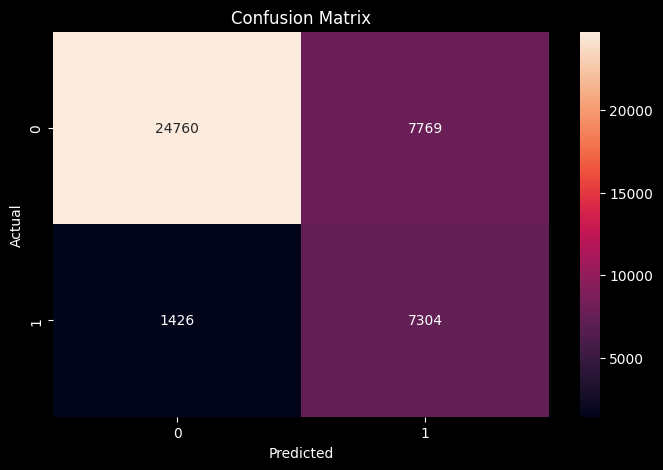

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

We can draw some initial conclusions for **the optimized model** using some business-centric measures:

- **False Negative (FN)** is an important measure for churn problem - the business does not want to under-value customers that would exit (1) by classifying them as non-exit (0) - because the cost of new customer acquisition is generally higher than the cost of keeping the customer. Ideally, the model should minimize the FN number. 
- **False Negative Rate, $FNR = \frac{{FN}}{P} = \frac{{FN}}{FN + TP}$** essentially means: out of all **actually exited customers**, what is the percentage of the customers does the model fail to capture. In this baseline model, $FNR = 44.66\%$. This is a very high rate and our goal is to drive that down. 
- The Precision, 
- The AUC

In [ ]:
# get model auc score
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_test, y_pred2)
print(f'AUC Score: {auc_score}')

AUC Score: 0.7989110853133535
